In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

folder_path = r'C:\Users\sw00h\PycharmProjects\pythonProject\workspace\data'
os.listdir(folder_path)
file_names = []
for file in os.listdir(folder_path):
    if '.csv' in file:
        file_names.append(file)

data_path = r'C:\Users\sw00h\PycharmProjects\pythonProject\workspace\data'
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [2]:
train_df

ID  target  _type
0     2023-01-01 00:00:00       2  train
1     2023-01-01 01:00:00       1  train
2     2023-01-01 02:00:00       1  train
3     2023-01-01 03:00:00       1  train
4     2023-01-01 04:00:00       2  train
...                   ...     ...    ...
8755  2023-12-31 19:00:00       1  train
8756  2023-12-31 20:00:00       1  train
8757  2023-12-31 21:00:00       0  train
8758  2023-12-31 22:00:00       2  train
8759  2023-12-31 23:00:00       2  train

[8760 rows x 3 columns]

In [3]:
file_names = file_names[:-3]
df_list = [pd.read_csv(f"{folder_path}\\{file}") for file in file_names]
len(df_list)

107

In [4]:
# 초기 데이터프레임 설정 및 인덱스 초기화
merged_df = df_list[0].reset_index(drop=True)

# 데이터프레임 통합
for i, df in enumerate(df_list[1:], start=1):
    df = df.reset_index(drop=True)  # 각 데이터프레임의 인덱스를 초기화
    # 병합 시 충돌하는 컬럼 구분을 위해 접미사 지정
    merged_df = pd.merge(
        merged_df, 
        df, 
        on='datetime', 
        how='outer', 
        suffixes=('', f'_df{i}')  # 각 병합 데이터프레임에 인덱스 기반 접미사 추가
    )

# 통합된 데이터프레임 출력
print(merged_df)

                   datetime  coinbase_premium_gap  coinbase_premium_index  \
0       2024-04-26 06:00:00                 -2.05               -0.003184   
1       2024-04-26 05:00:00                  1.85                0.002866   
2       2024-04-26 04:00:00                -11.73               -0.018268   
3       2024-04-26 03:00:00                 -1.53               -0.002376   
4       2024-04-26 02:00:00                  2.70                0.004186   
...                     ...                   ...                     ...   
115223  2011-03-13 18:00:00                   NaN                     NaN   
115224  2011-03-13 17:00:00                   NaN                     NaN   
115225  2011-03-13 16:00:00                   NaN                     NaN   
115226  2011-03-13 15:00:00                   NaN                     NaN   
115227  2011-03-13 14:00:00                   NaN                     NaN   

        funding_rates  funding_rates_df2  funding_rates_df3  \
0           

In [5]:
merged_df = merged_df.rename(columns={'datetime':'ID'})

In [6]:
# 2. train_df의 ID와 병합 (on='ID' 사용)
final_df = pd.merge(merged_df, train_df, on='ID', how='outer')  # 'outer'로 모든 데이터 유지
final_df.drop('_type', axis=1, inplace=True)
print(final_df.shape)
final_df.head()

(115228, 254)


ID  coinbase_premium_gap  coinbase_premium_index  \
0  2024-04-26 06:00:00                 -2.05               -0.003184   
1  2024-04-26 05:00:00                  1.85                0.002866   
2  2024-04-26 04:00:00                -11.73               -0.018268   
3  2024-04-26 03:00:00                 -1.53               -0.002376   
4  2024-04-26 02:00:00                  2.70                0.004186   

   funding_rates  funding_rates_df2  funding_rates_df3  funding_rates_df4  \
0            NaN                NaN                NaN                NaN   
1            NaN                NaN                NaN                NaN   
2            NaN           0.006169                NaN                NaN   
3            NaN           0.004867                NaN                NaN   
4            NaN           0.004297                NaN                NaN   

   funding_rates_df5  funding_rates_df6  funding_rates_df7  ...  supply_total  \
0                NaN               0.01               0.01  ...           NaN   
1                NaN               0.01               0.01  ...           NaN   
2                NaN               0.01               0.01  ...           NaN   
3                NaN               0.01               0.01  ...           NaN   
4                NaN               0.01               0.01  ...           NaN   

   supply_new  tokens_transferred_total  tokens_transferred_mean  \
0         NaN              33349.297426                 2.474718   
1         NaN              22262.243597                 1.048326   
2         NaN              51625.600562                 3.225794   
3         NaN              33876.505685                 3.371468   
4         NaN              17753.353670                 1.303381   

   tokens_transferred_median  transactions_count_total  \
0                   0.001943                       NaN   
1                   0.001104                       NaN   
2                   0.002810                       NaN   
3                   0.004827                   10048.0   
4                   0.003008                   13621.0   

   transactions_count_mean   utxo_count  velocity_supply_total  target  
0                      NaN  179852452.0              15.710891     NaN  
1                      NaN  179851249.0              15.709207     NaN  
2                      NaN  179833897.0              15.709585     NaN  
3              3349.333333  179820708.0              15.708903     NaN  
4              3405.250000  179811932.0              15.707708     NaN  

[5 rows x 254 columns]

In [7]:
# 1. ID 열을 datetime 형식으로 변환
final_df['ID'] = pd.to_datetime(final_df['ID'])

# 2. 2018년부터 2023년까지의 데이터 필터링
data_18_to_23 = final_df[(final_df['ID'].dt.year >= 2018) & (final_df['ID'].dt.year <= 2023)]

# 3. 데이터 크기 확인
print(data_18_to_23.shape)


(52780, 254)


In [8]:
data_18_to_23 = data_18_to_23.sort_values(by='ID', ascending=True)

In [9]:
# ID 열을 datetime 형식으로 변환
final_df['ID'] = pd.to_datetime(final_df['ID'], errors='coerce')
# 3. 훈련 데이터 (2011년 ~ 2022년)
data_2022 = final_df[final_df['ID'].dt.year <= 2022] 
# 4. 검증 데이터 (2023년)
data_2023 = final_df[final_df['ID'].dt.year == 2023]

data_2024 = final_df[final_df['ID'].dt.year == 2024]
print(f"Train Data: {data_2022.shape}, Validation Data: {data_2023.shape}, data_2024_before_jan: {data_2024.shape}")

Train Data: (103670, 254), Validation Data: (8760, 254), data_2024_before_jan: (2798, 254)


In [10]:
# 2018년부터 2022년까지의 데이터를 필터링
data_18_22 = final_df[(final_df['ID'].dt.year >= 2018) & (final_df['ID'].dt.year <= 2022)]

# 필터링된 데이터 확인
print(data_18_22.shape)
print(data_18_22.head())


(44020, 254)
                       ID  coinbase_premium_gap  coinbase_premium_index  \
11546 2022-12-31 23:00:00                -12.05               -0.072843   
11547 2022-12-31 22:00:00                 -9.82               -0.059440   
11548 2022-12-31 21:00:00                 -9.06               -0.054749   
11549 2022-12-31 20:00:00                -12.31               -0.074297   
11550 2022-12-31 19:00:00                -10.46               -0.063126   

       funding_rates  funding_rates_df2  funding_rates_df3  funding_rates_df4  \
11546       0.005388               0.01           0.001400               0.01   
11547       0.005377               0.01           0.001400               0.01   
11548       0.005356               0.01           0.001400               0.01   
11549       0.005319               0.01           0.001400               0.01   
11550       0.006725               0.01           0.009858               0.01   

       funding_rates_df5  funding_rates_df6  fund

In [11]:
# Ensure the ID column is in datetime format
data_2022['ID'] = pd.to_datetime(data_2022['ID'])
data_2023['ID'] = pd.to_datetime(data_2023['ID'])
data_2024['ID'] = pd.to_datetime(data_2024['ID'])

# Sort the DataFrame by the 'ID' column in ascending order
data_2022 = data_2022.sort_values(by='ID', ascending=True)
data_2023 = data_2023.sort_values(by='ID', ascending=True)
data_2024 = data_2024.sort_values(by='ID', ascending=True)

data_2022.reset_index(drop=True, inplace=True)
data_2023.reset_index(drop=True, inplace=True)
data_2024.reset_index(drop=True, inplace=True)

print(f"data_2022: {data_2022.shape}, data_2023 Data: {data_2023.shape}, data_2024: {data_2024.shape}")

data_2022: (103670, 254), data_2023 Data: (8760, 254), data_2024: (2798, 254)


C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\3326716123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2022['ID'] = pd.to_datetime(data_2022['ID'])
C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\3326716123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023['ID'] = pd.to_datetime(data_2023['ID'])
C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\3326716123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [12]:
# 모든 값이 결측치인 컬럼을 찾아서 삭제
columns_to_drop_2023 = data_2023.columns[data_2023.isnull().all()]  # 모든 값이 결측치인 컬럼 찾기
data_2023 = data_2023.drop(columns=columns_to_drop_2023)  # 해당 컬럼 삭제
# 확인: 삭제한 컬럼 출력
print(f"삭제된 컬럼: {columns_to_drop_2023}")
print(f"현재 데이터 셋의 크기: {data_2023.shape}")

삭제된 컬럼: Index(['funding_rates_df8', 'long_liquidations_df24',
       'short_liquidations_df24', 'long_liquidations_usd_df24',
       'short_liquidations_usd_df24', 'long_liquidations_df25',
       'short_liquidations_df25', 'long_liquidations_usd_df25',
       'short_liquidations_usd_df25', 'long_liquidations_df35',
       'short_liquidations_df35', 'long_liquidations_usd_df35',
       'short_liquidations_usd_df35', 'long_liquidations_df36',
       'short_liquidations_df36', 'long_liquidations_usd_df36',
       'short_liquidations_usd_df36', 'long_liquidations_df37',
       'short_liquidations_df37', 'long_liquidations_usd_df37',
       'short_liquidations_usd_df37', 'open_interest', 'open_interest_df43',
       'open_interest_df48', 'open_interest_df51', 'open_interest_df54',
       'open_interest_df58', 'open_interest_df61', 'open_interest_df62',
       'open_interest_df63', 'open_interest_df64', 'open_interest_df71',
       'open_interest_df75', 'open_interest_df78', 'open_interest_

In [13]:
data_2023.isnull().sum().sort_values()

ID                              0
volume                          0
close                           0
open_interest_df70              0
open_interest_df69              0
                               ..
short_liquidations_df12        88
open_interest_df45             88
long_liquidations_df12         88
long_liquidations_usd_df12     88
short_liquidations_usd_df12    88
Length: 214, dtype: int64

In [14]:
data_2023.fillna(0, inplace=True)

In [70]:
data_2023

ID  coinbase_premium_gap  coinbase_premium_index  \
0    2023-01-01 00:00:00                 -9.86               -0.059650   
1    2023-01-01 01:00:00                 -8.78               -0.053047   
2    2023-01-01 02:00:00                 -9.59               -0.057952   
3    2023-01-01 03:00:00                 -9.74               -0.058912   
4    2023-01-01 04:00:00                -10.14               -0.061373   
...                  ...                   ...                     ...   
8755 2023-12-31 19:00:00                -27.10               -0.063587   
8756 2023-12-31 20:00:00                -24.73               -0.058109   
8757 2023-12-31 21:00:00                -28.48               -0.066979   
8758 2023-12-31 22:00:00                 -9.08               -0.021487   
8759 2023-12-31 23:00:00                  4.48                0.010595   

      funding_rates  funding_rates_df2  funding_rates_df3  funding_rates_df4  \
0          0.005049           0.010000           0.001400           0.010000   
1          0.005049           0.010000           0.001400           0.010000   
2          0.005049           0.010000           0.001400           0.010000   
3          0.005067           0.010000           0.001518           0.010000   
4          0.006210           0.010000           0.008400           0.010000   
...             ...                ...                ...                ...   
8755       0.036371           0.036288           0.014468           0.024847   
8756       0.037233           0.038245           0.018500           0.023523   
8757       0.037761           0.040547           0.018500           0.022368   
8758       0.038020           0.041638           0.018500           0.021547   
8759       0.037049           0.039306           0.018500           0.019143   

      funding_rates_df5  funding_rates_df6  funding_rates_df7  ...  \
0              0.000571           0.010000           0.010000  ...   
1              0.000570           0.010000           0.010000  ...   
2              0.000566           0.010000           0.010000  ...   
3              0.000557           0.010000           0.010000  ...   
4              0.000536           0.010000           0.010000  ...   
...                 ...                ...                ...  ...   
8755           0.035893           0.064891           0.064891  ...   
8756           0.036404           0.064891           0.064891  ...   
8757           0.038425           0.064891           0.064891  ...   
8758           0.039708           0.064891           0.064891  ...   
8759           0.038614           0.064891           0.064891  ...   

      supply_total  supply_new  tokens_transferred_total  \
0     1.924871e+07       75.00              33057.024011   
1     1.924874e+07       25.00              12933.965951   
2     1.924879e+07       50.00              26960.250177   
3     1.924882e+07       31.25              32747.924338   
4     1.924886e+07       43.75              26550.999095   
...            ...         ...                       ...   
8755  1.958605e+07       56.25              34918.916733   
8756  1.958607e+07       25.00              20015.782598   
8757  1.958609e+07       18.75              13822.498528   
8758  1.958611e+07       12.50              18699.215727   
8759  1.958613e+07       25.00               8369.792889   

      tokens_transferred_mean  tokens_transferred_median  \
0                    2.885312                   0.020125   
1                    2.217758                   0.021293   
2                    4.857703                   0.022980   
3                    6.243646                   0.024678   
4                    3.824690                   0.028596   
...                       ...                        ...   
8755                 0.845781                   0.000620   
8756                 0.927301                   0.001052   
8757                 1.001413                   0.005020   
8758      

In [15]:
original_data = data_2023.copy()

In [36]:
import numpy as np

# target 컬럼 제외, 수치형 데이터 컬럼 선택
exclude_columns = ['target']
numeric_columns = data_2023.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# 음수 값을 다루기 위해 상수 추가
min_value = data_2023[numeric_columns].min().min()  # 전체 데이터에서 가장 작은 값 확인

# 만약 최소값이 음수라면, 모든 값에 상수 (1 - min_value)를 더해 양수로 만듦
if min_value <= 0:
    data_2023[numeric_columns] = data_2023[numeric_columns] + (1 - min_value)

# 제곱근 변환 적용 (각 컬럼에 대해)
data_2023[numeric_columns] = np.sqrt(data_2023[numeric_columns])

# 변환된 데이터 확인
data_2023


ID  coinbase_premium_gap  coinbase_premium_index  \
2791  2023-12-31 23:00:00             21.167900               21.062065   
2792  2023-12-31 22:00:00             20.845143               21.061304   
2793  2023-12-31 21:00:00             20.374494               21.060224   
2794  2023-12-31 20:00:00             20.466314               21.060434   
2795  2023-12-31 19:00:00             20.408332               21.060304   
...                   ...                   ...                     ...   
58692 2023-03-24 13:00:00             21.061814               21.061814   
58693 2023-03-04 20:00:00             21.061814               21.061814   
58694 2023-03-04 19:00:00             21.061814               21.061814   
58695 2023-03-04 18:00:00             21.061814               21.061814   
58696 2023-03-04 17:00:00             21.061814               21.061814   

       funding_rates  funding_rates_df2  funding_rates_df3  funding_rates_df4  \
2791       21.062693          21.062747          21.062253          21.062268   
2792       21.062716          21.062802          21.062253          21.062325   
2793       21.062710          21.062776          21.062253          21.062345   
2794       21.062698          21.062722          21.062253          21.062372   
2795       21.062677          21.062675          21.062157          21.062404   
...              ...                ...                ...                ...   
58692      21.062014          21.061863          21.061876          21.062051   
58693      21.061821          21.061866          21.061517          21.062051   
58694      21.061894          21.061870          21.061954          21.062051   
58695      21.061895          21.061870          21.061961          21.062051   
58696      21.061895          21.061869          21.061961          21.062051   

       funding_rates_df5  funding_rates_df6  funding_rates_df7  ...  \
2791           21.062730          21.063354          21.063354  ...   
2792           21.062756          21.063354          21.063354  ...   
2793           21.062726          21.063354          21.063354  ...   
2794           21.062678          21.063354          21.063354  ...   
2795           21.062666          21.063354          21.063354  ...   
...                  ...                ...                ...  ...   
58692          21.061983          21.062051          21.062051  ...   
58693          21.061814          21.062051          21.062051  ...   
58694          21.061814          21.062051          21.062051  ...   
58695          21.061814          21.062051          21.062051  ...   
58696          21.061814          21.062051          21.062051  ...   

       supply_total  supply_new  tokens_transferred_total  \
2791    4425.672508   21.647171                 93.879672   
2792    4425.669683   21.356498                138.357565   
2793    4425.667565   21.502325                119.440774   
2794    4425.665447   21.647171                143.036298   
2795    4425.662622   22.357325                188.049240   
...             ...         ...                       ...   
58692   4396.289873   22.357325                238.193859   
58693   4394.172521   21.791053                132.248250   
58694   4394.168965   22.217111                161.499810   
58695   4394.163276   21.933992                150.132735   
58696   4394.159009   22.357325                133.230803   

       tokens_transferred_mean  tokens_transferred_median  \
2791                 21.071055                  21.061900   
2792                 21.116750                  21.062033   
2793                 21.085574                  21.061933   
2794                 21.083816                  21.061839   
2795                 21.081883                  21.061829   
...                        ...                        ...   
58692                21.149001                  21.062207   
58693                21.101077                  21.062031   
58694         

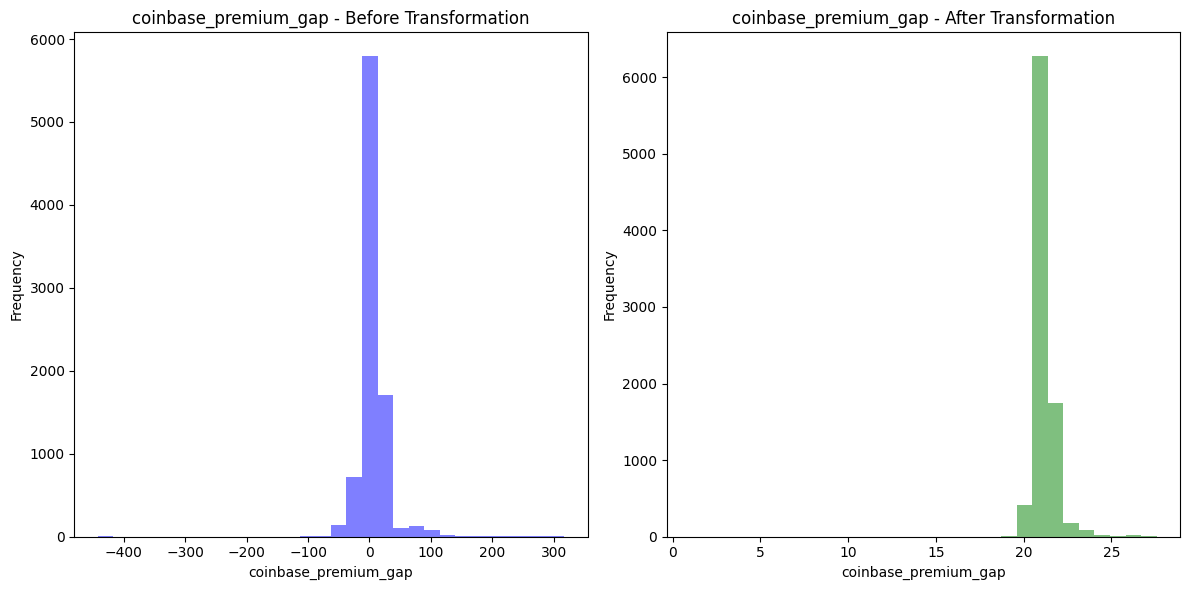

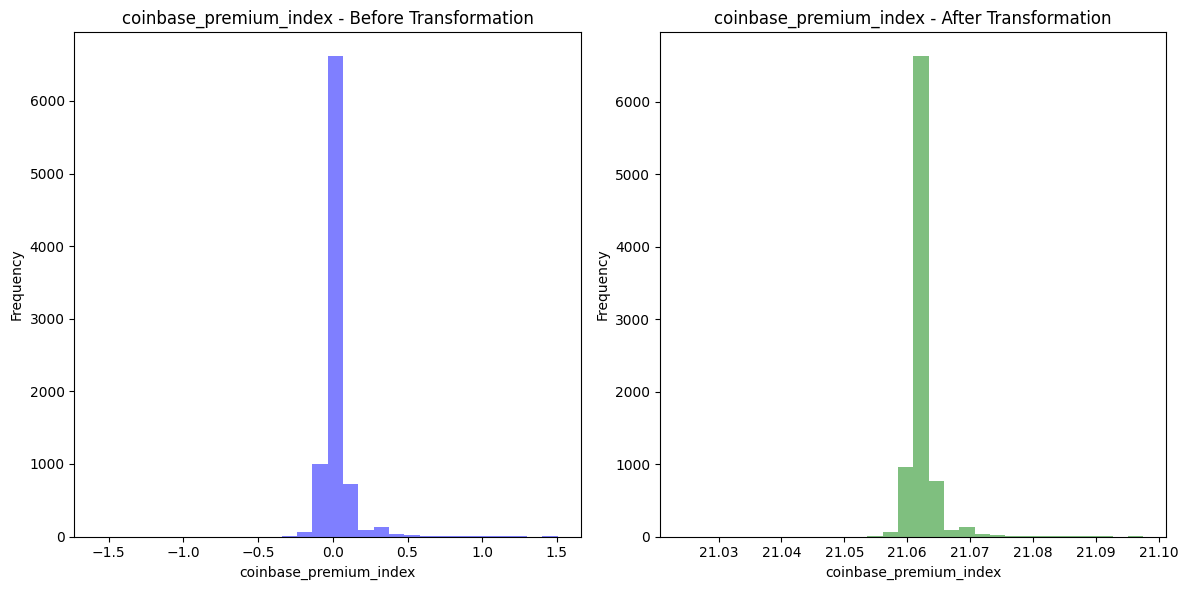

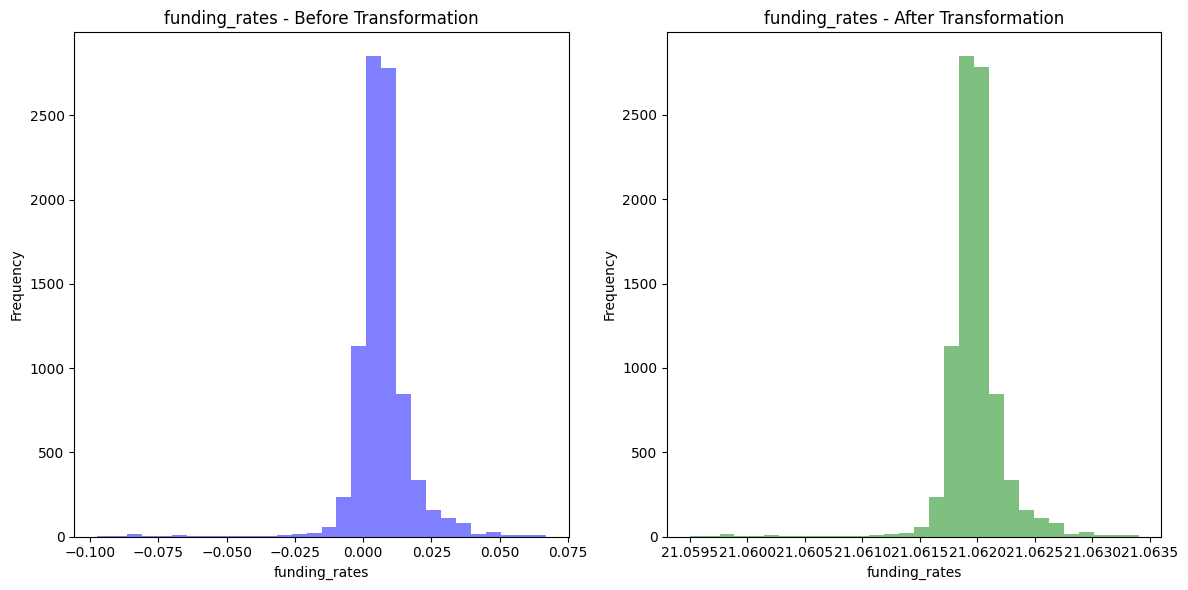

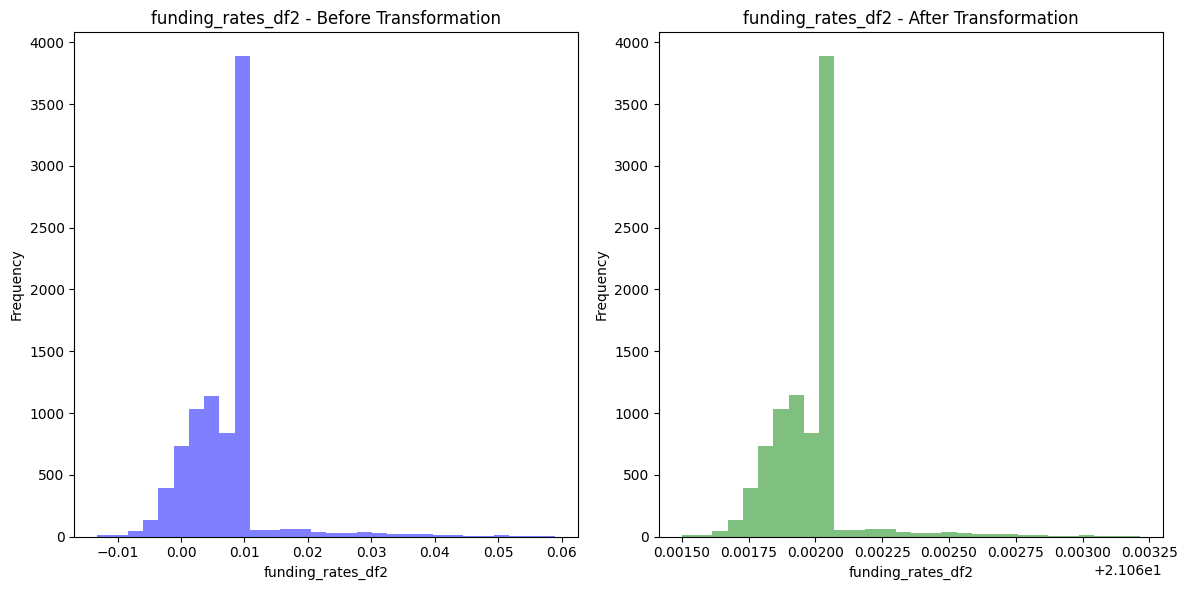

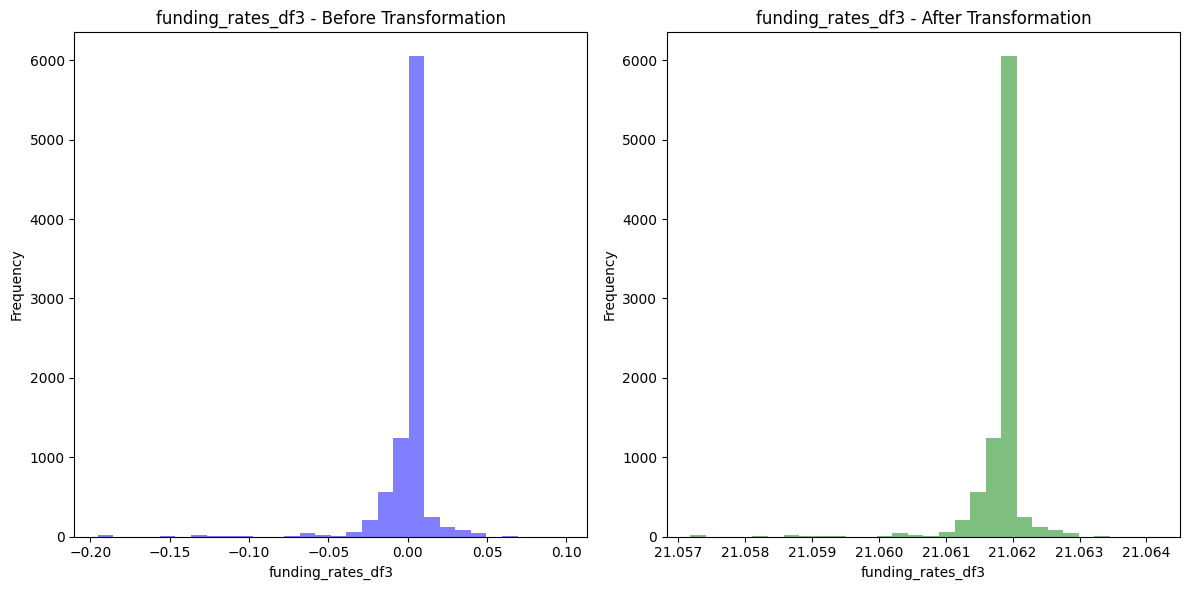

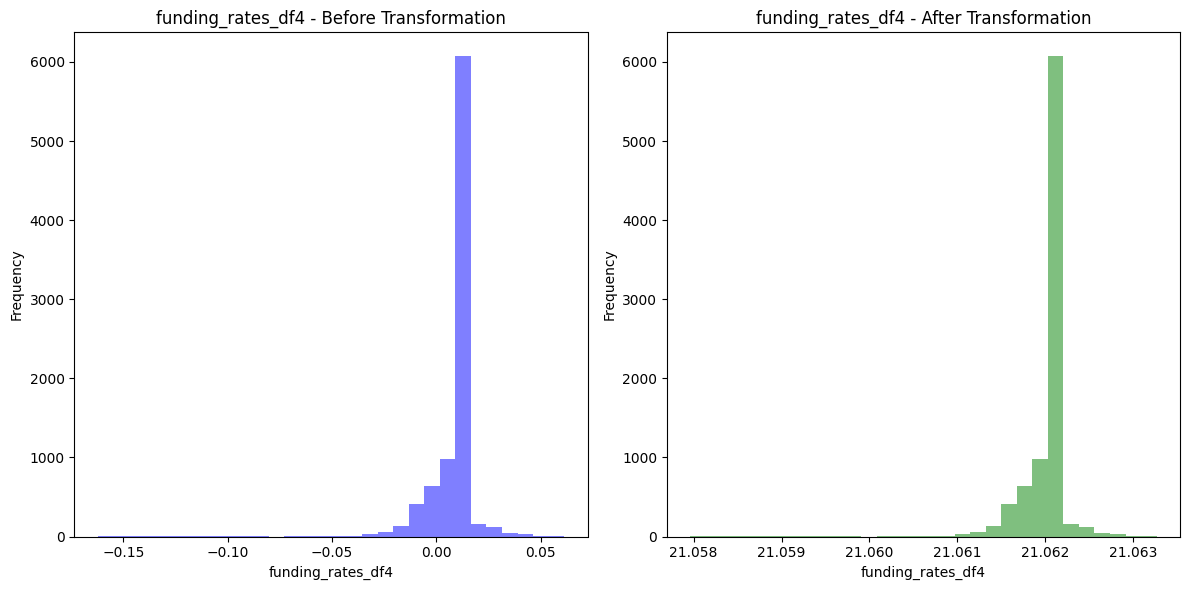

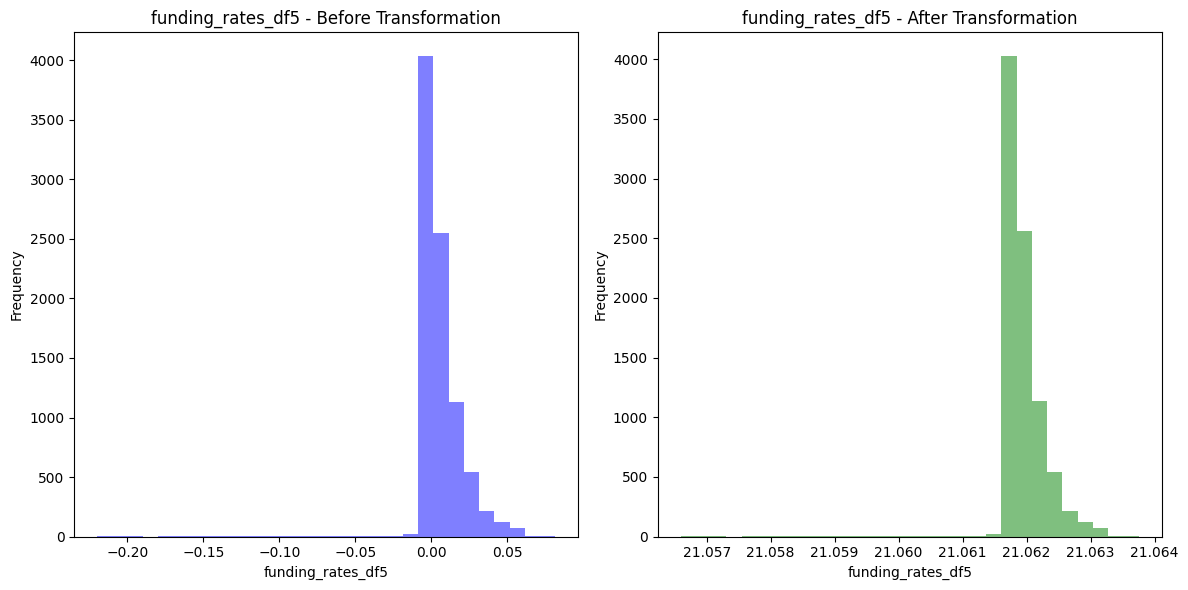

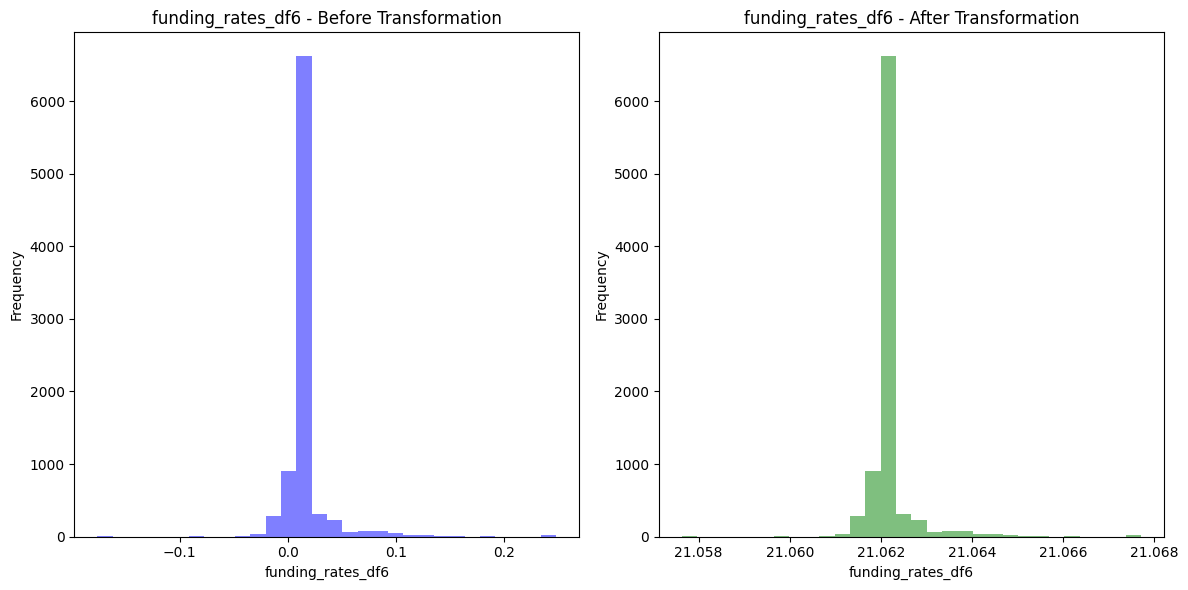

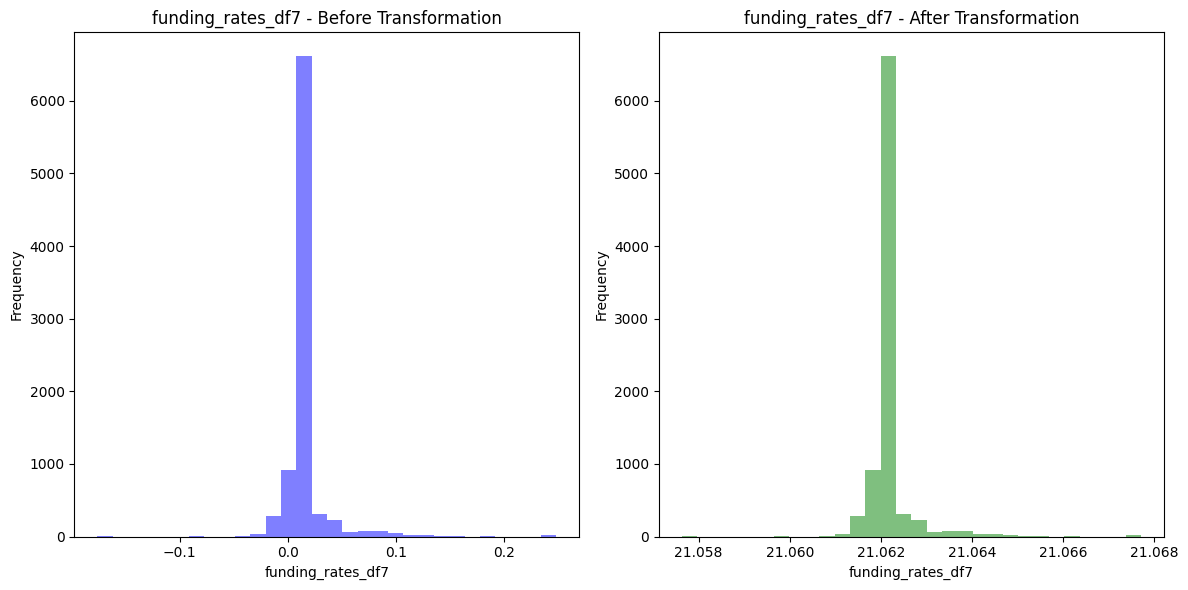

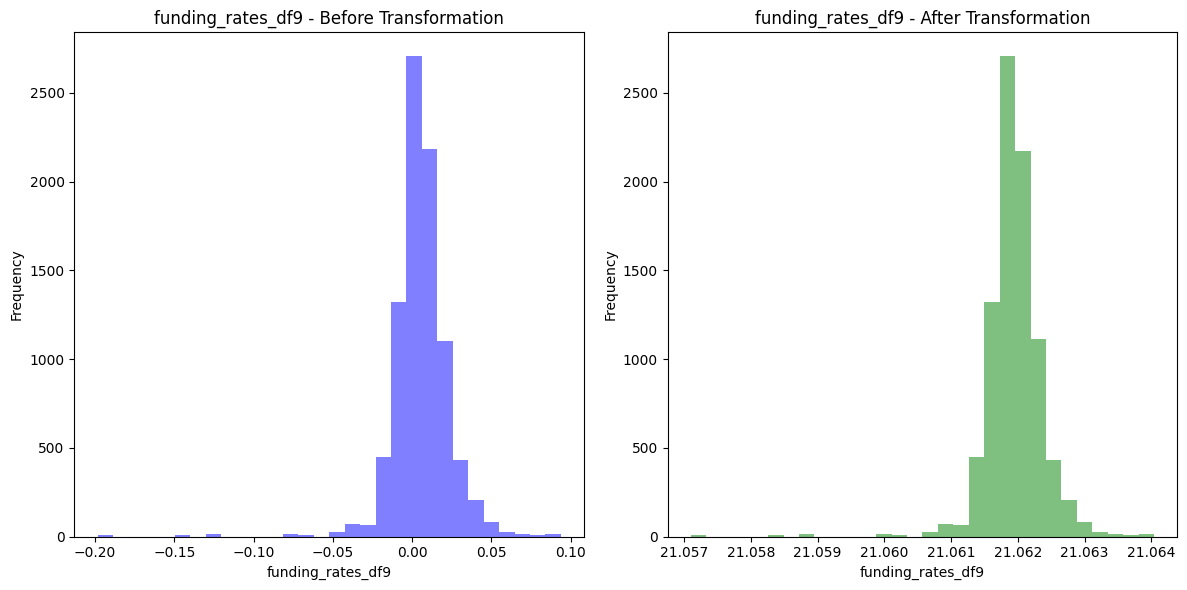

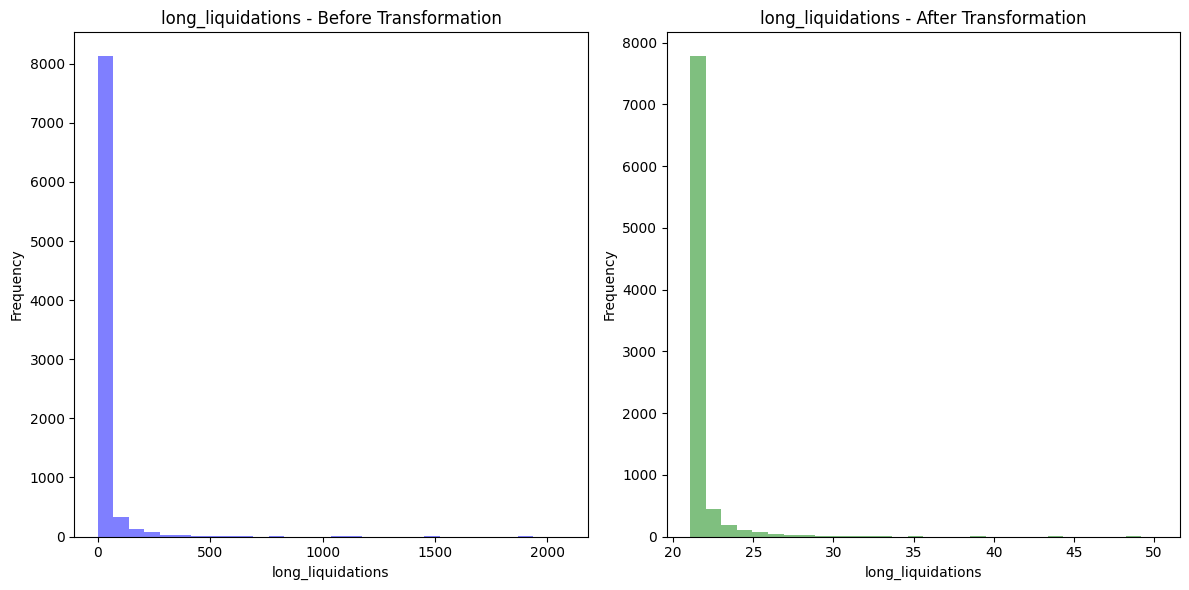

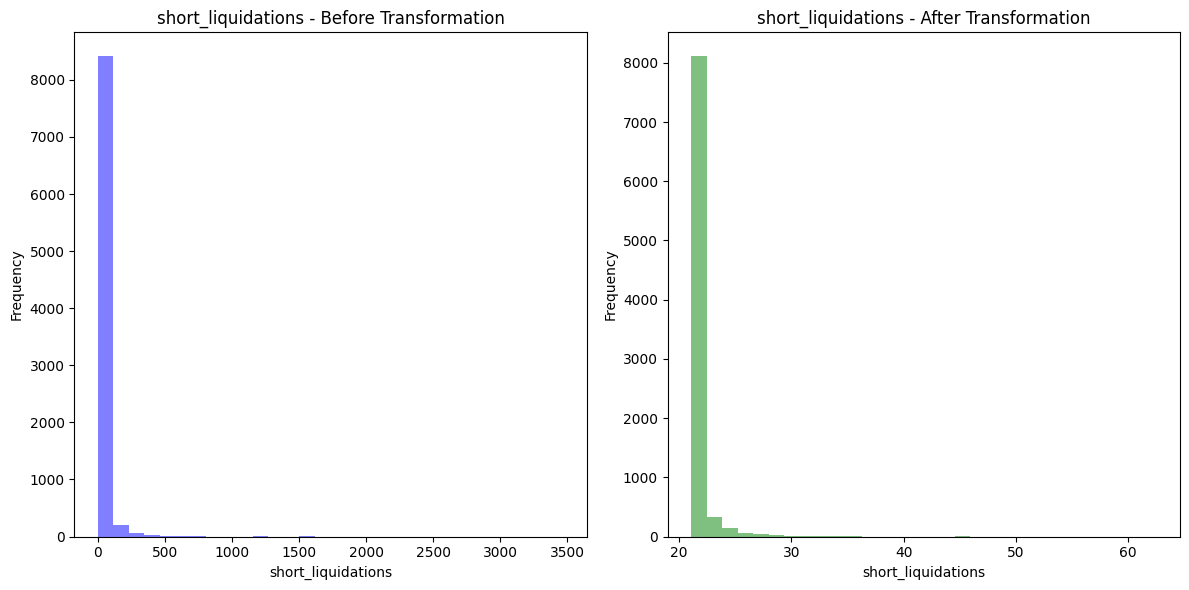

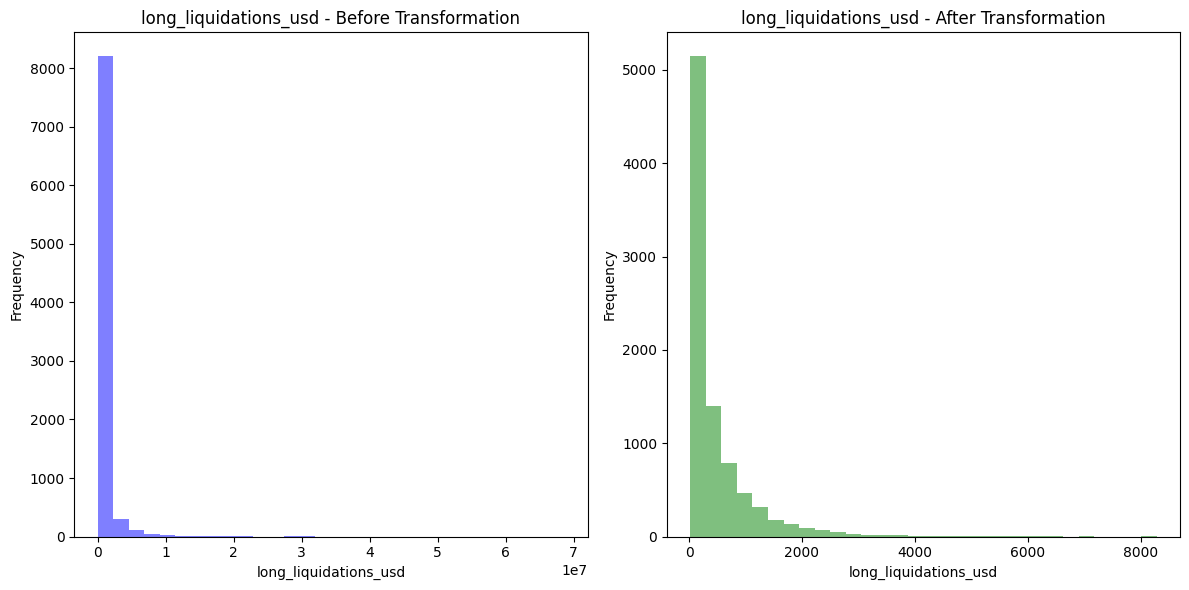

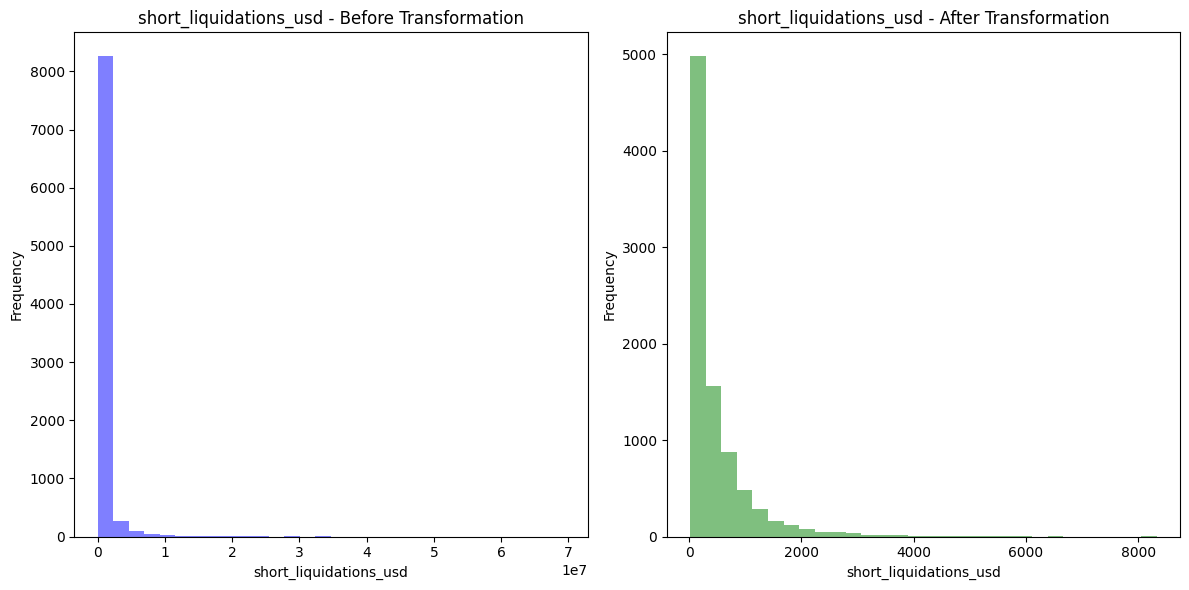

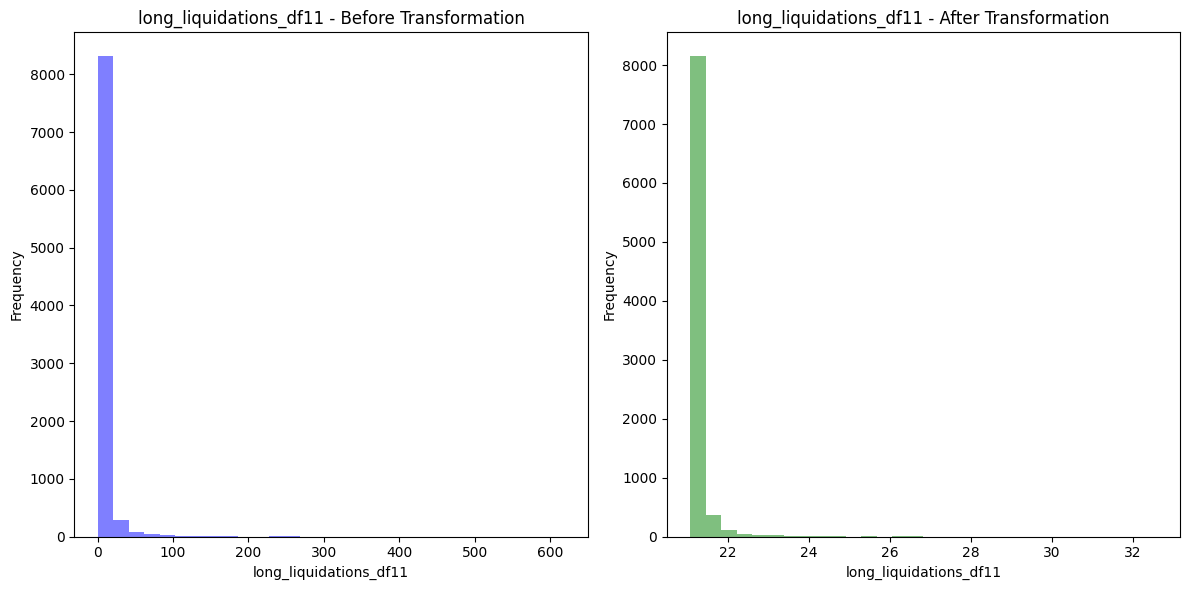

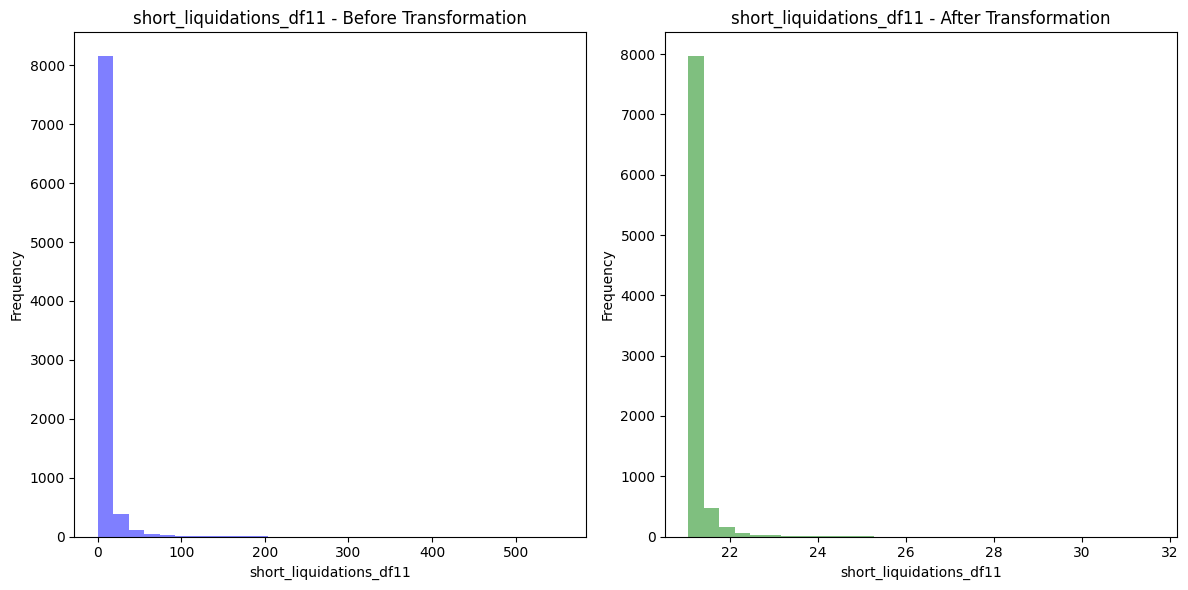

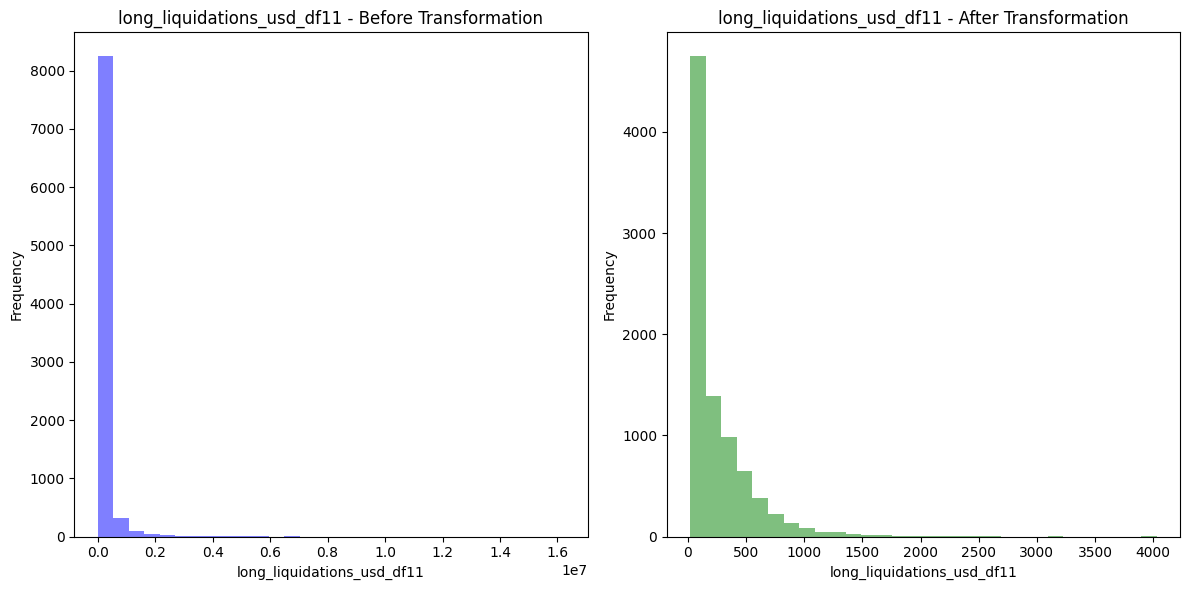

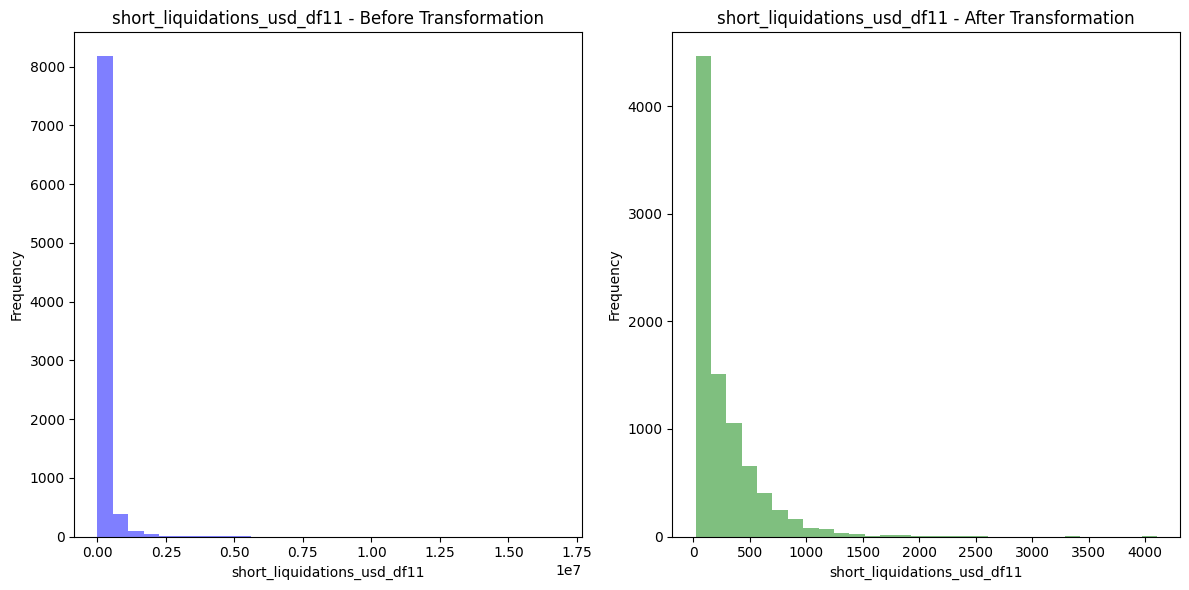

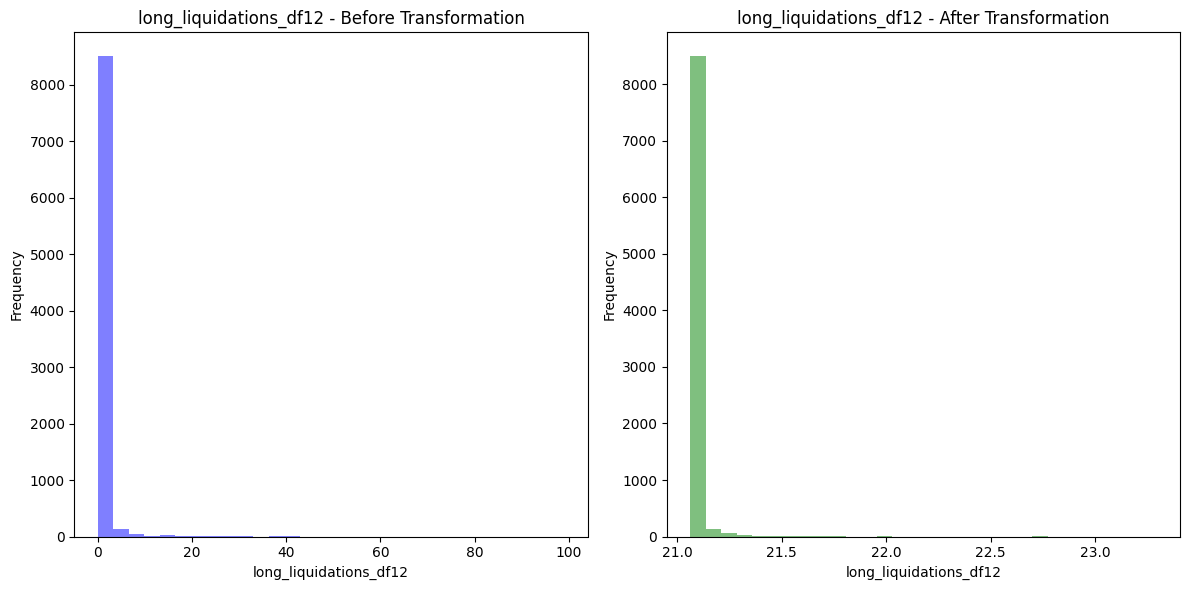

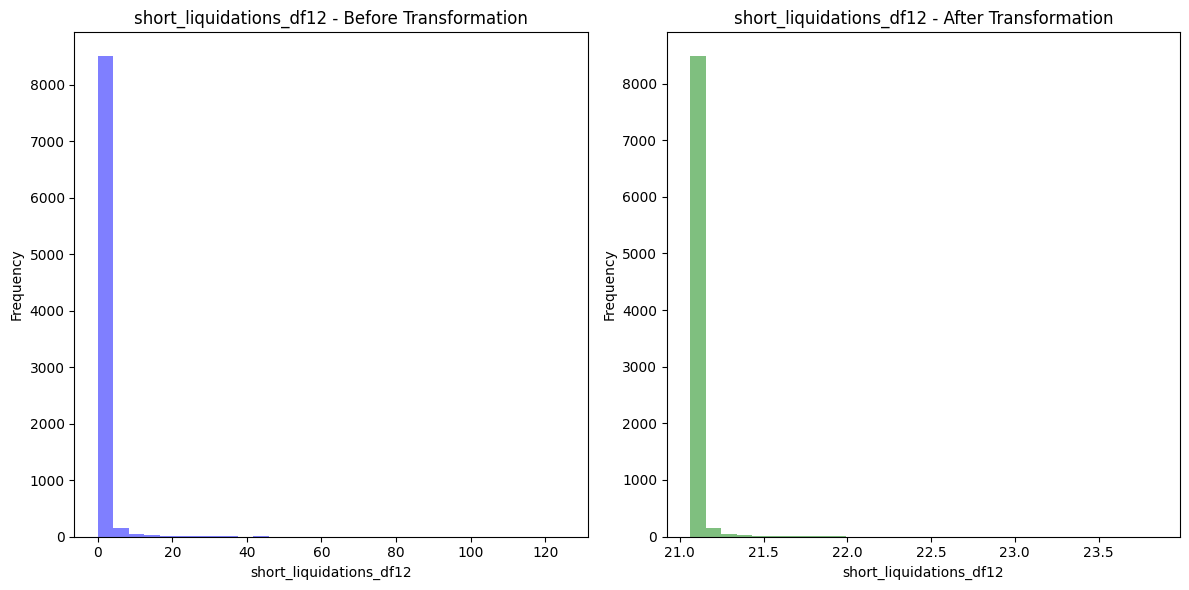

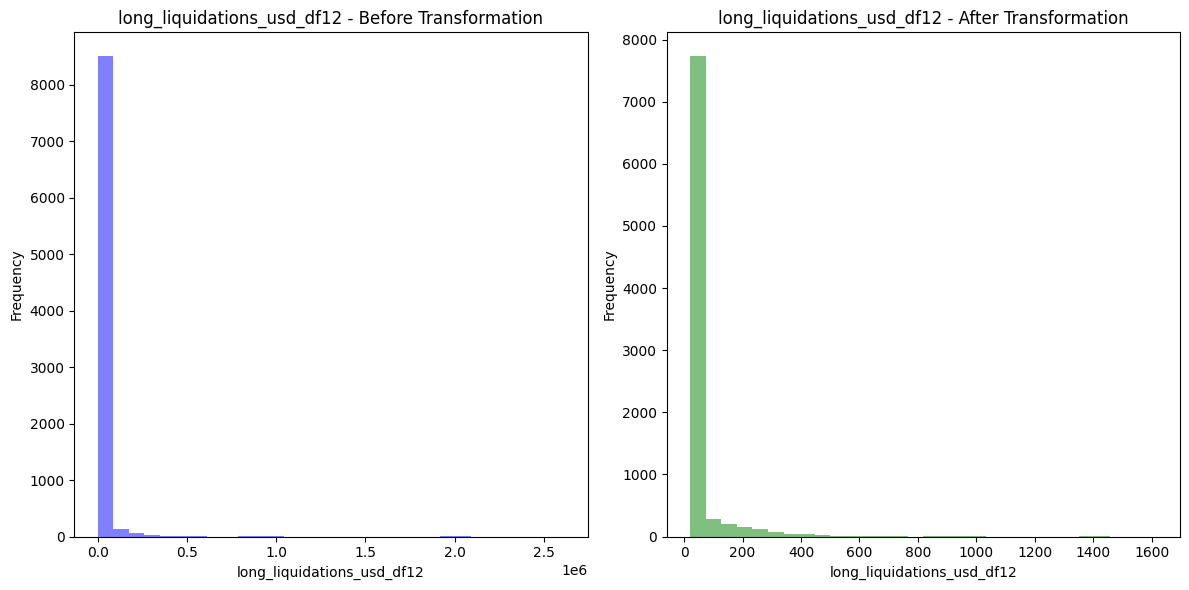

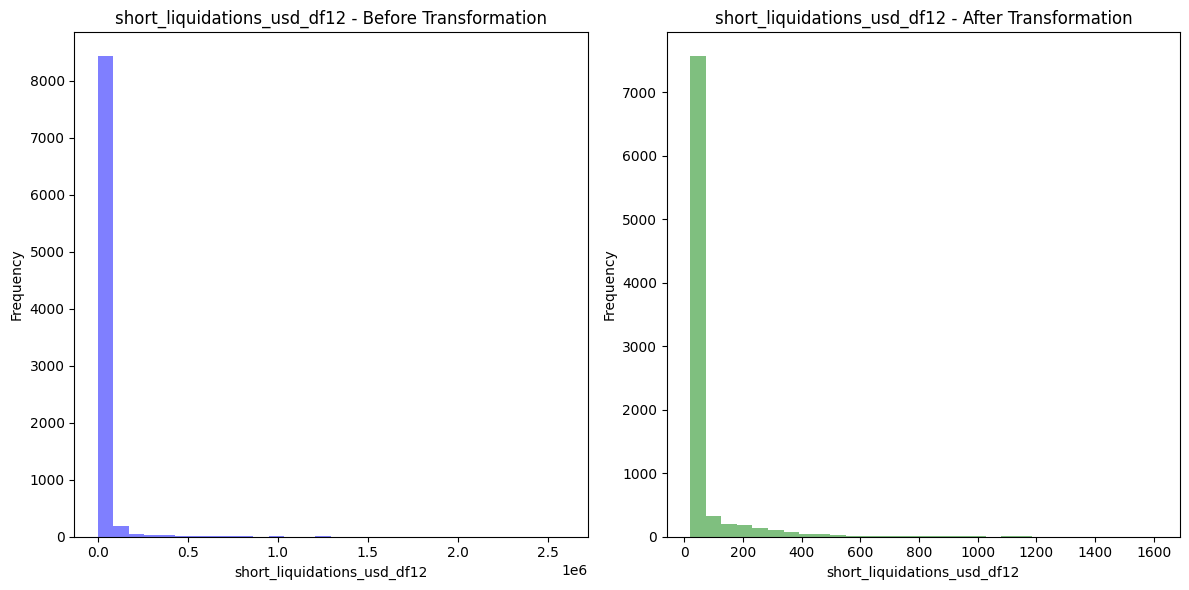

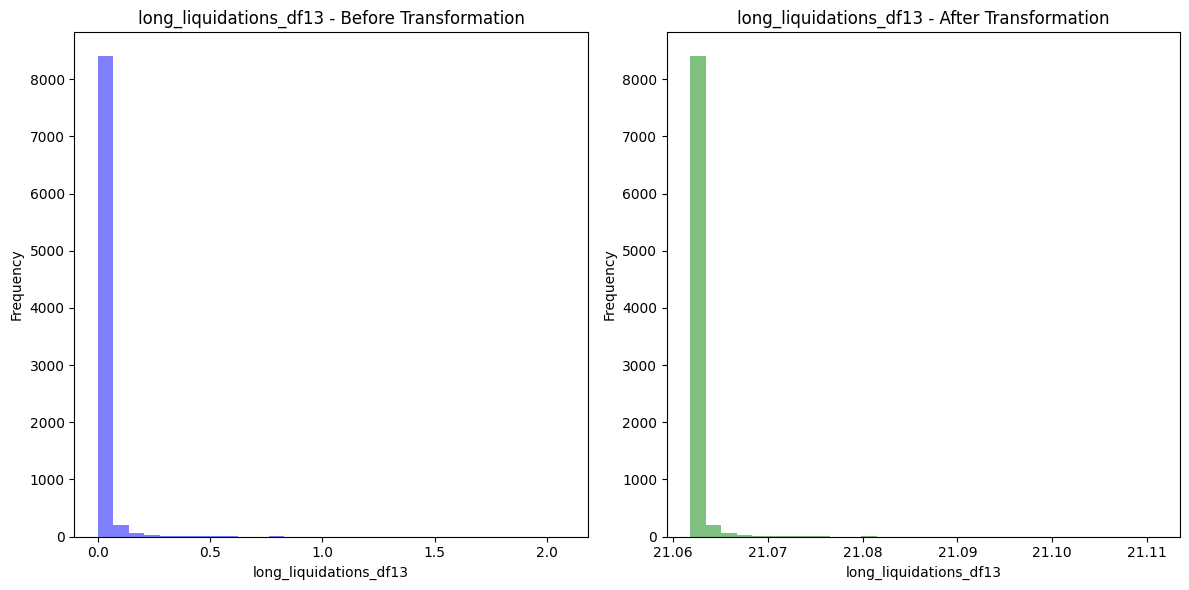

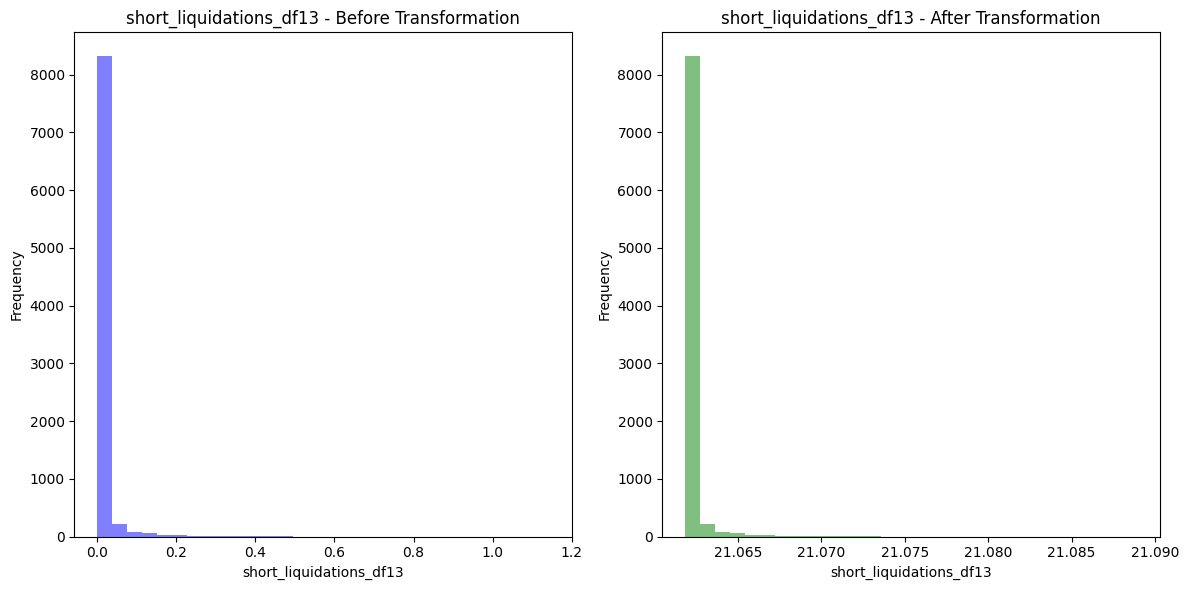

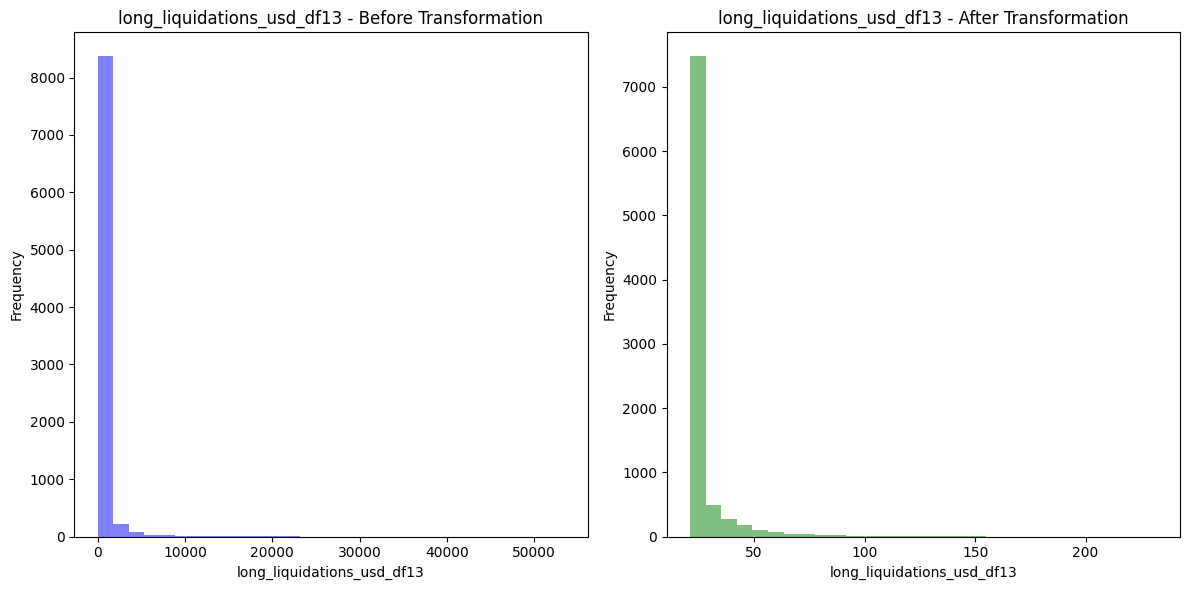

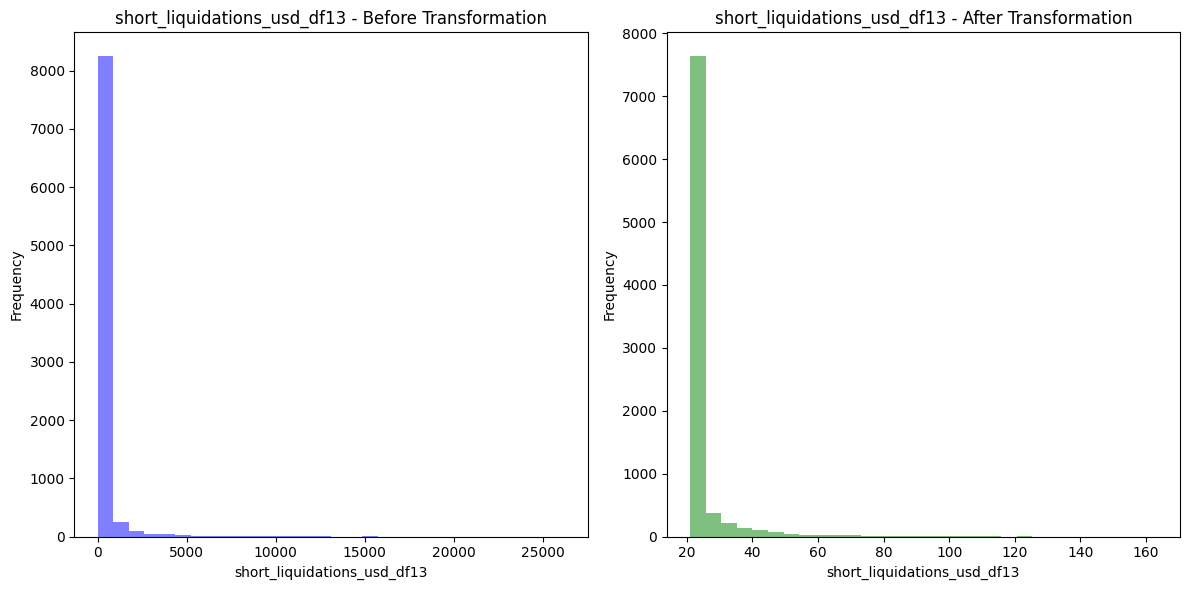

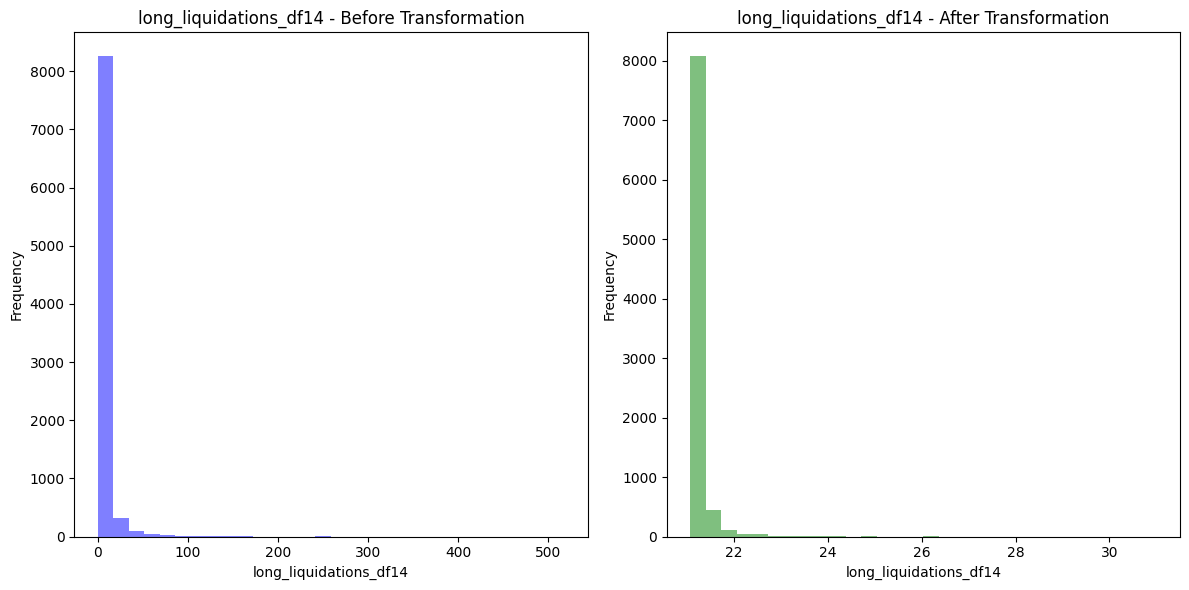

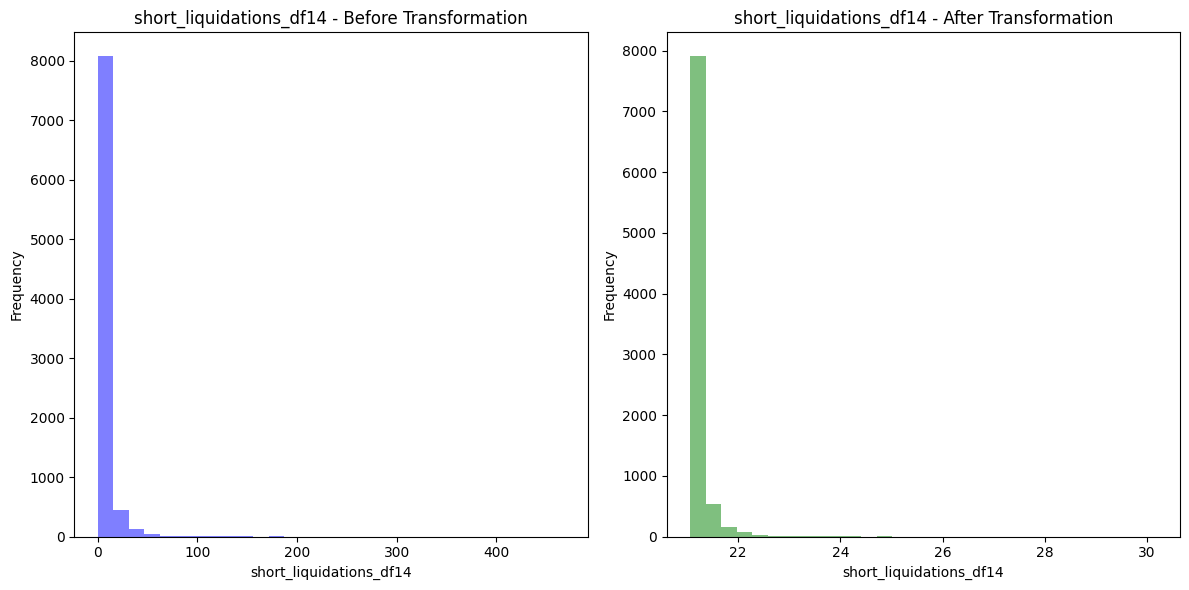

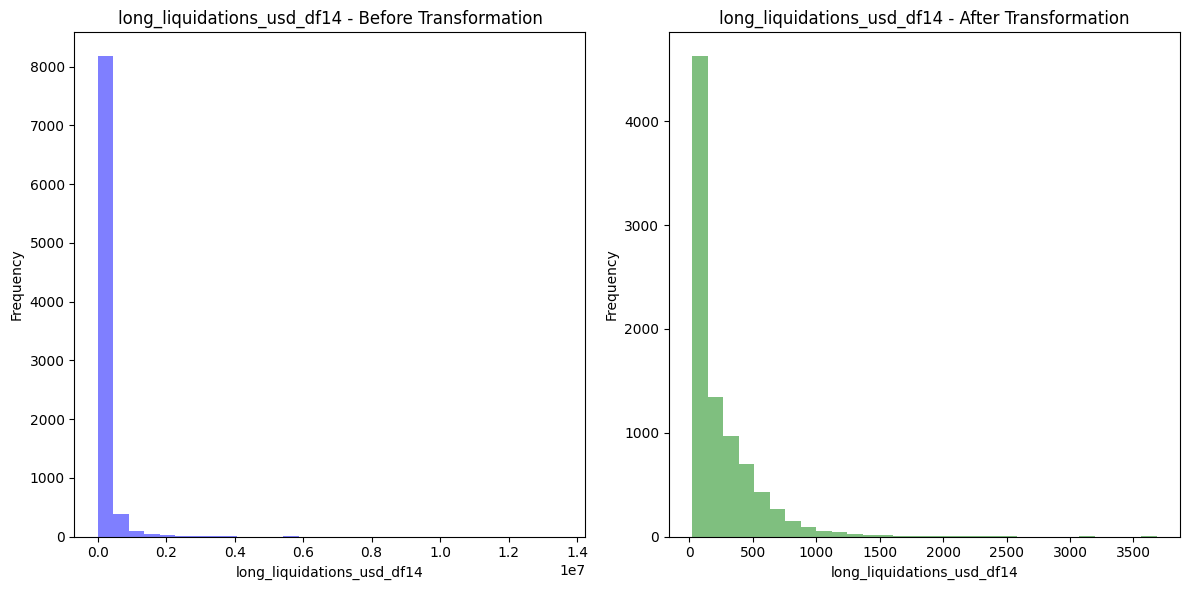

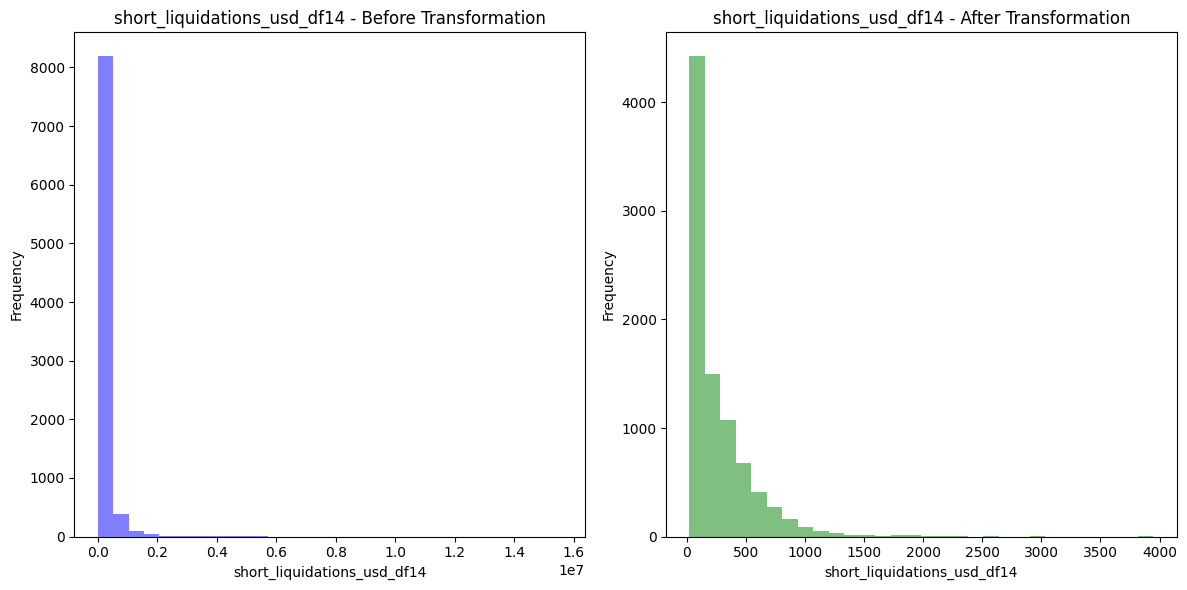

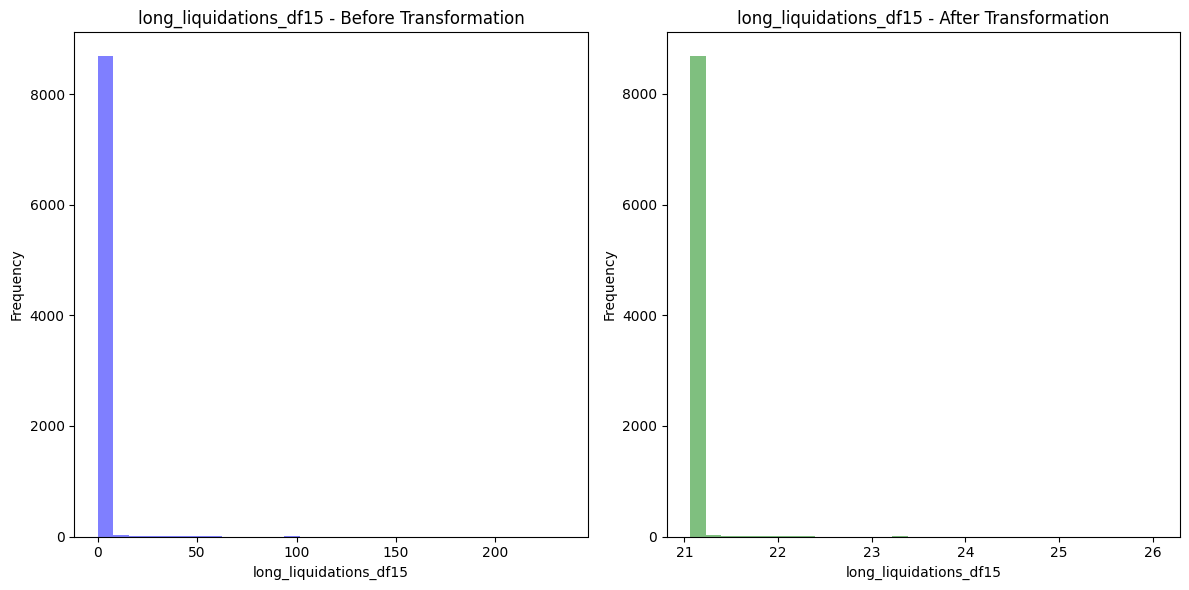

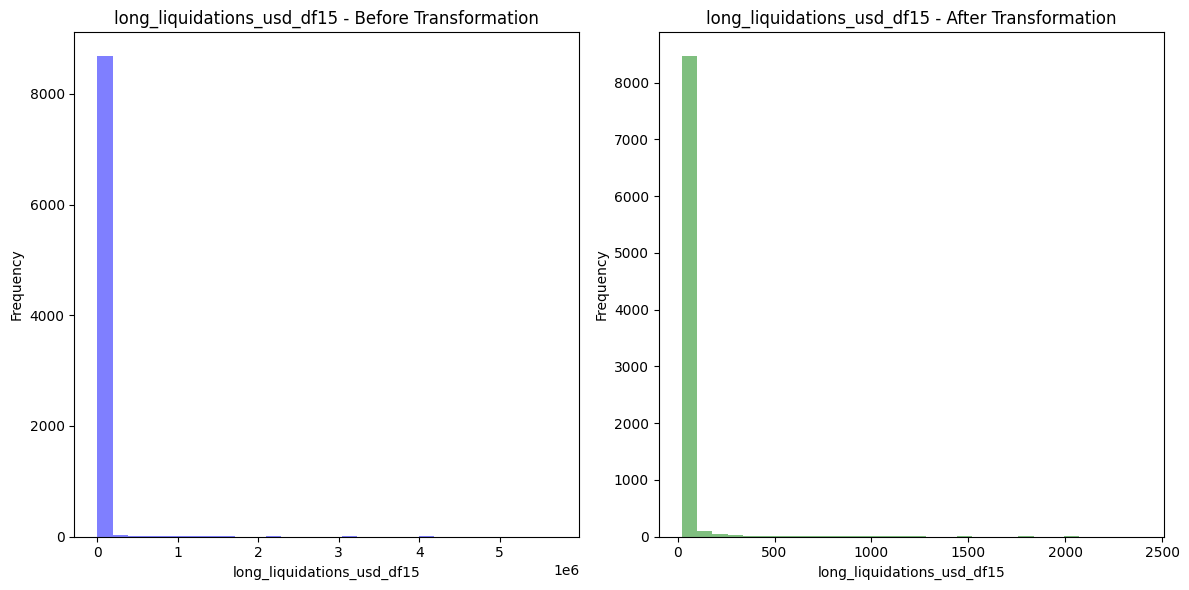

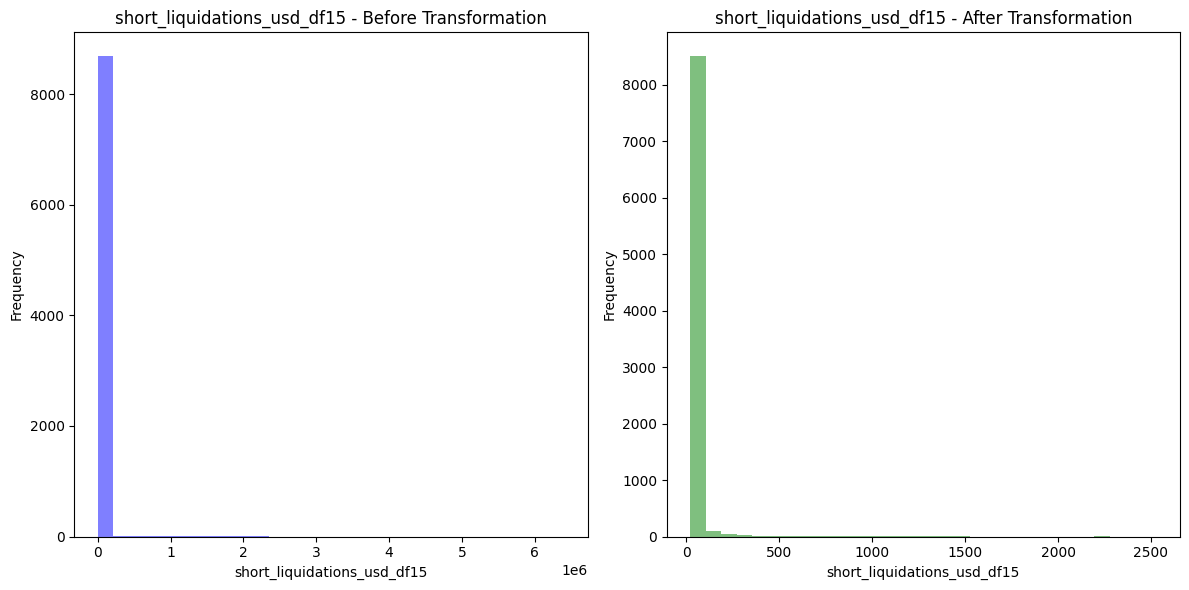

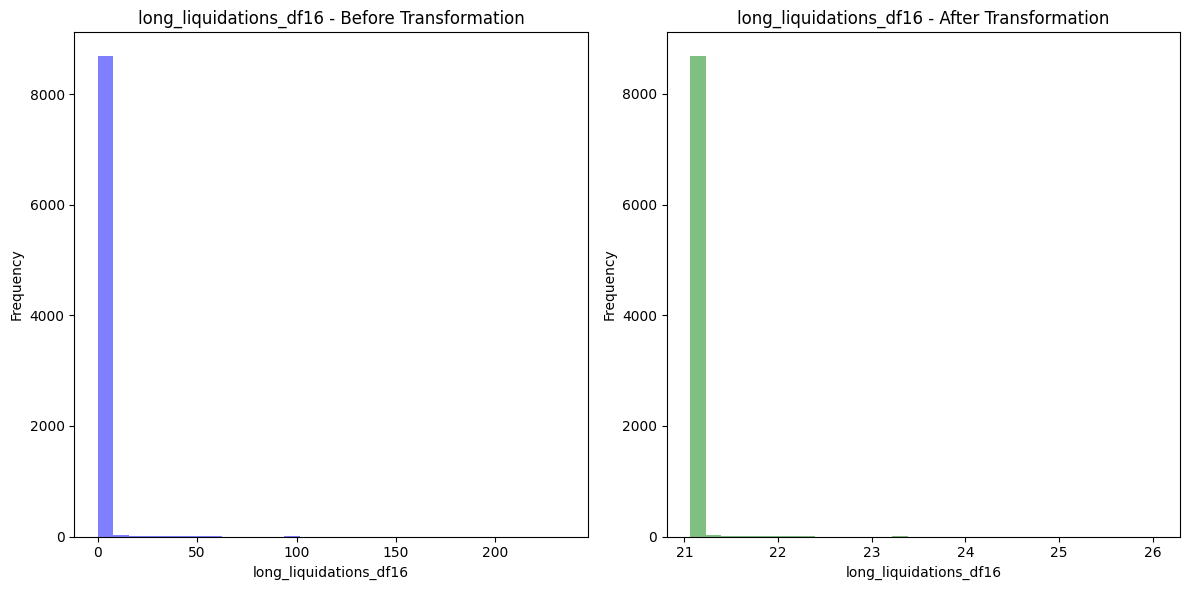

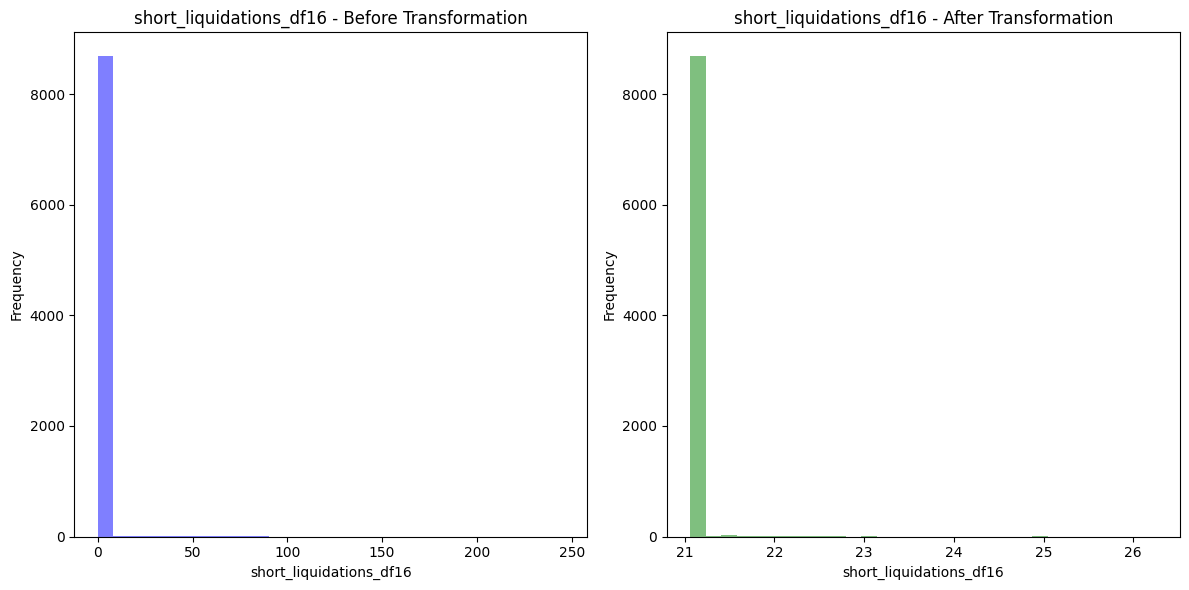

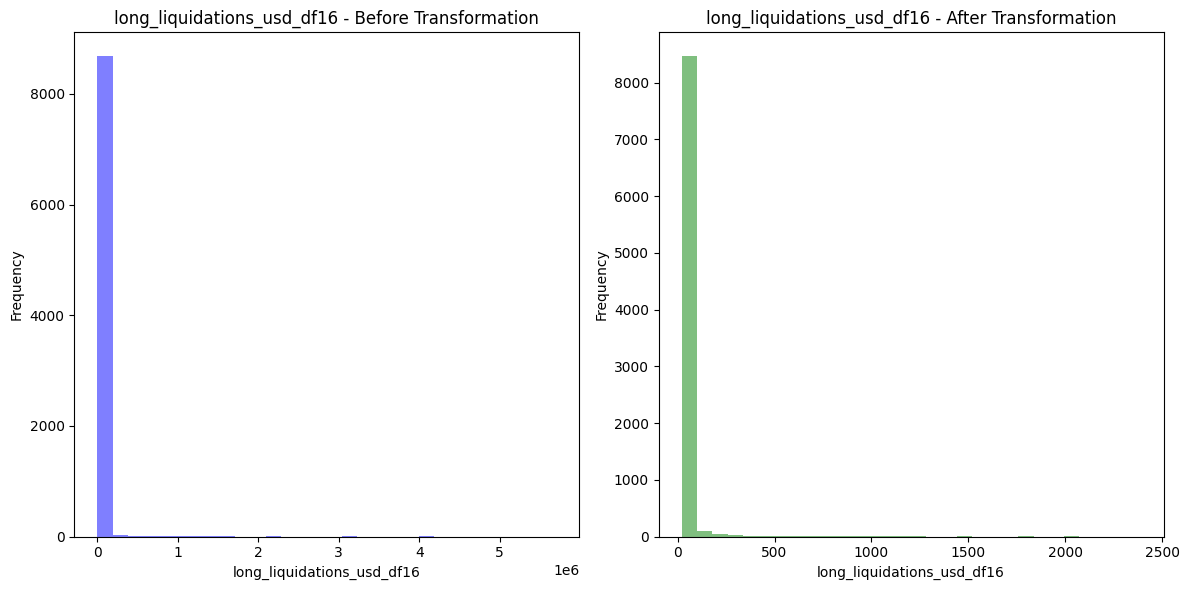

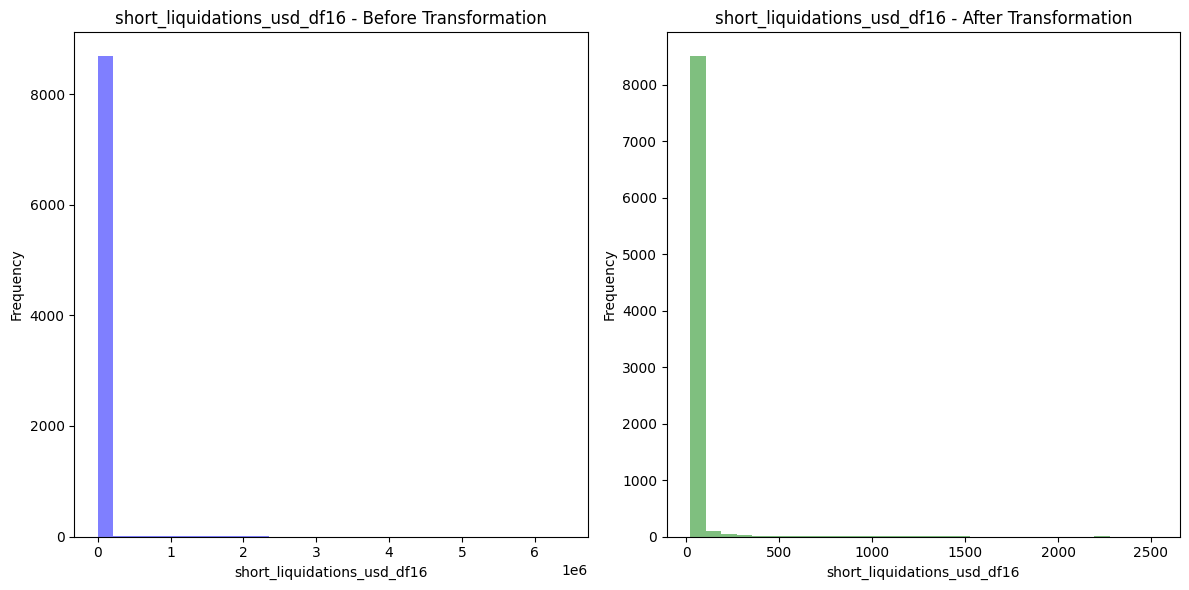

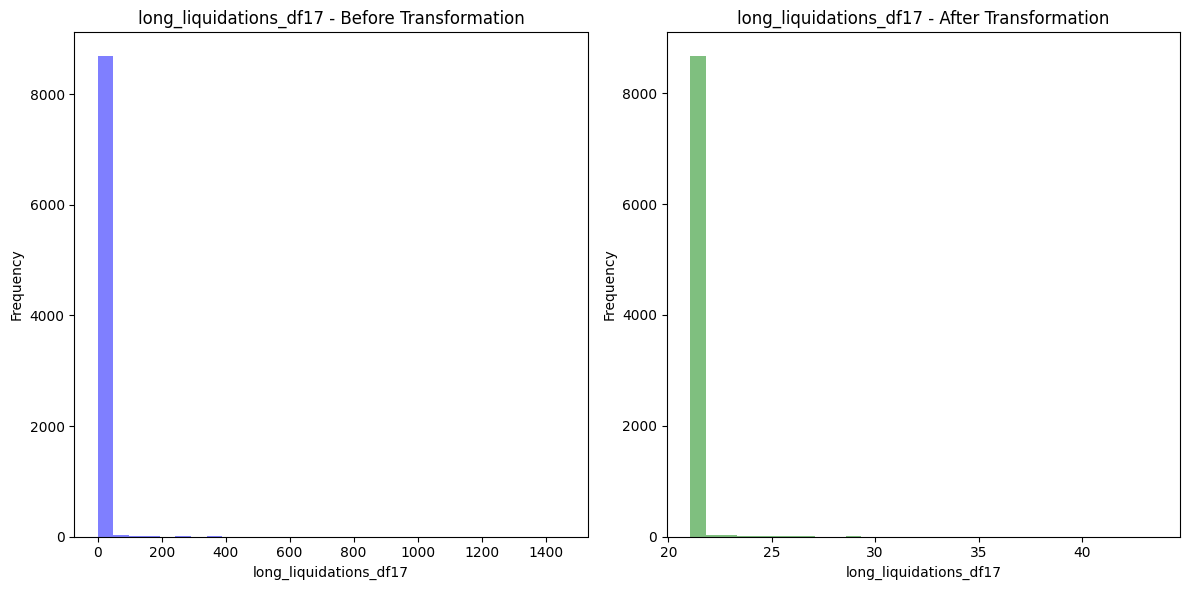

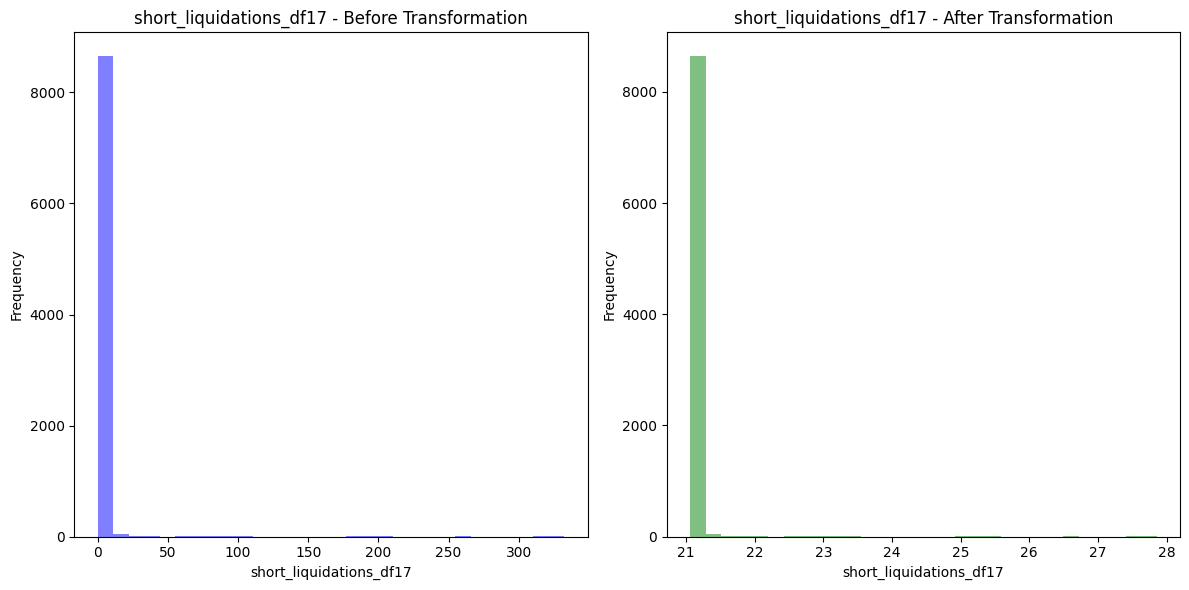

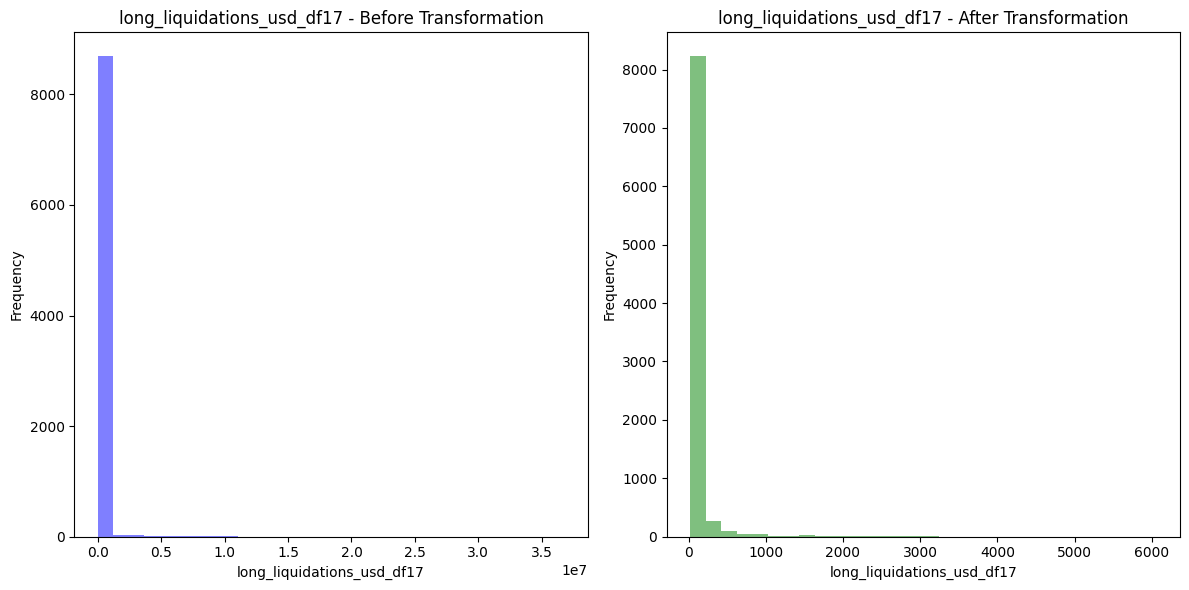

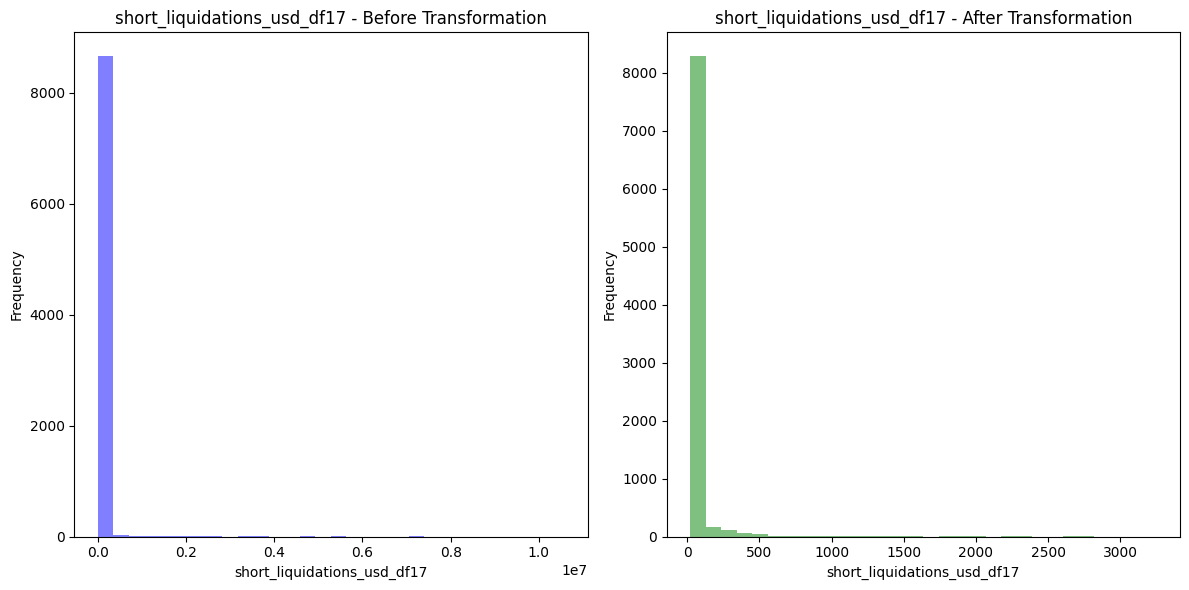

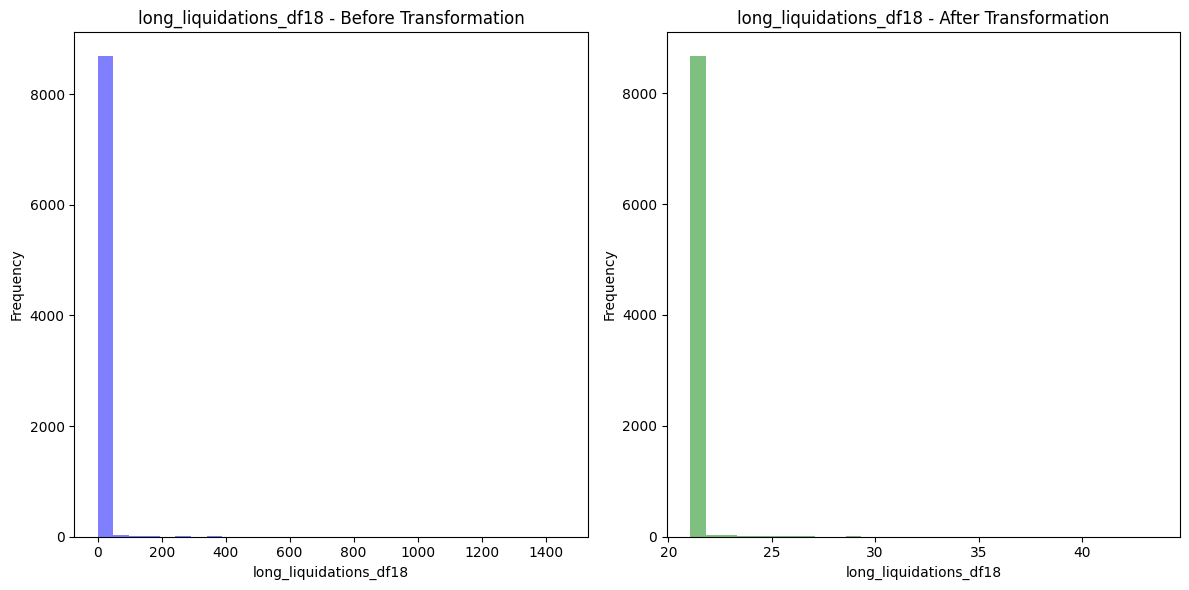

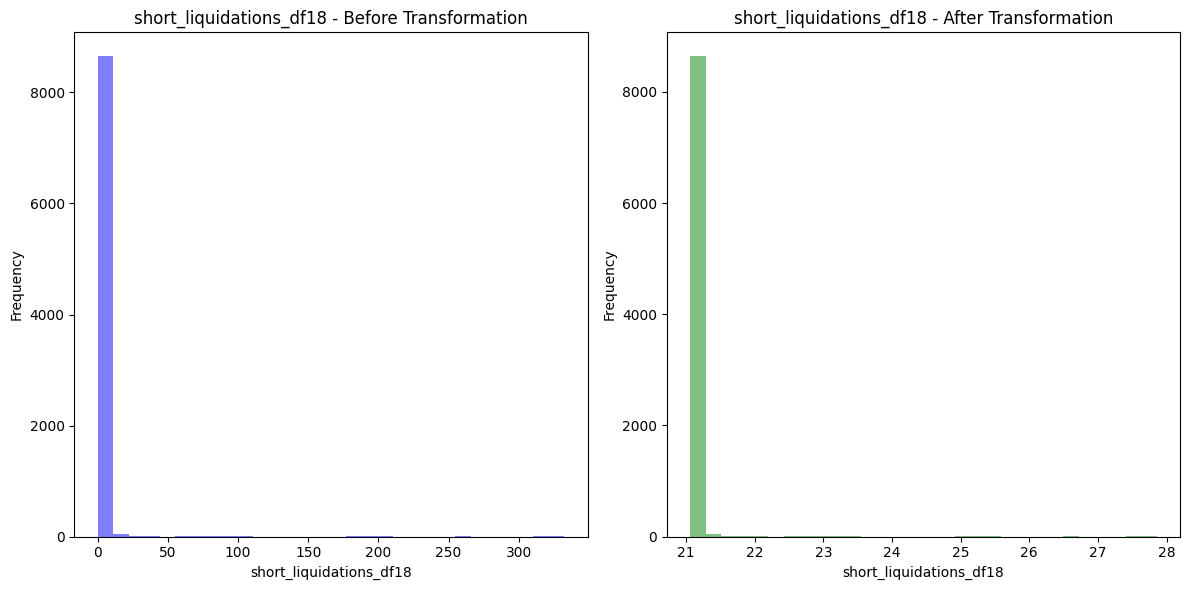

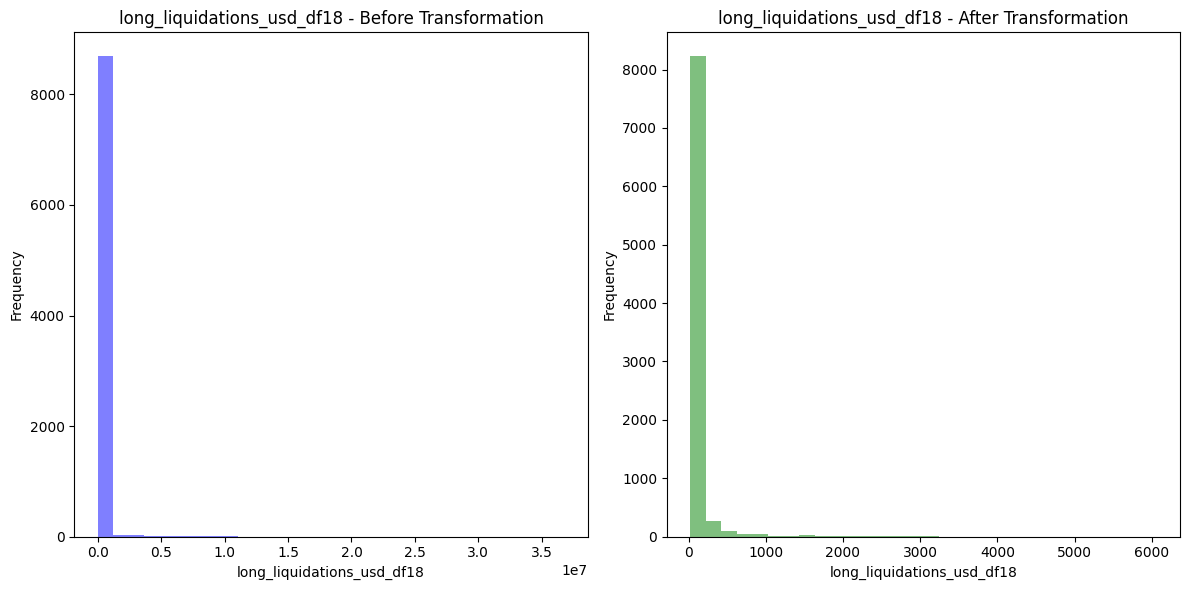

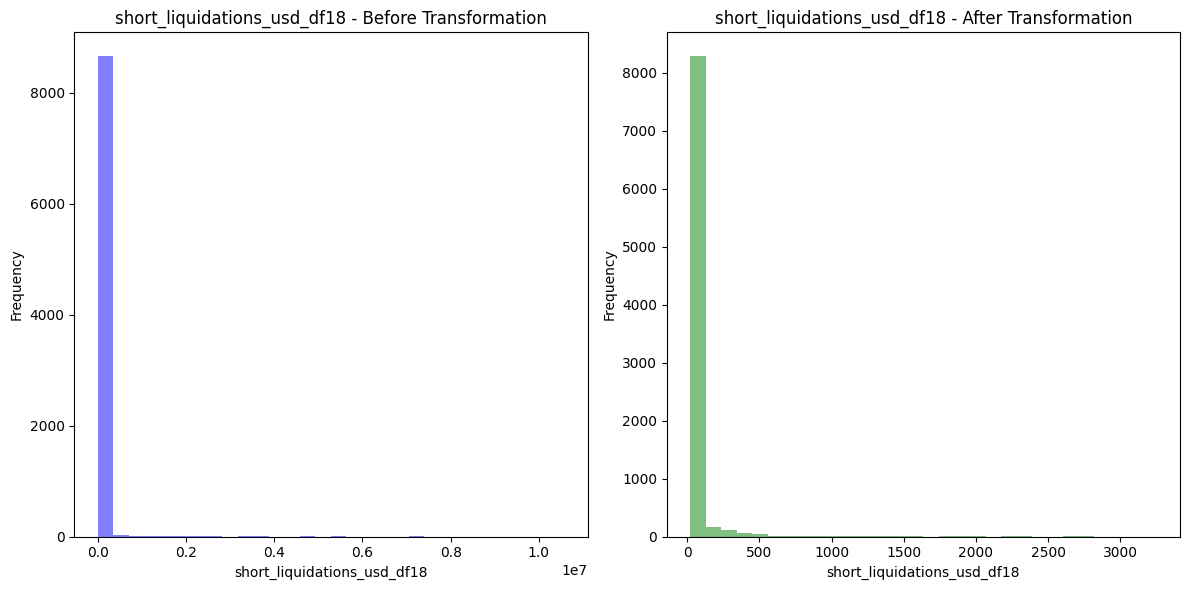

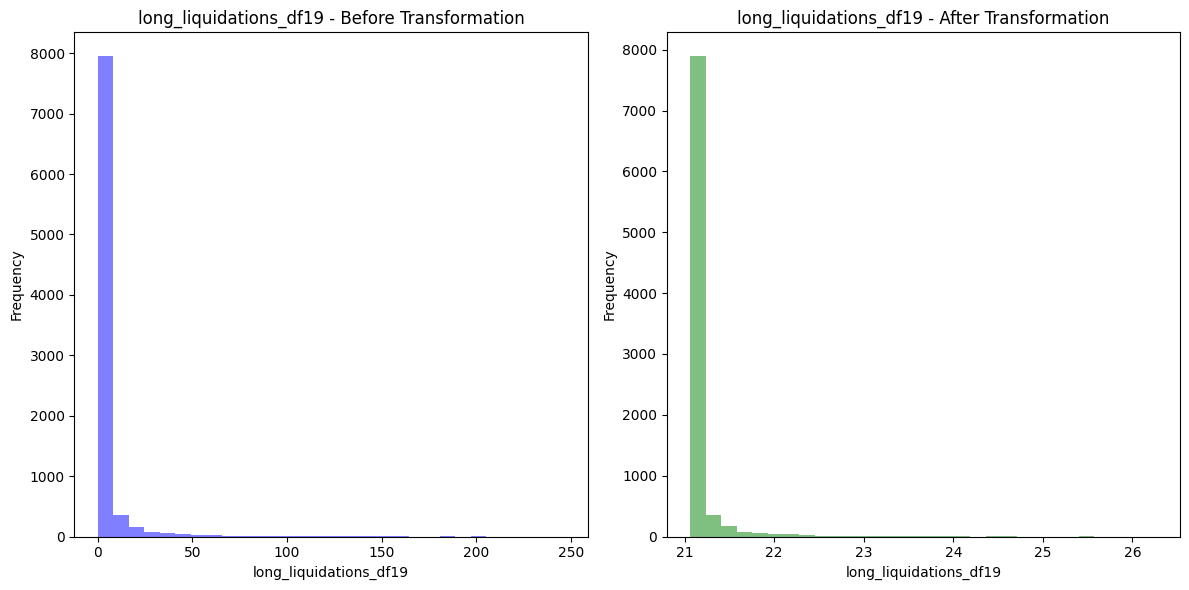

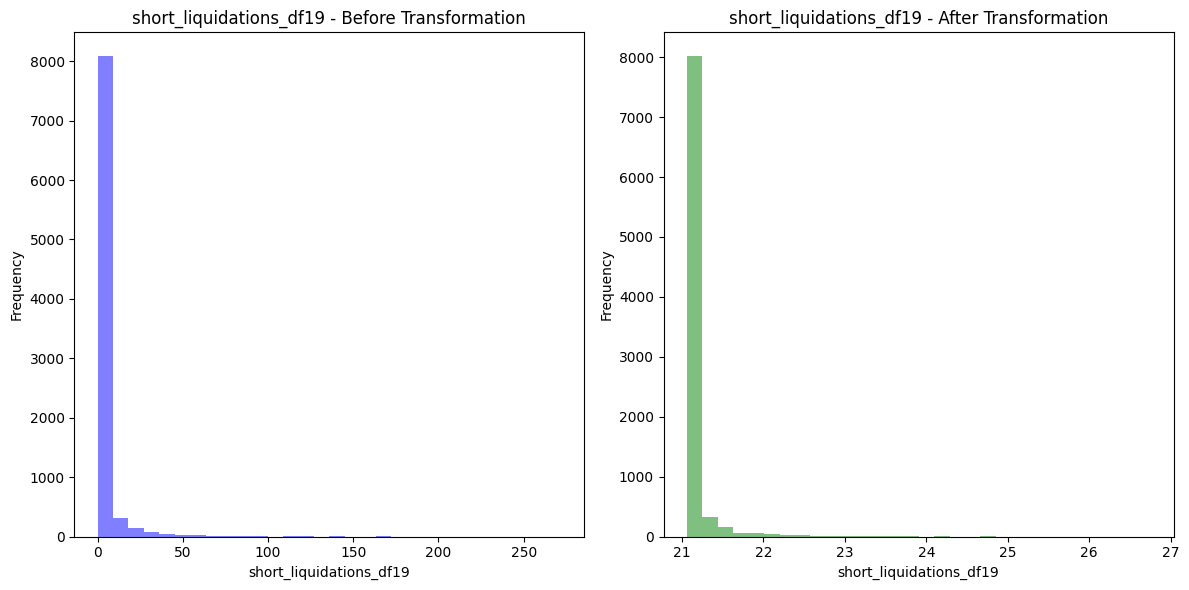

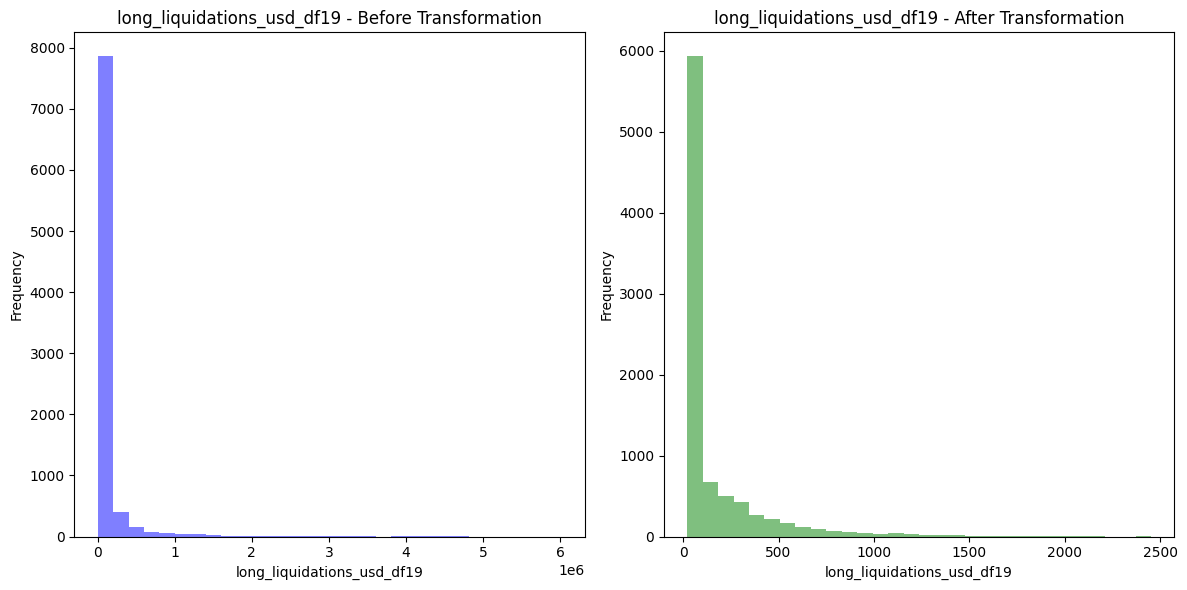

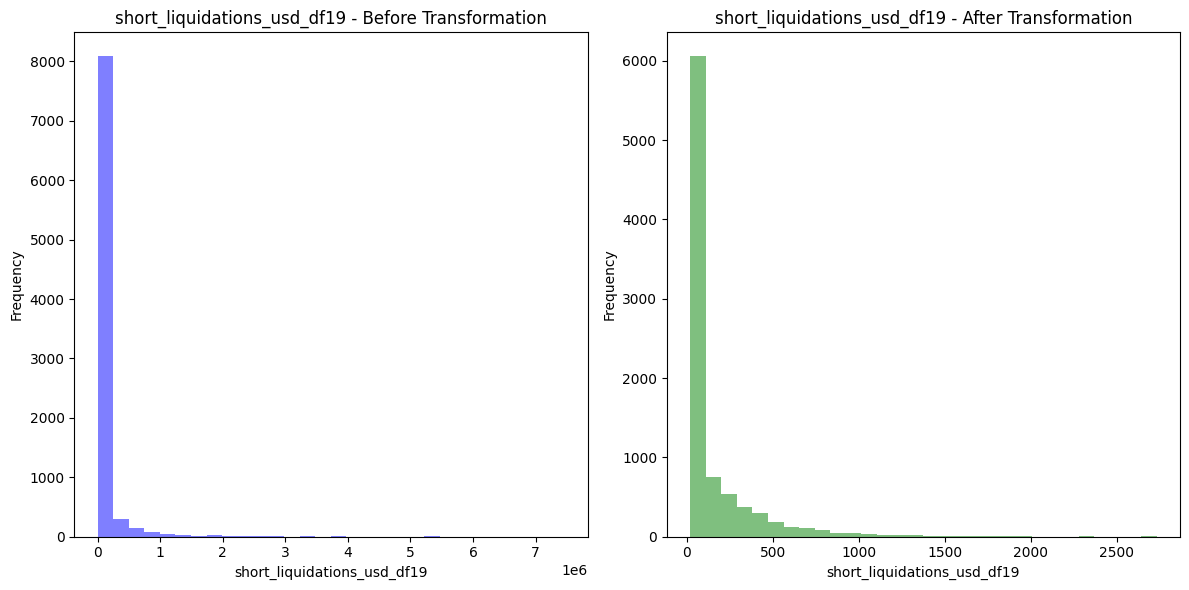

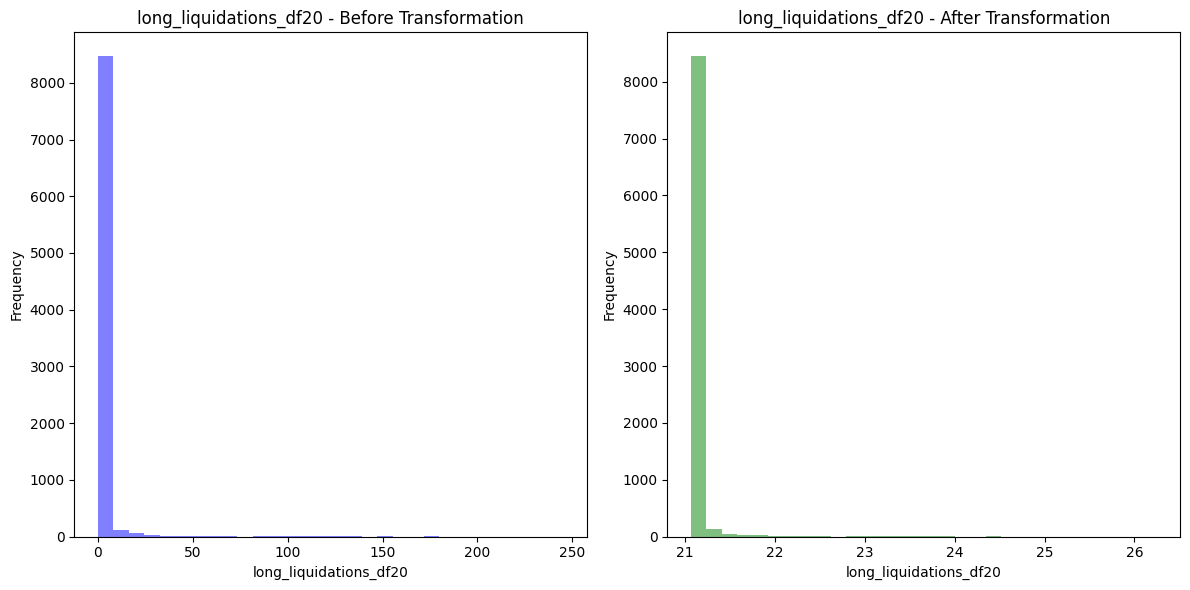

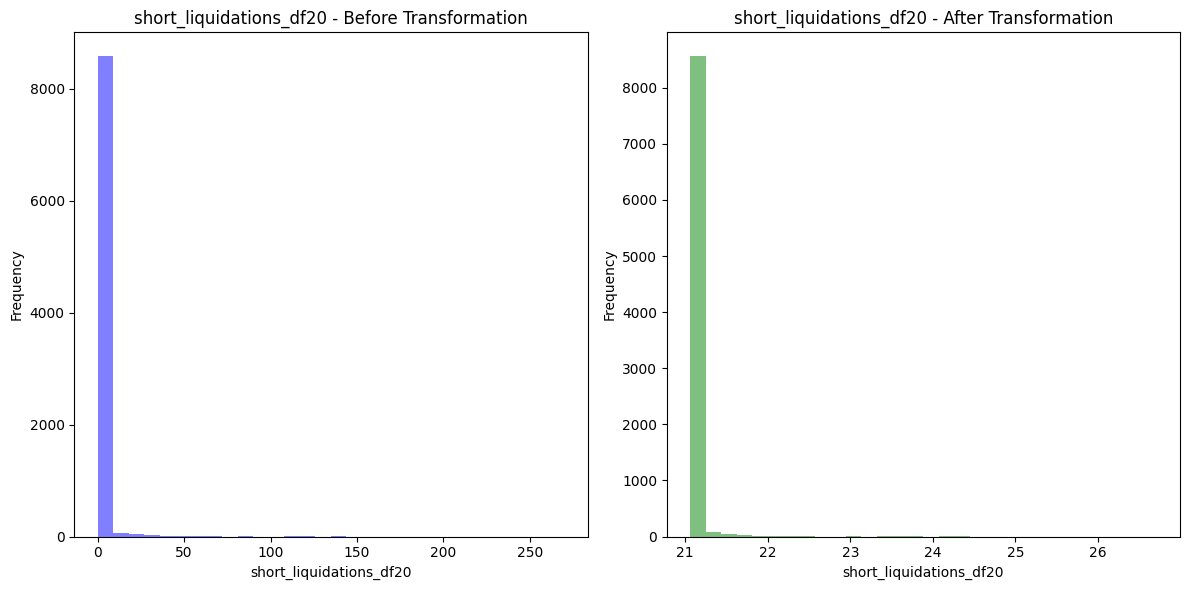

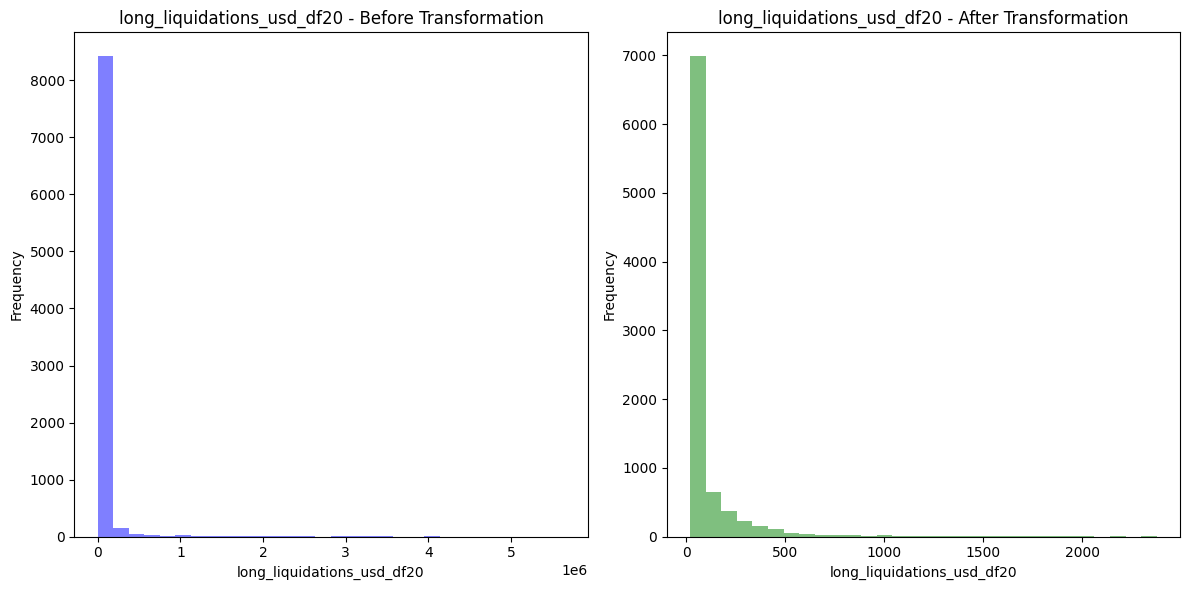

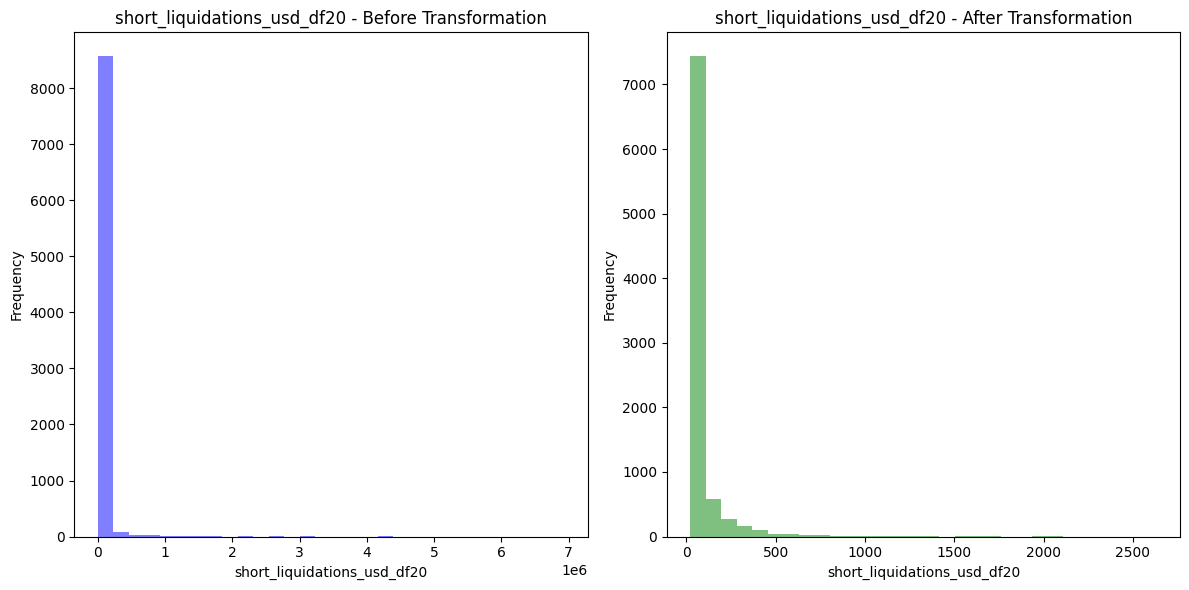

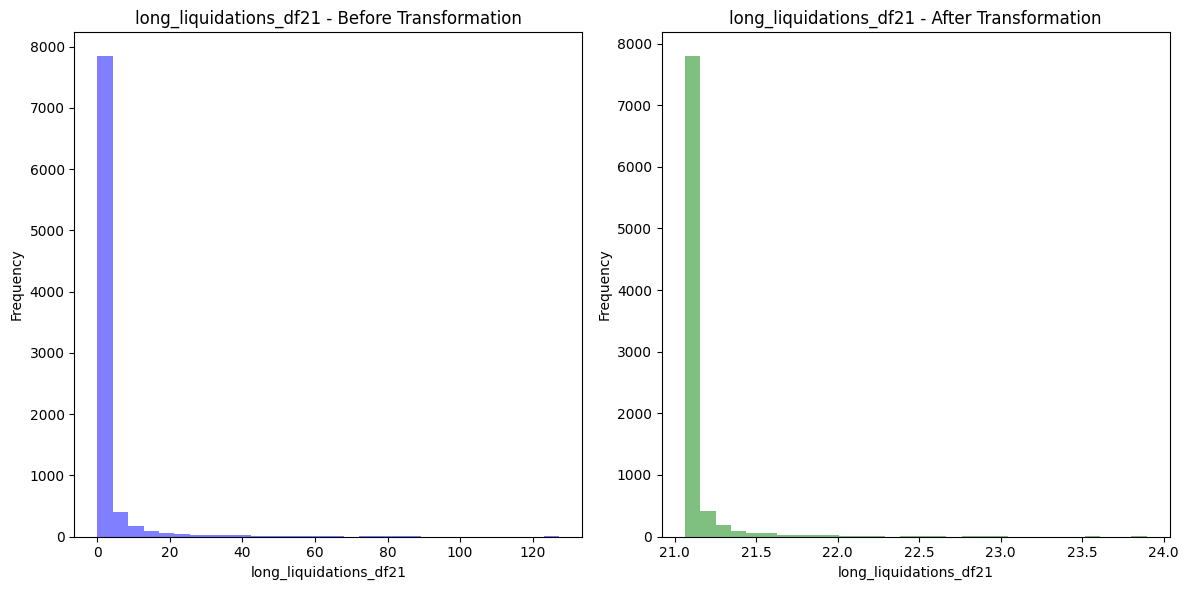

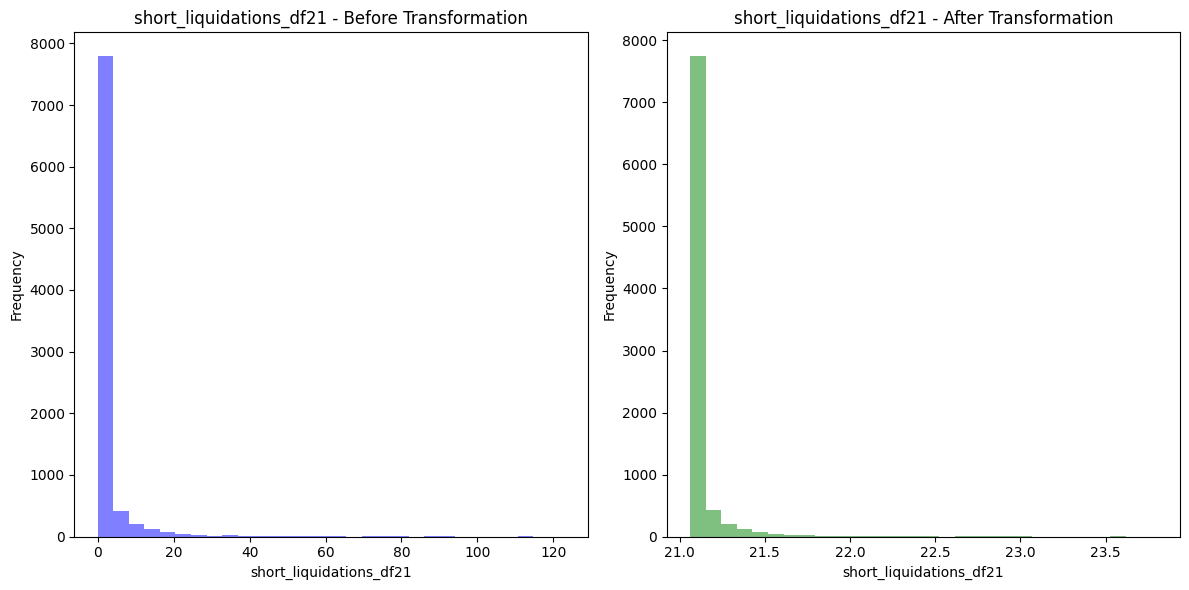

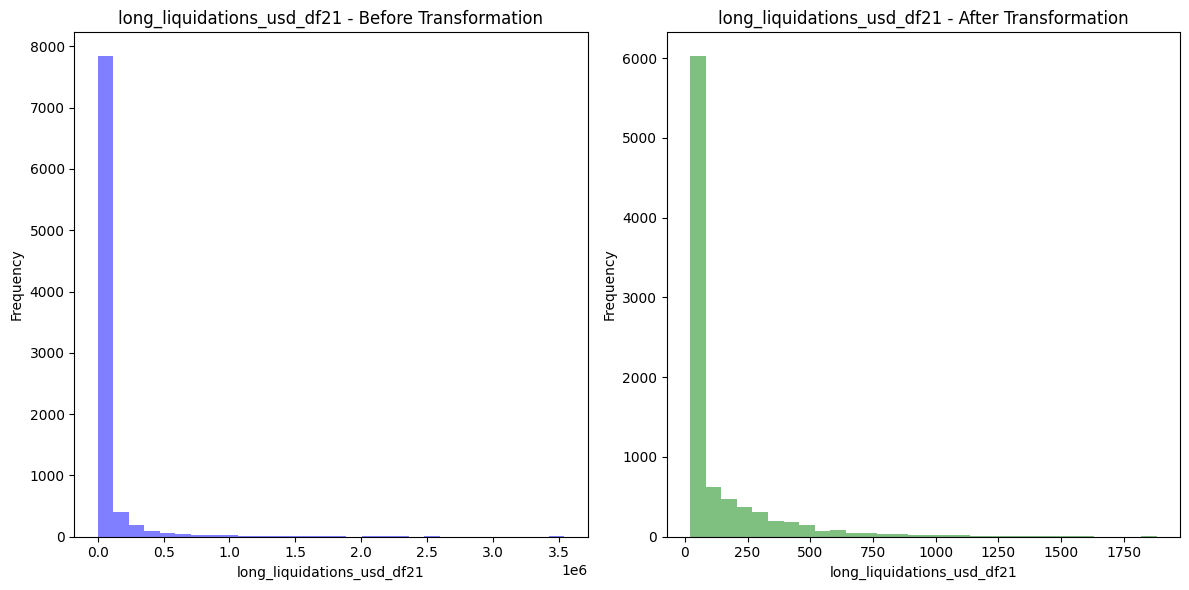

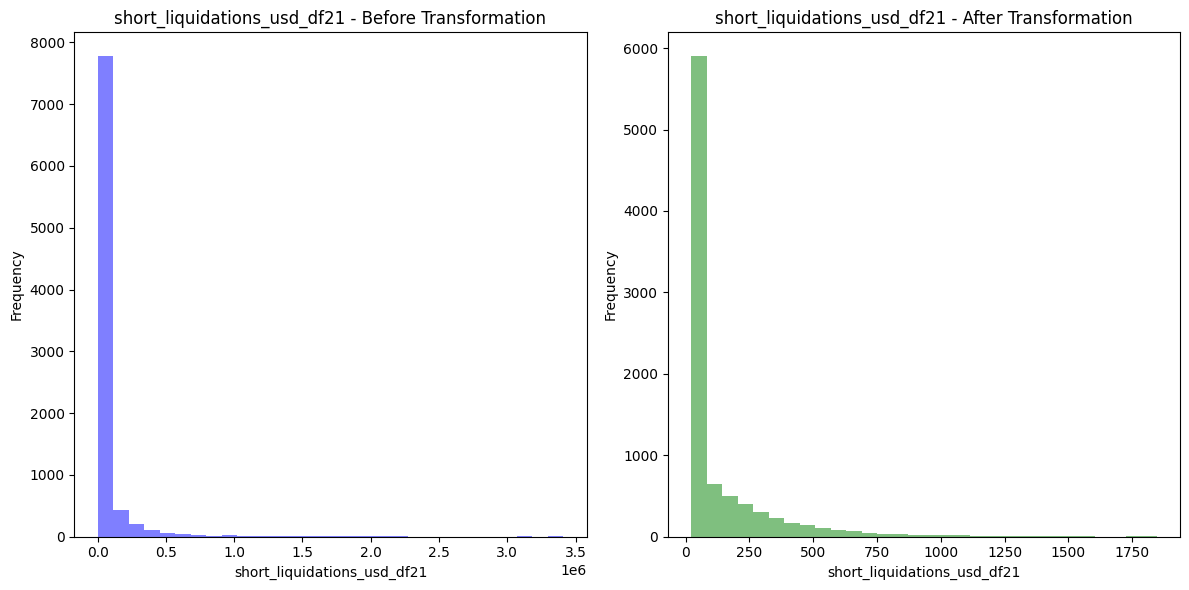

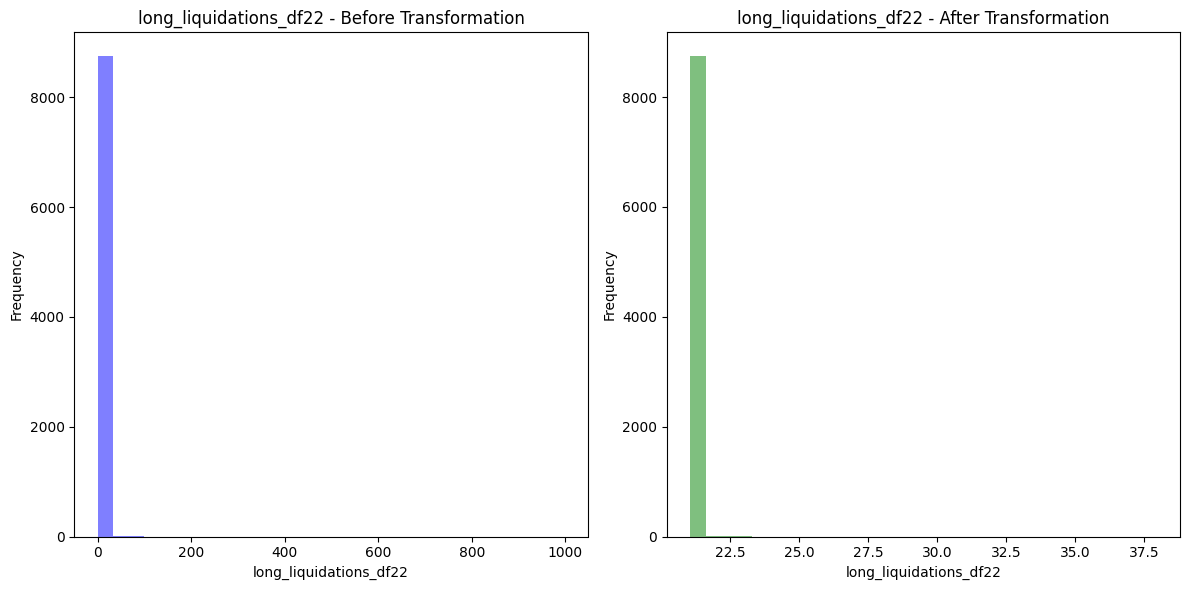

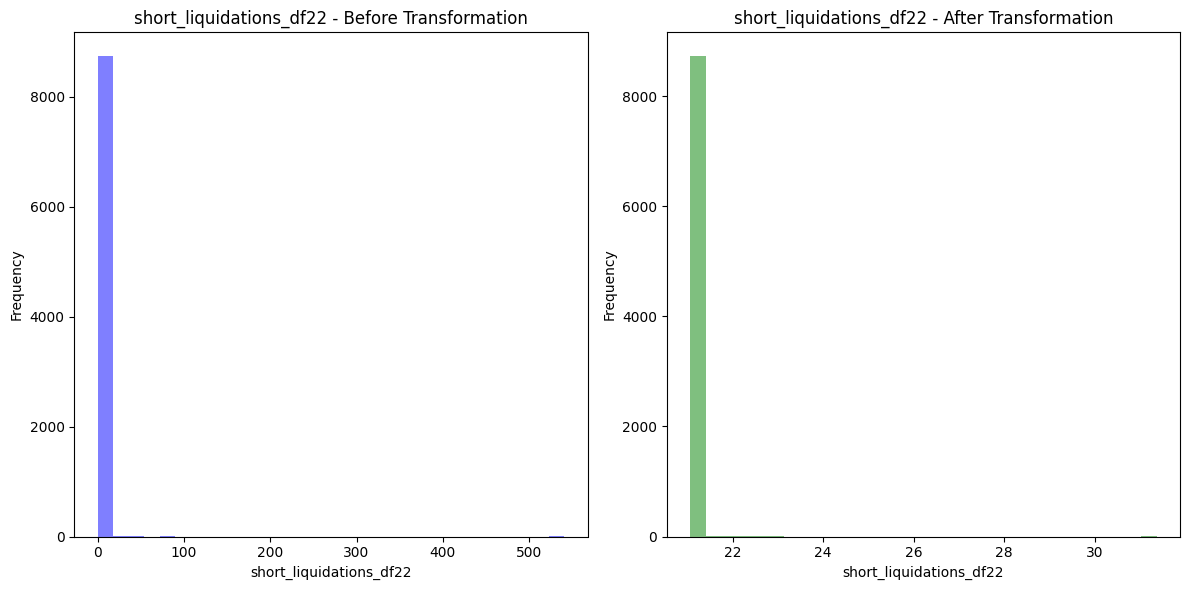

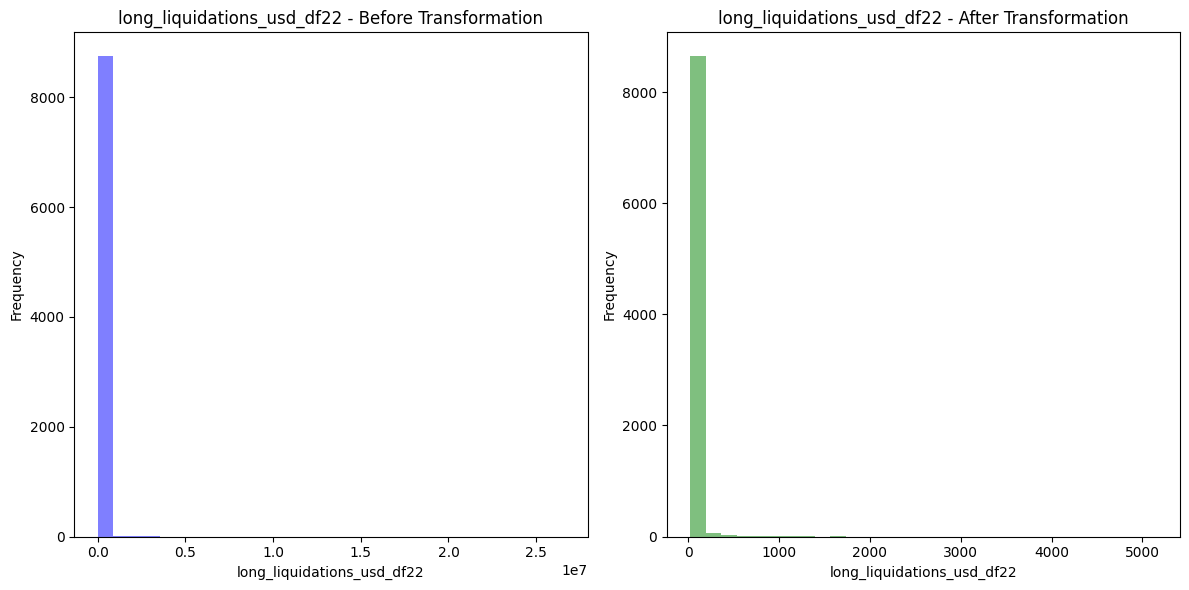

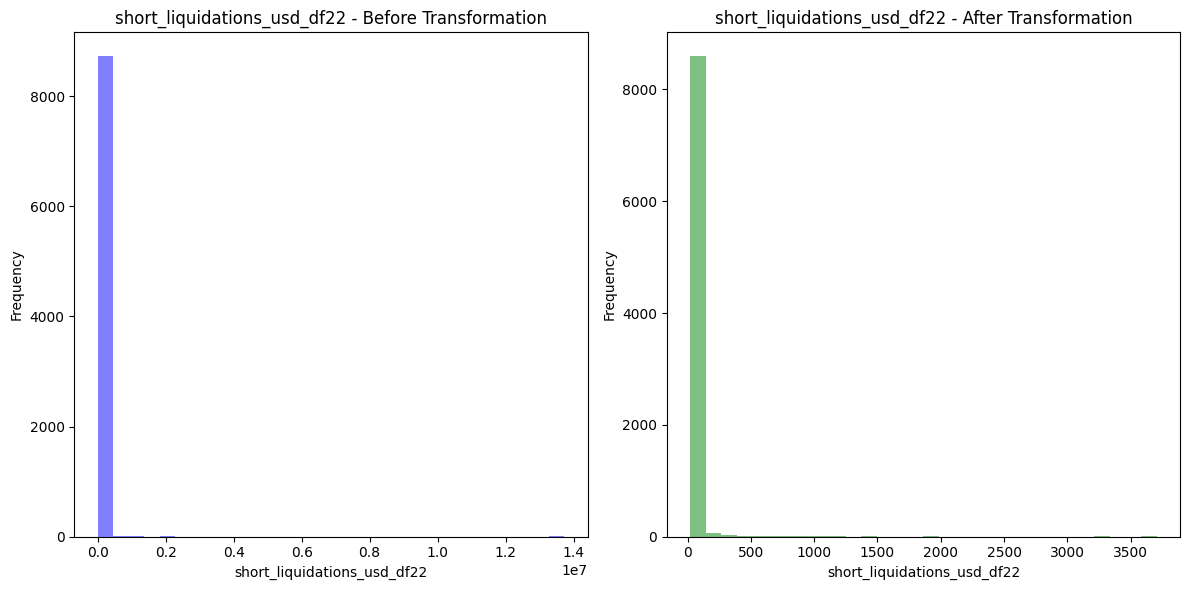

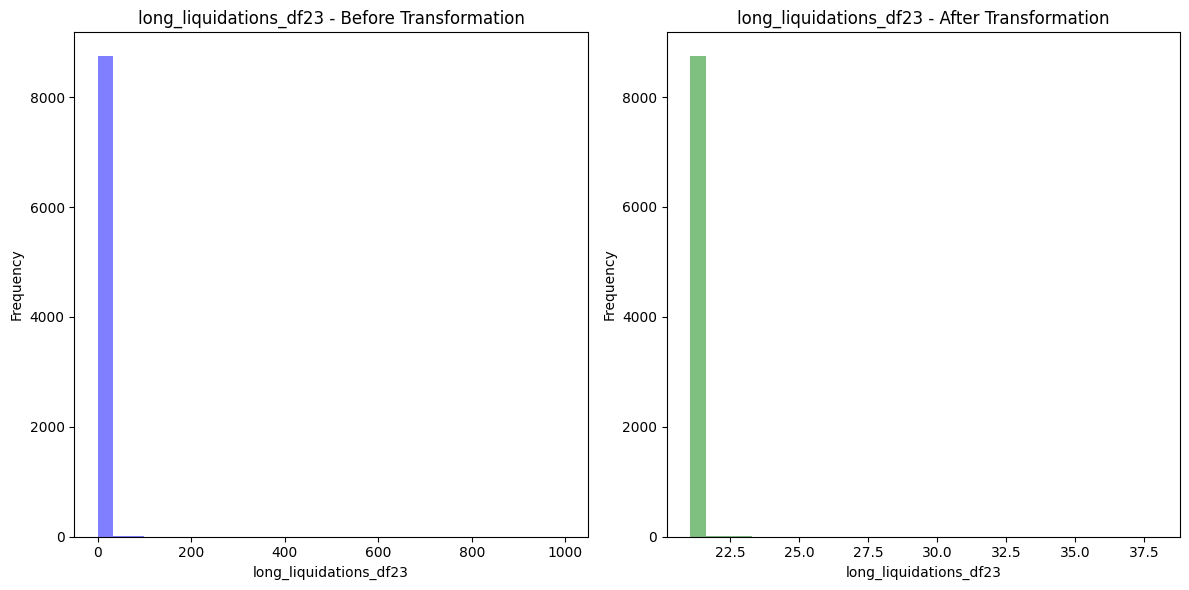

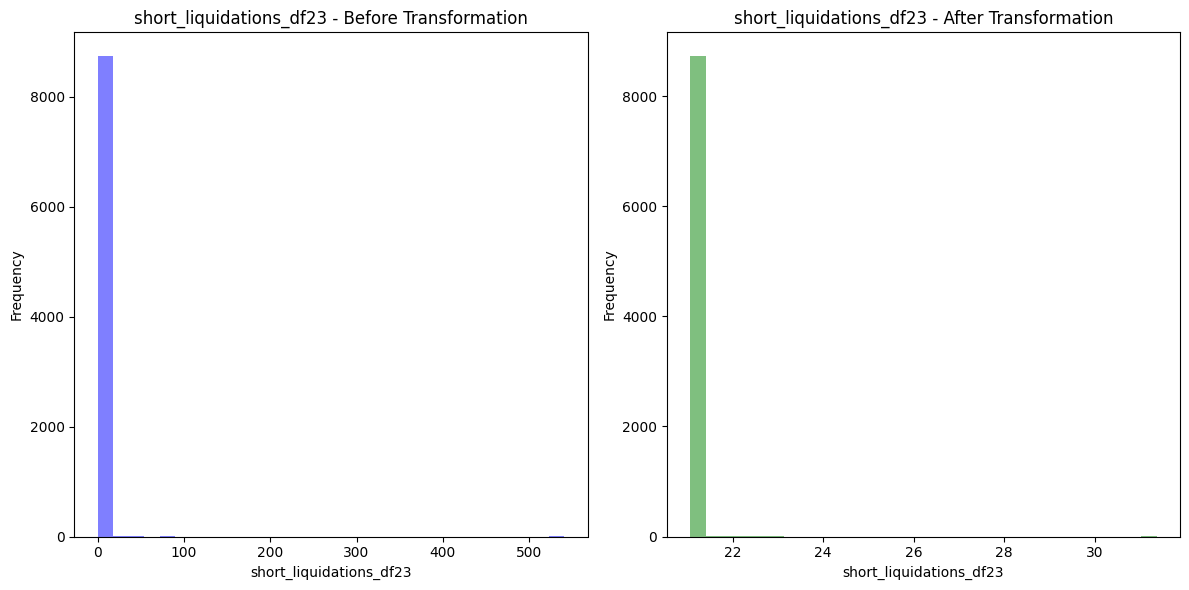

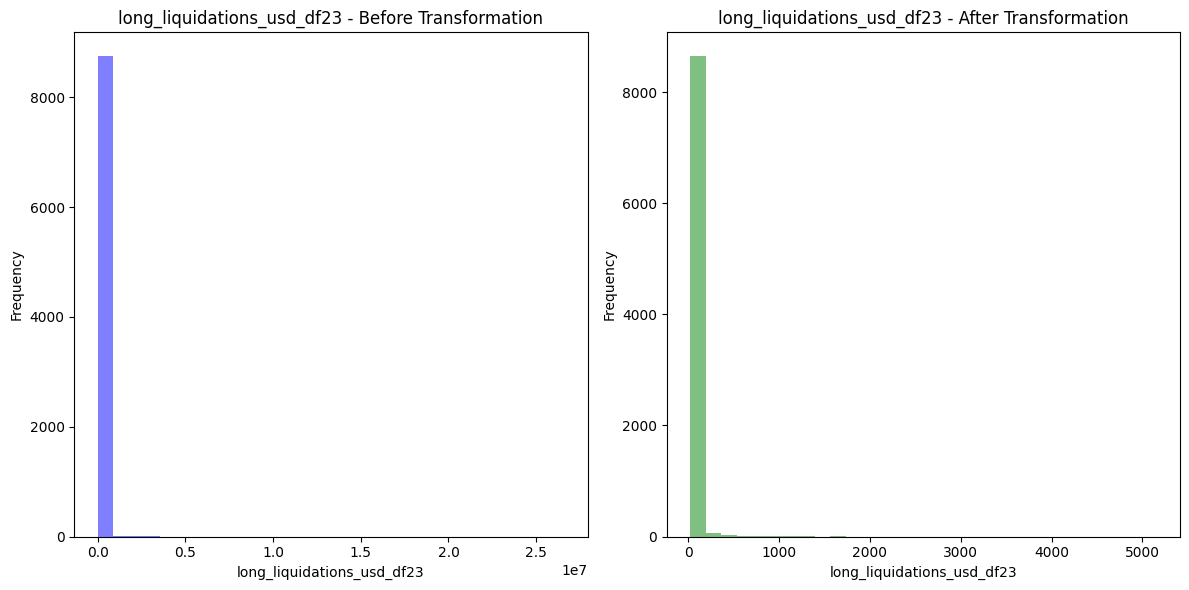

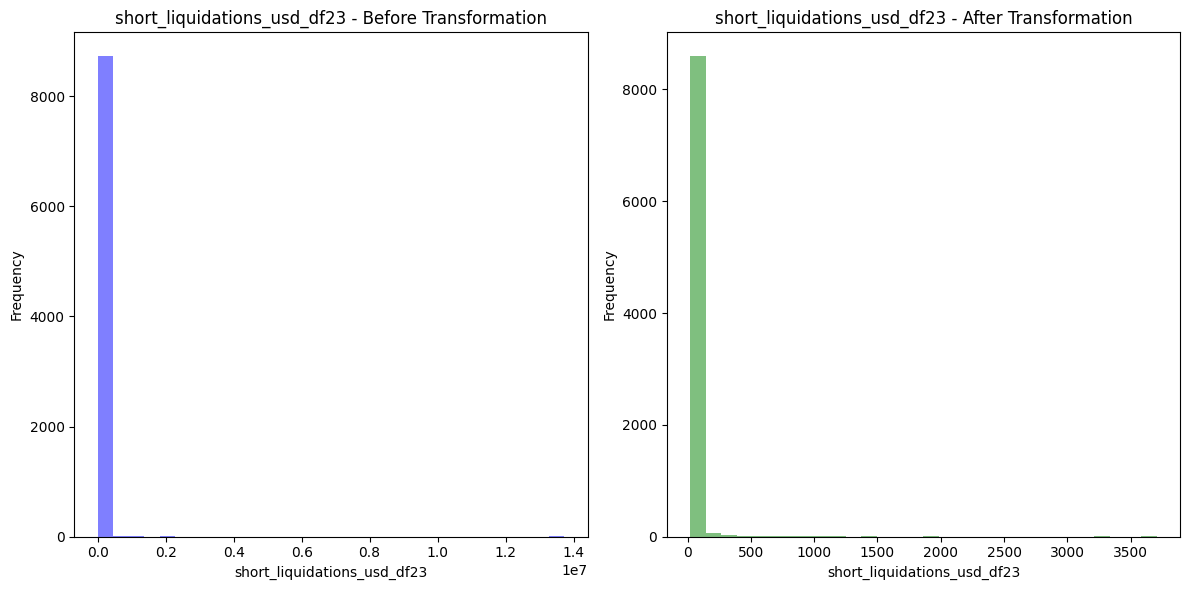

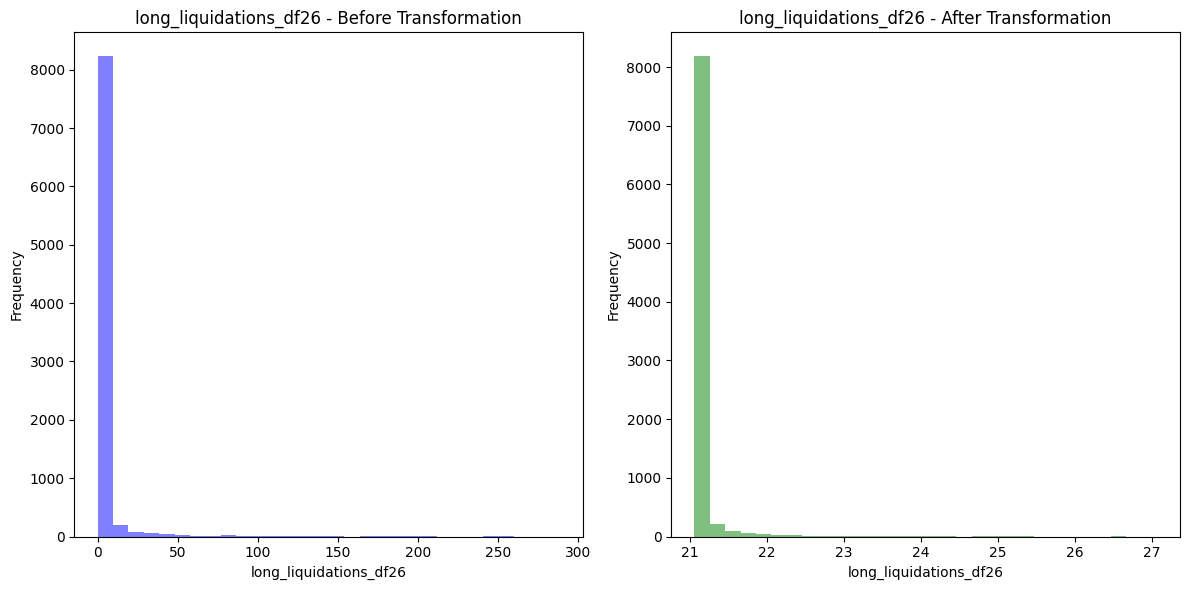

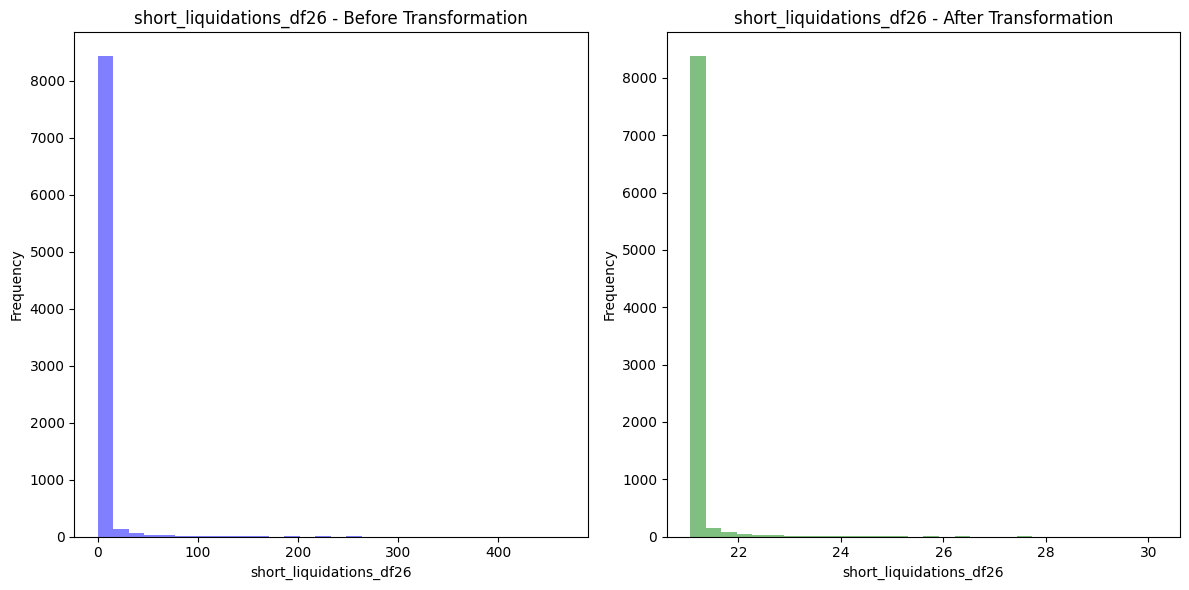

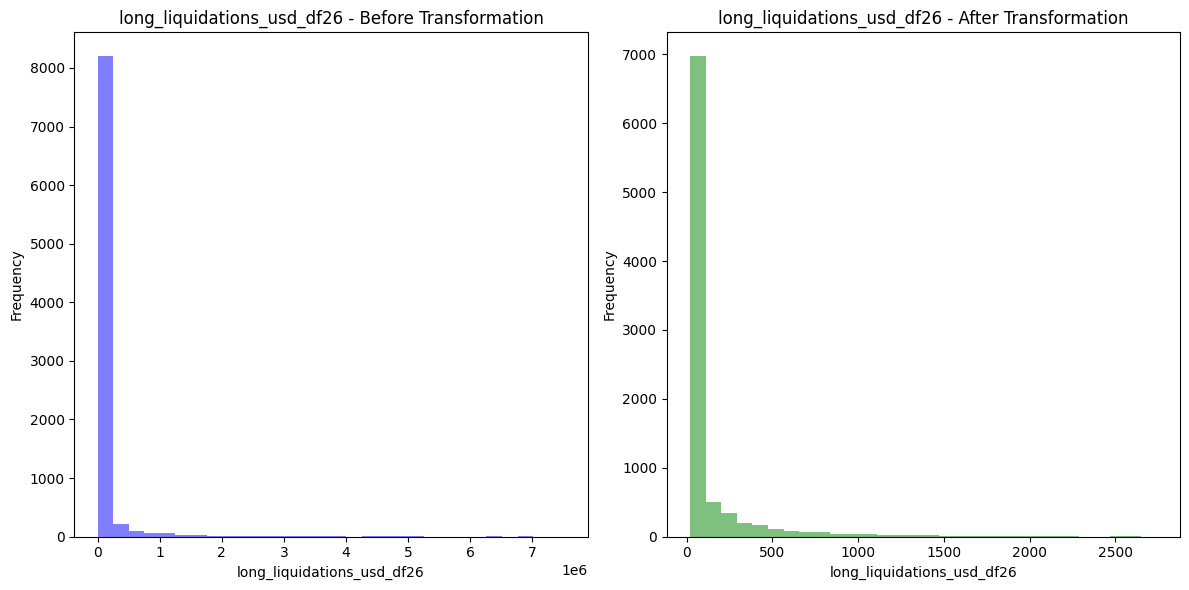

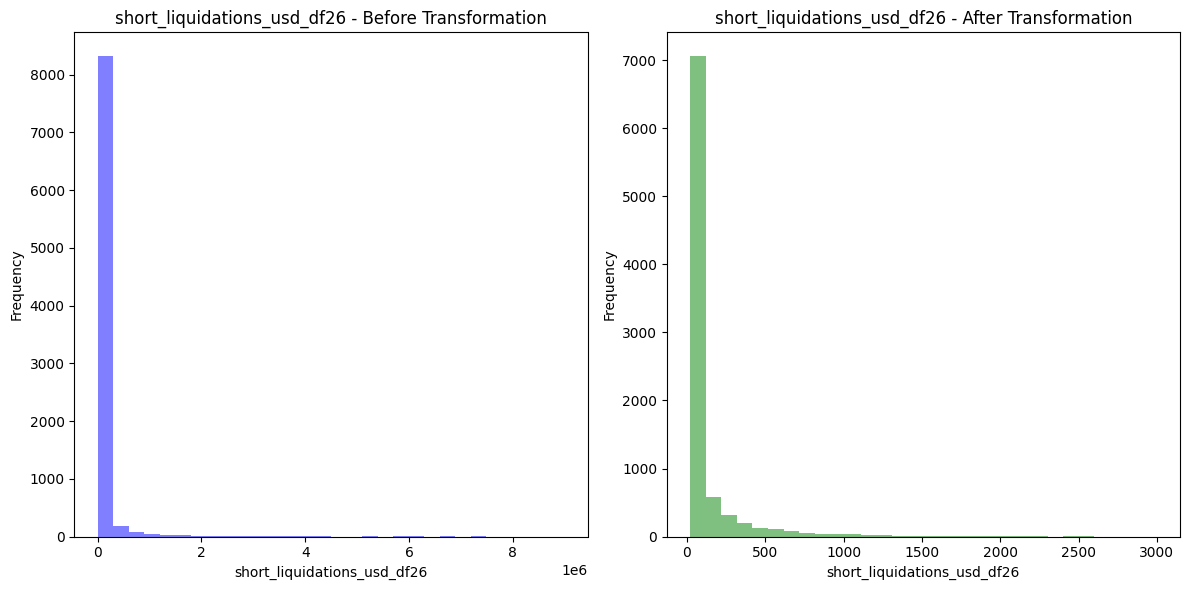

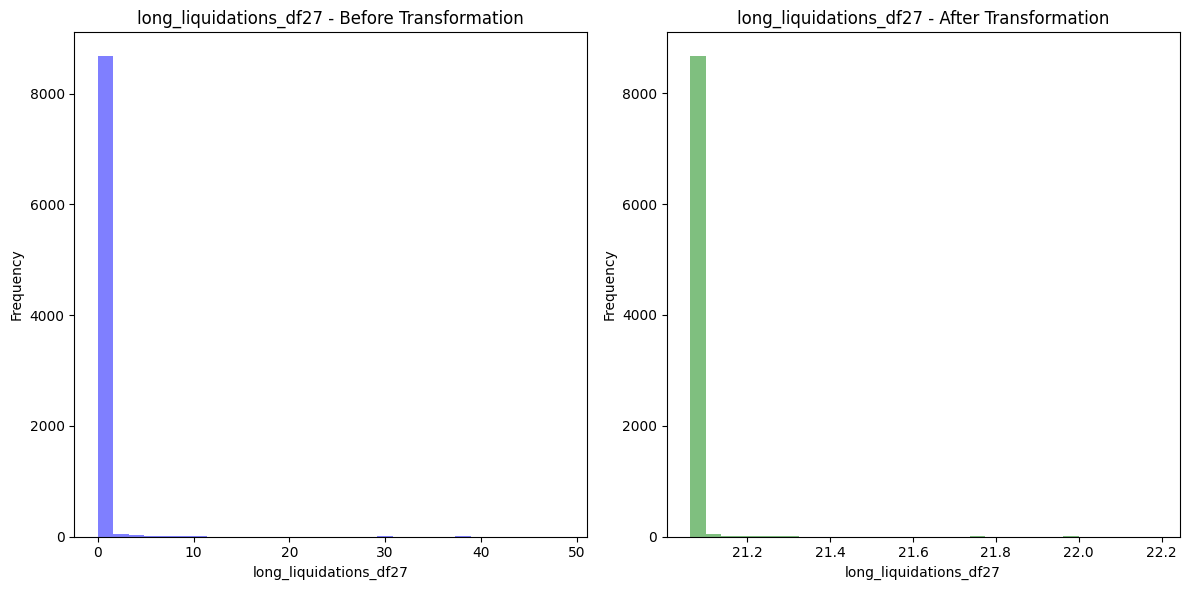

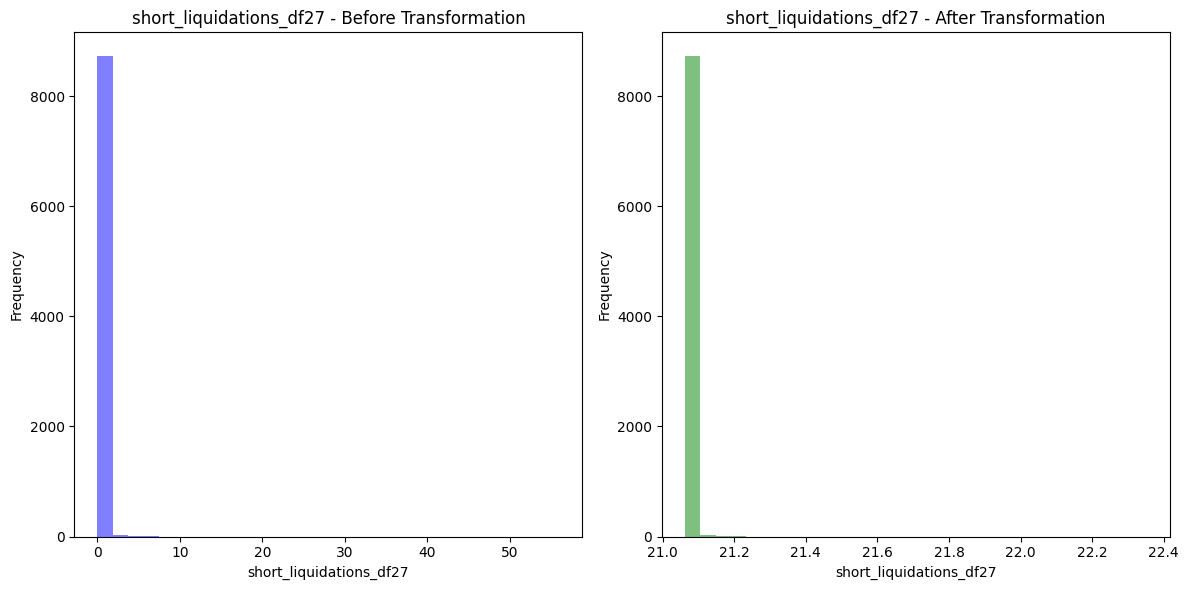

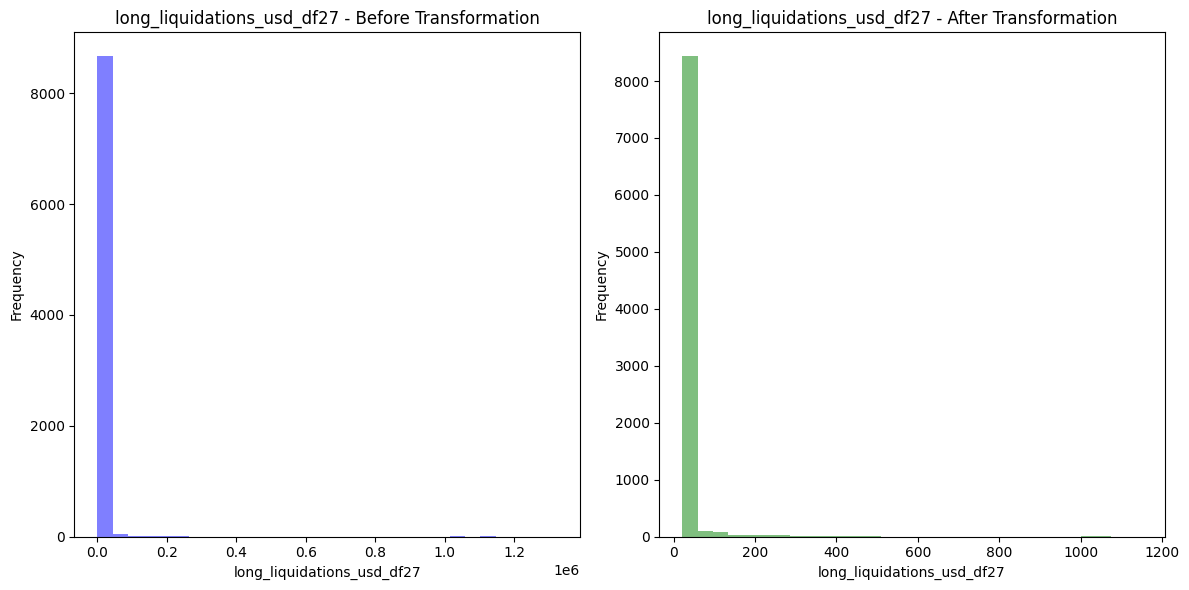

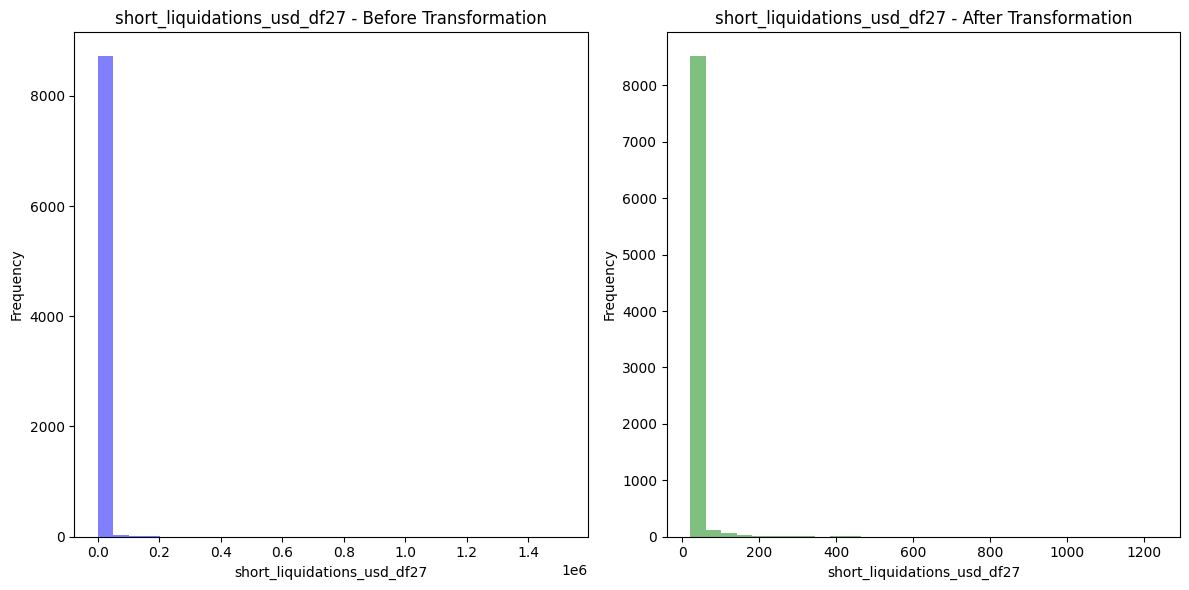

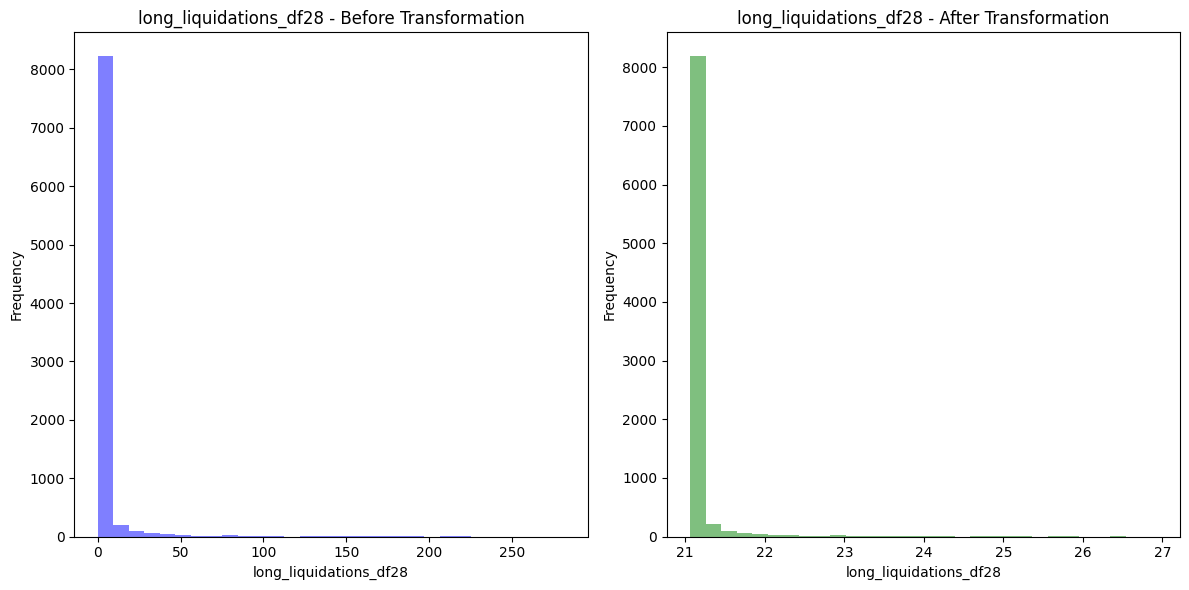

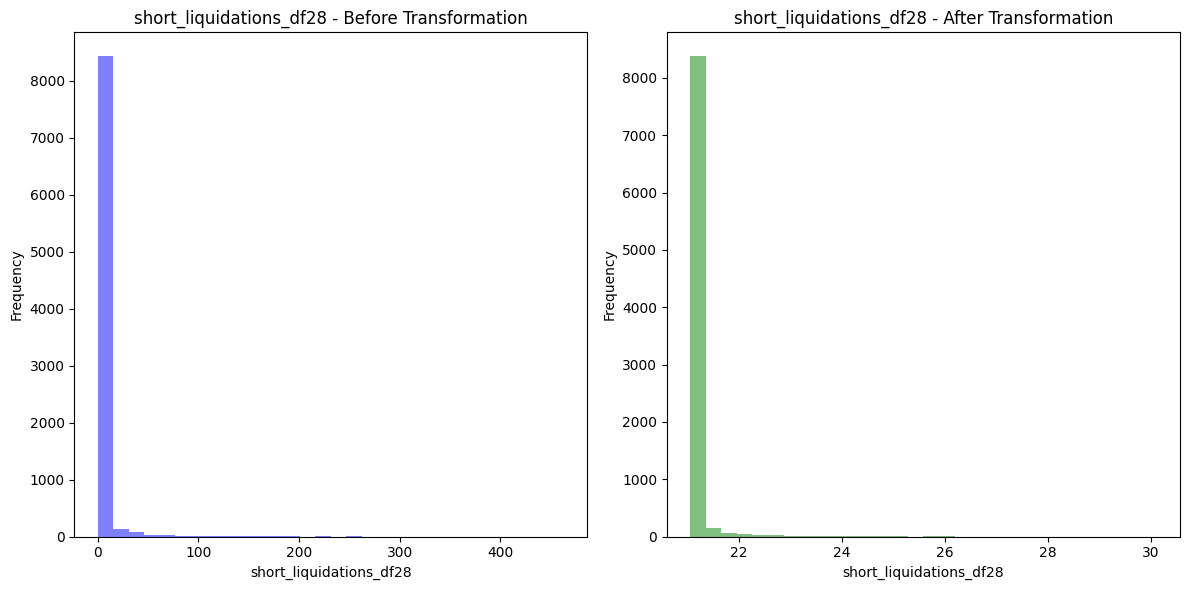

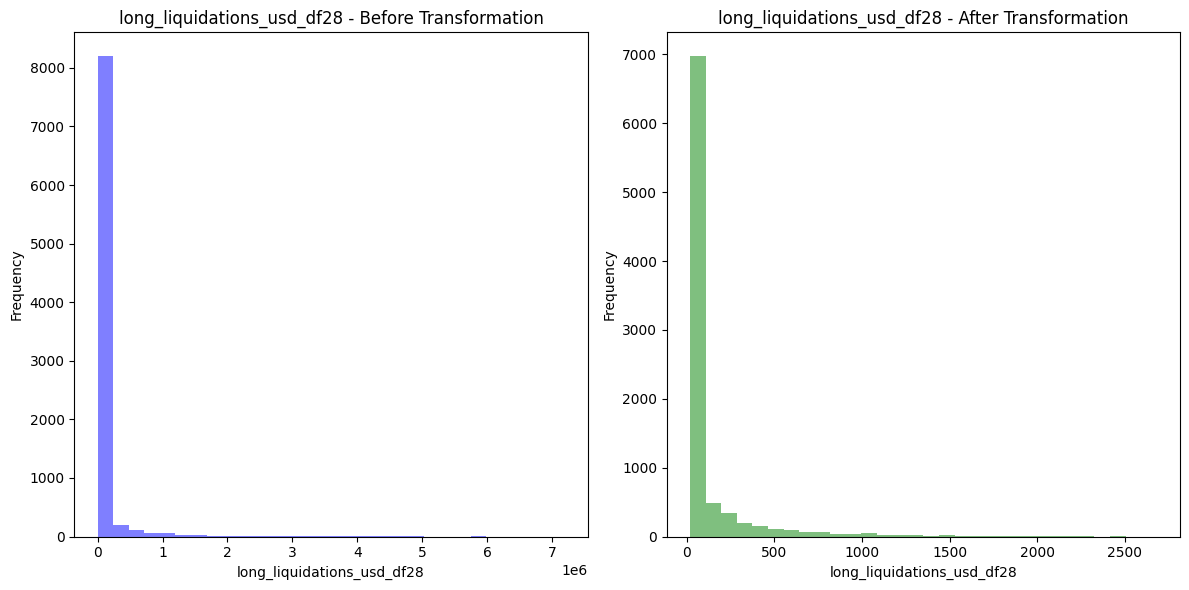

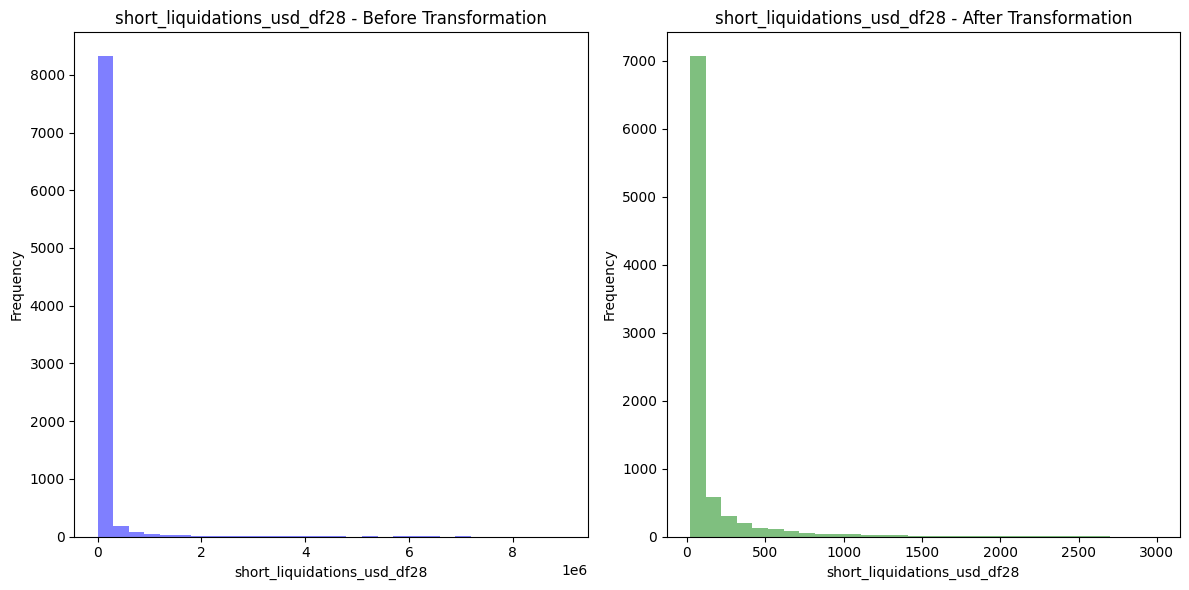

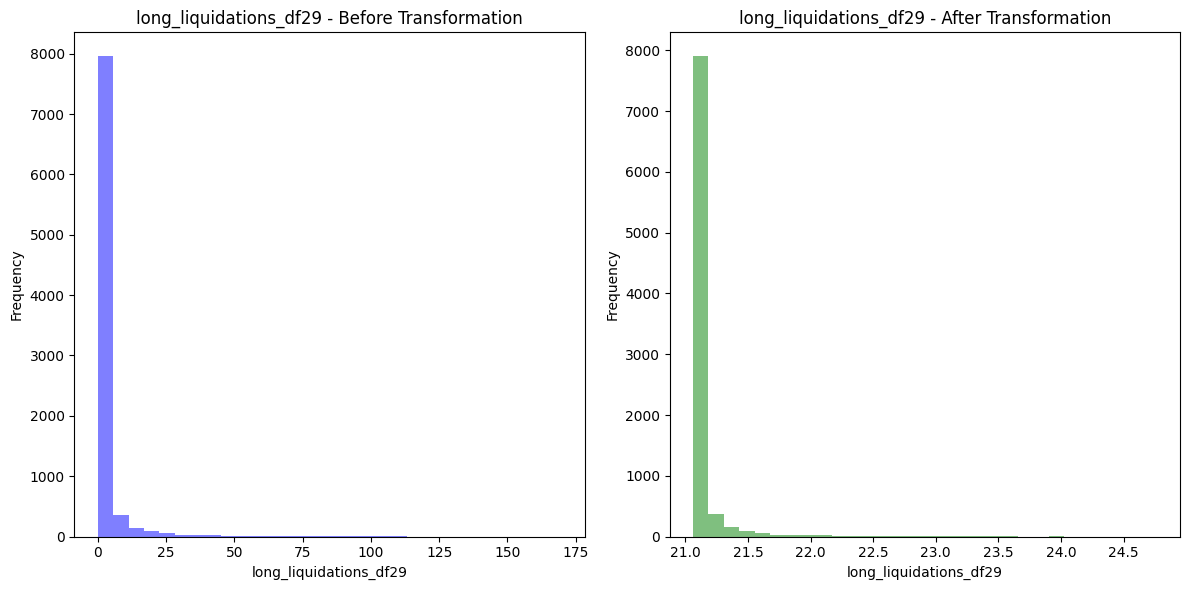

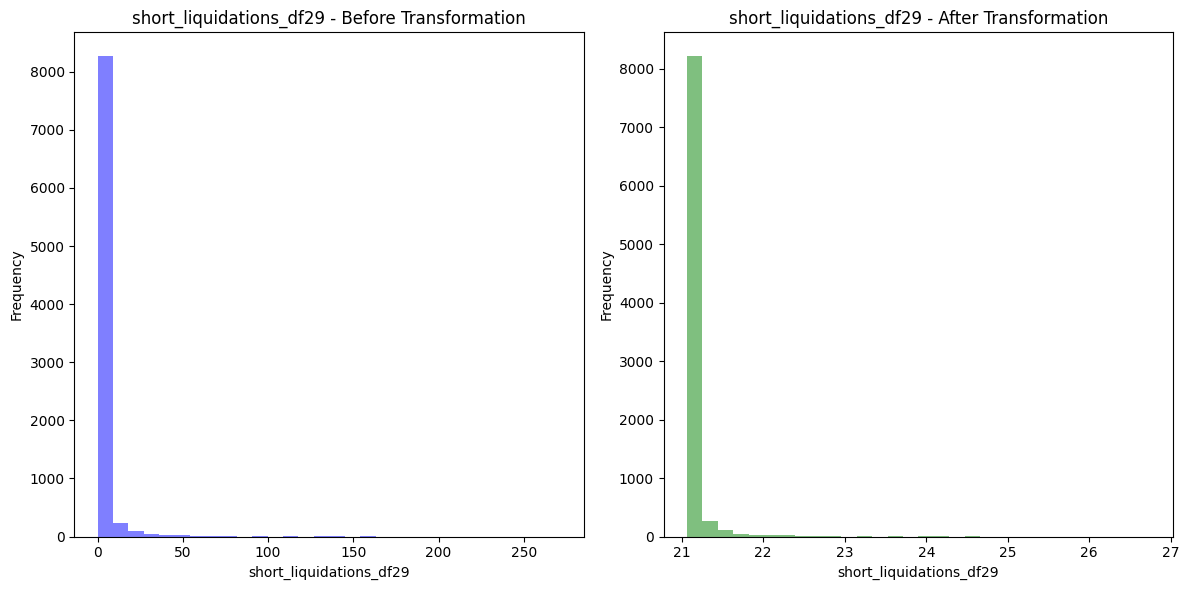

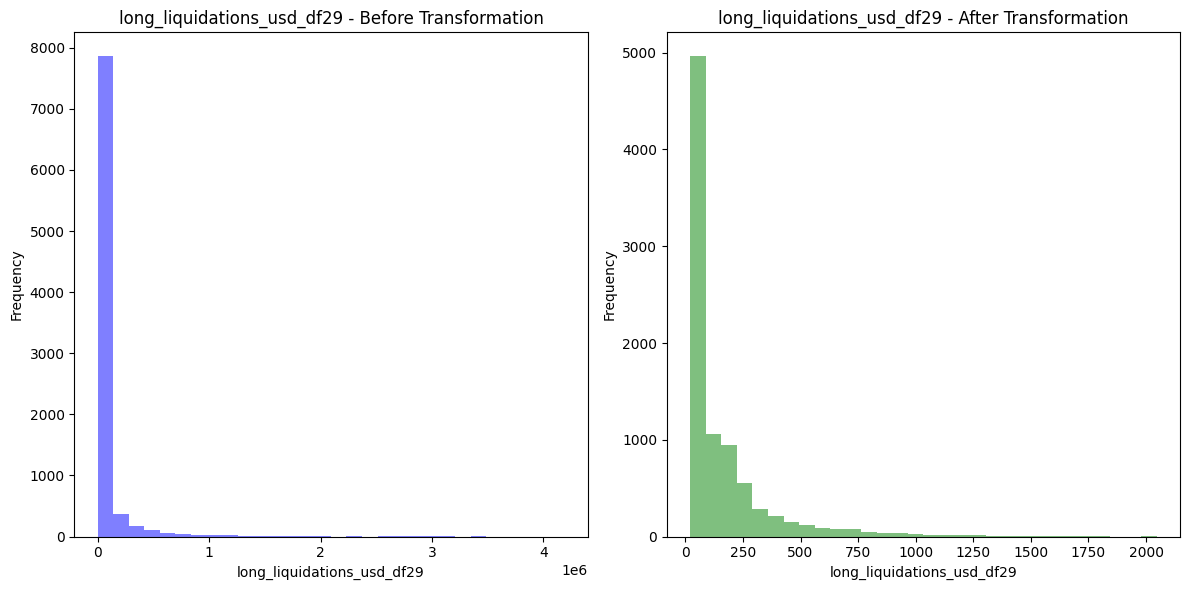

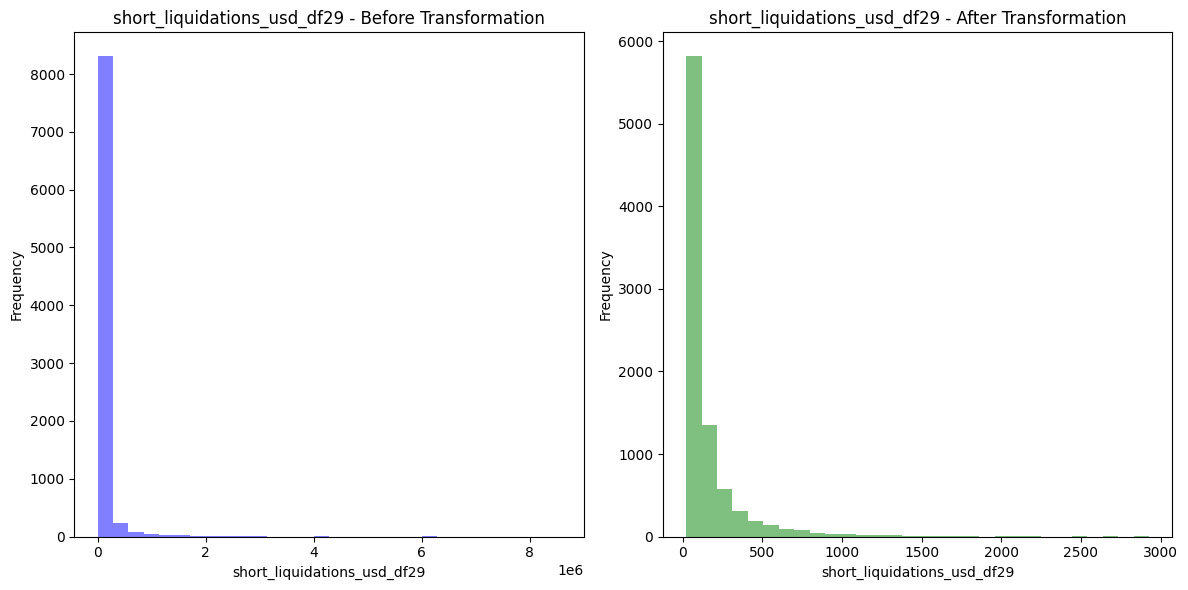

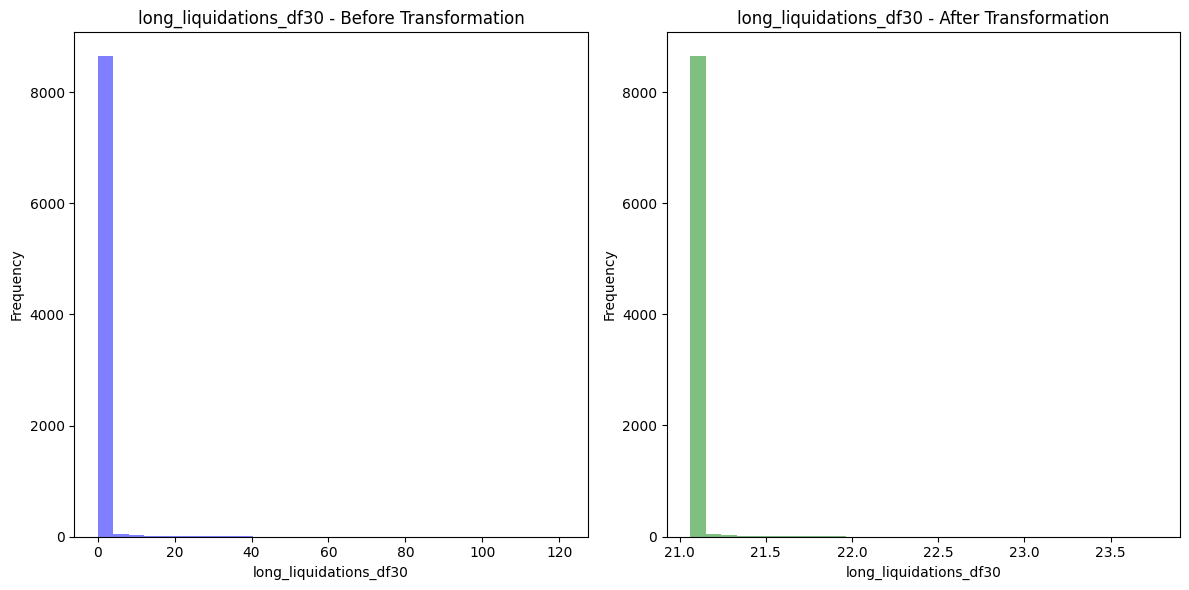

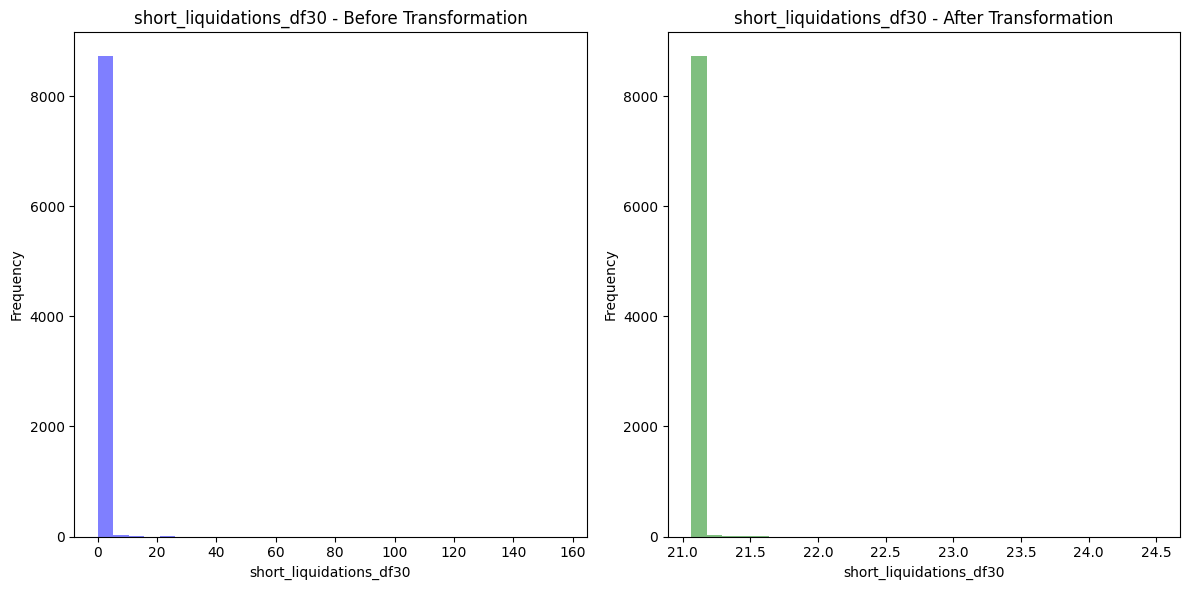

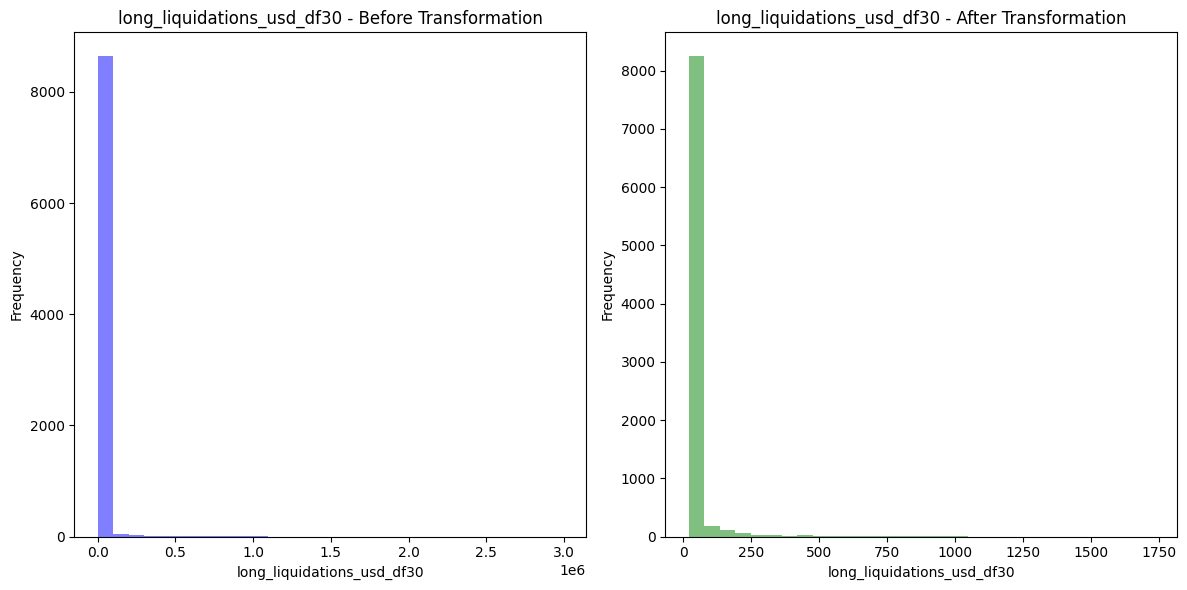

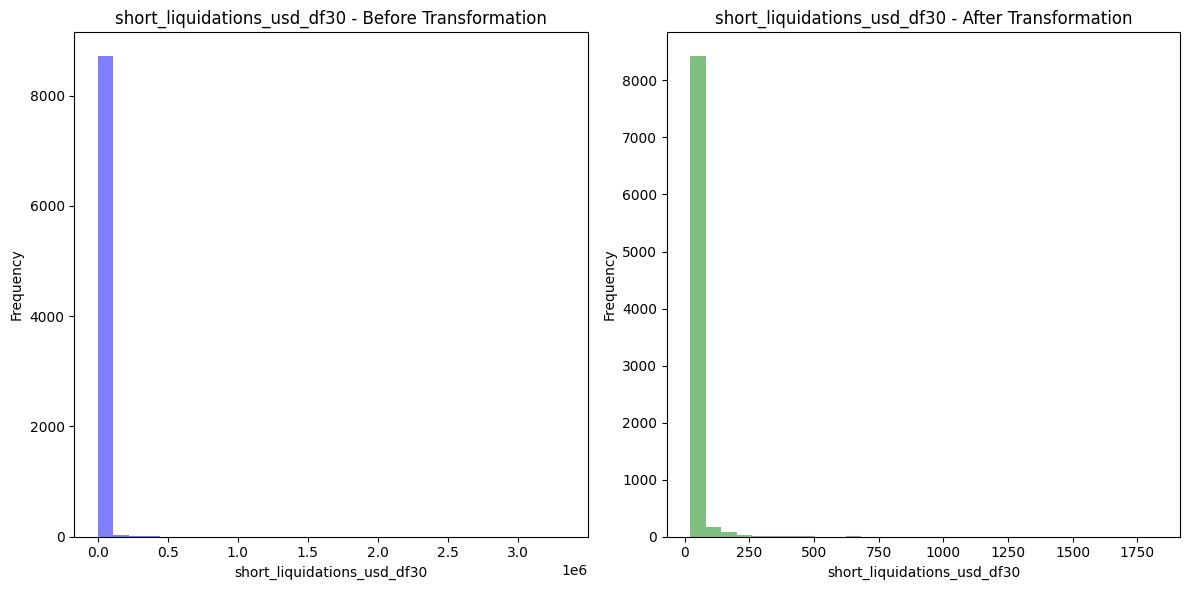

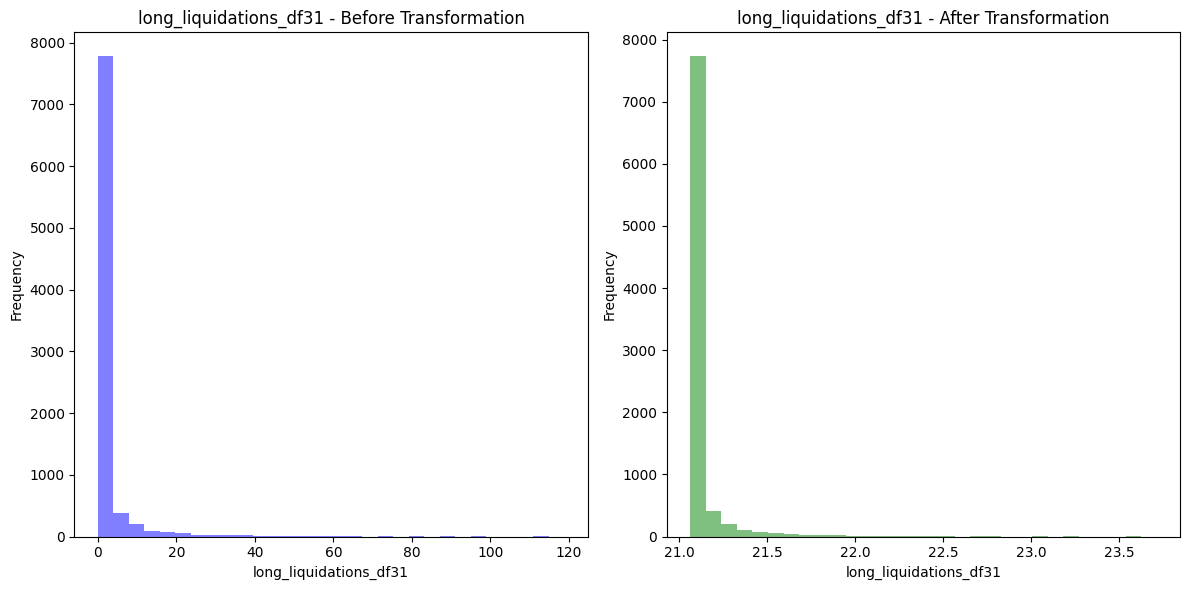

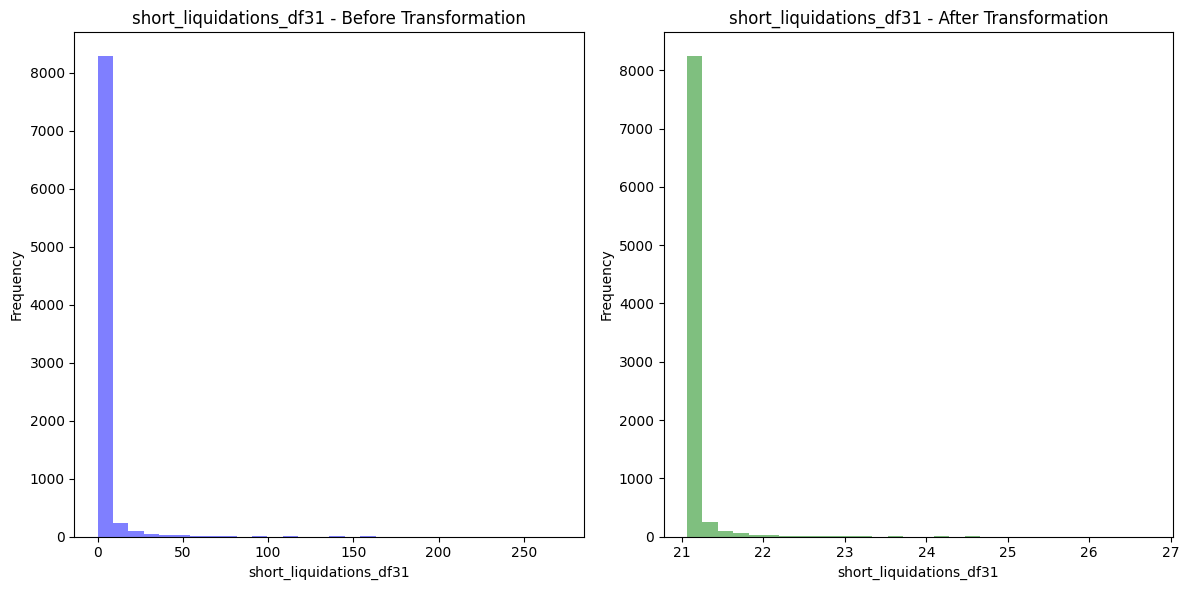

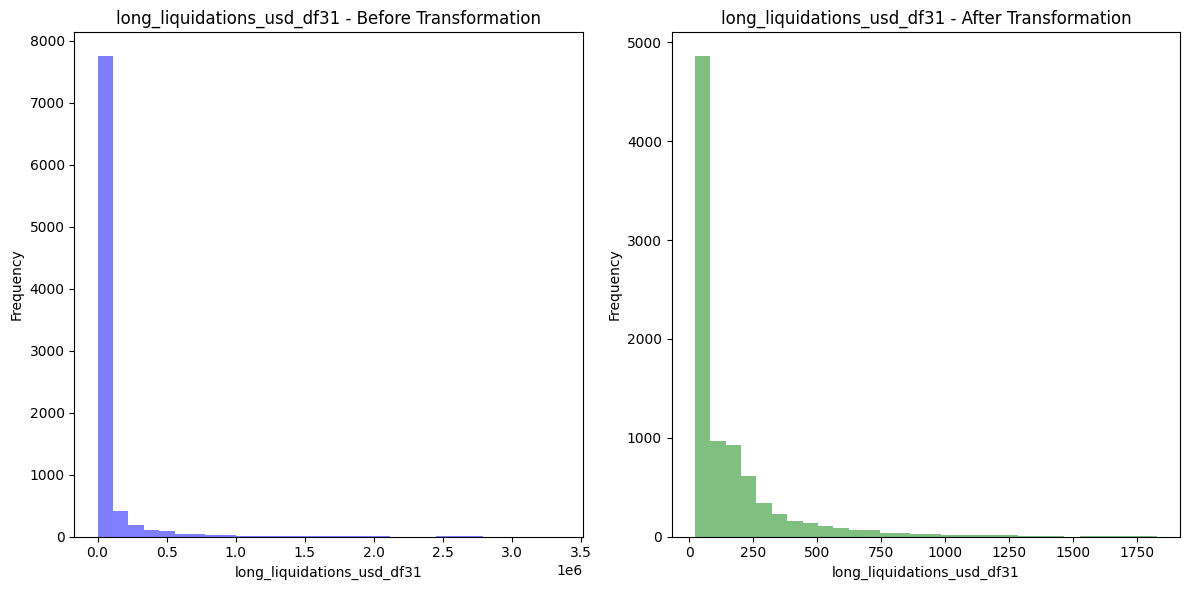

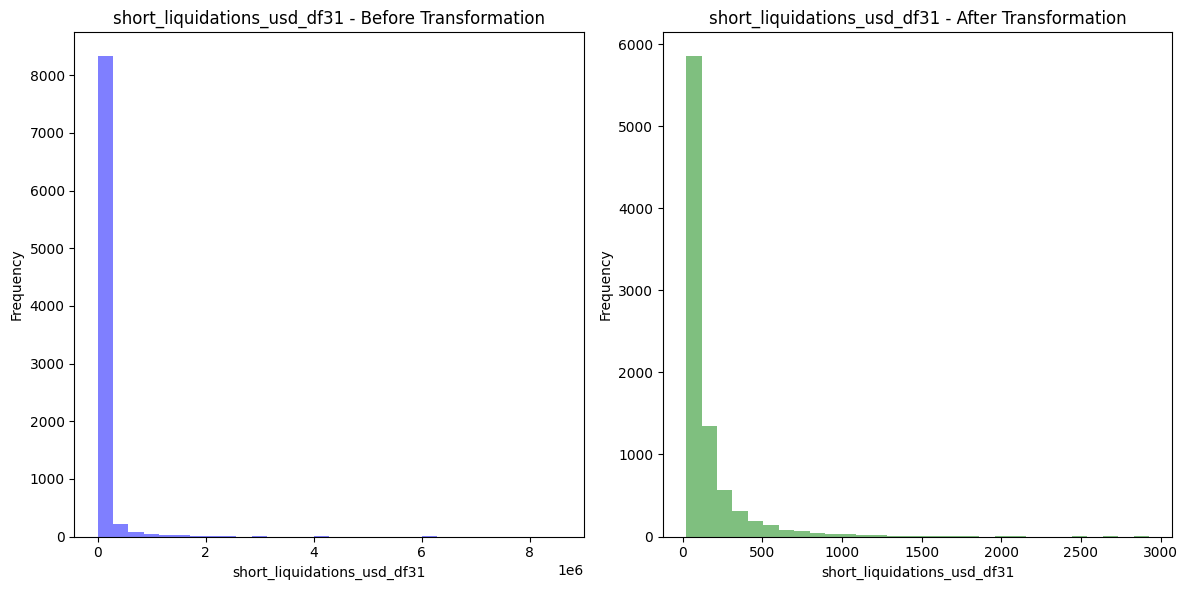

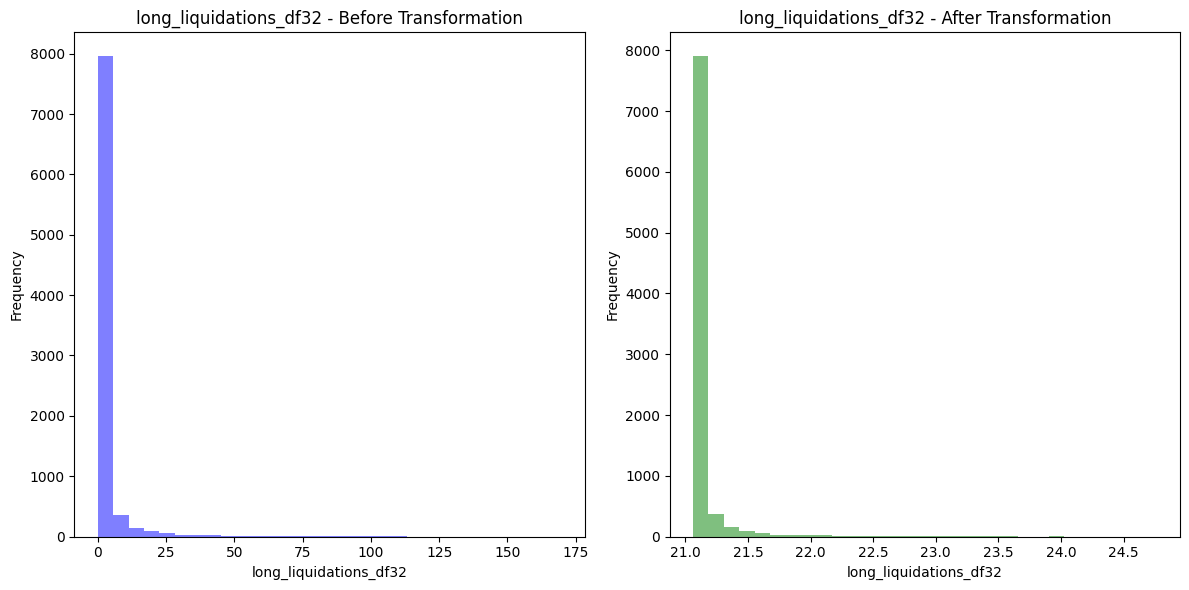

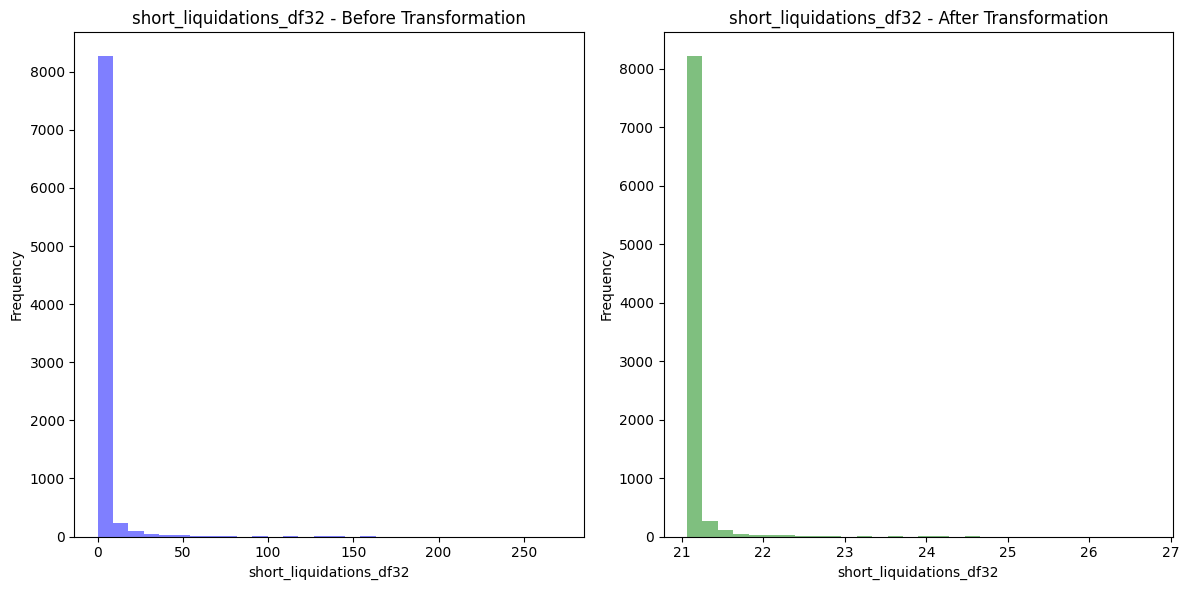

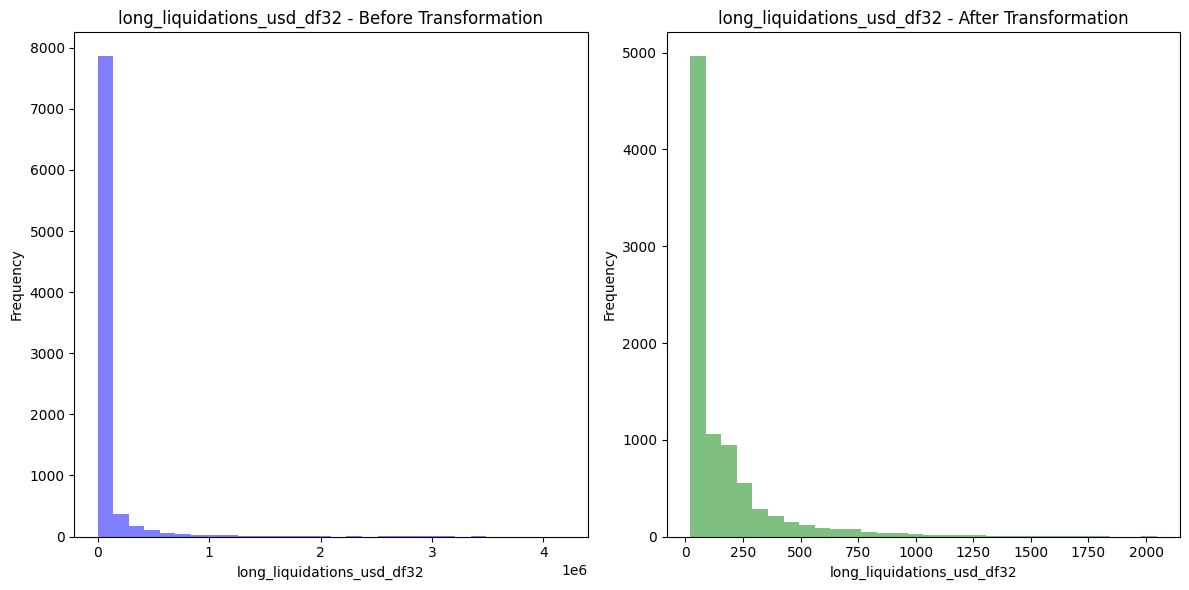

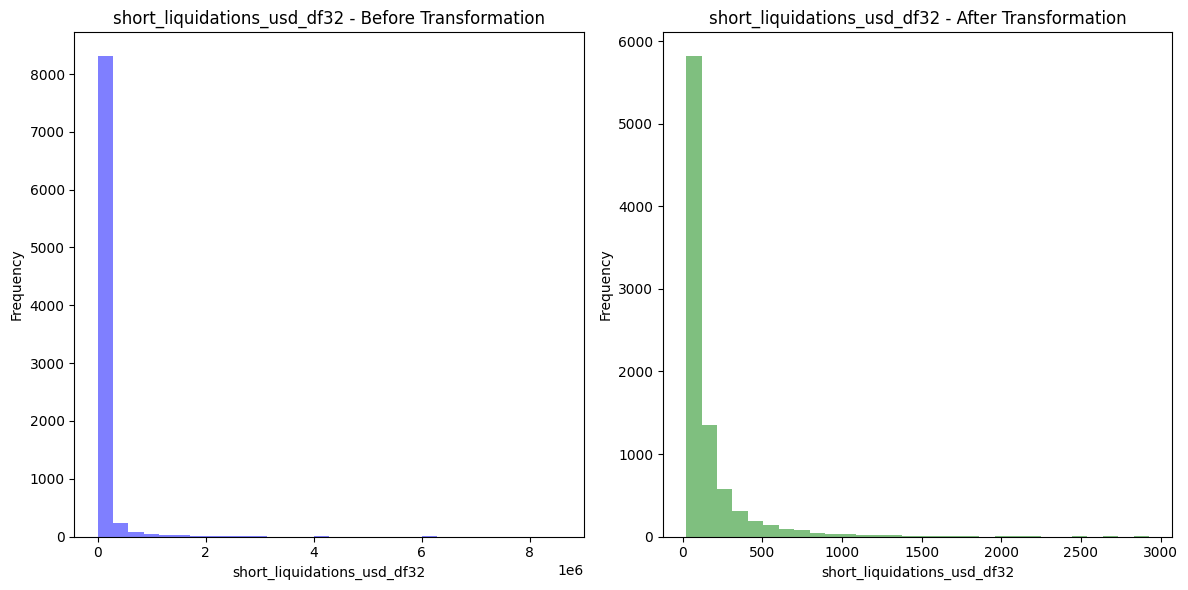

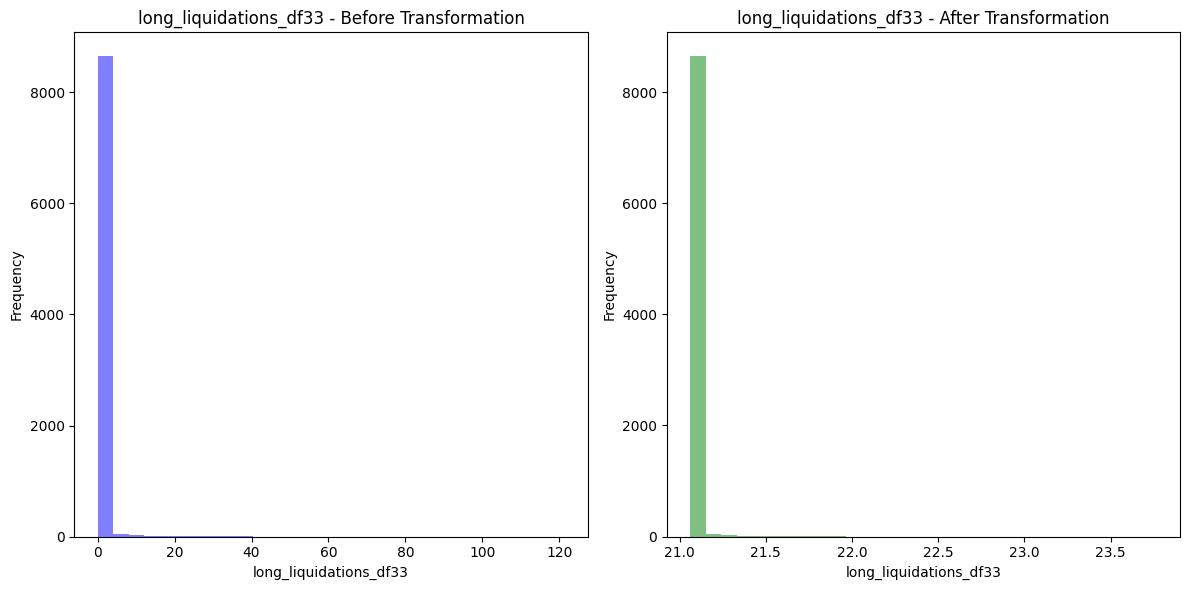

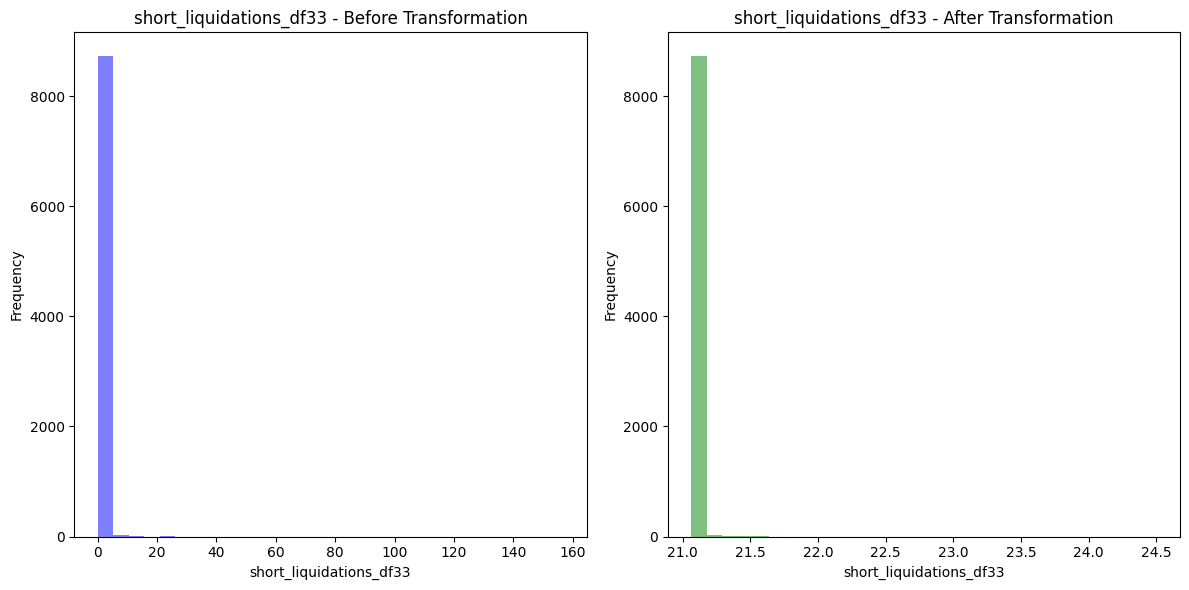

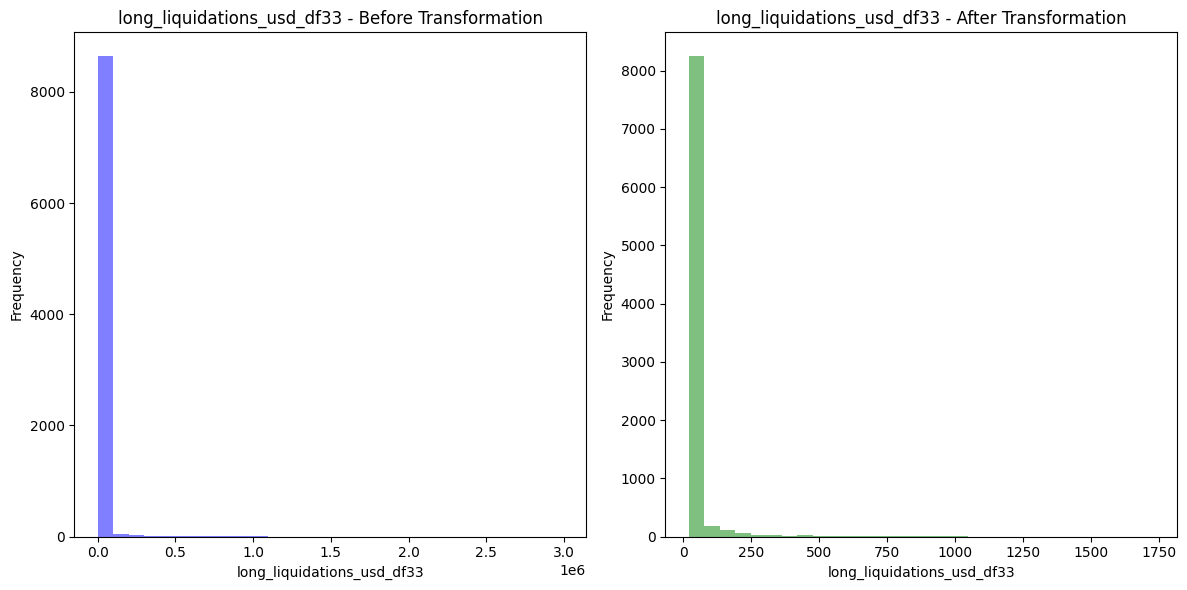

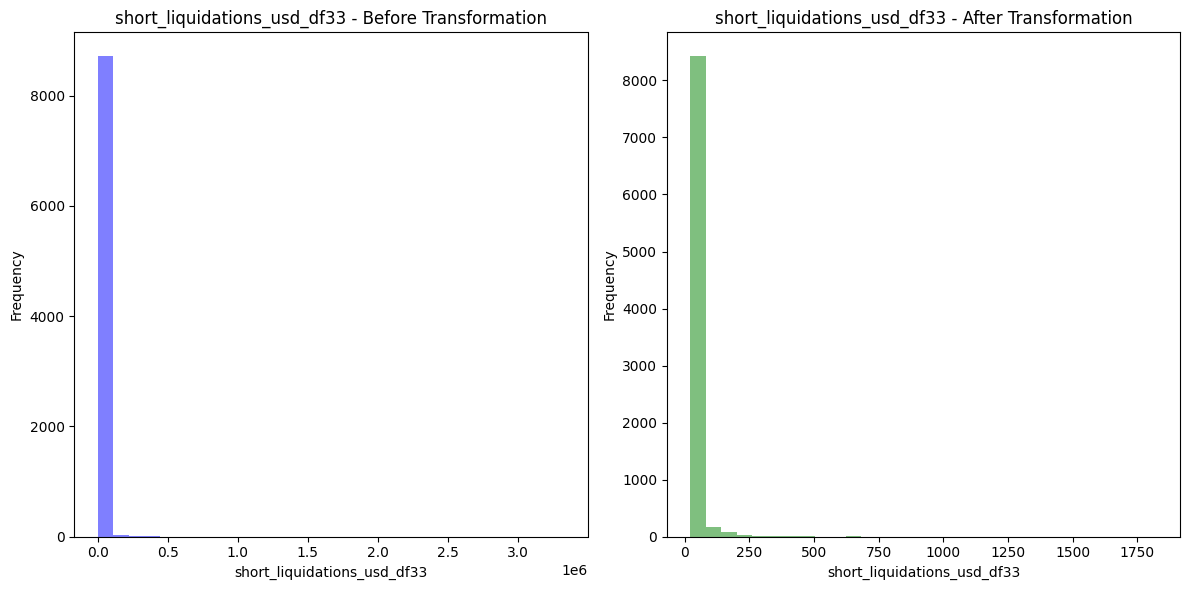

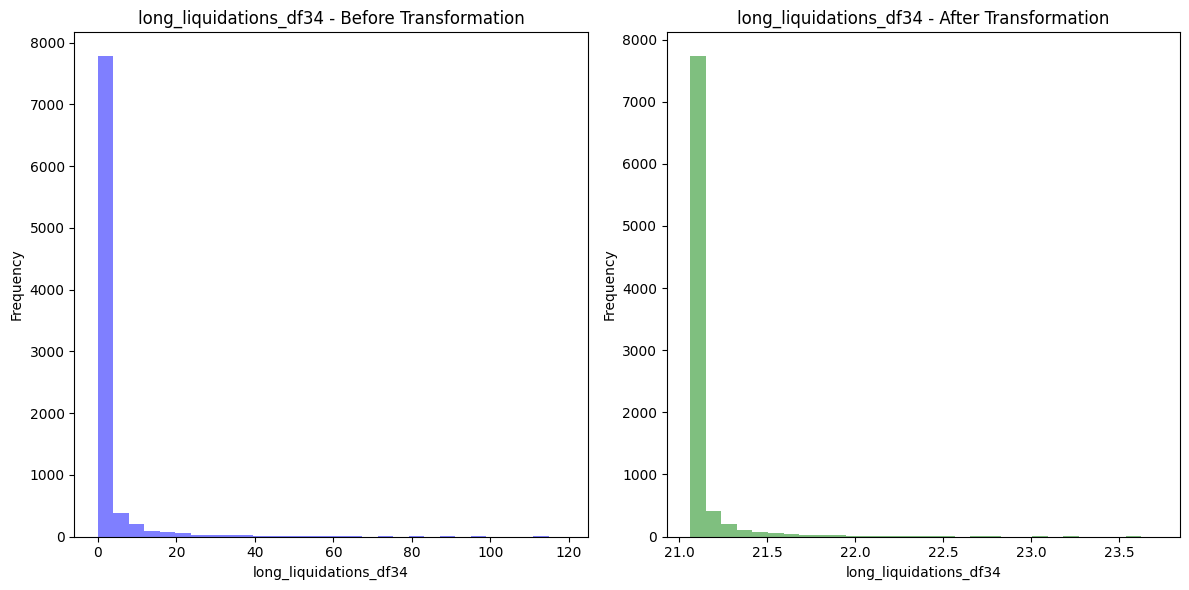

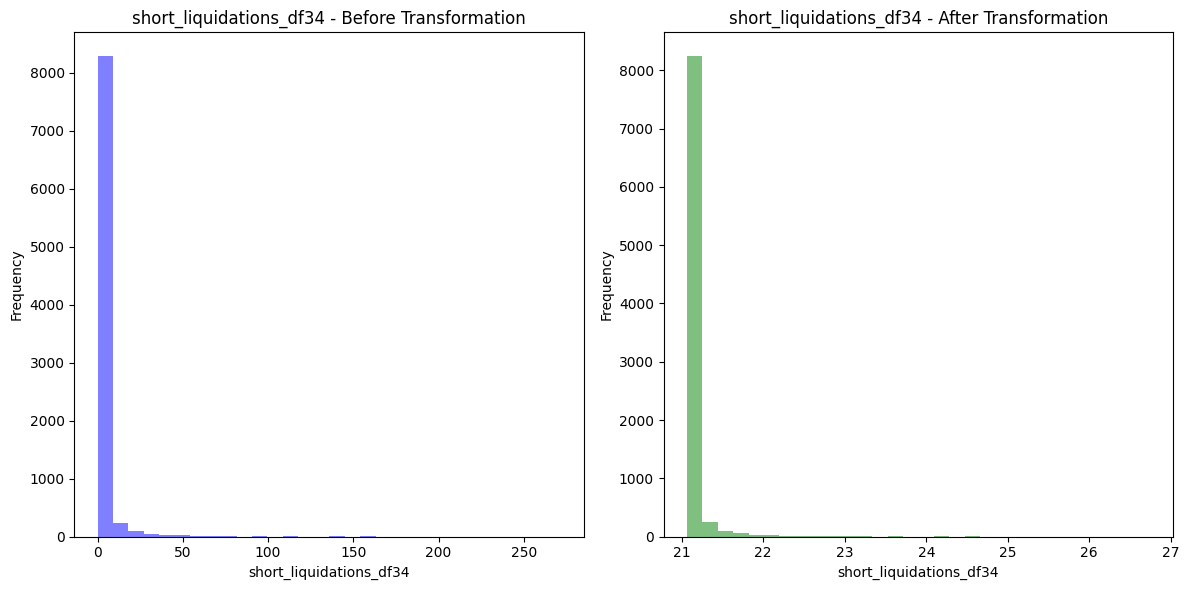

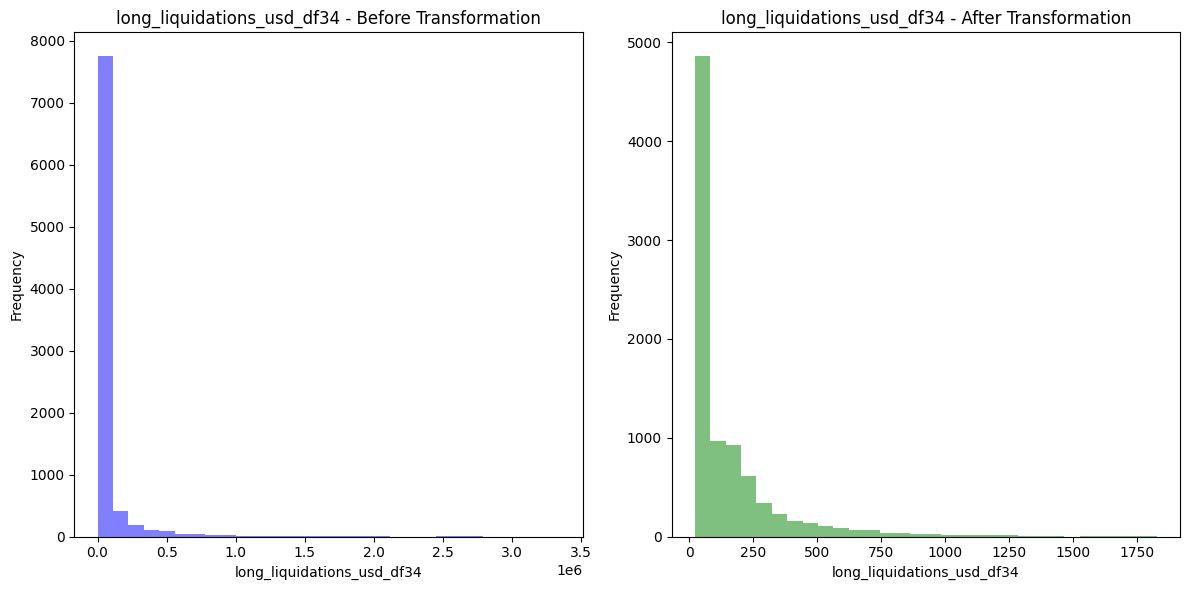

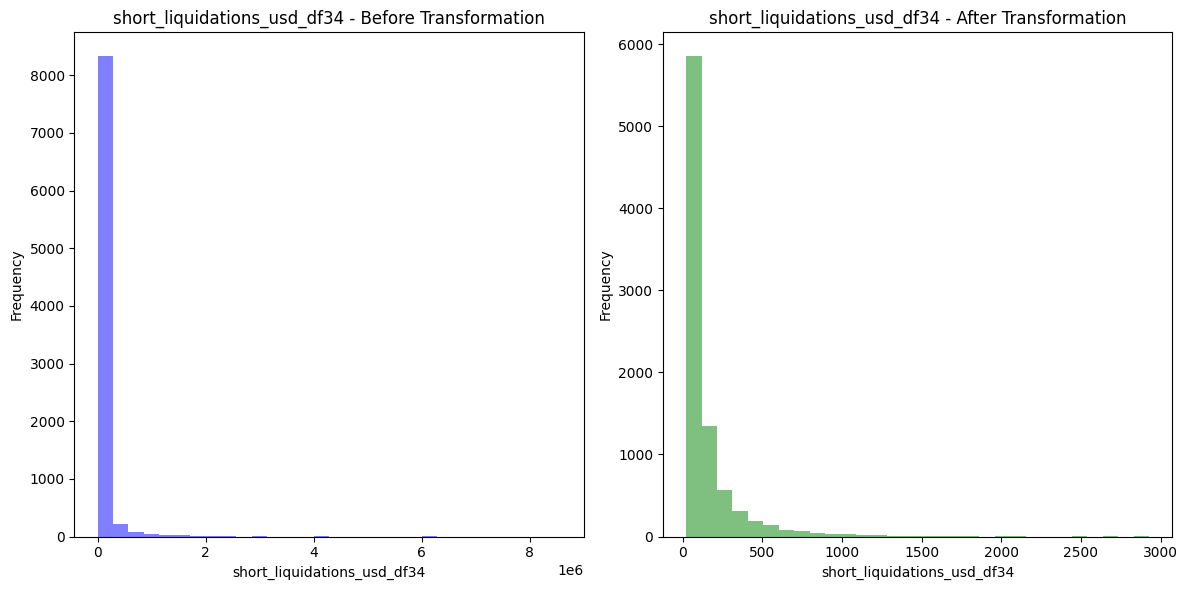

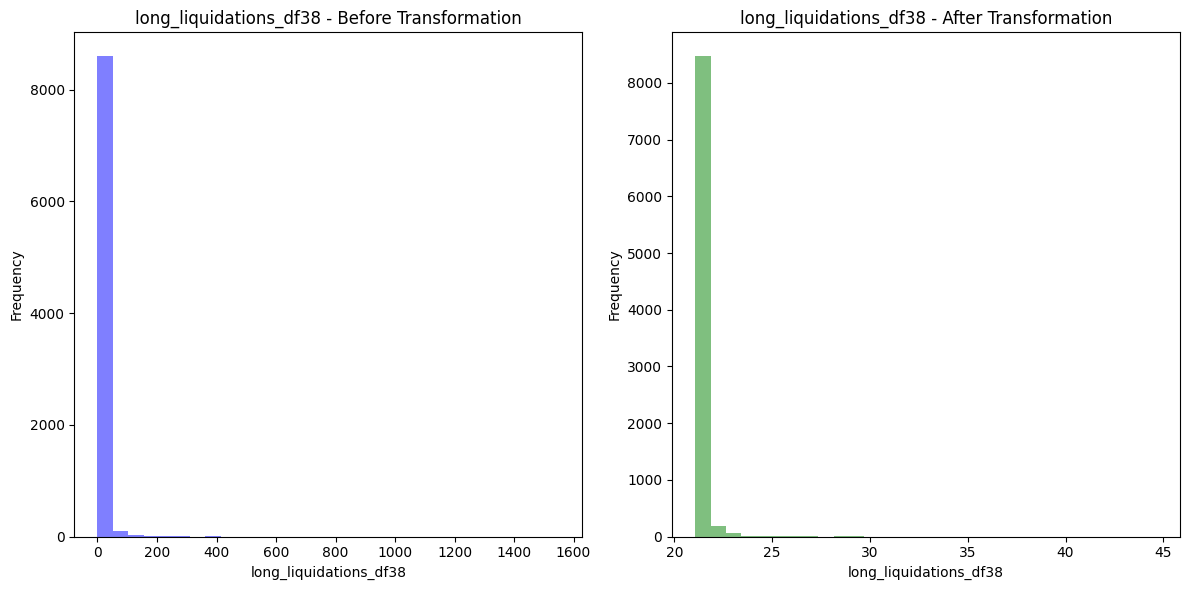

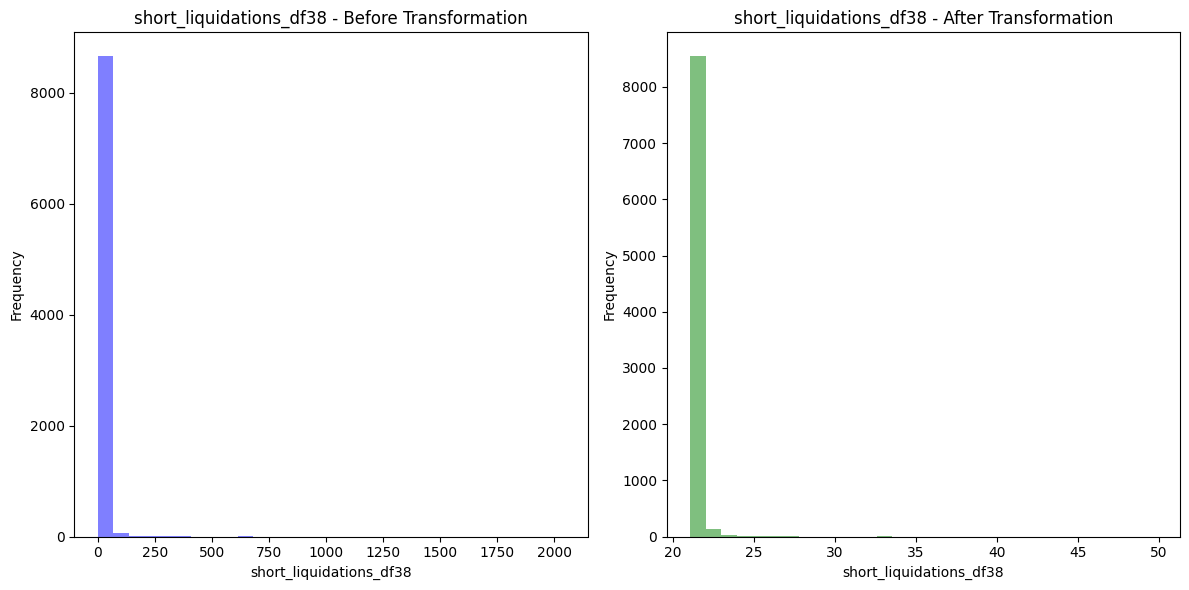

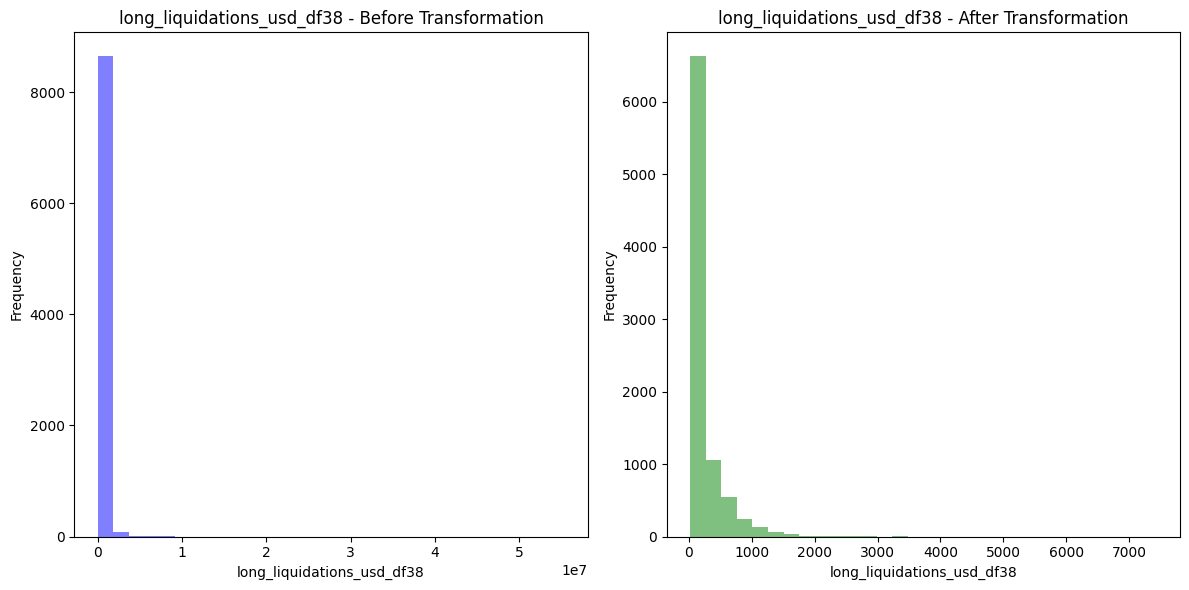

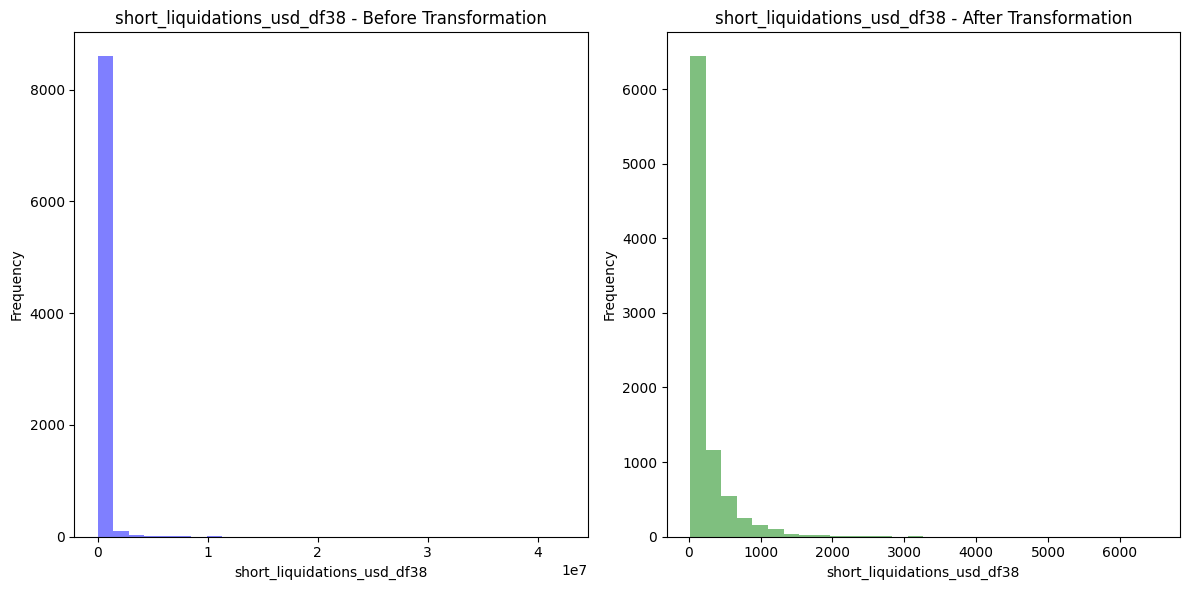

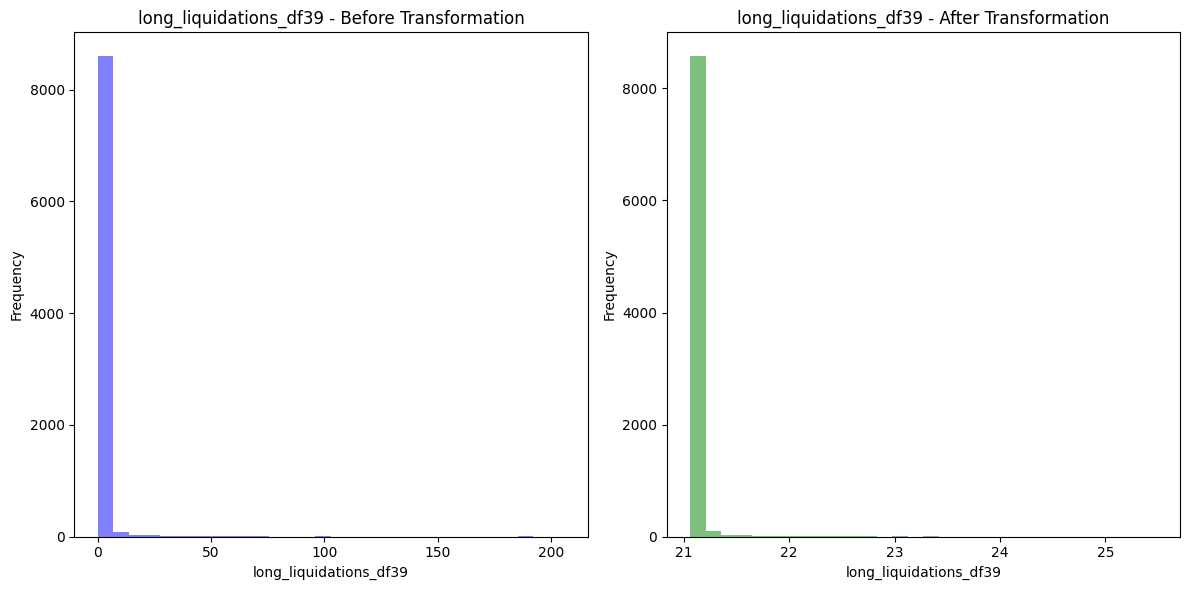

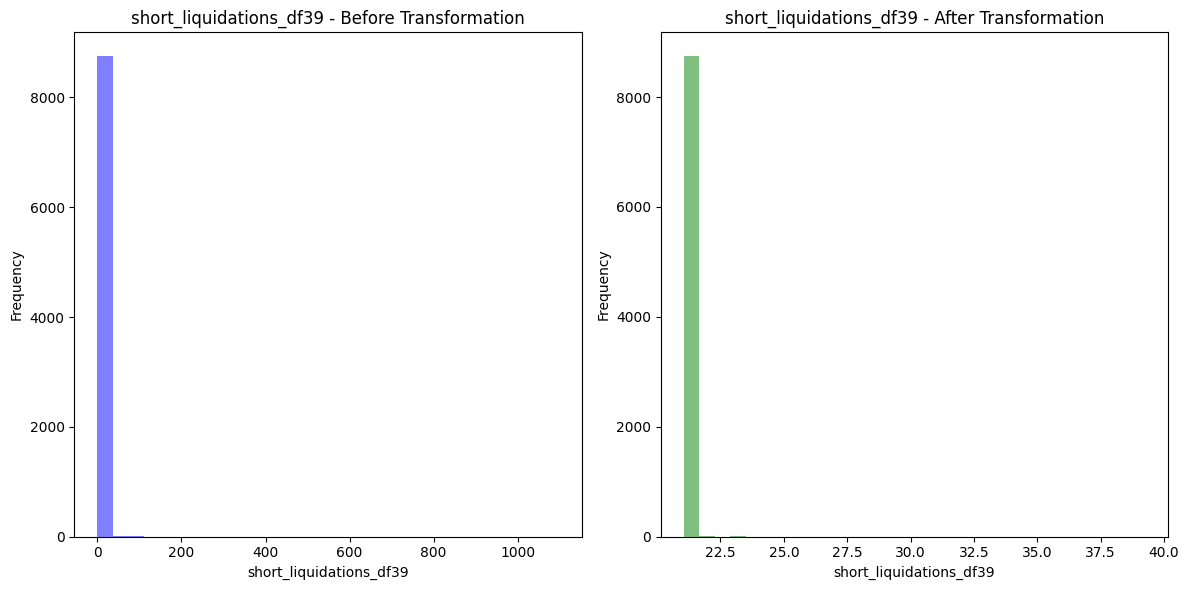

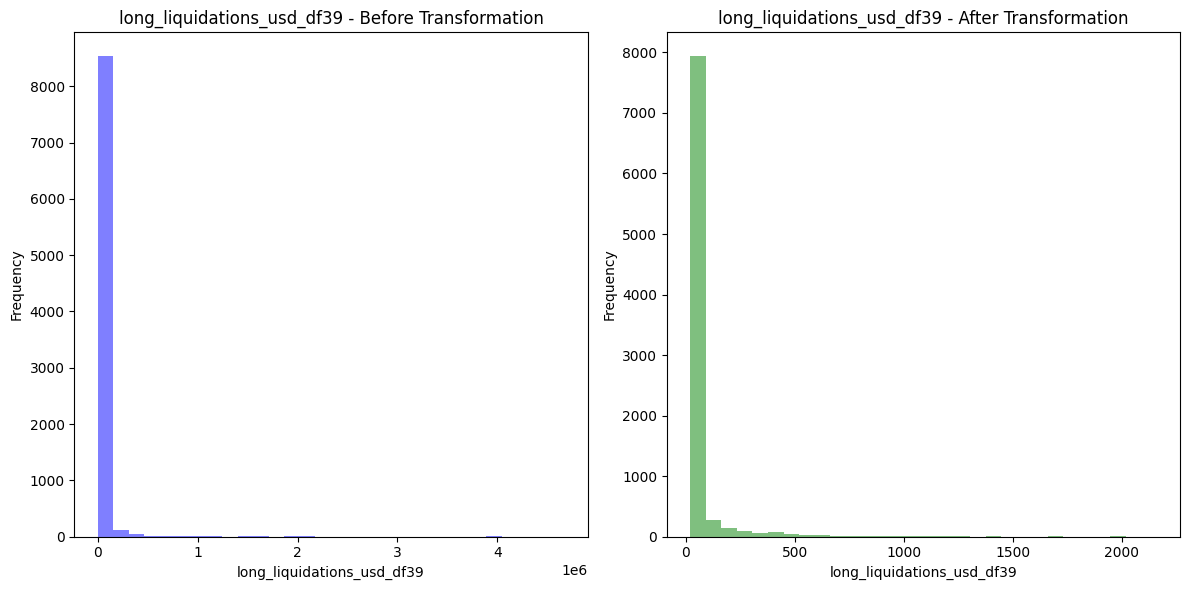

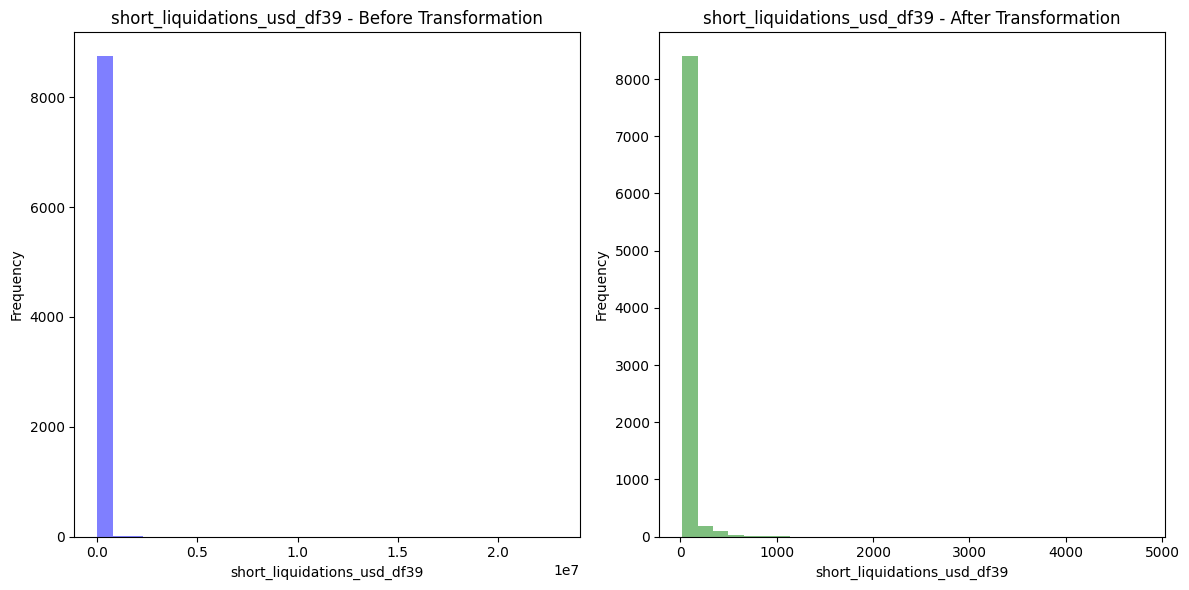

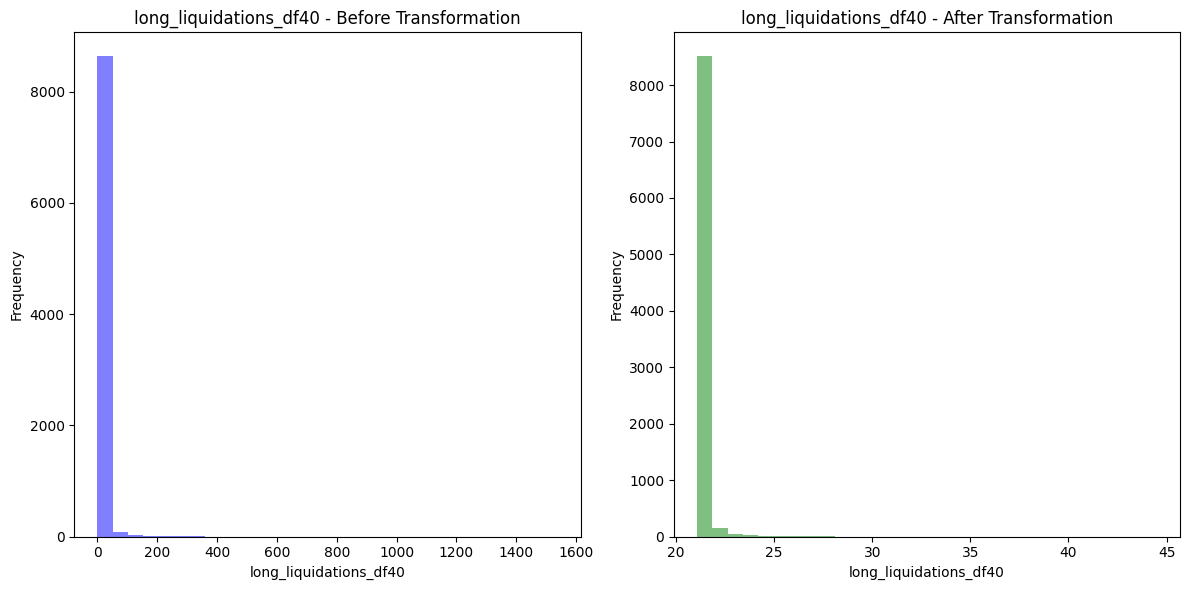

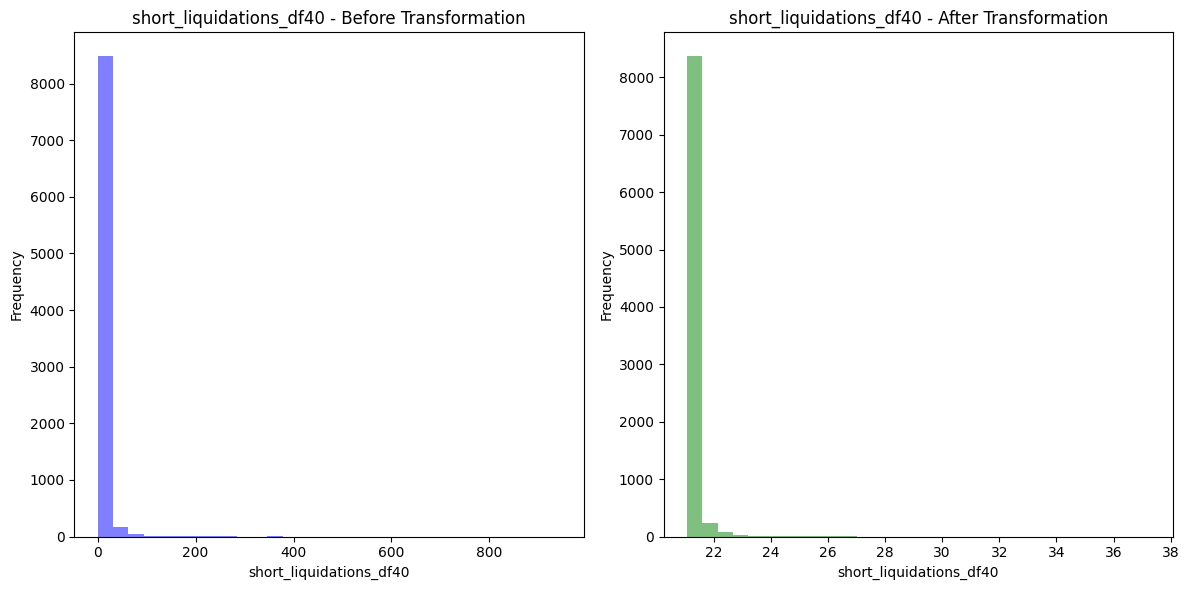

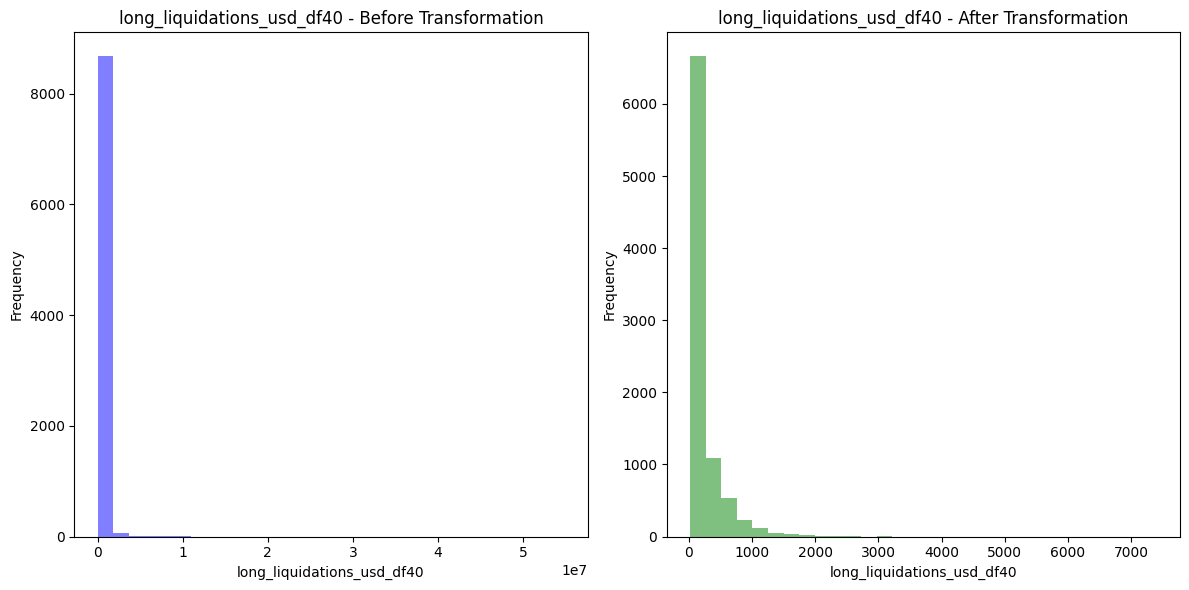

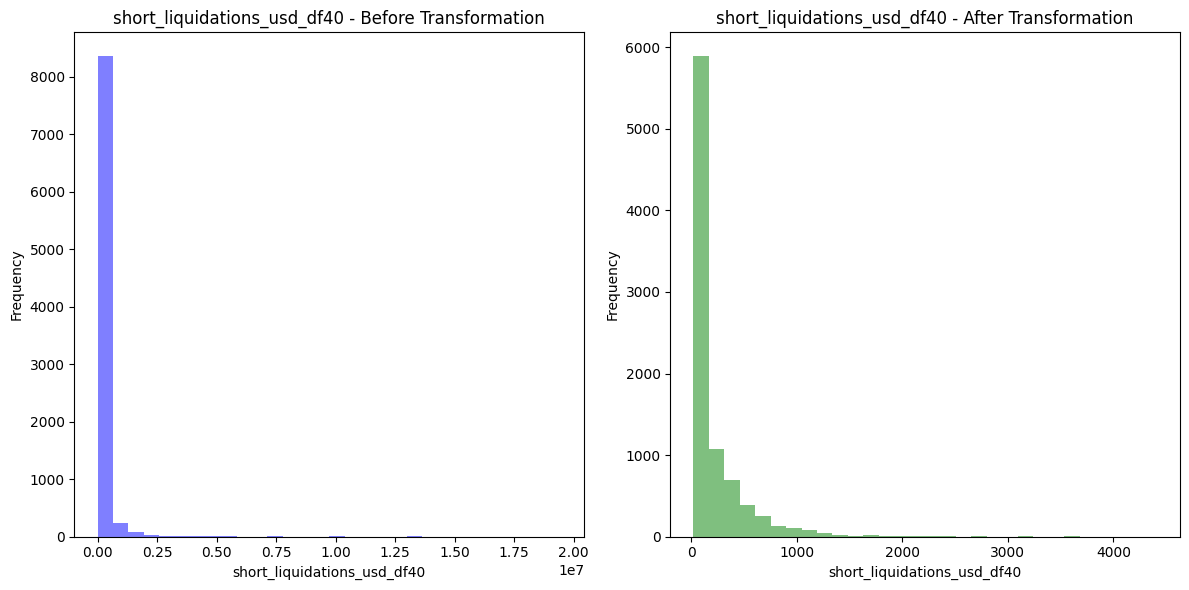

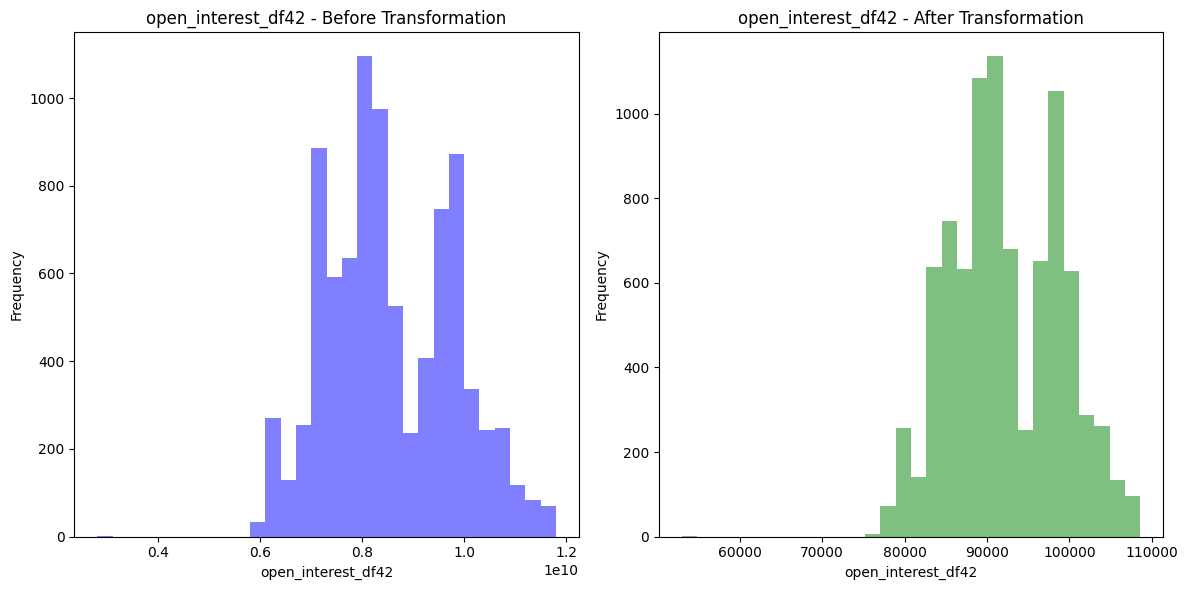

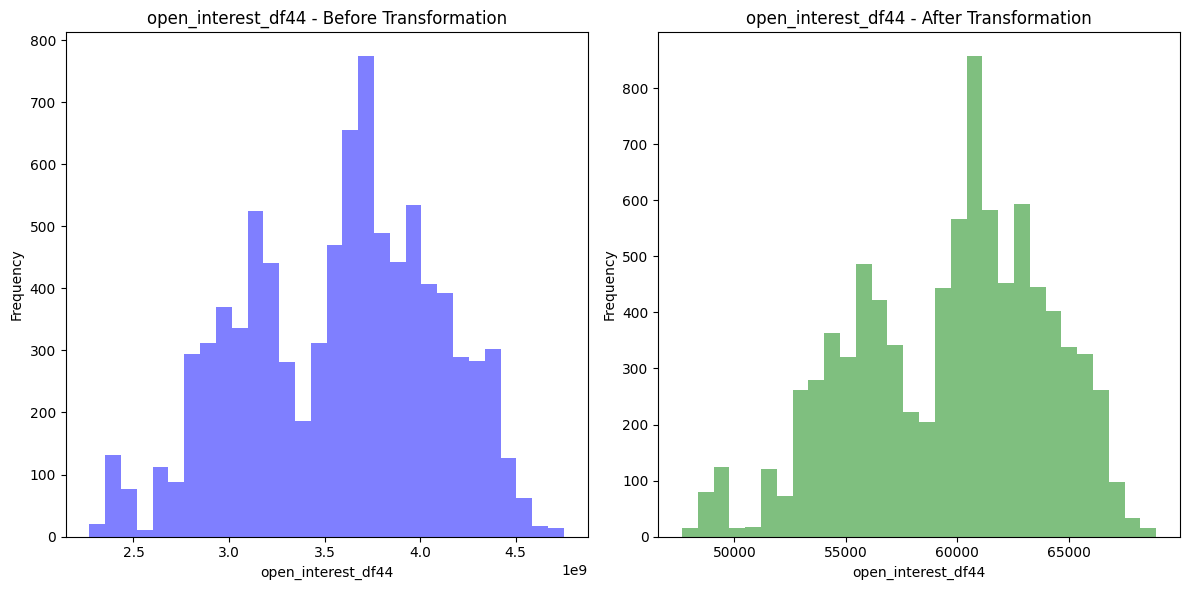

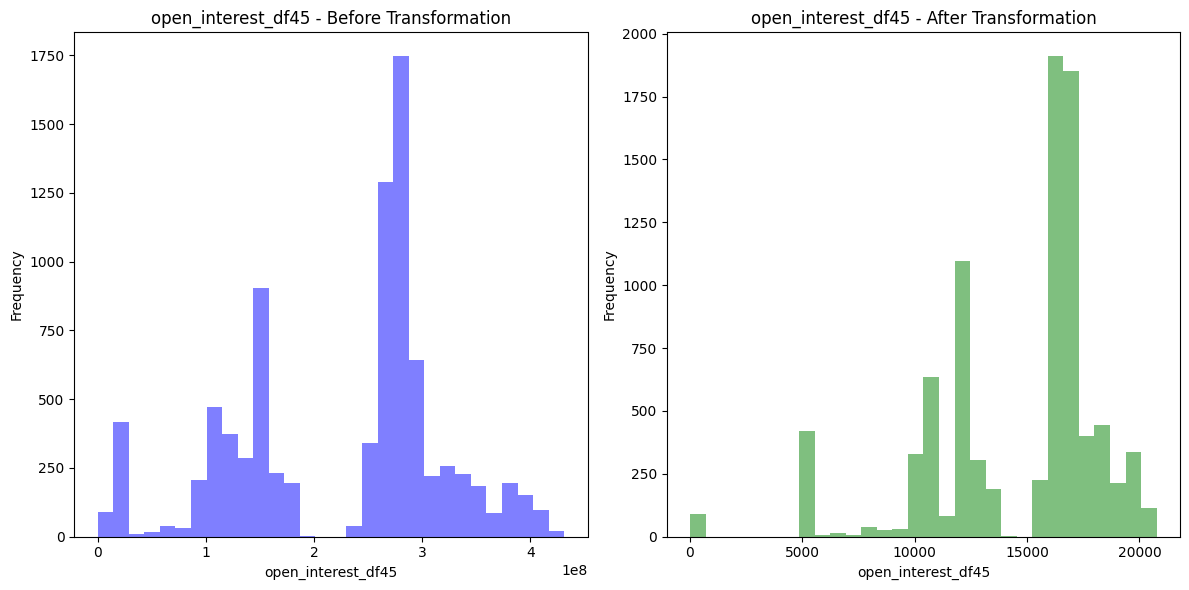

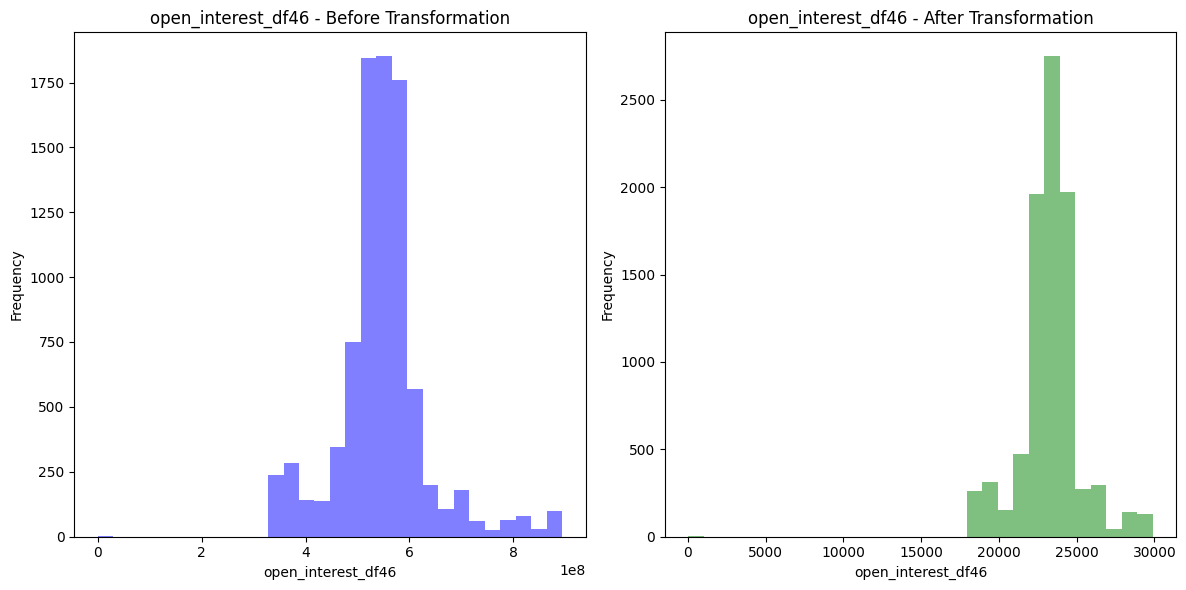

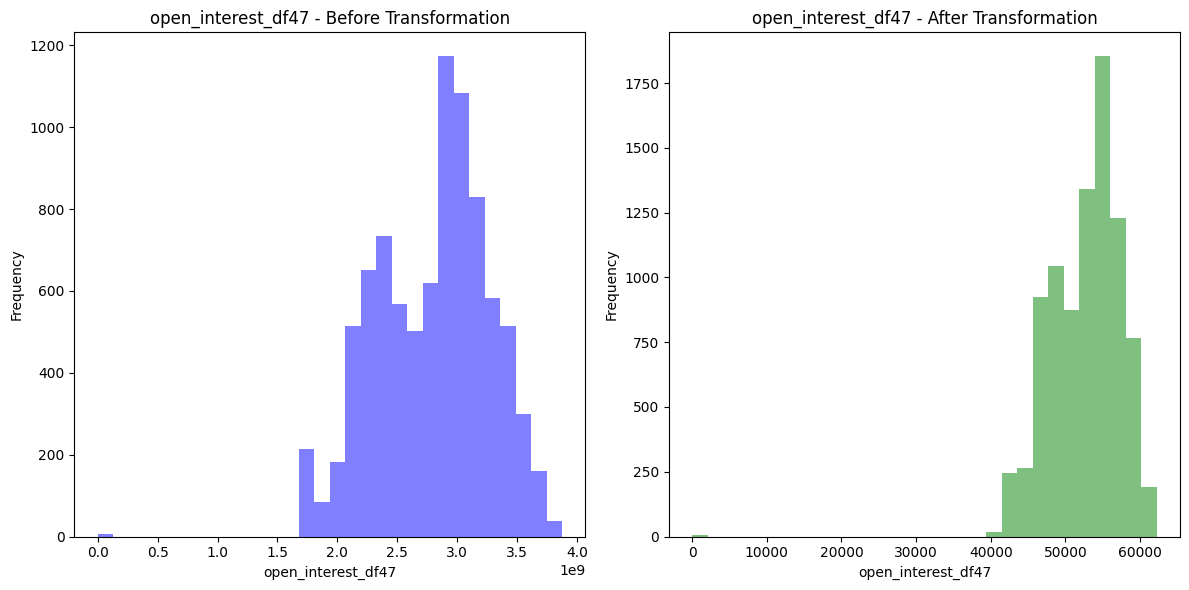

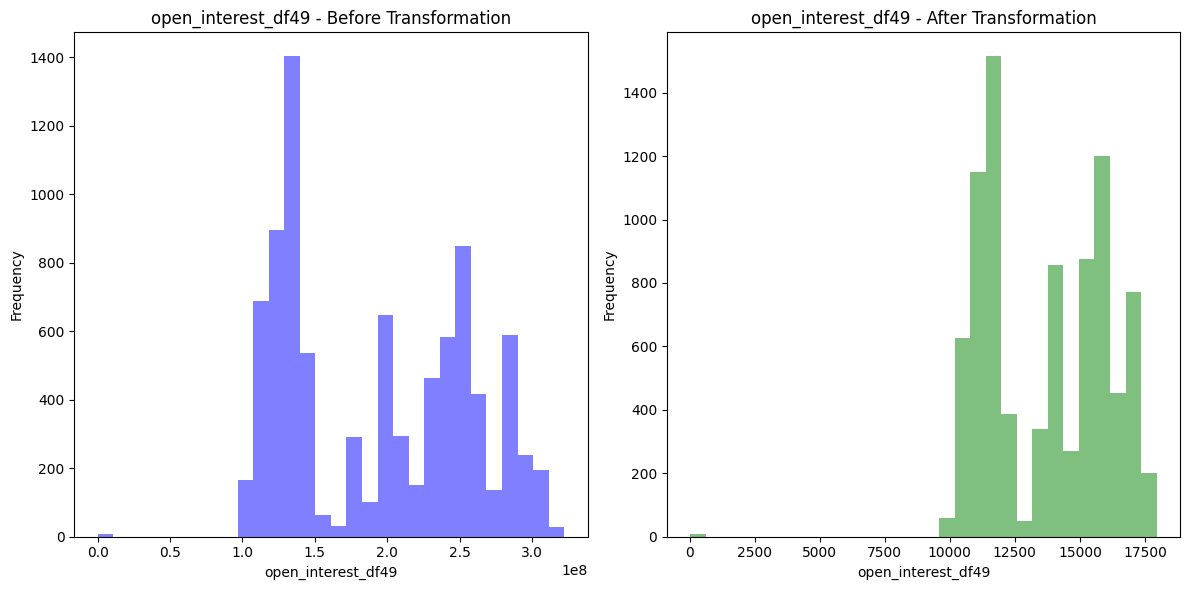

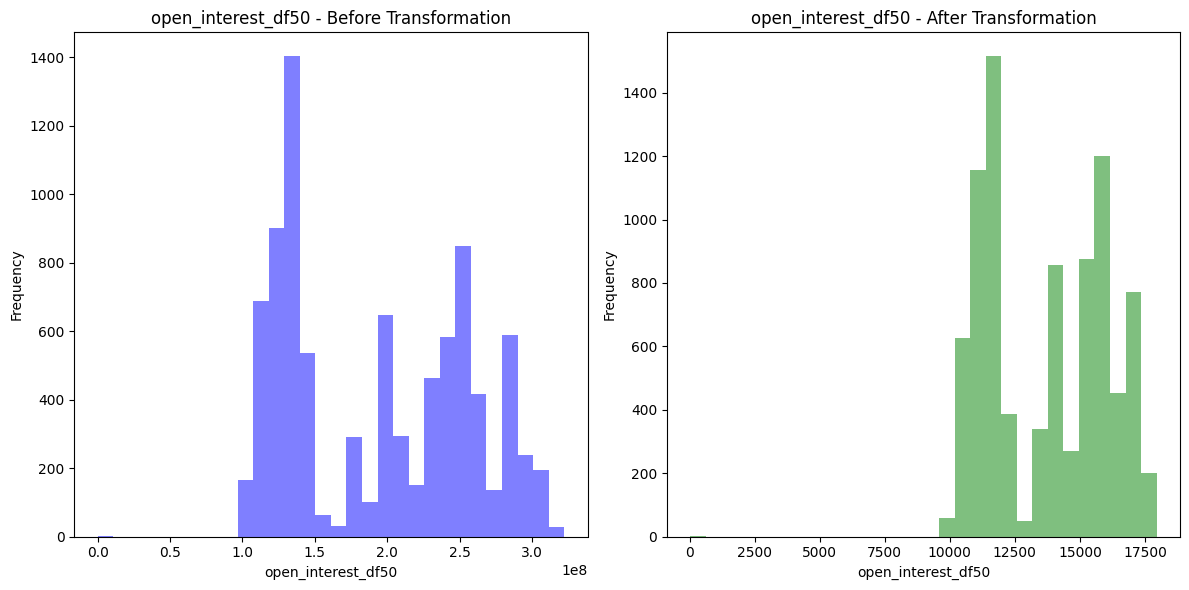

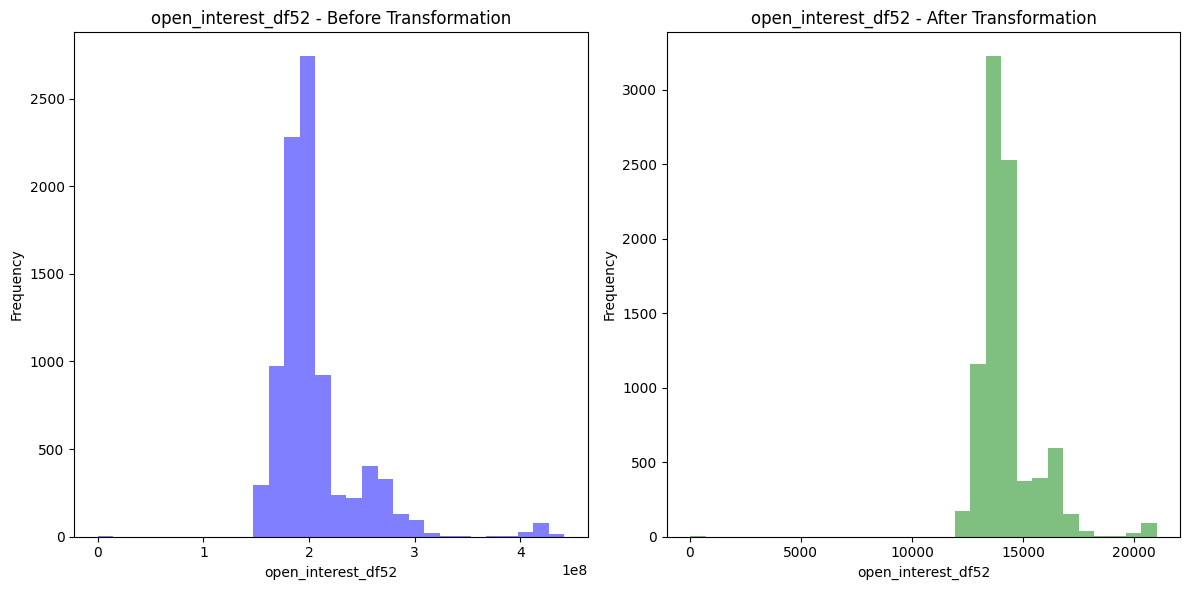

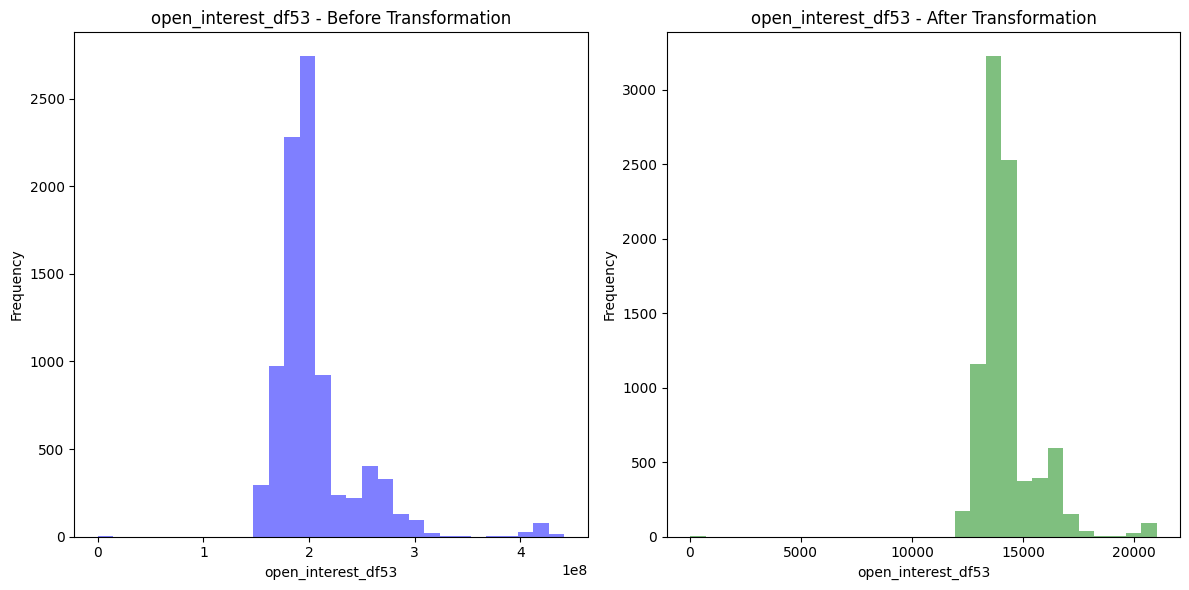

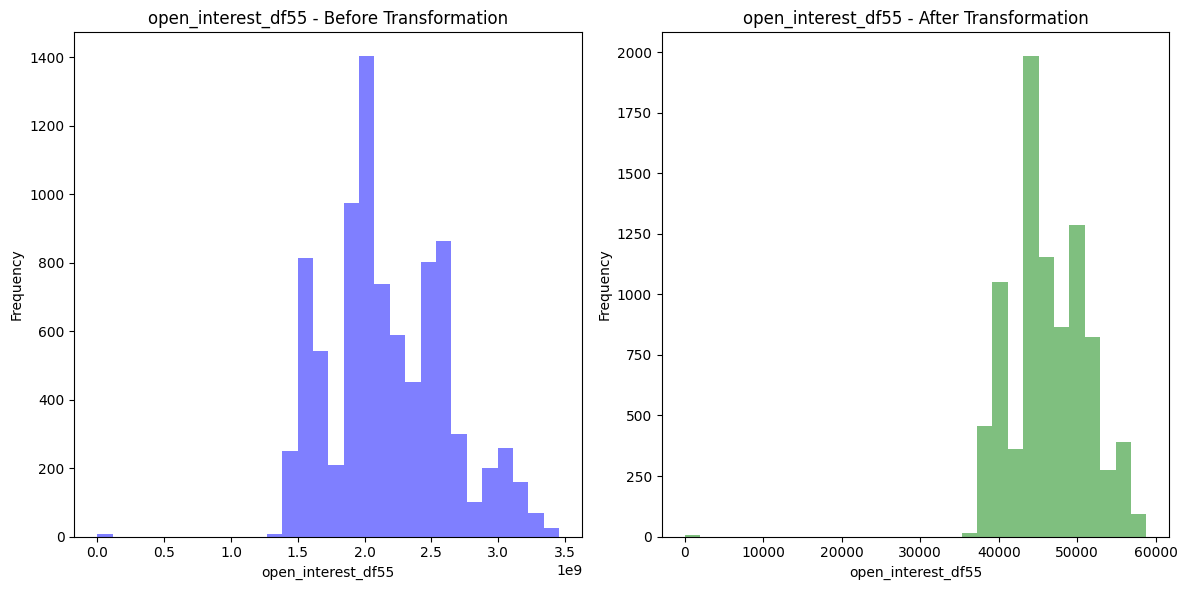

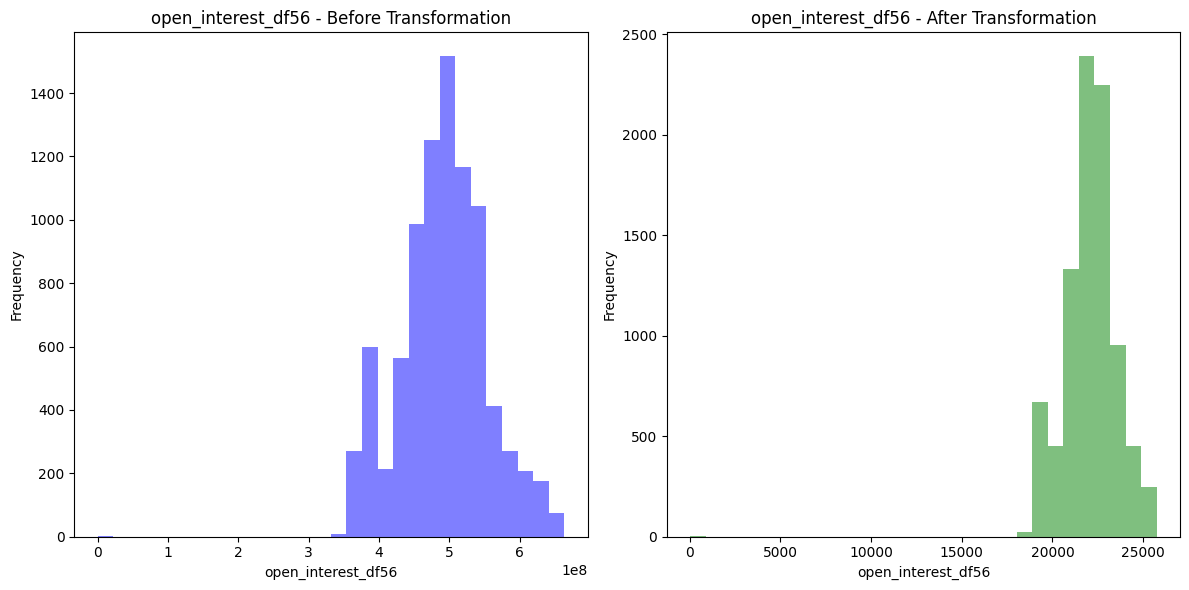

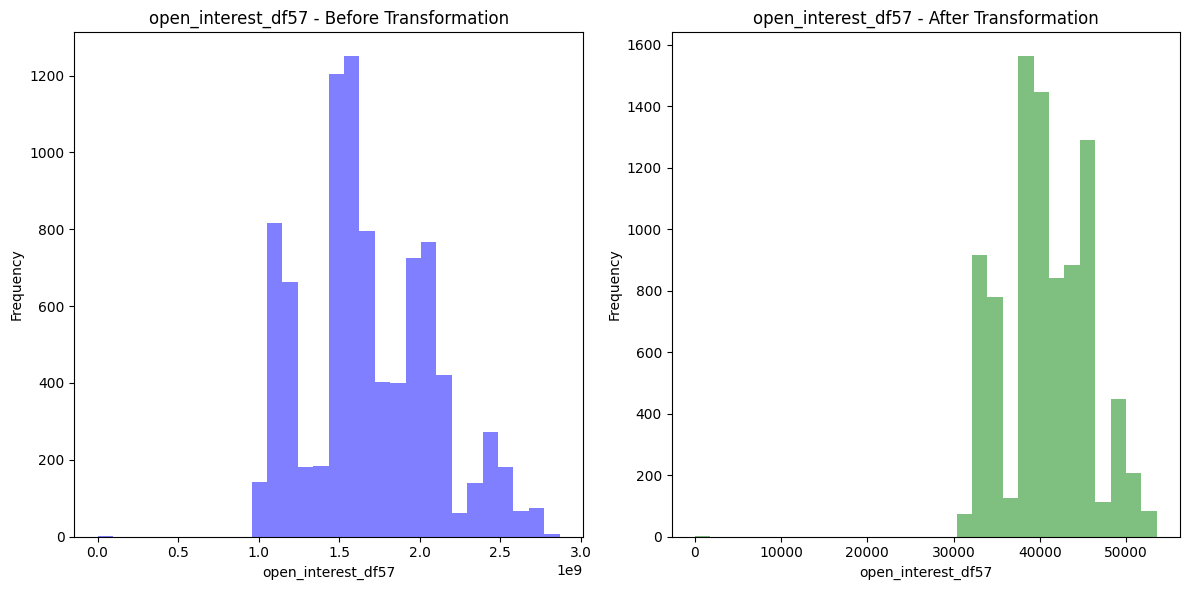

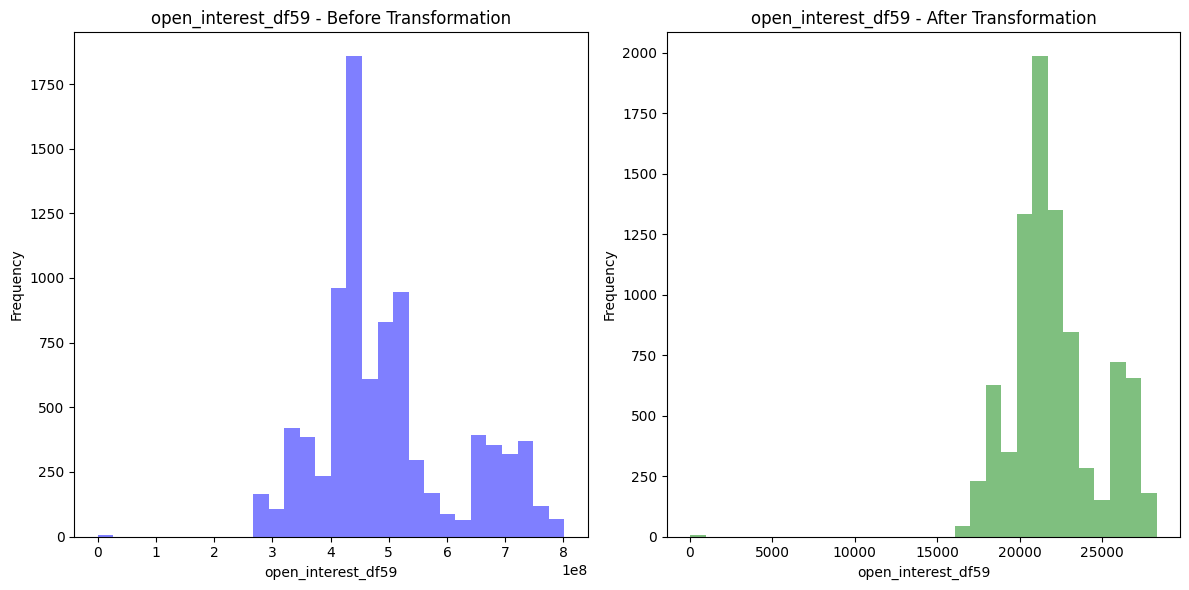

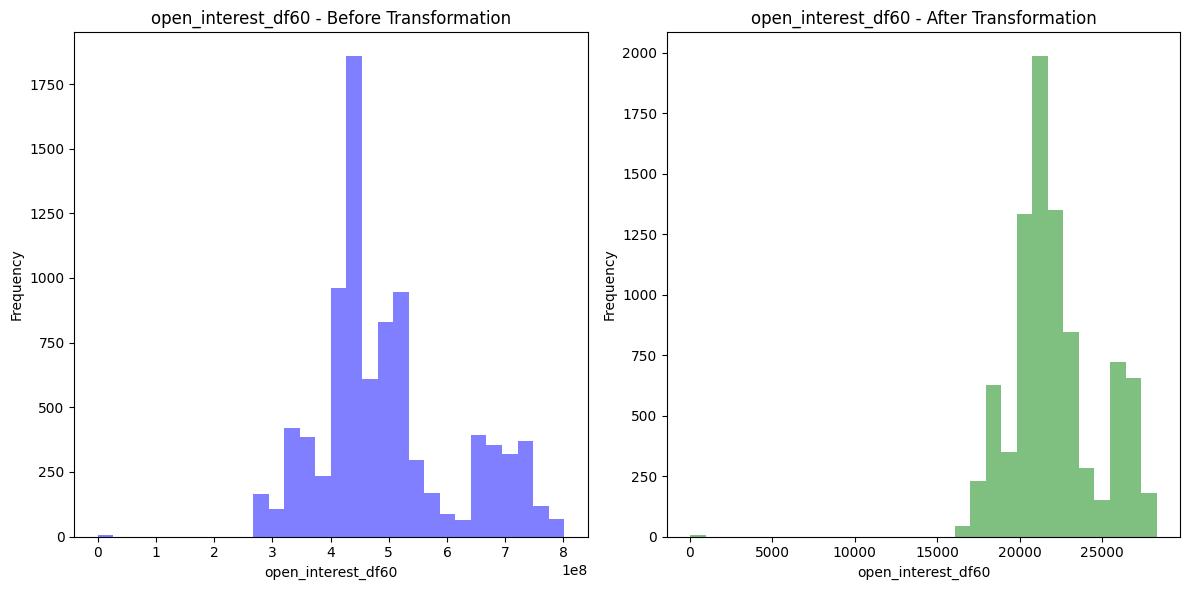

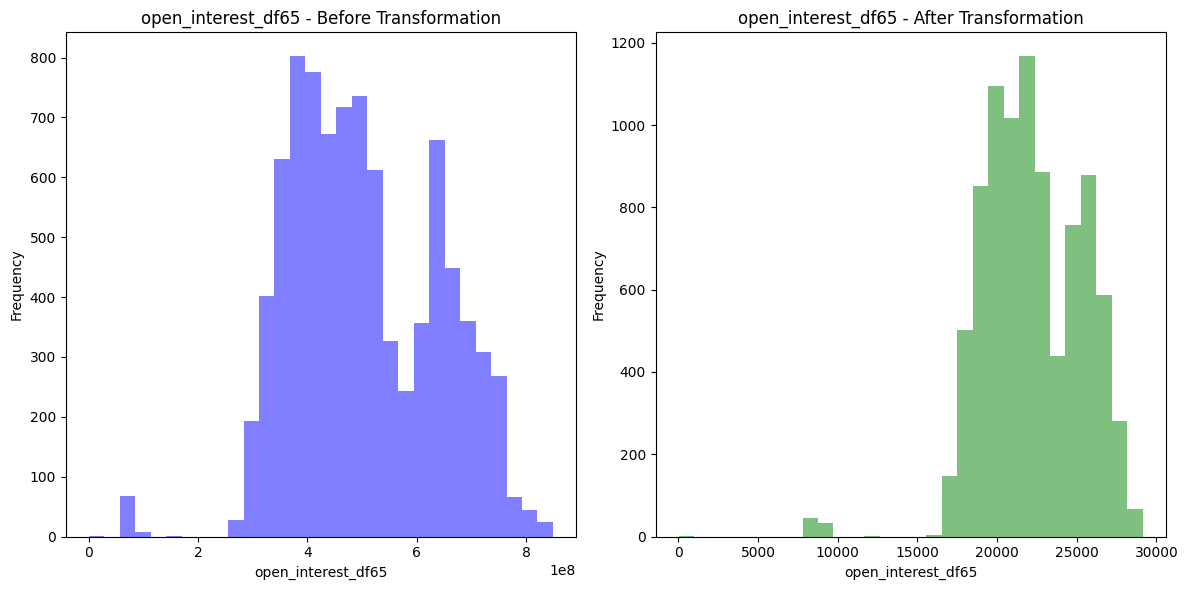

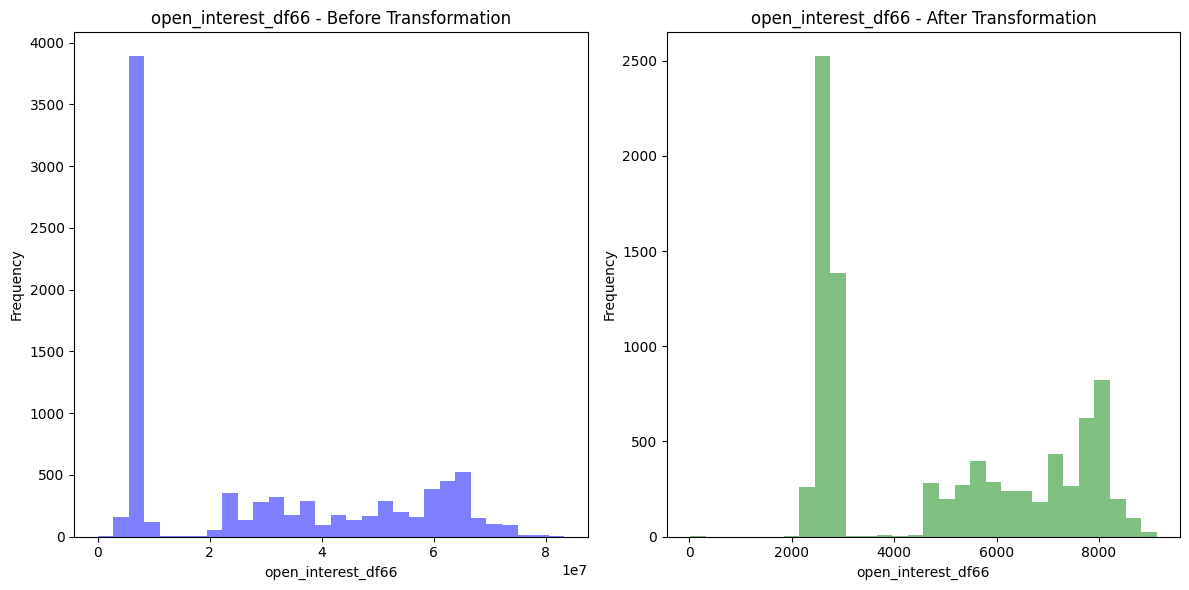

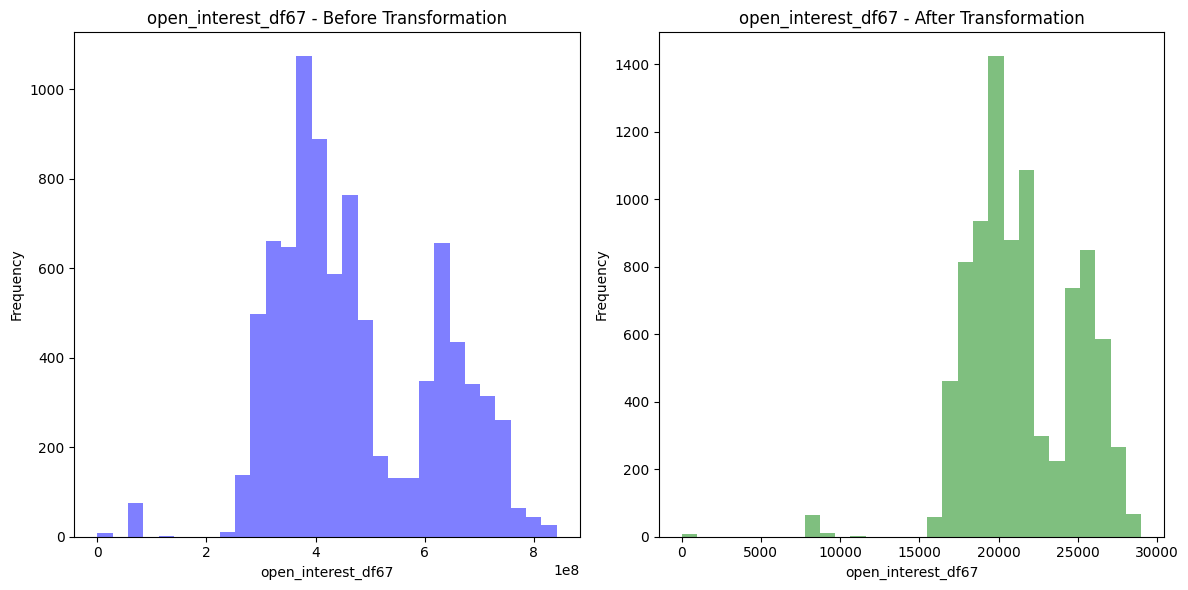

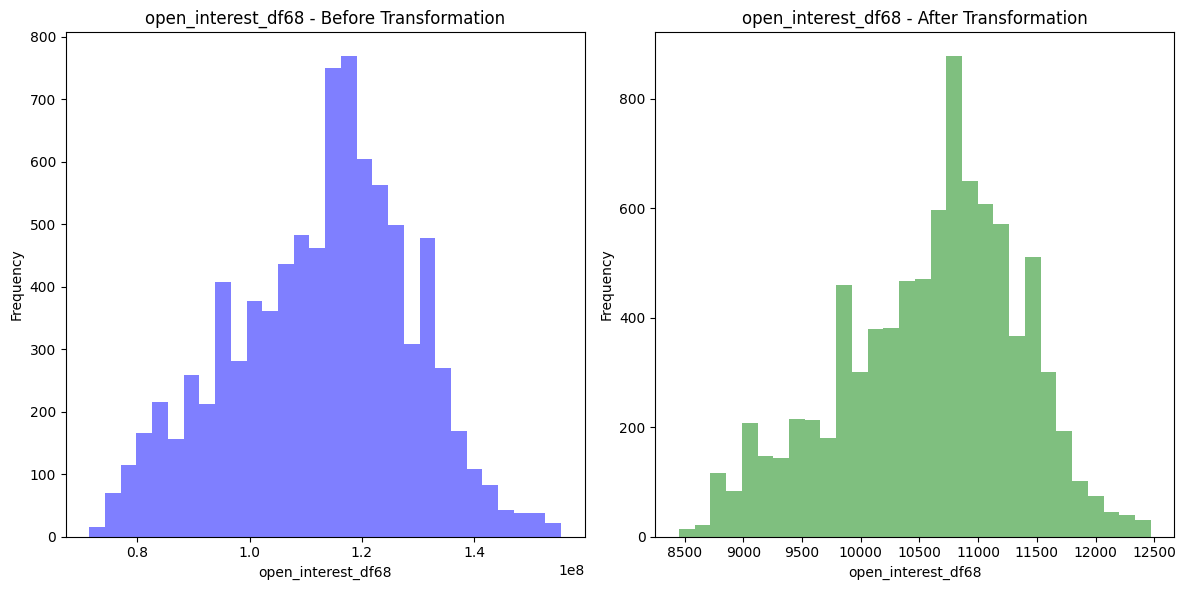

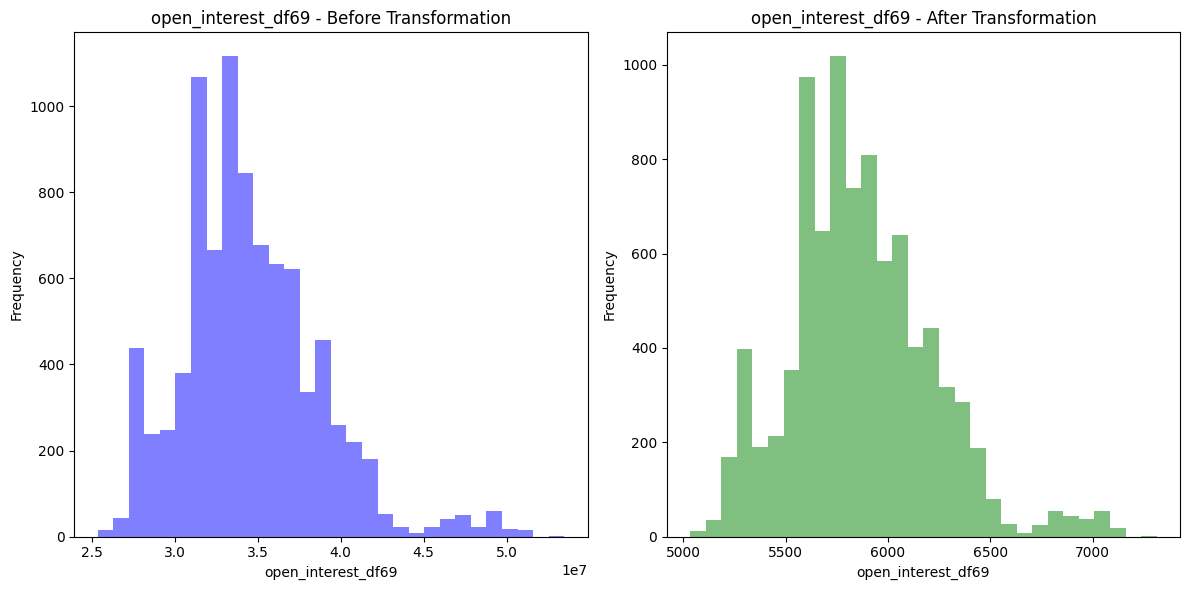

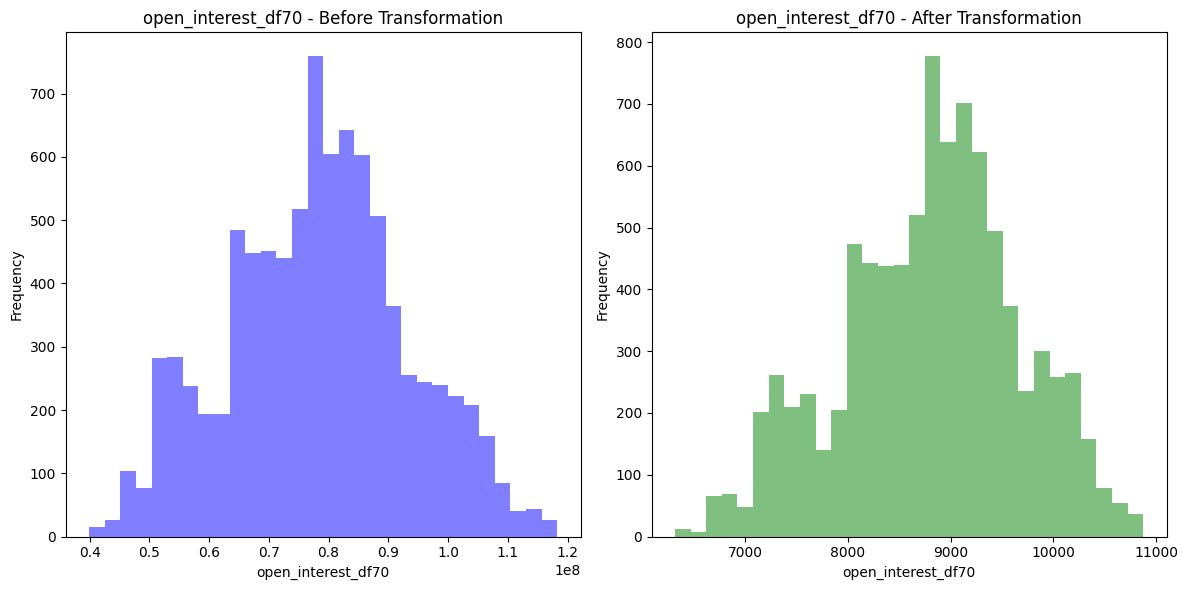

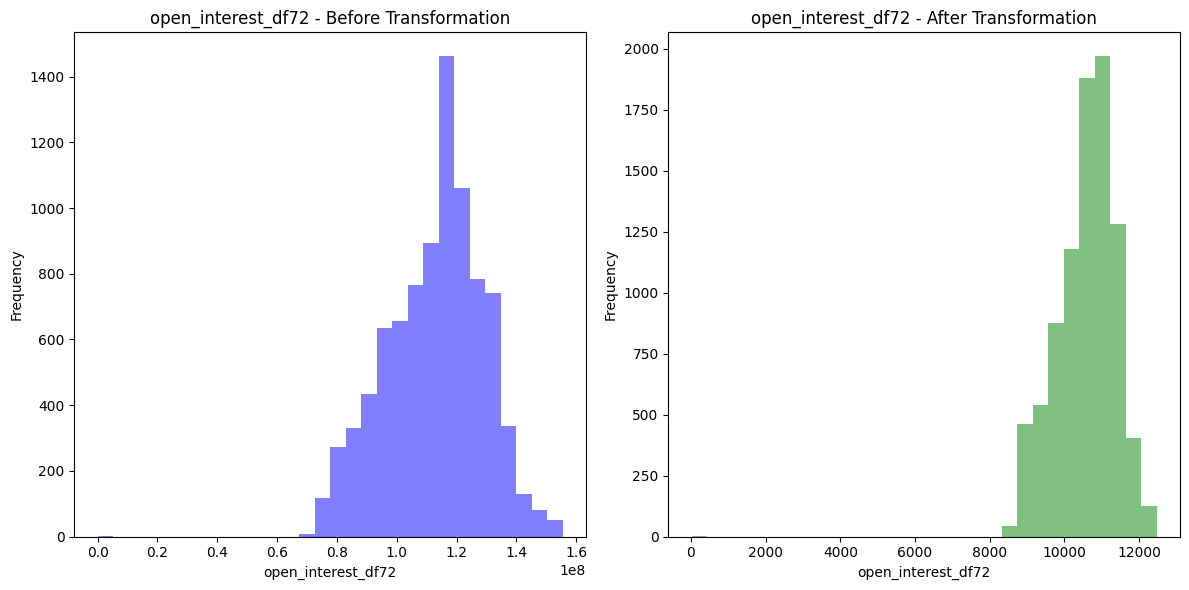

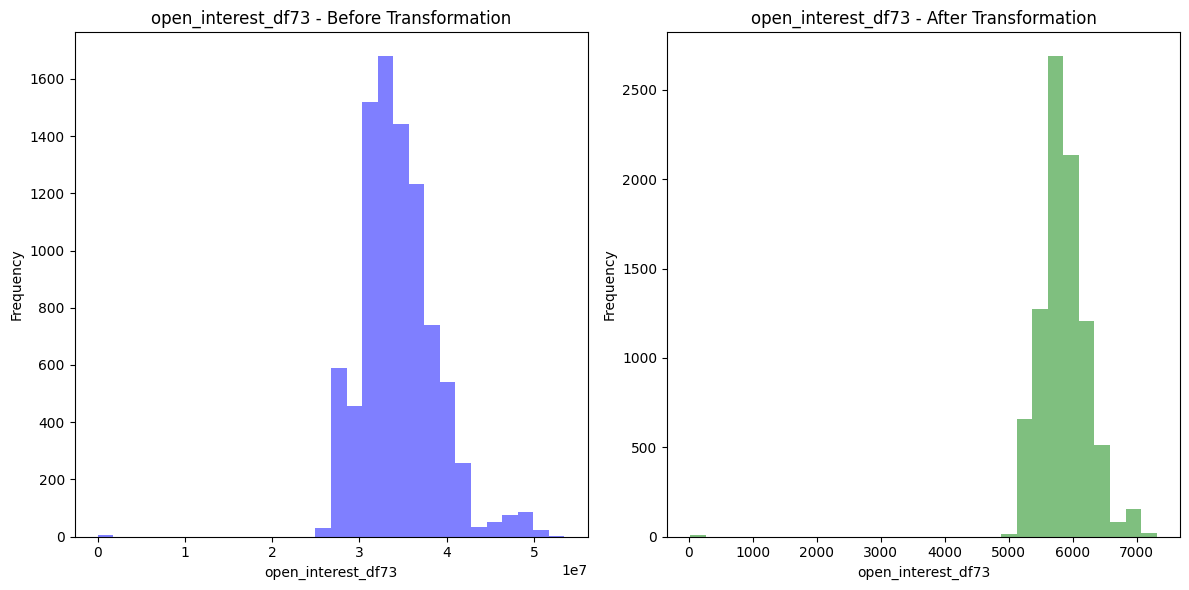

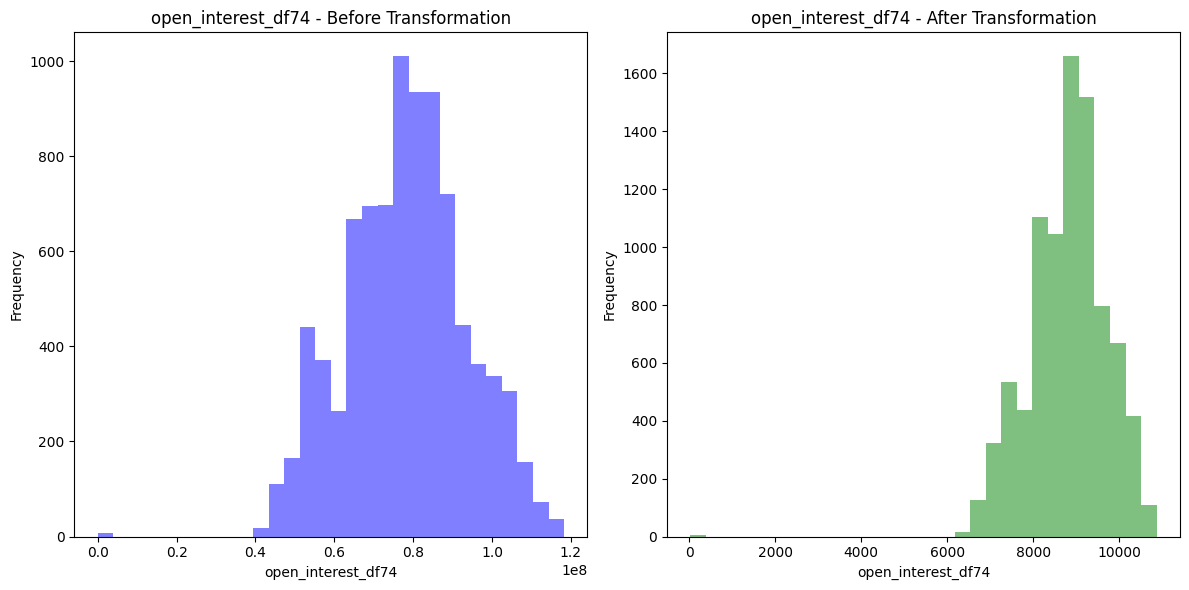

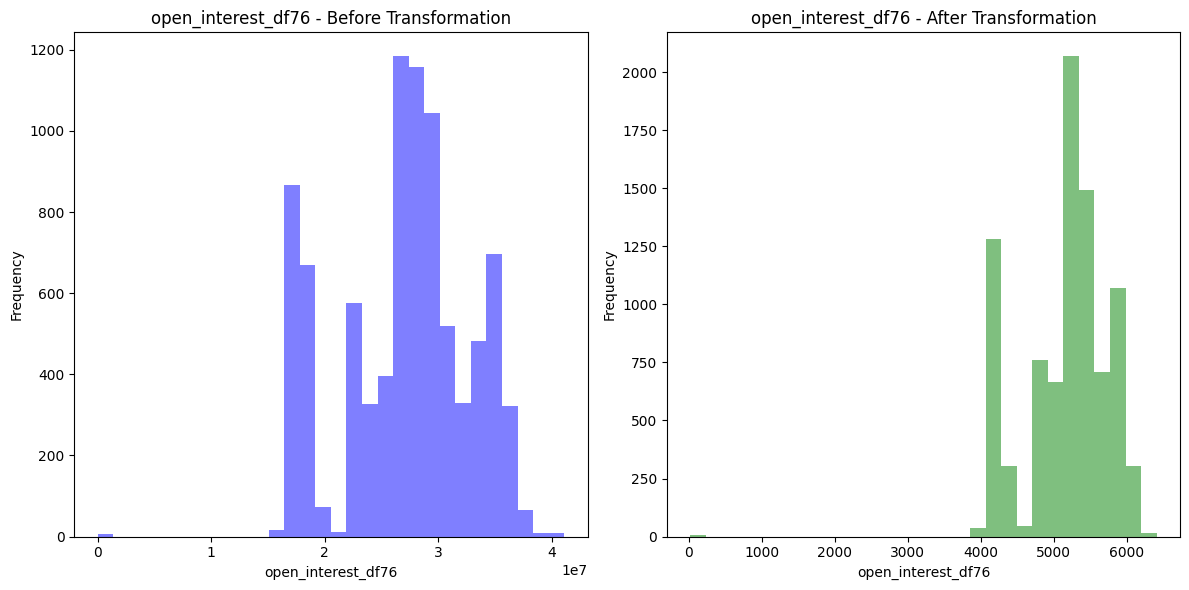

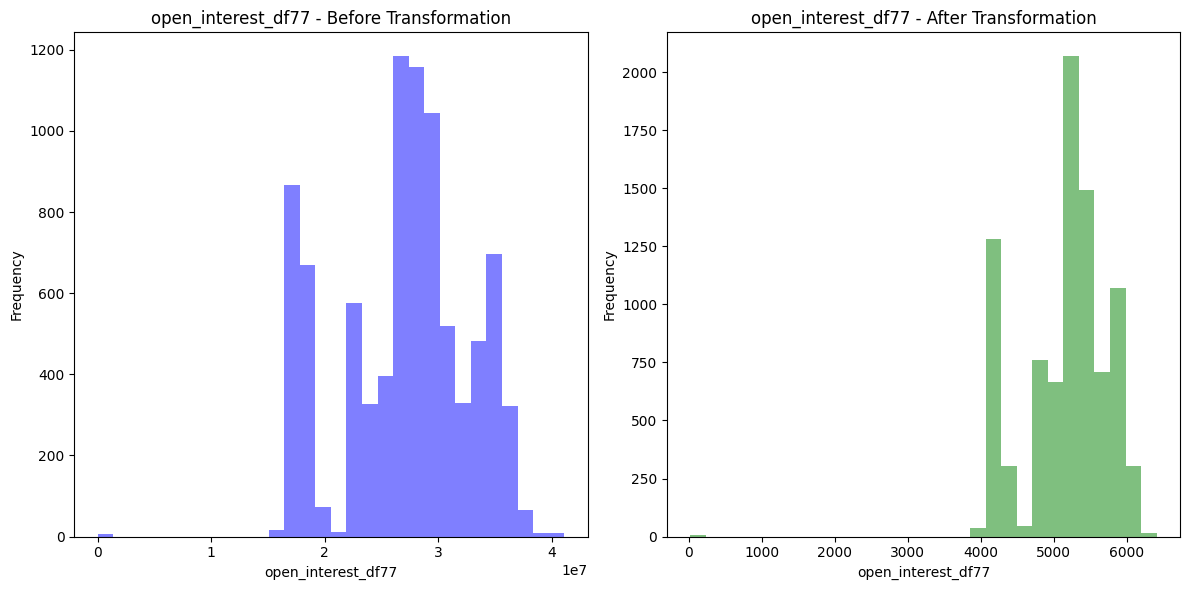

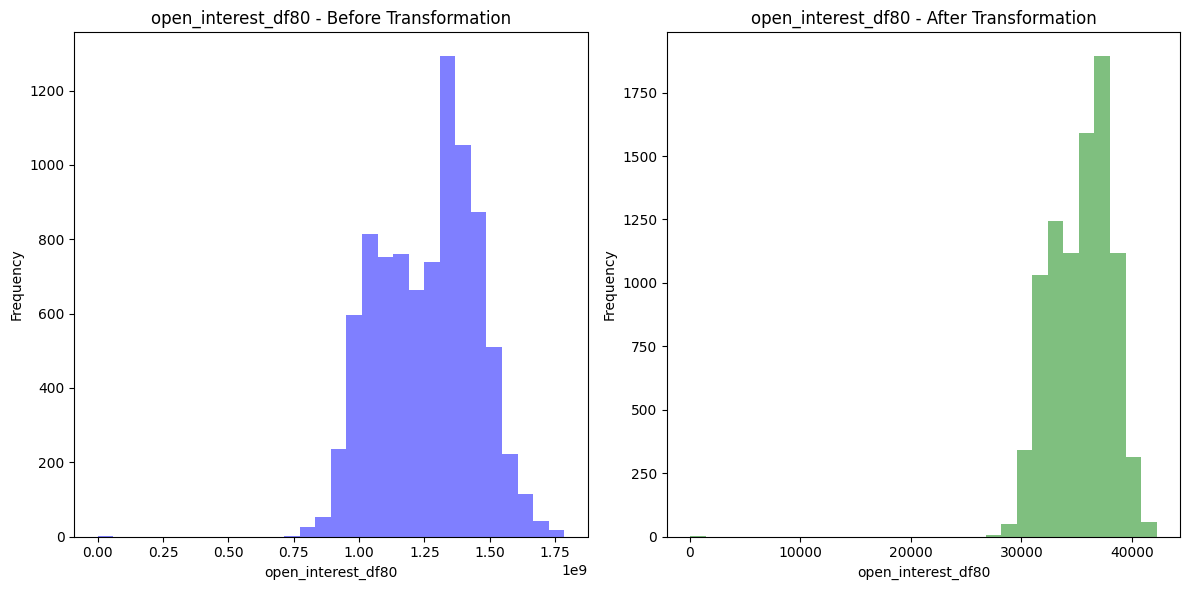

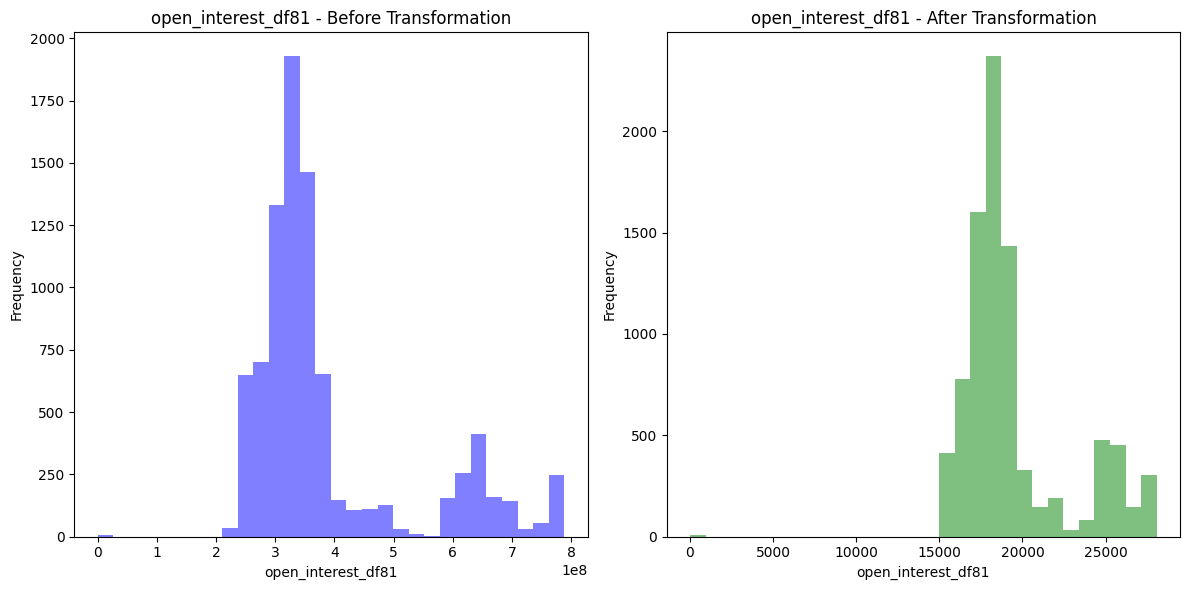

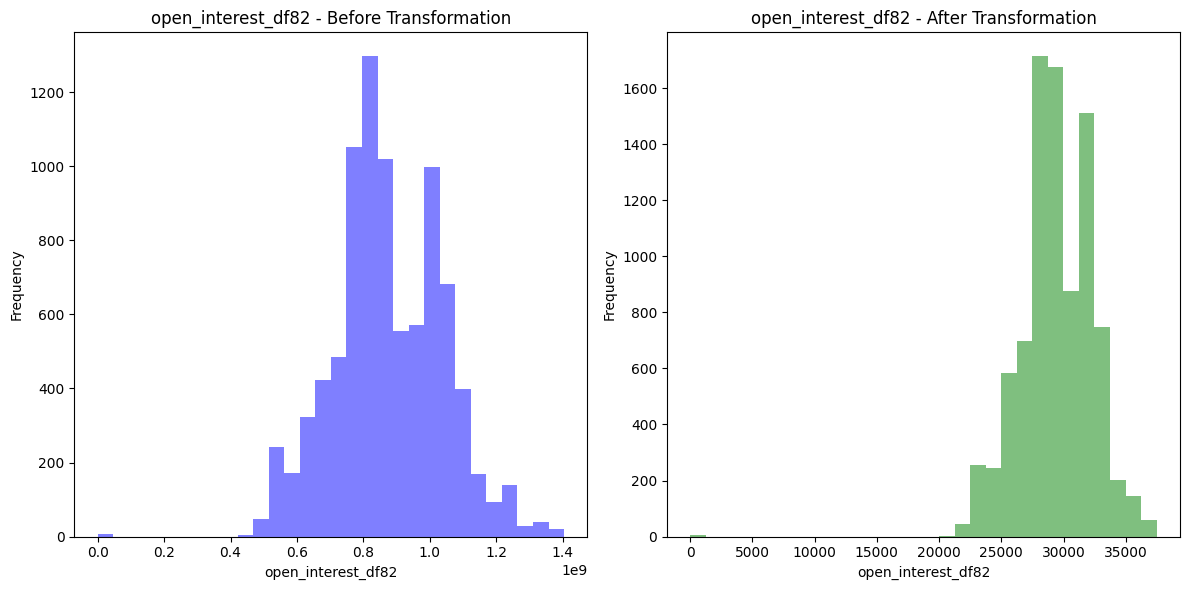

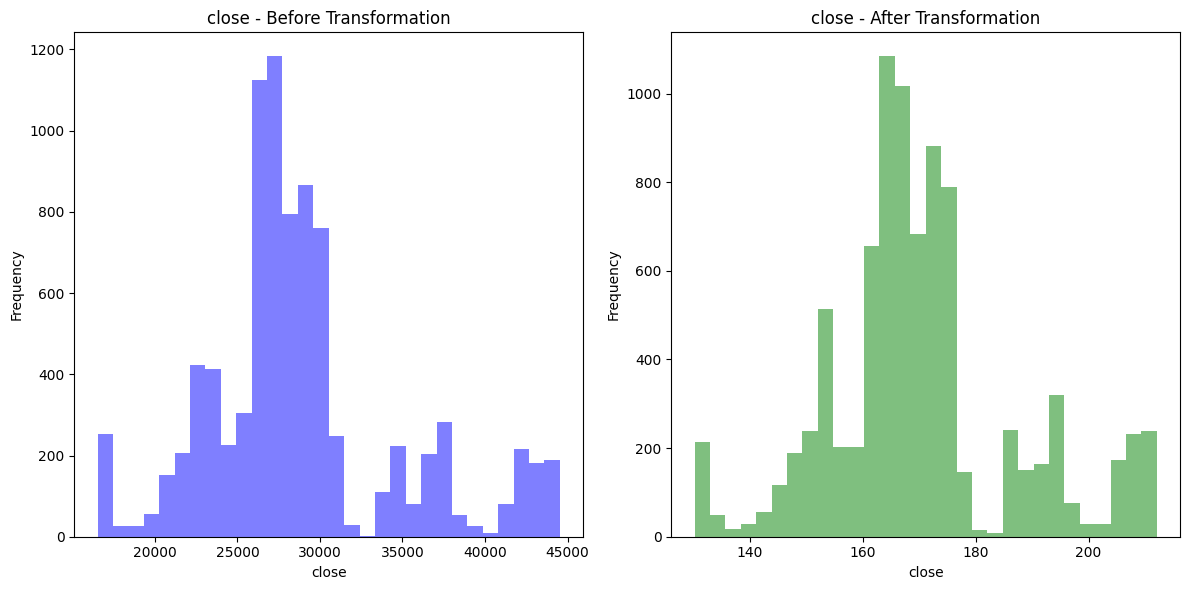

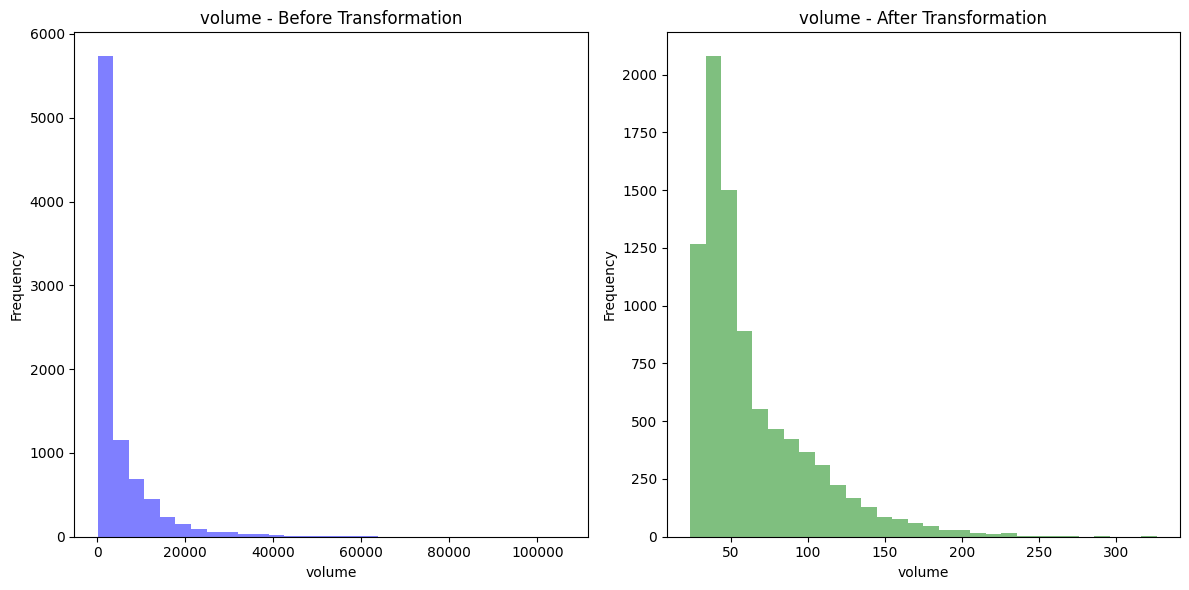

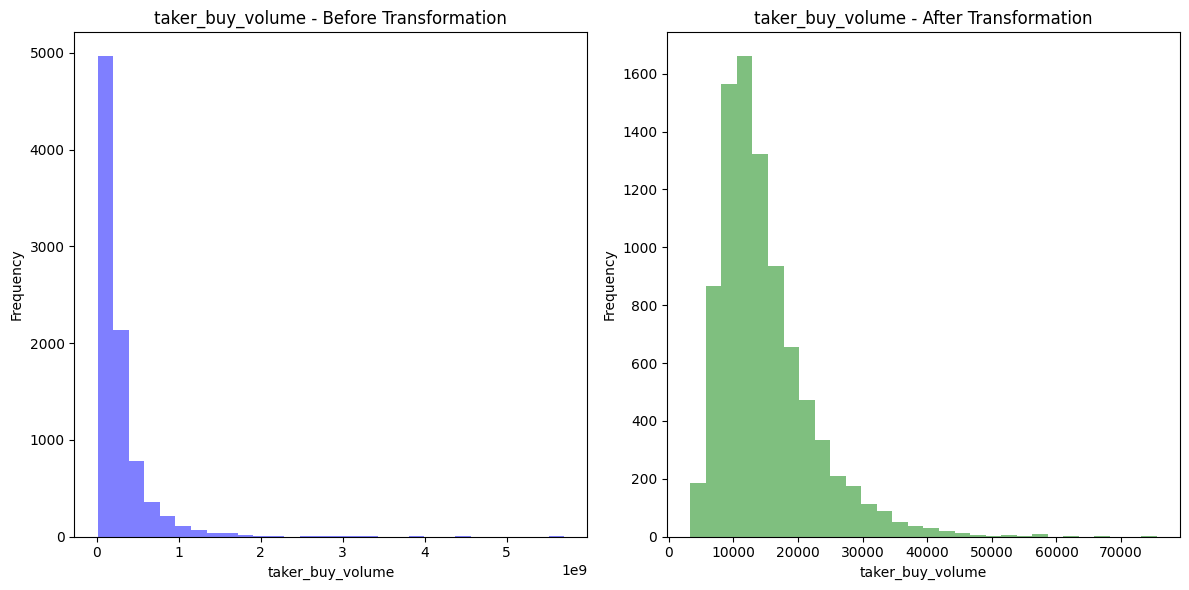

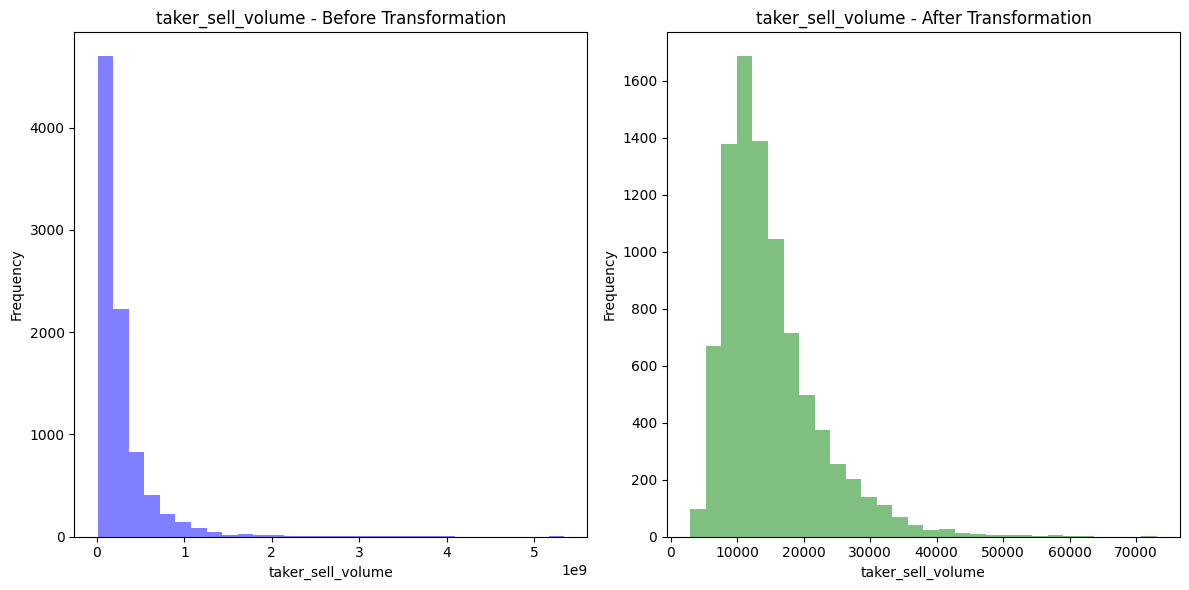

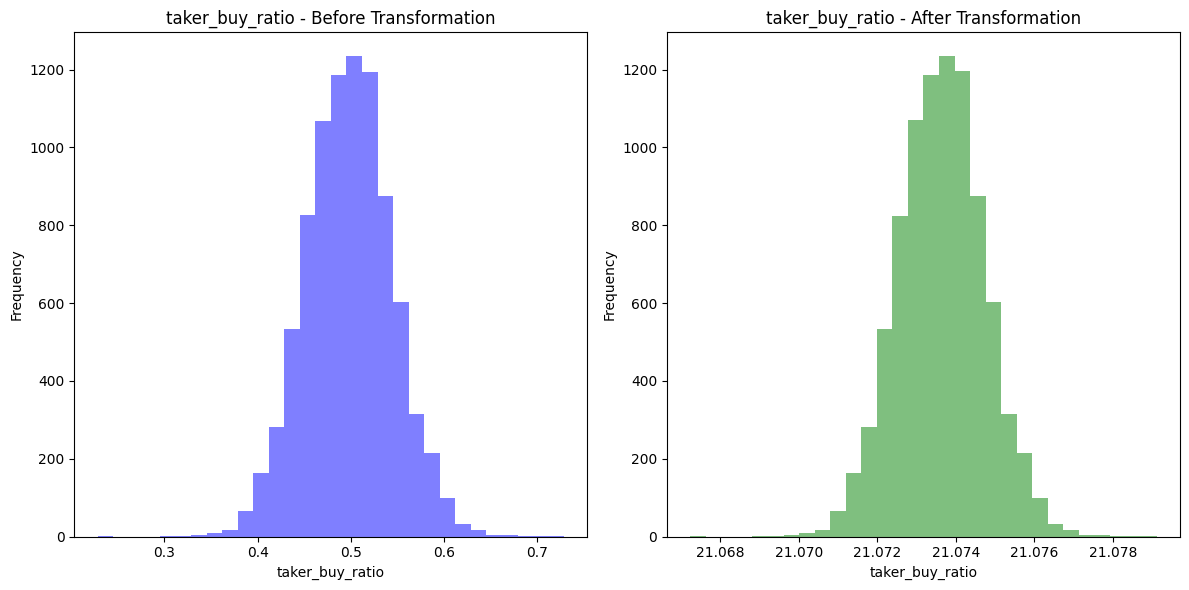

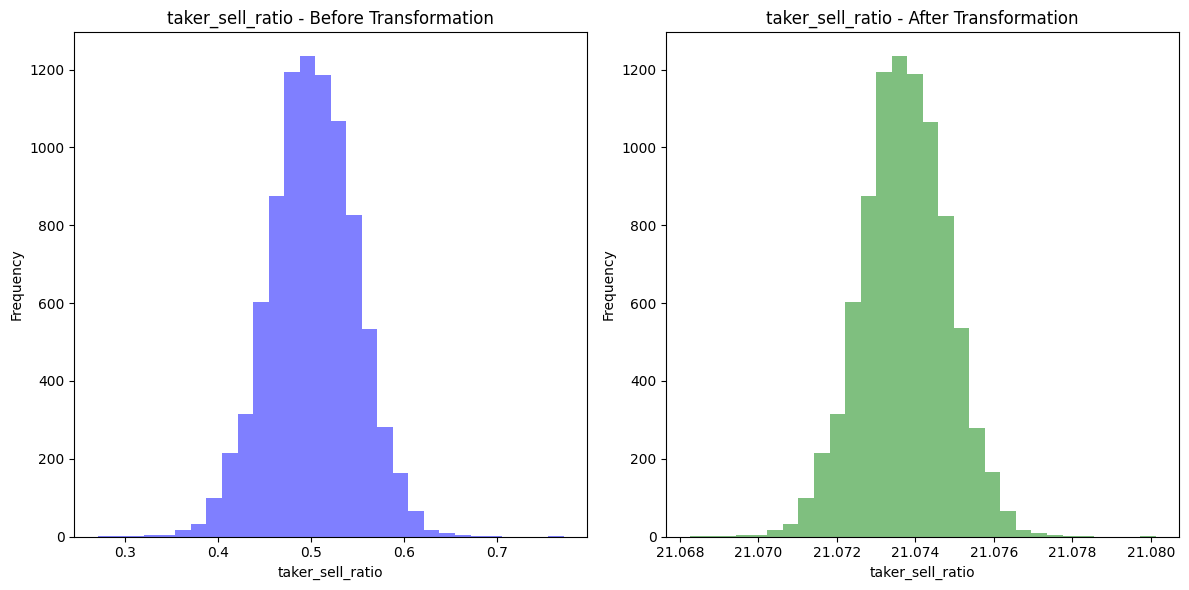

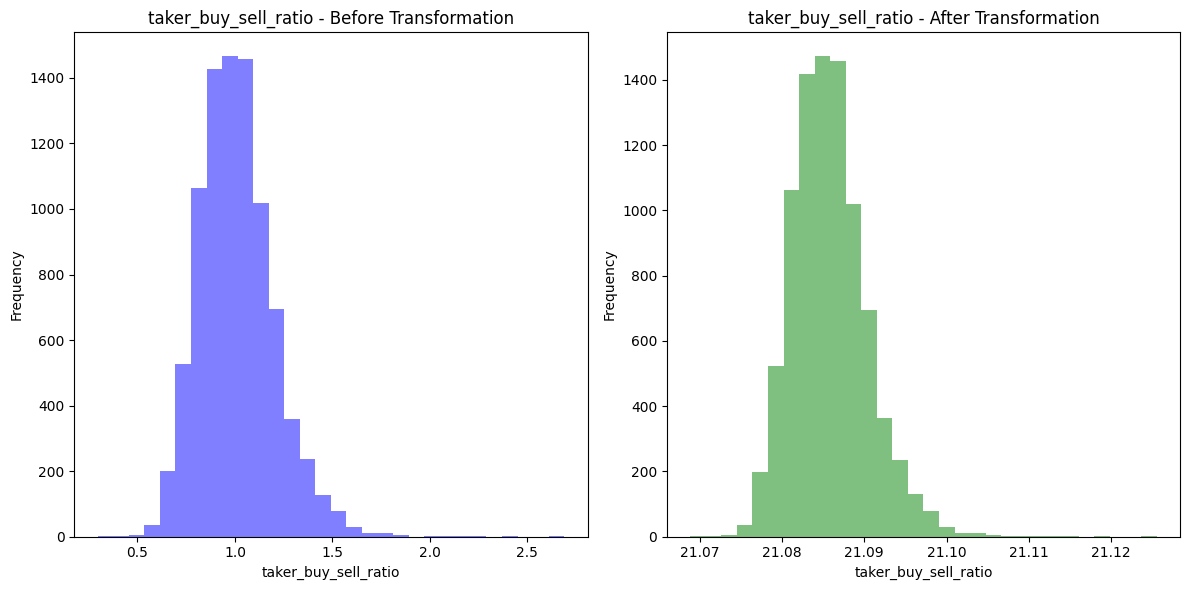

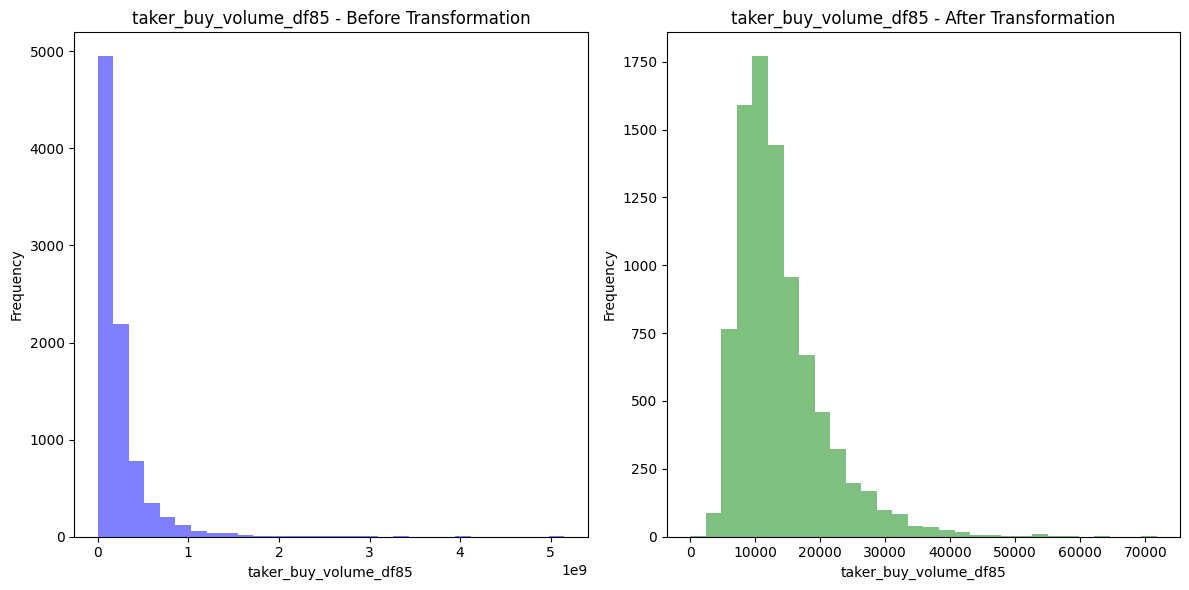

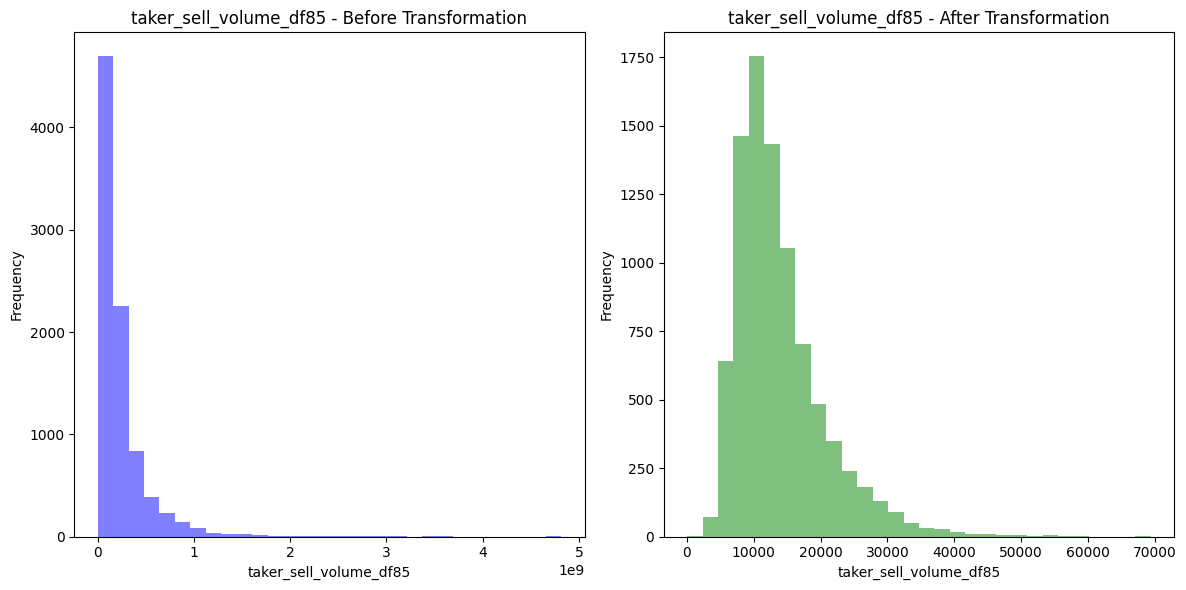

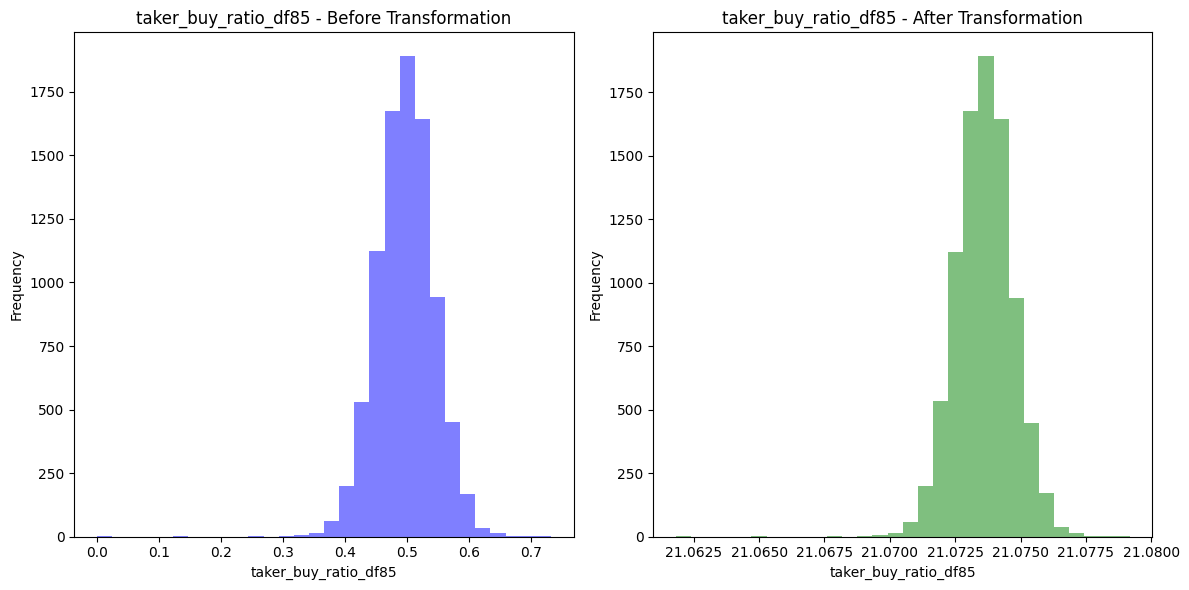

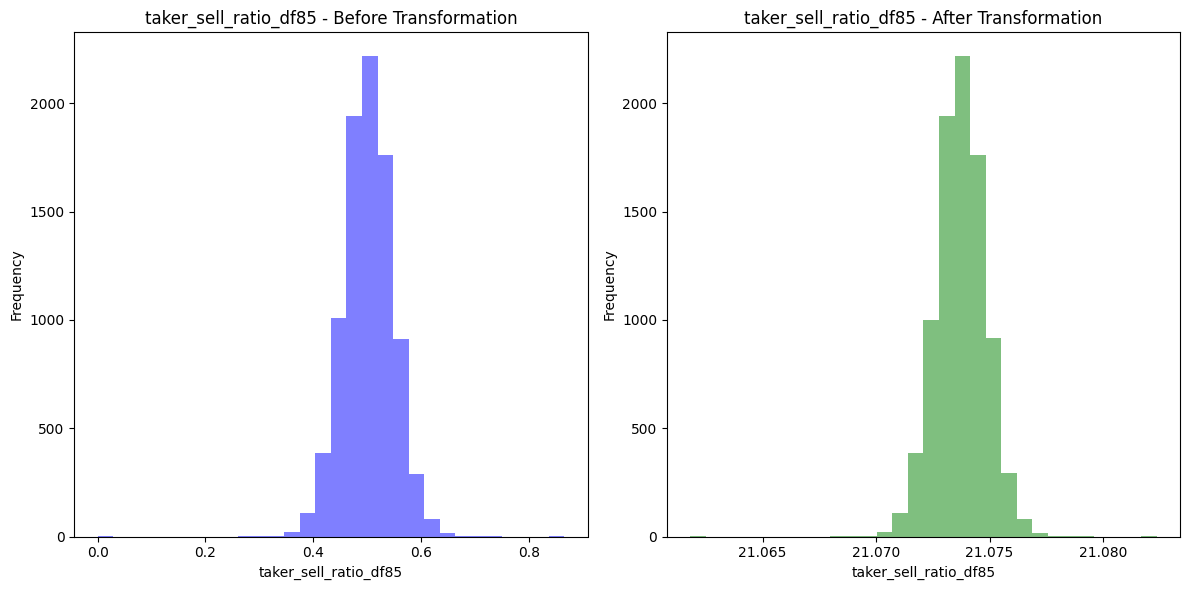

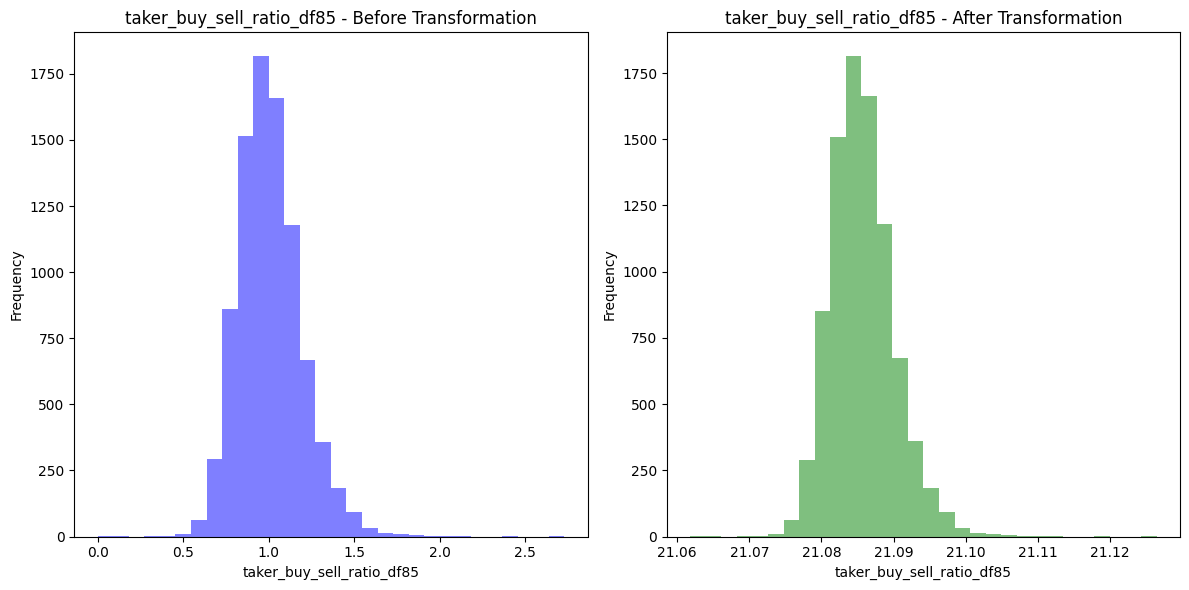

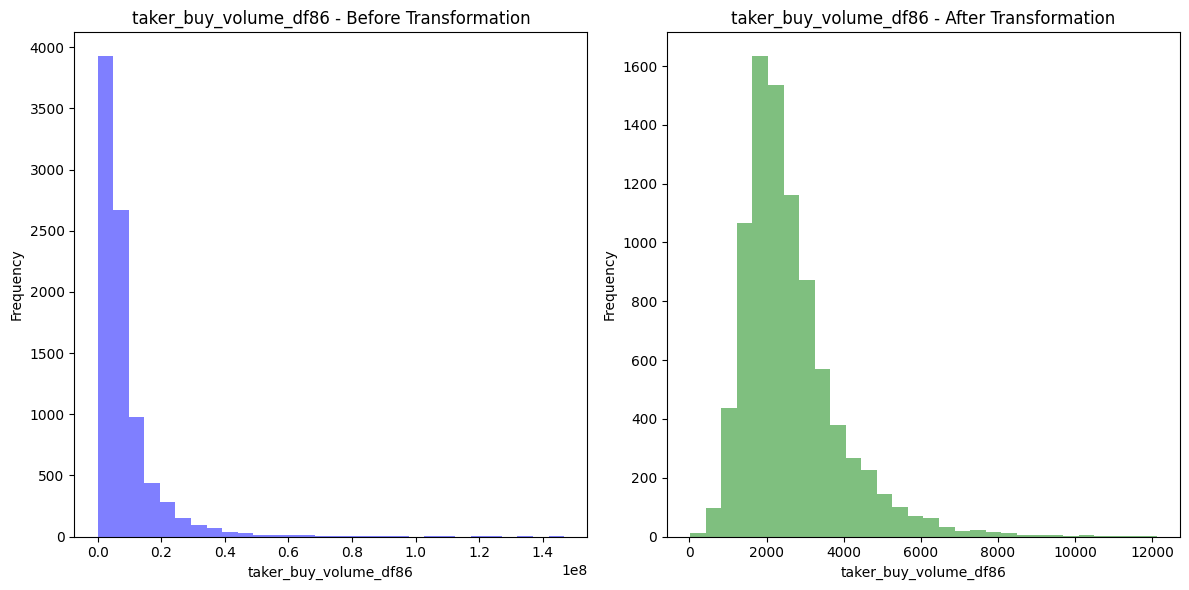

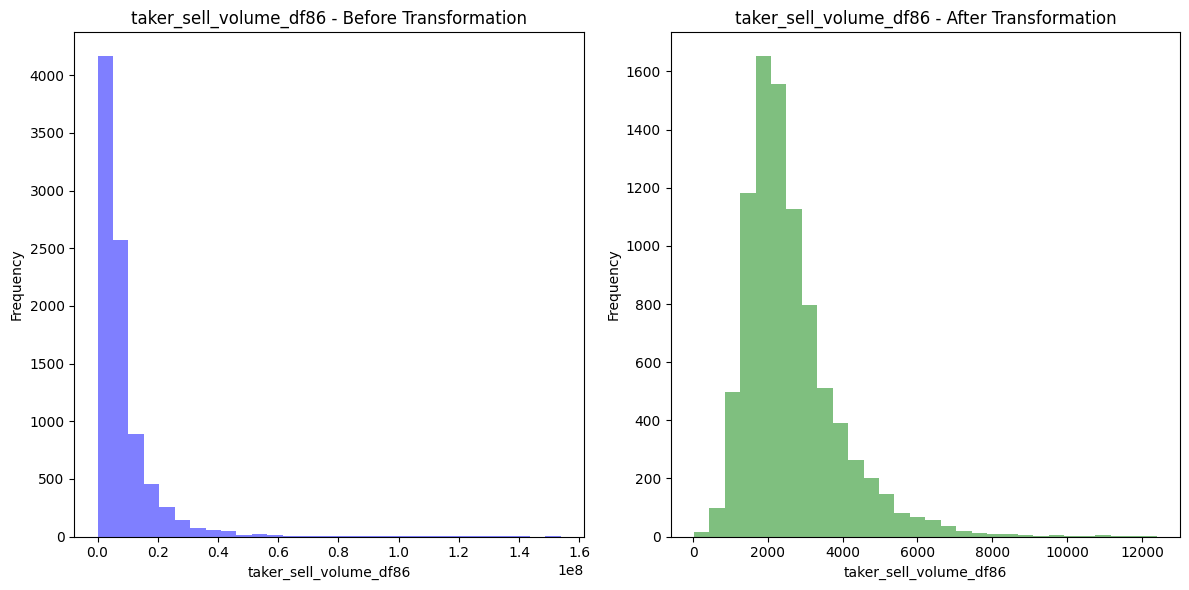

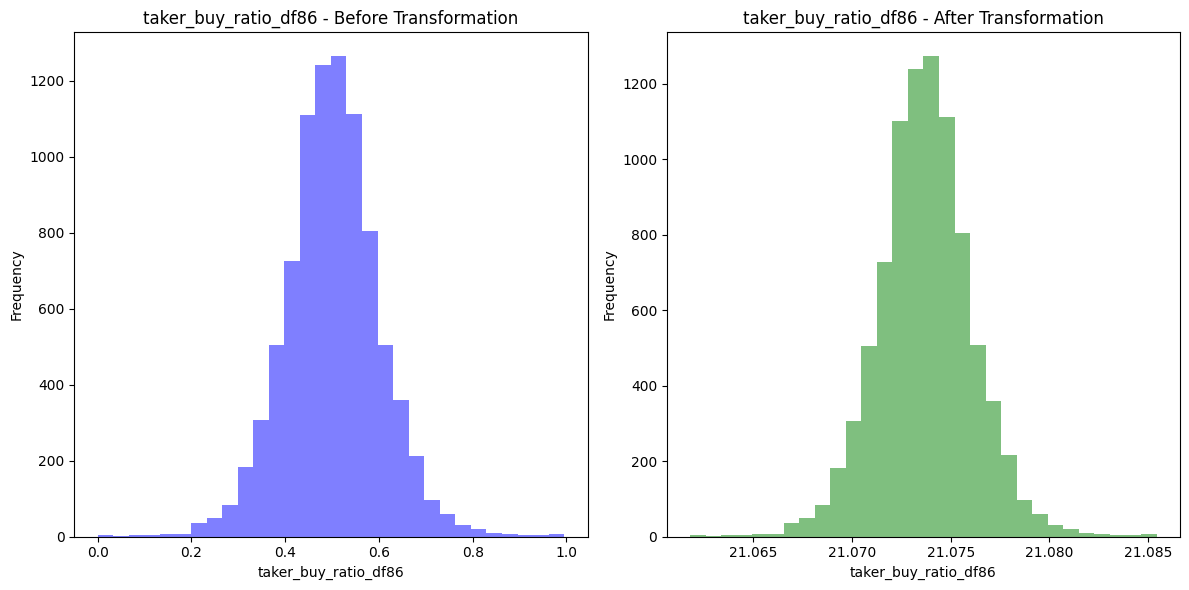

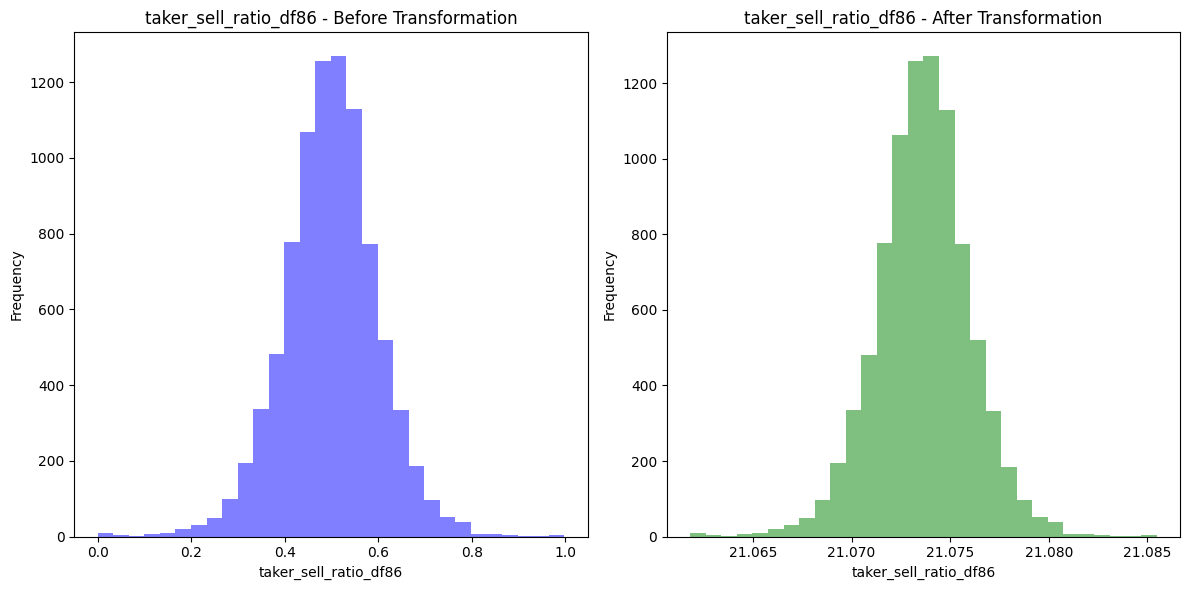

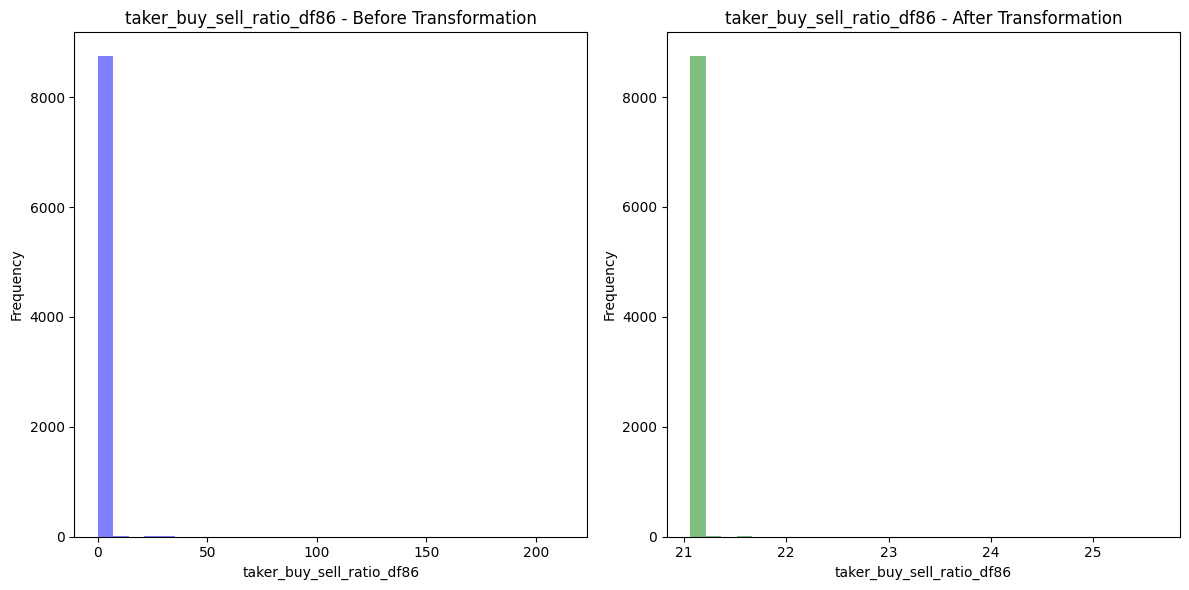

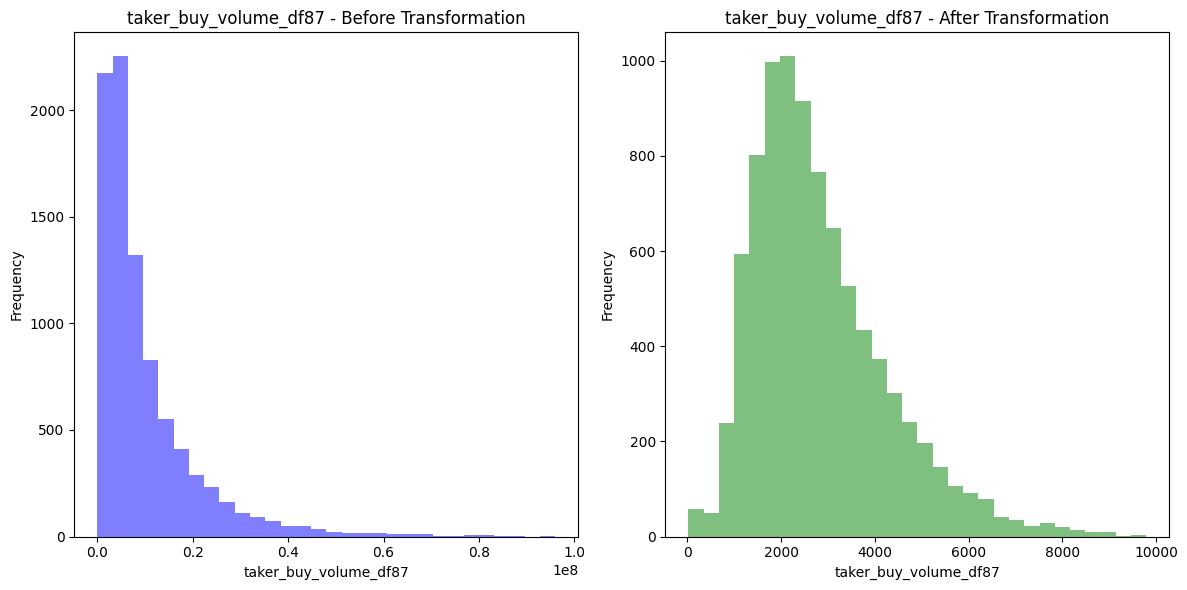

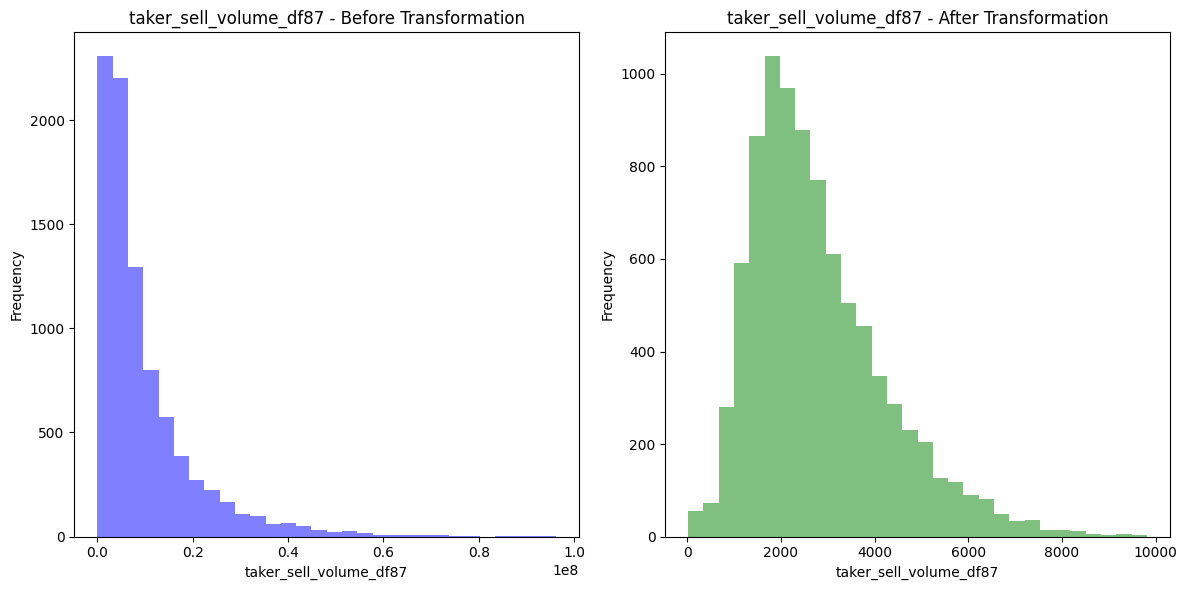

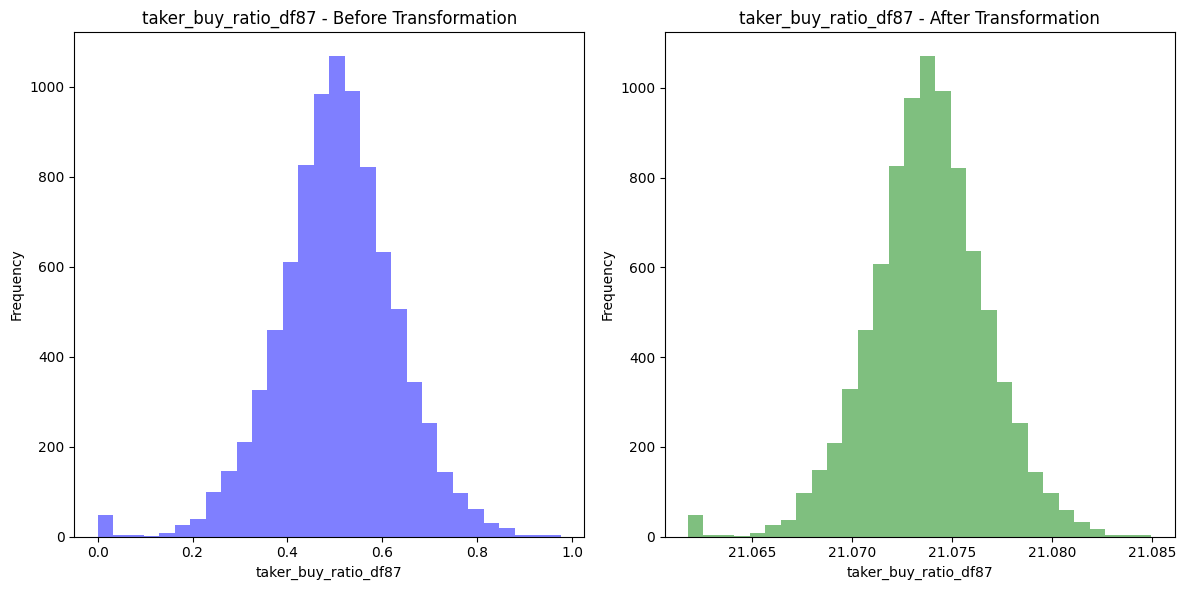

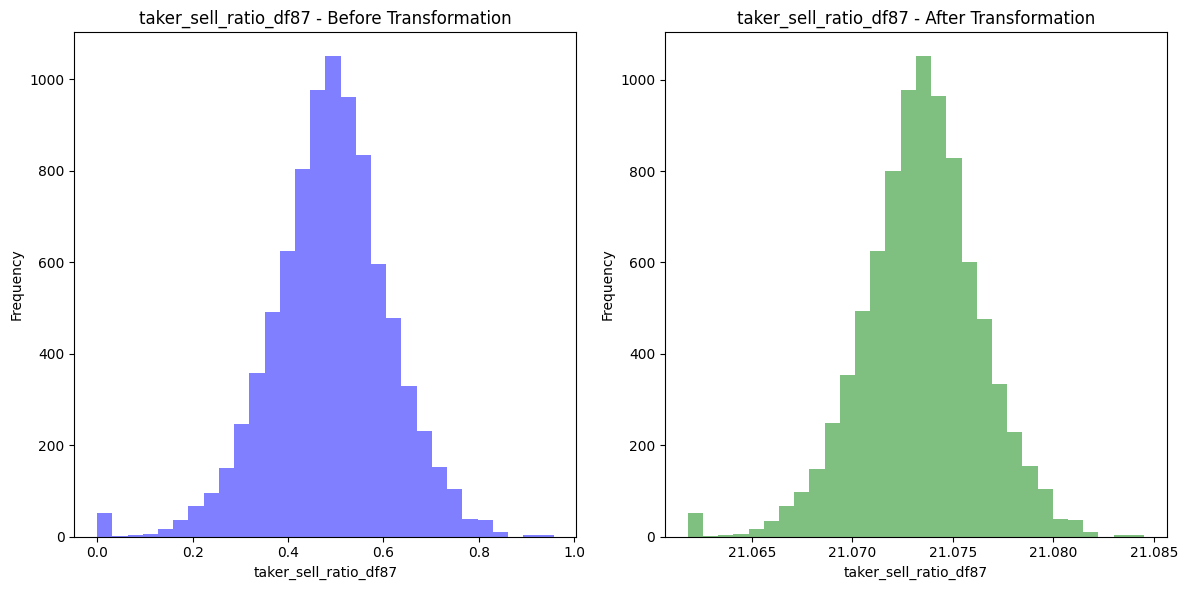

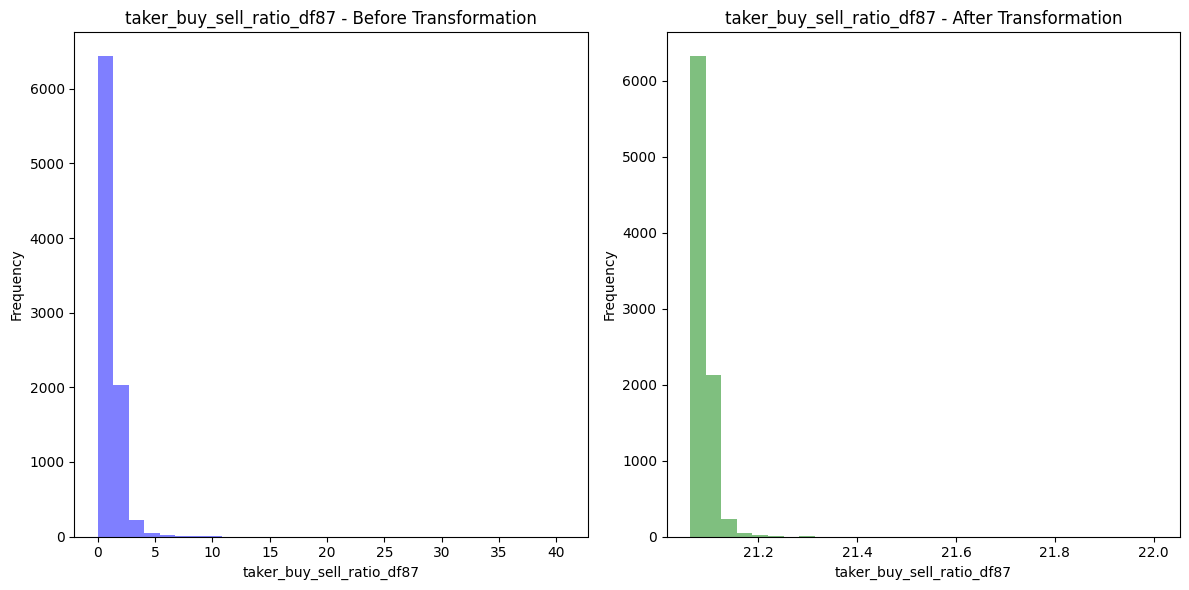

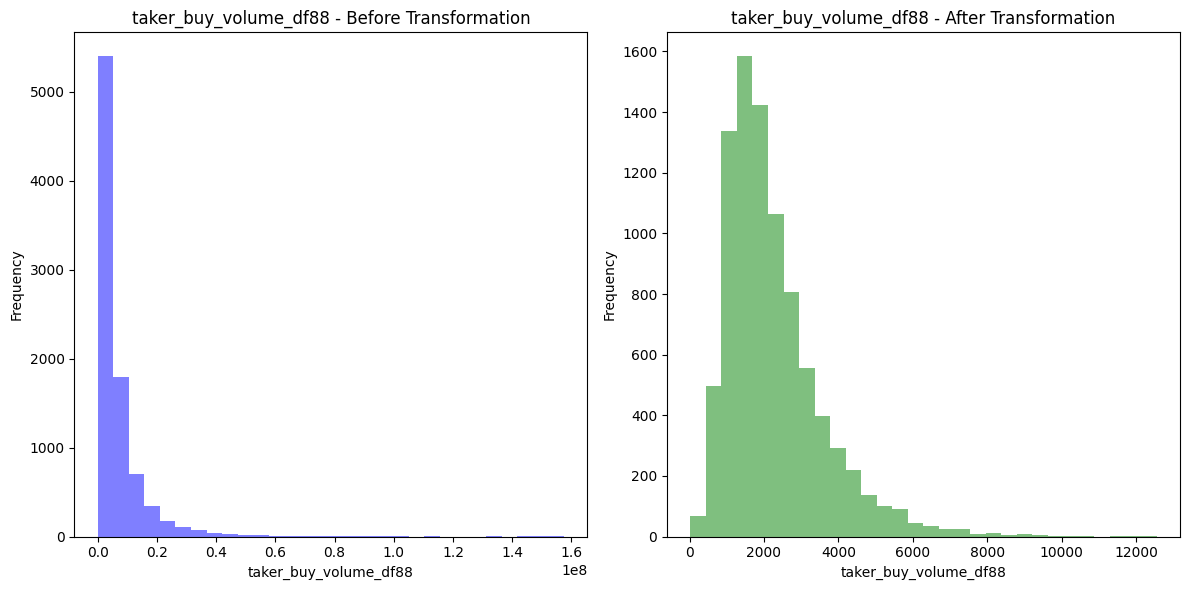

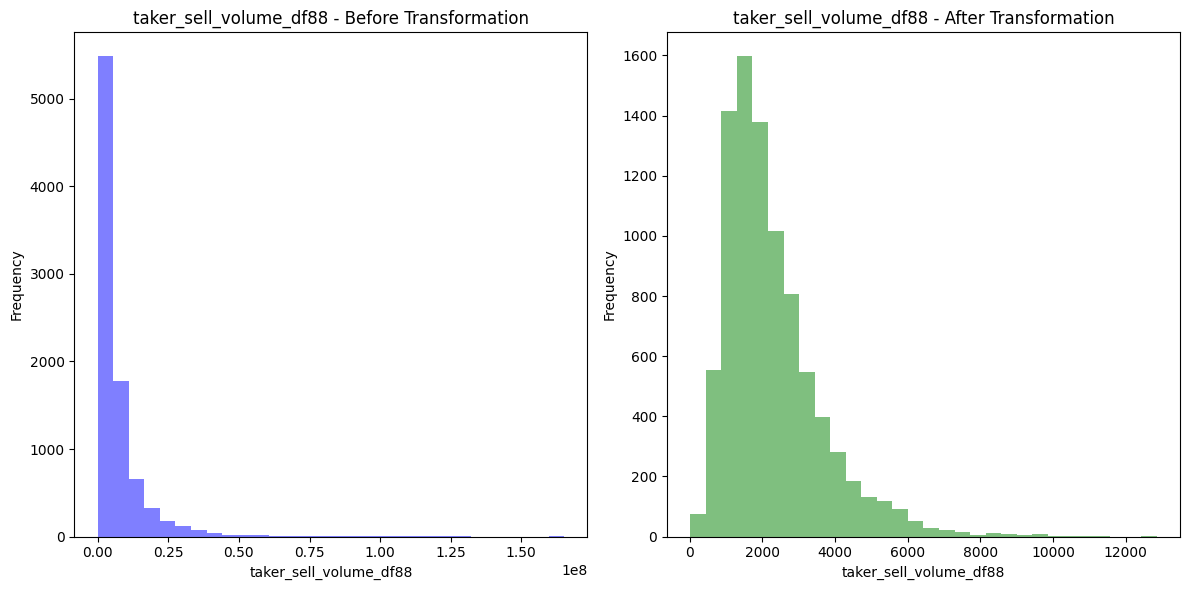

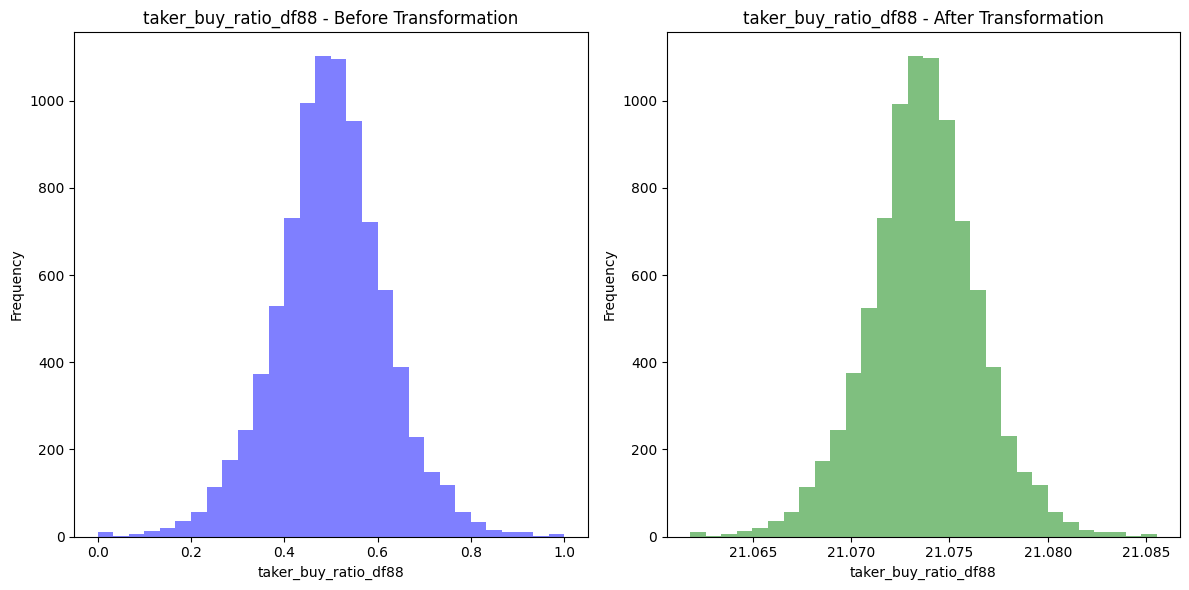

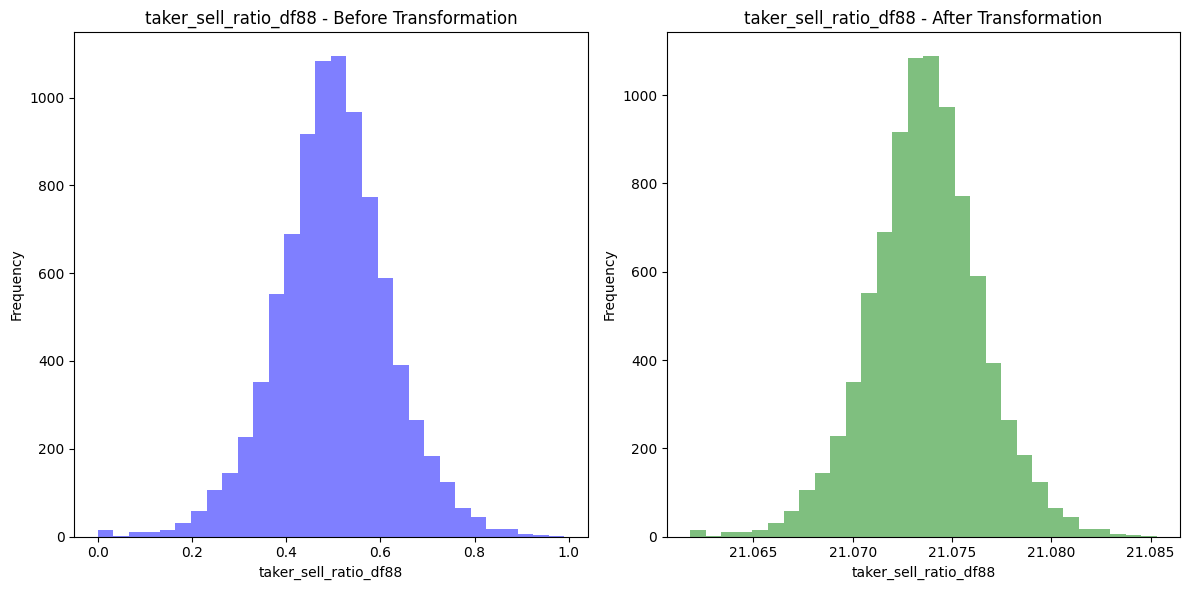

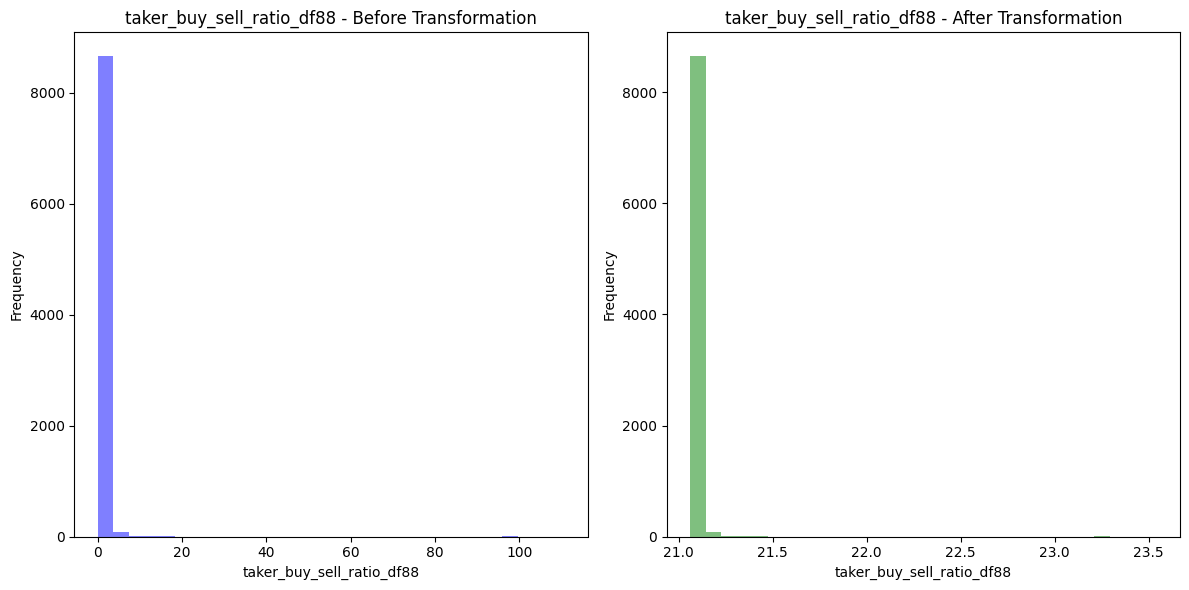

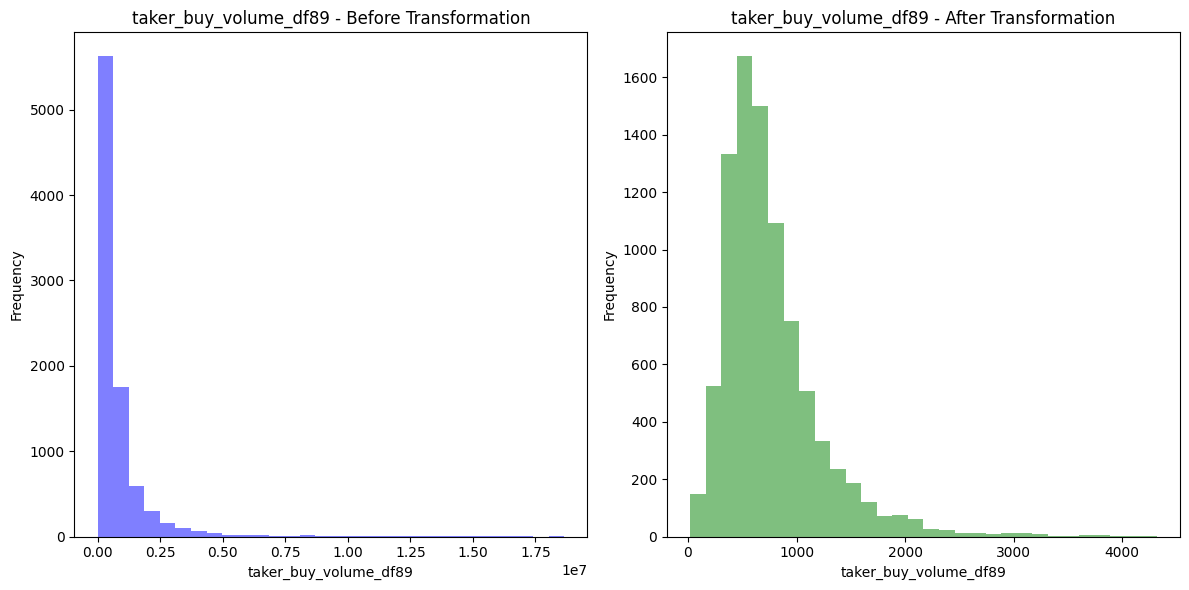

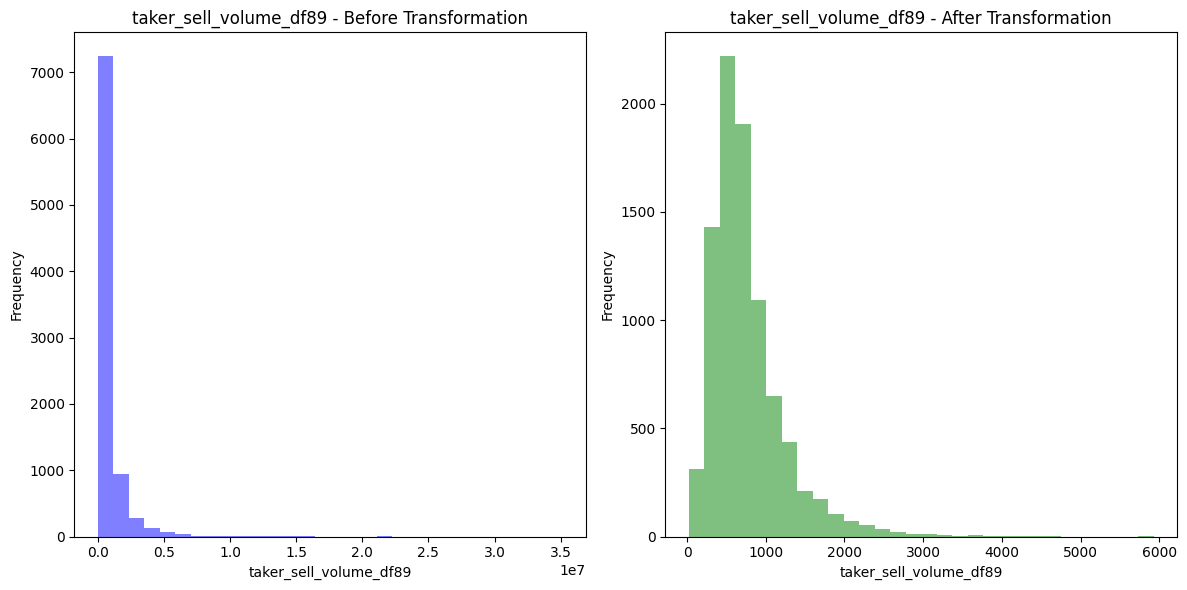

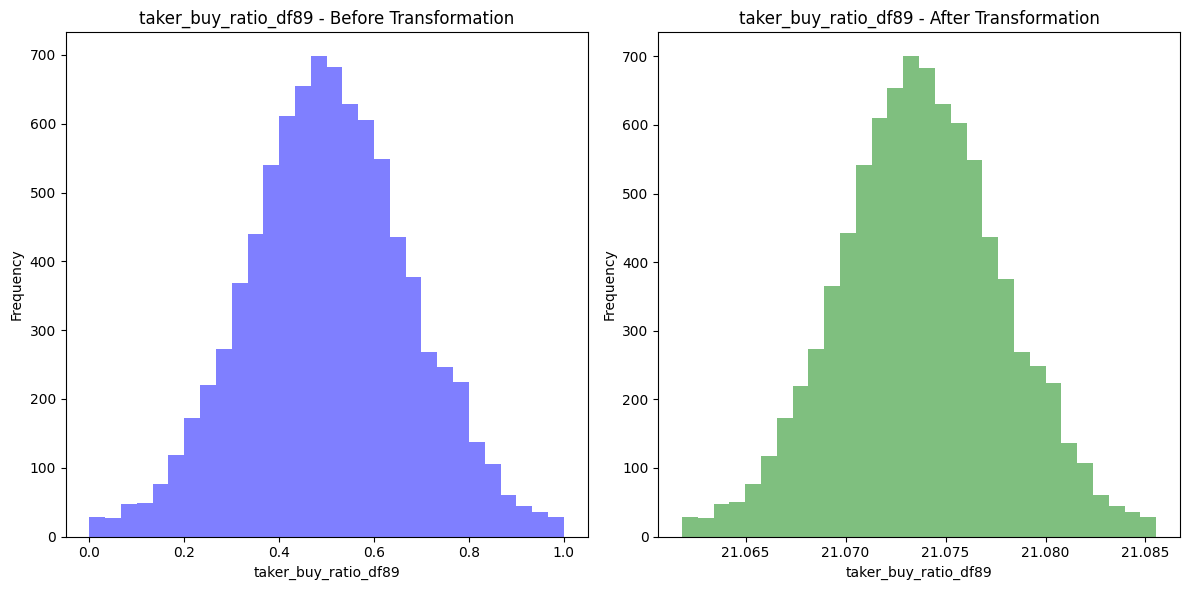

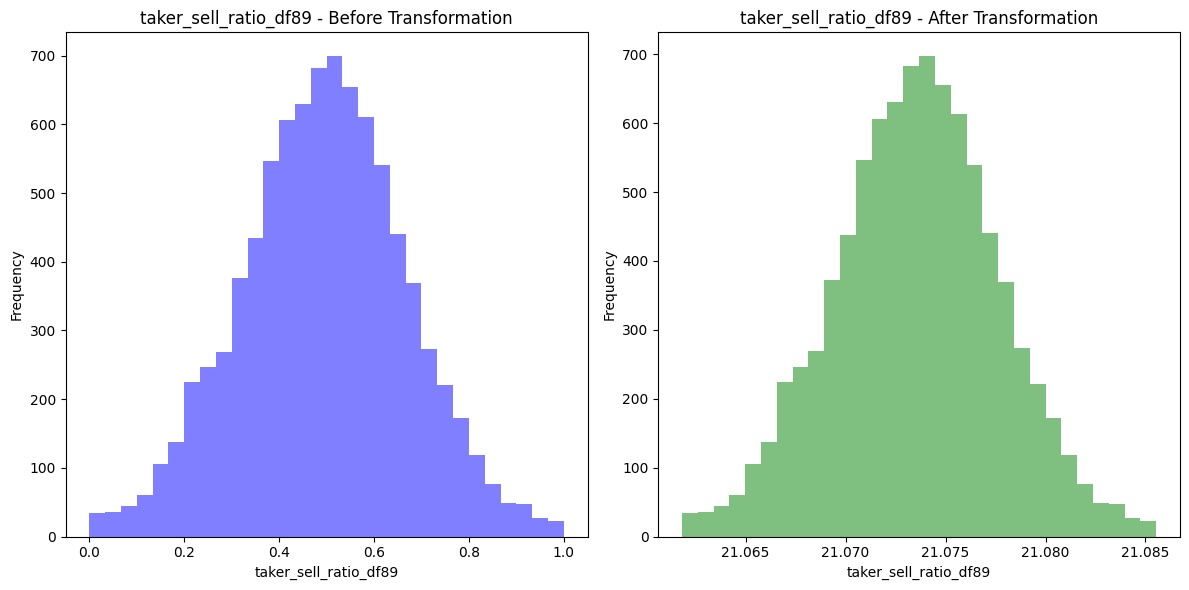

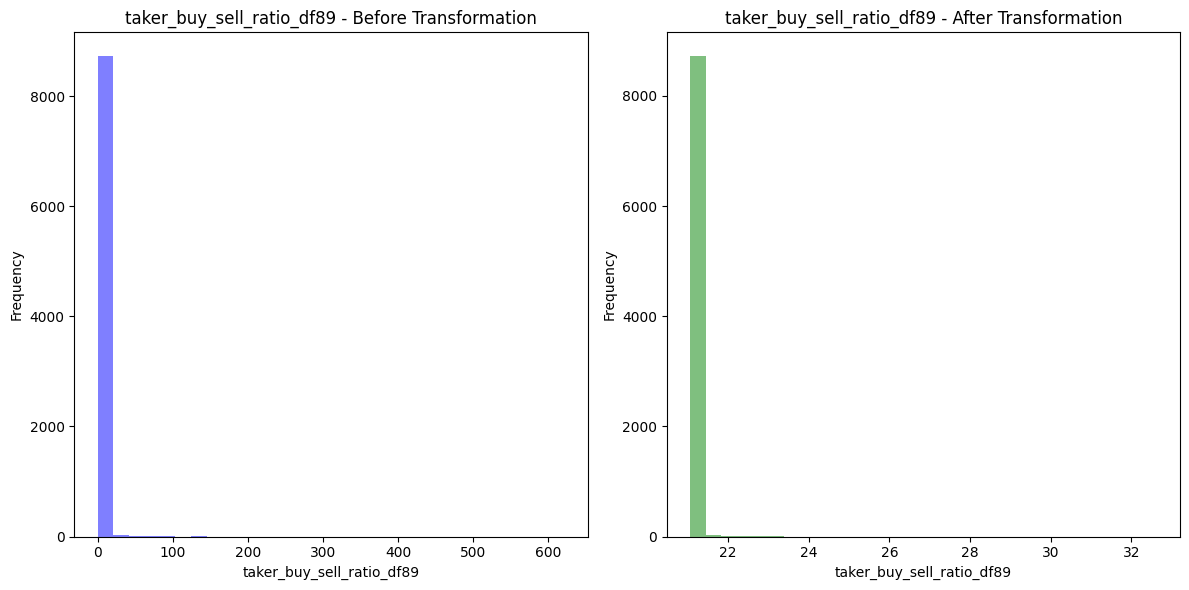

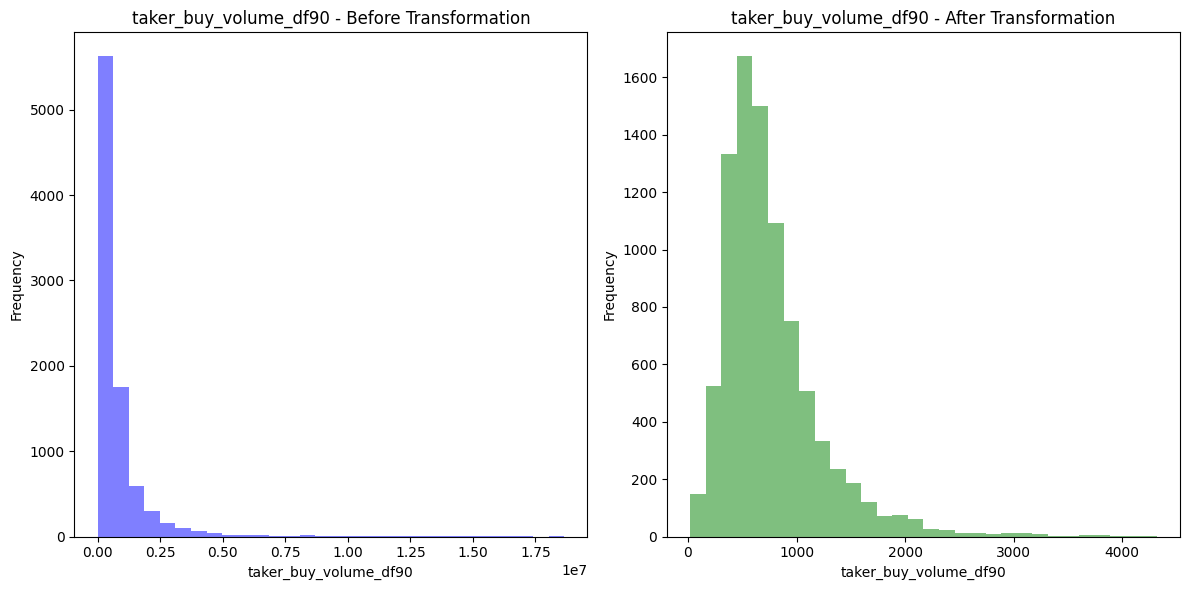

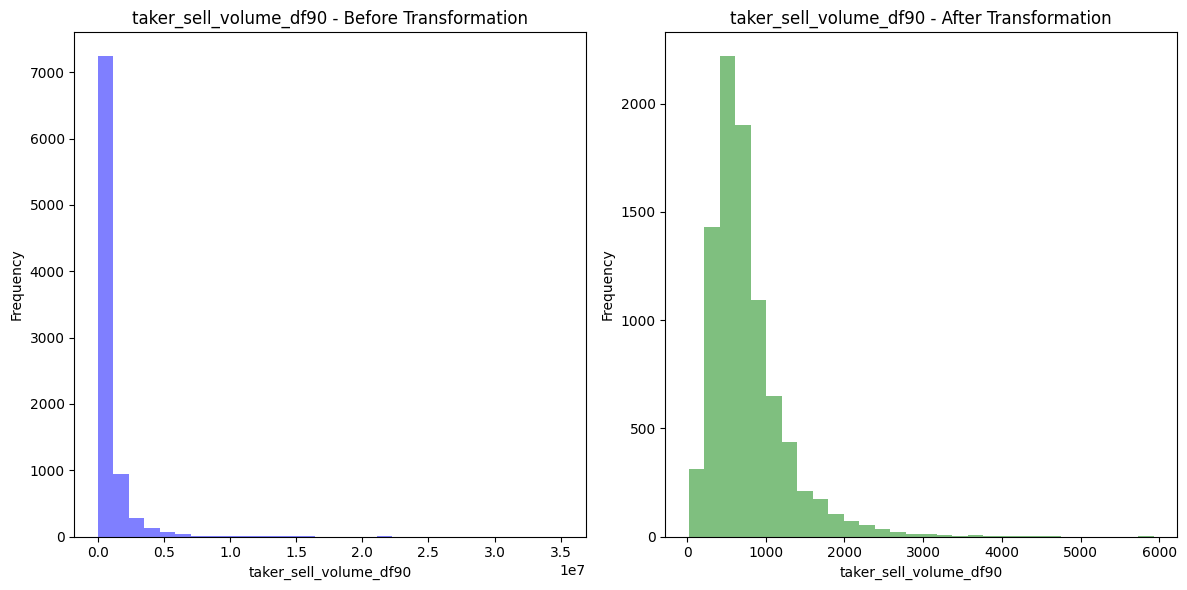

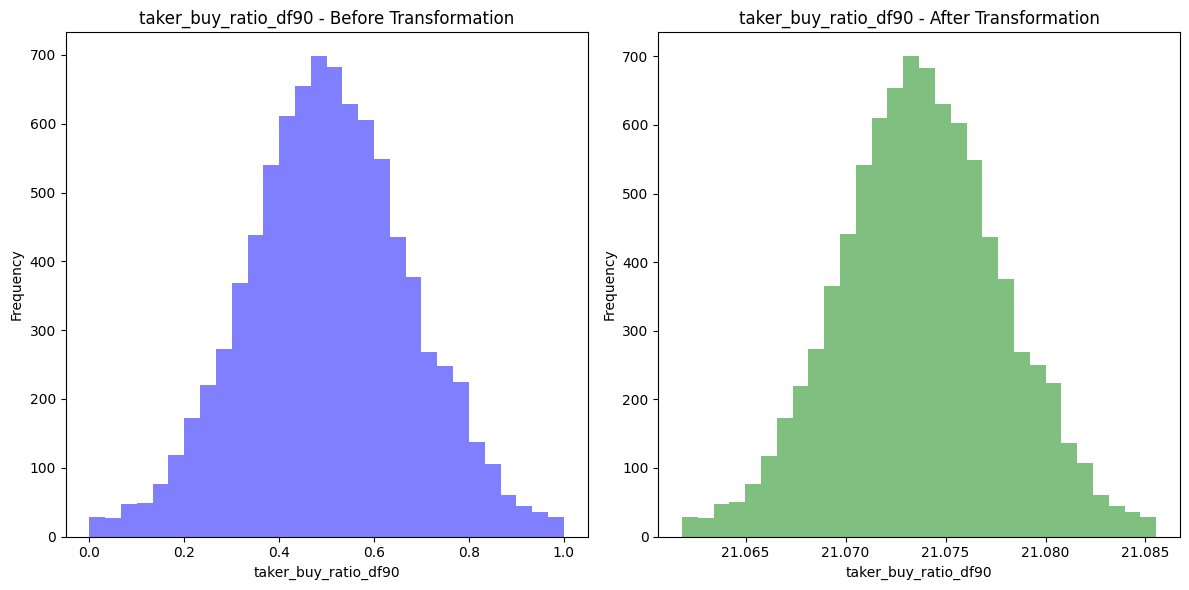

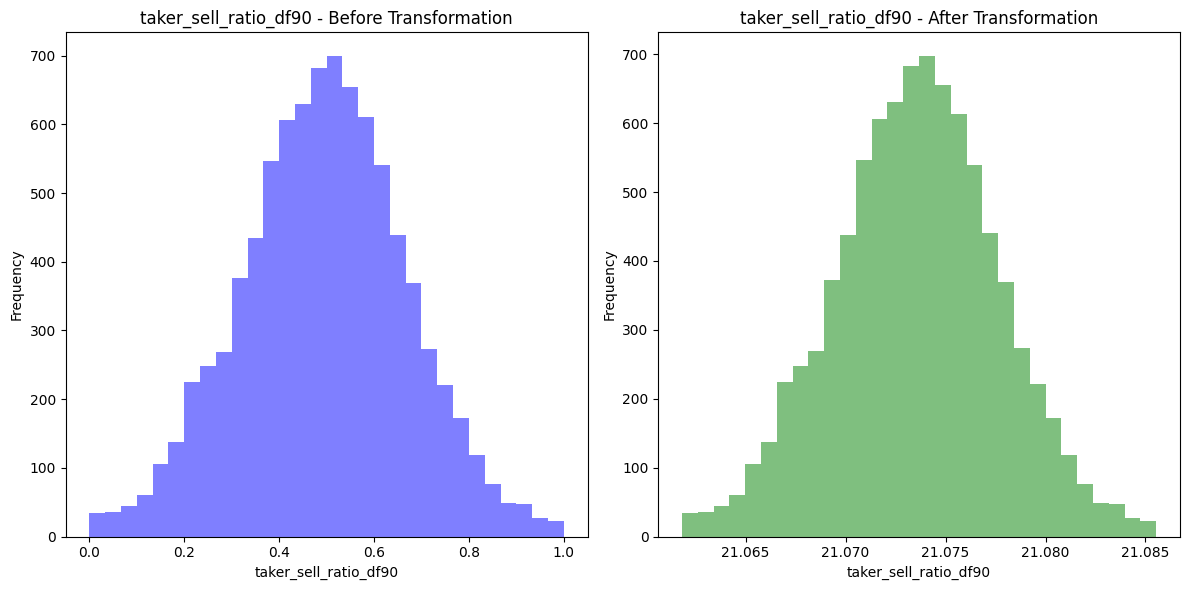

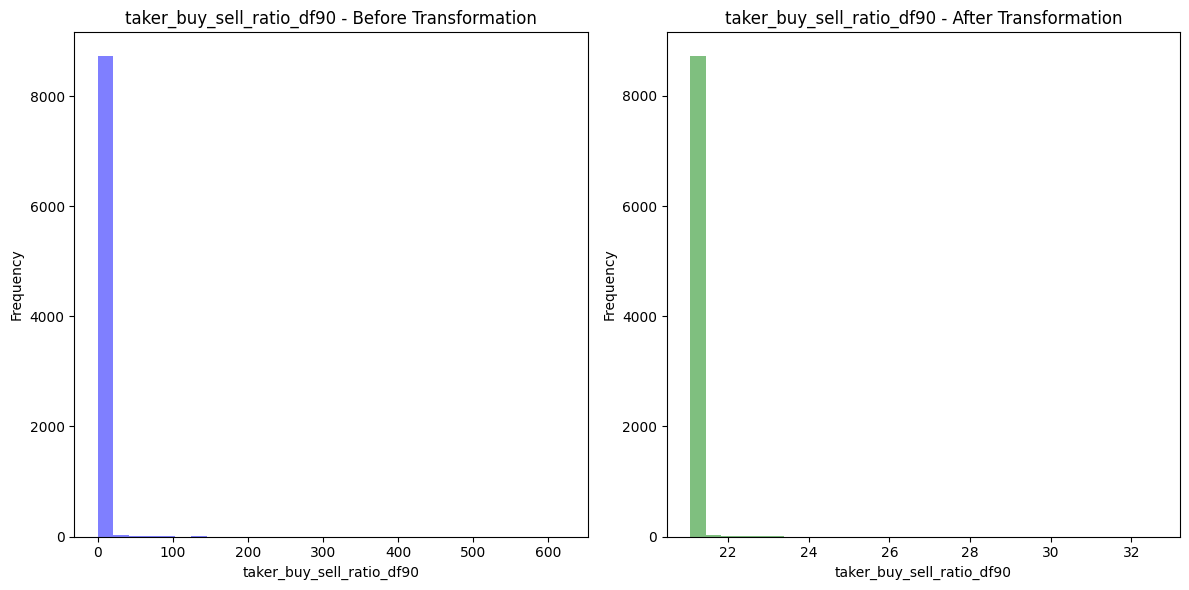

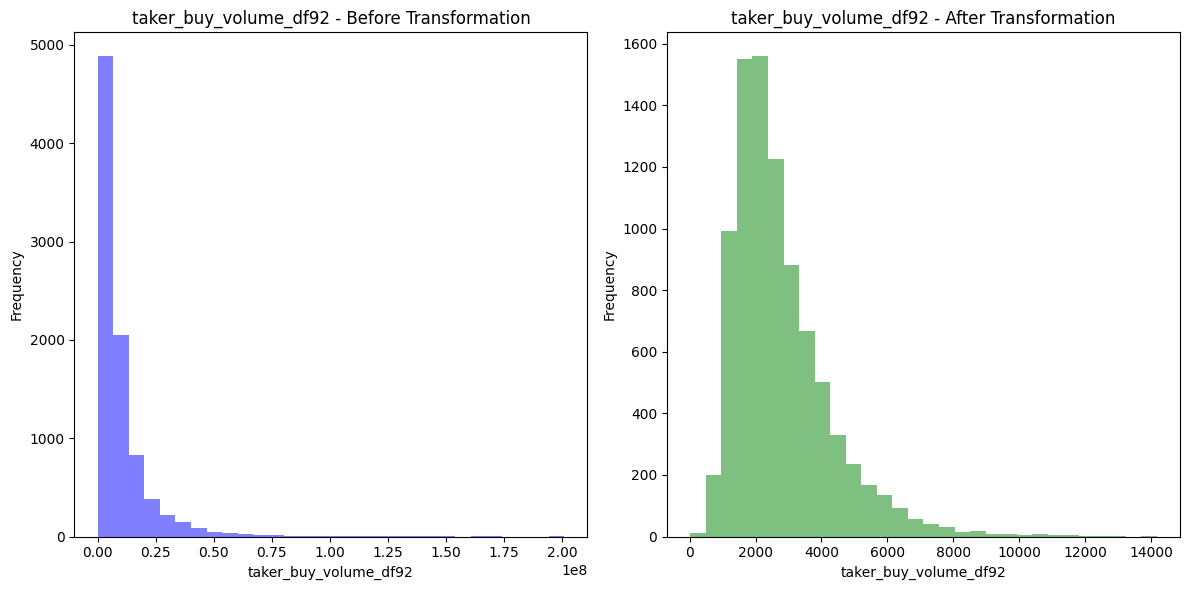

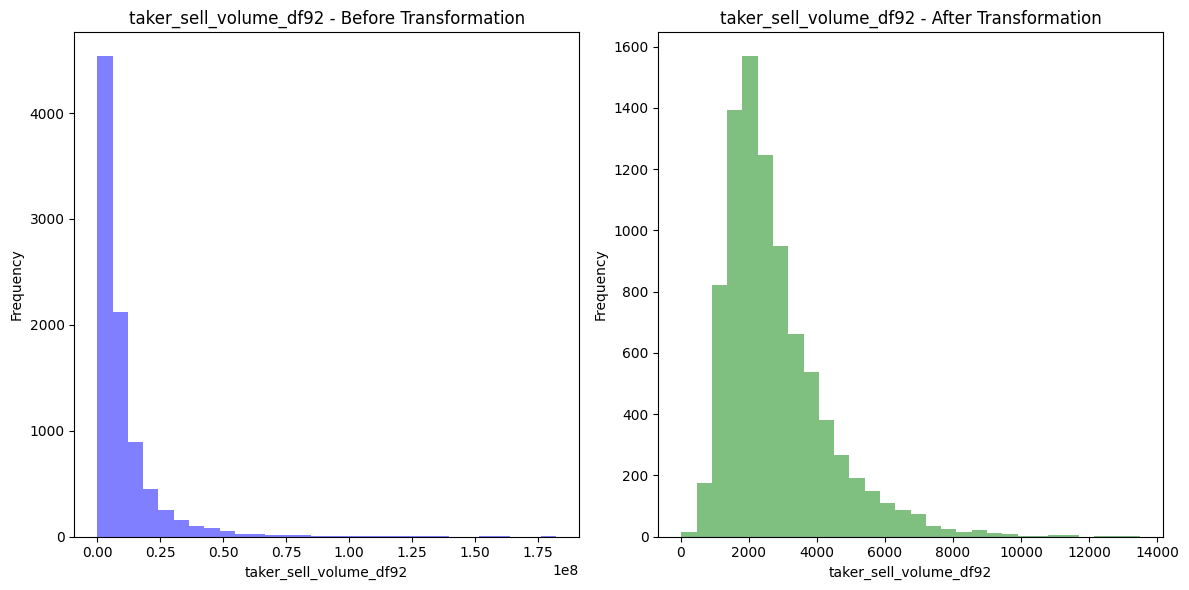

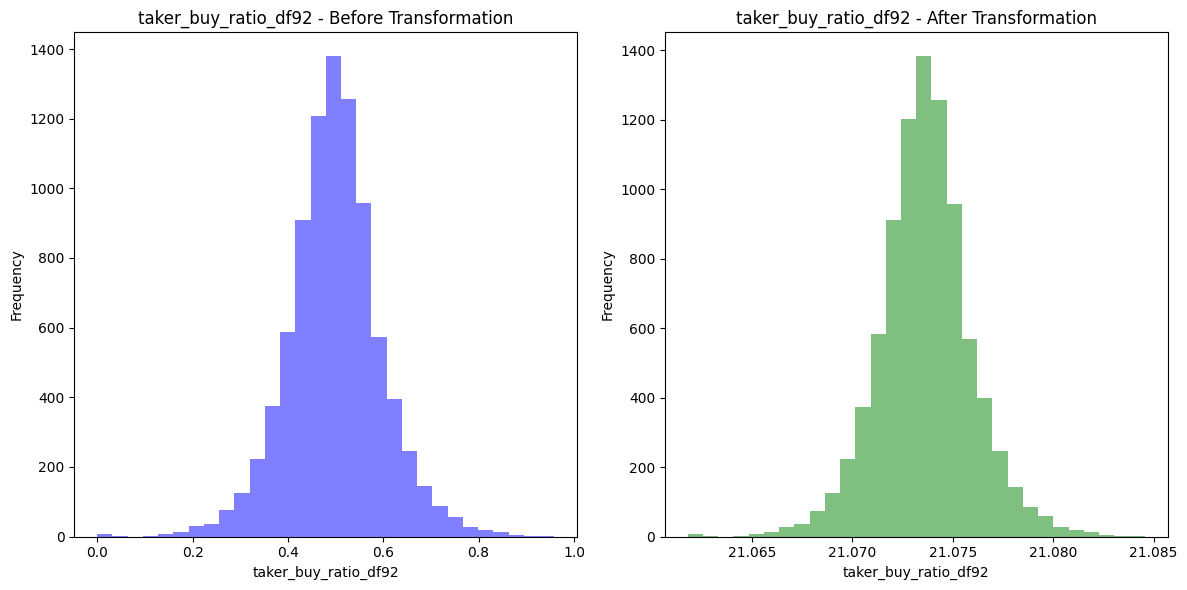

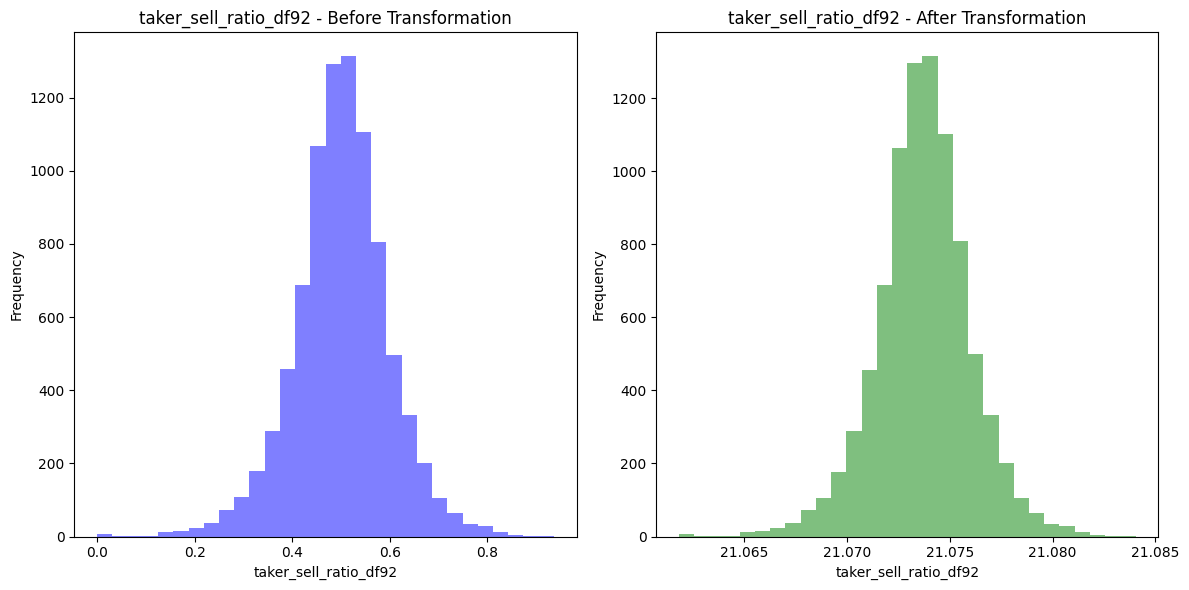

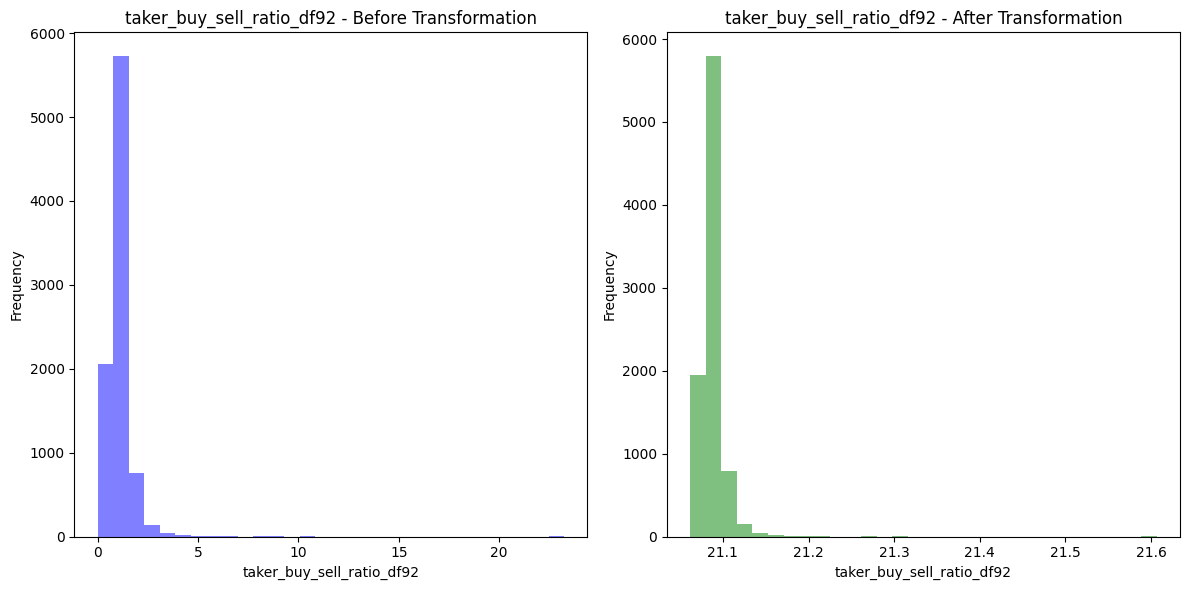

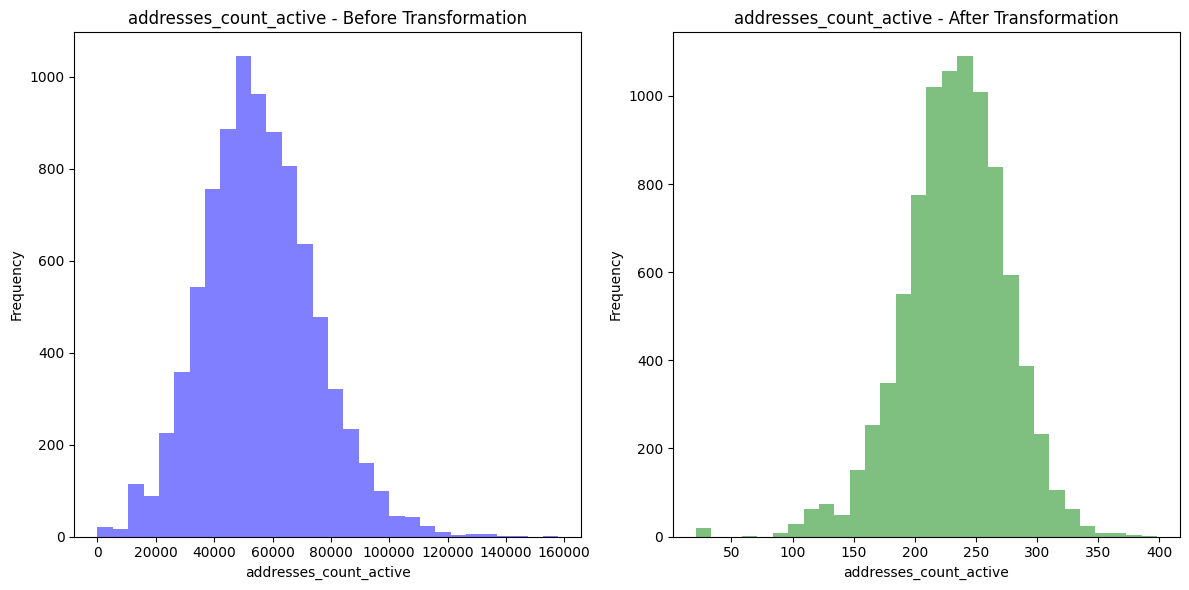

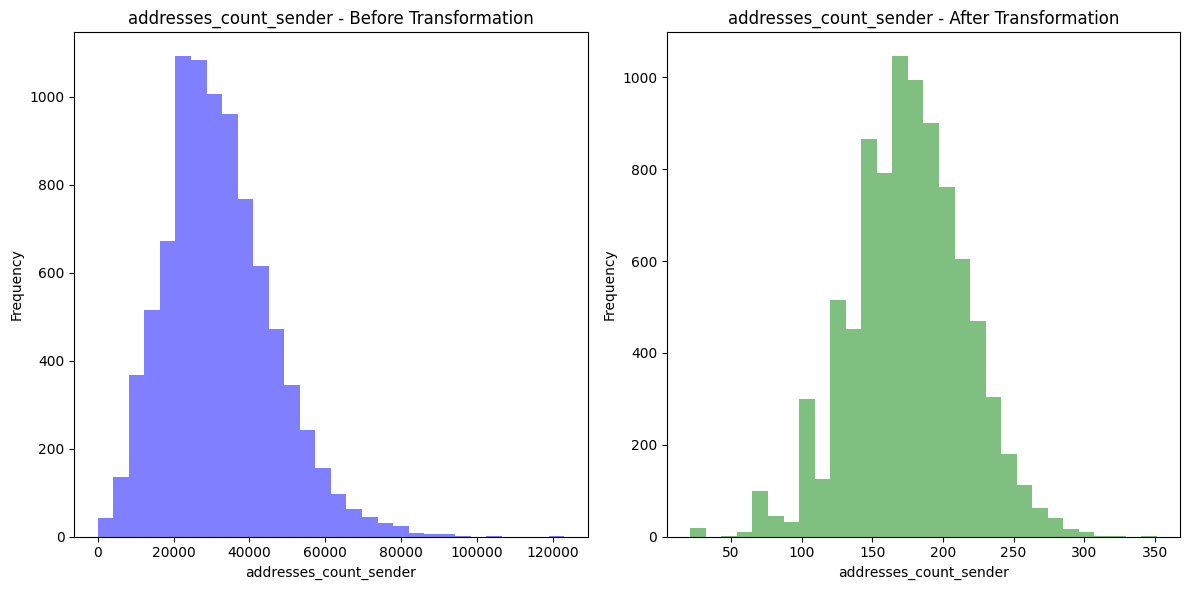

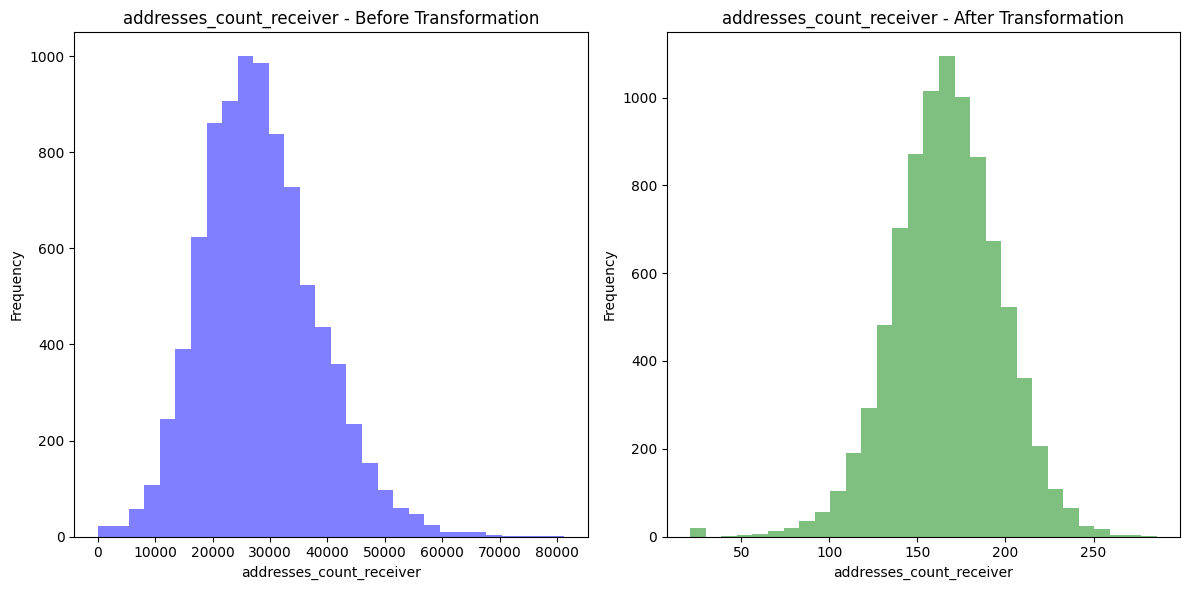

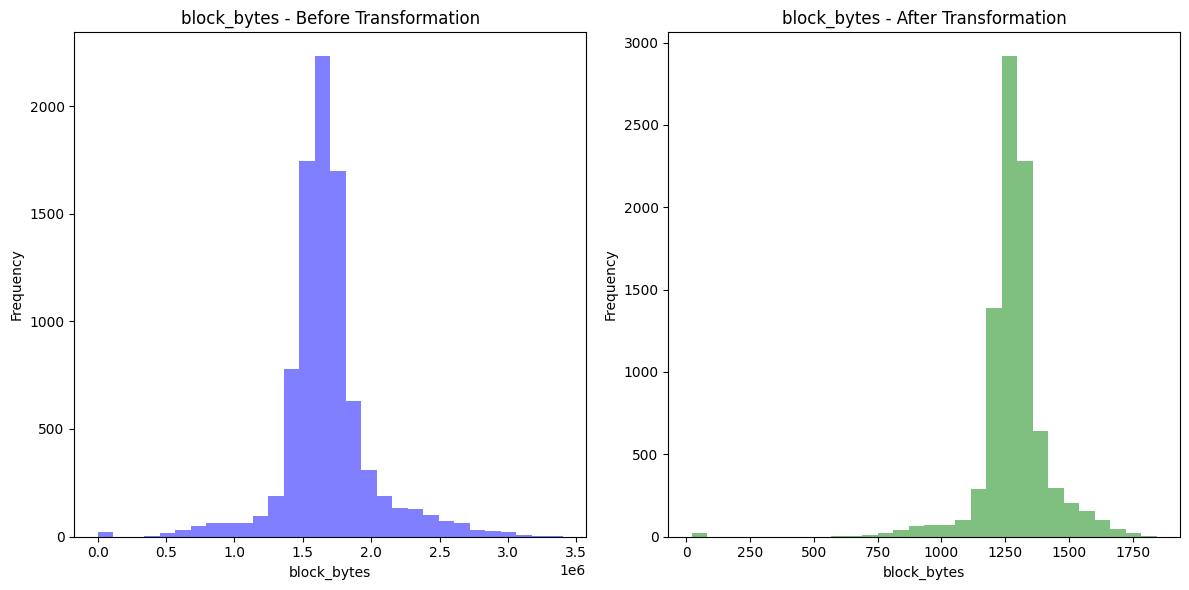

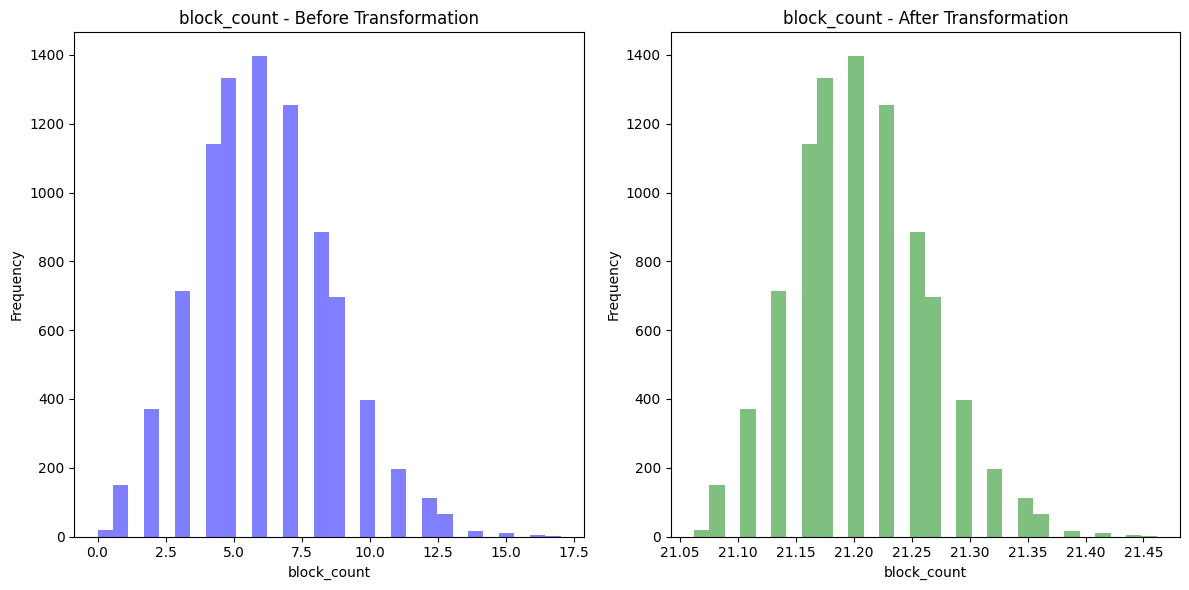

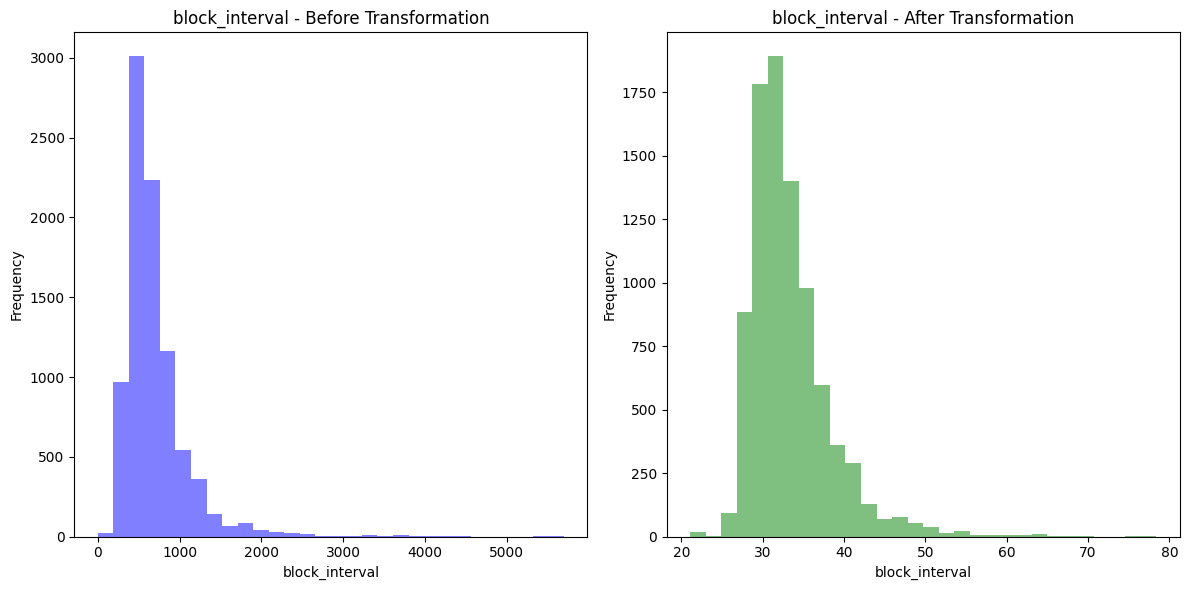

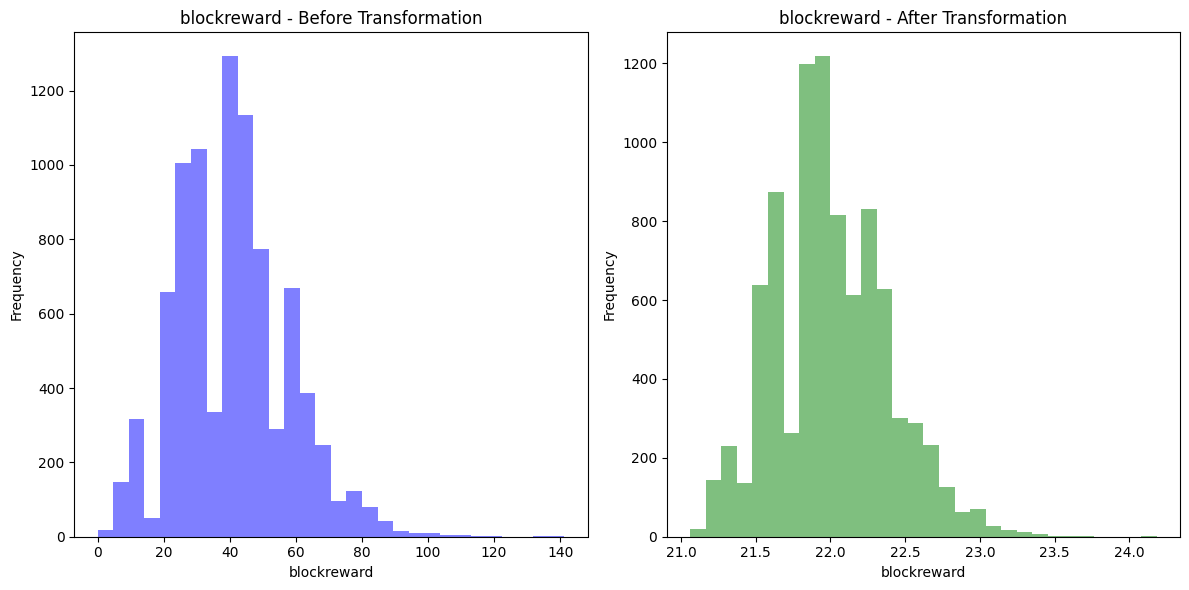

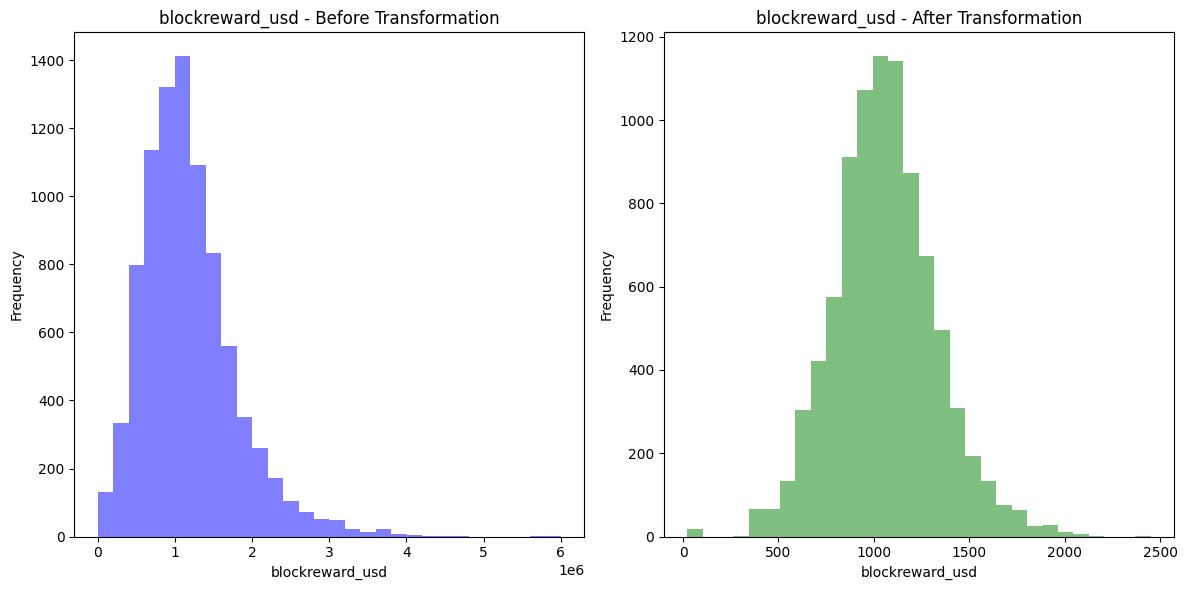

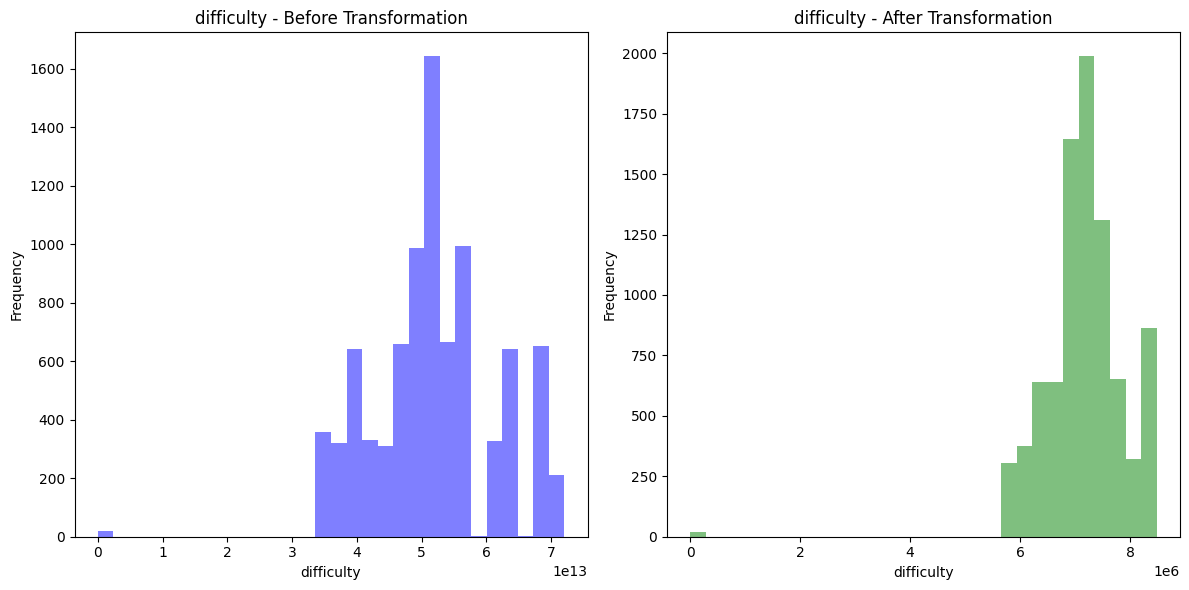

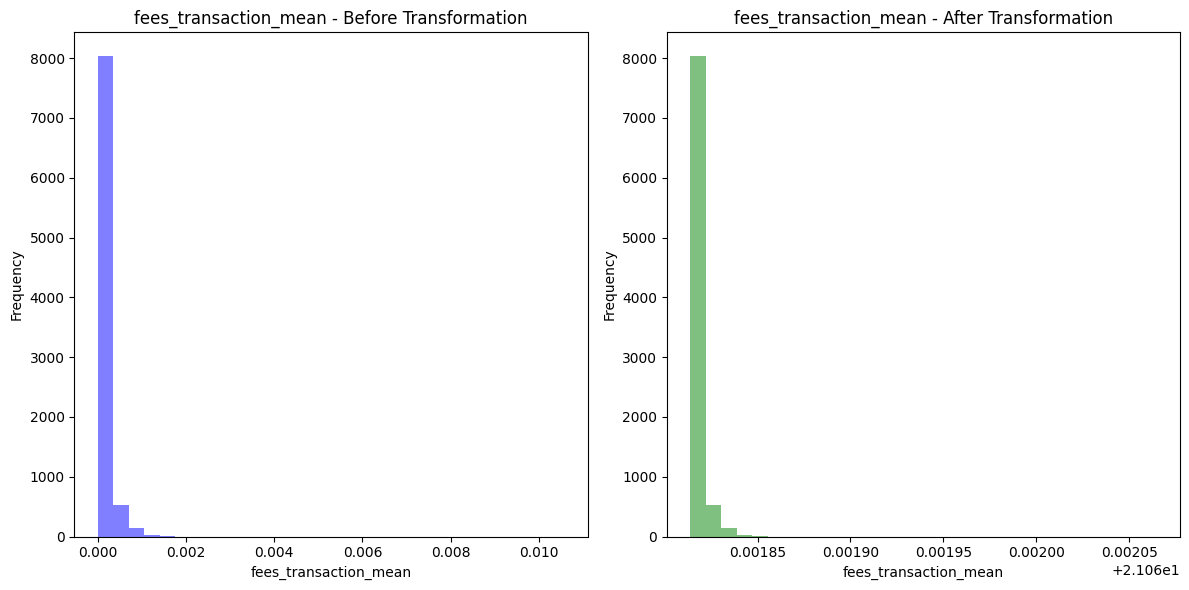

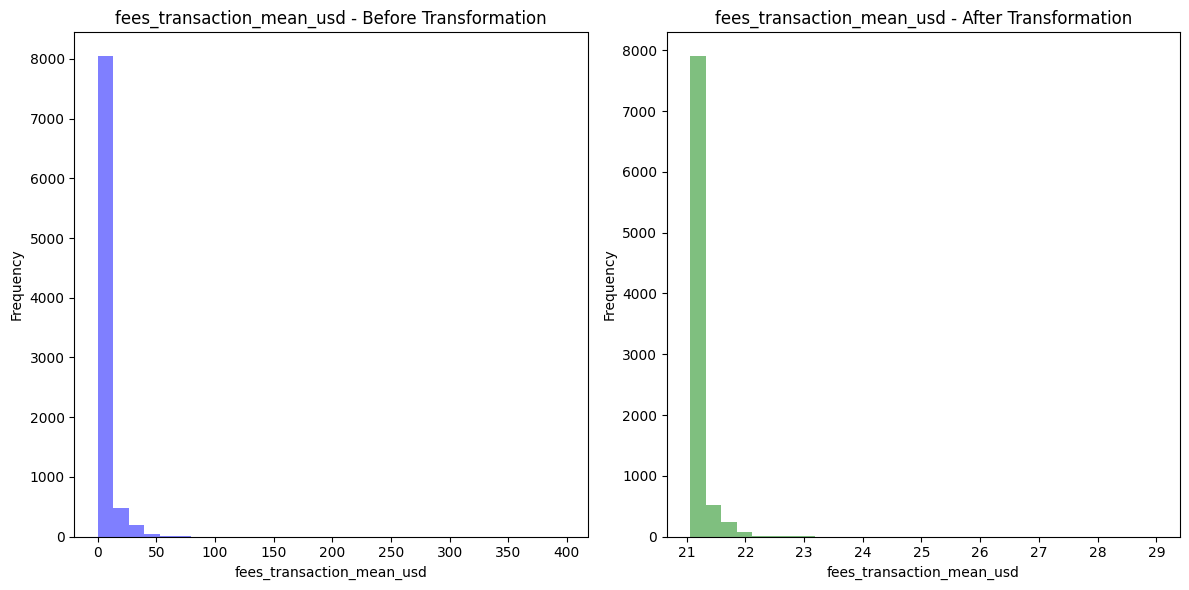

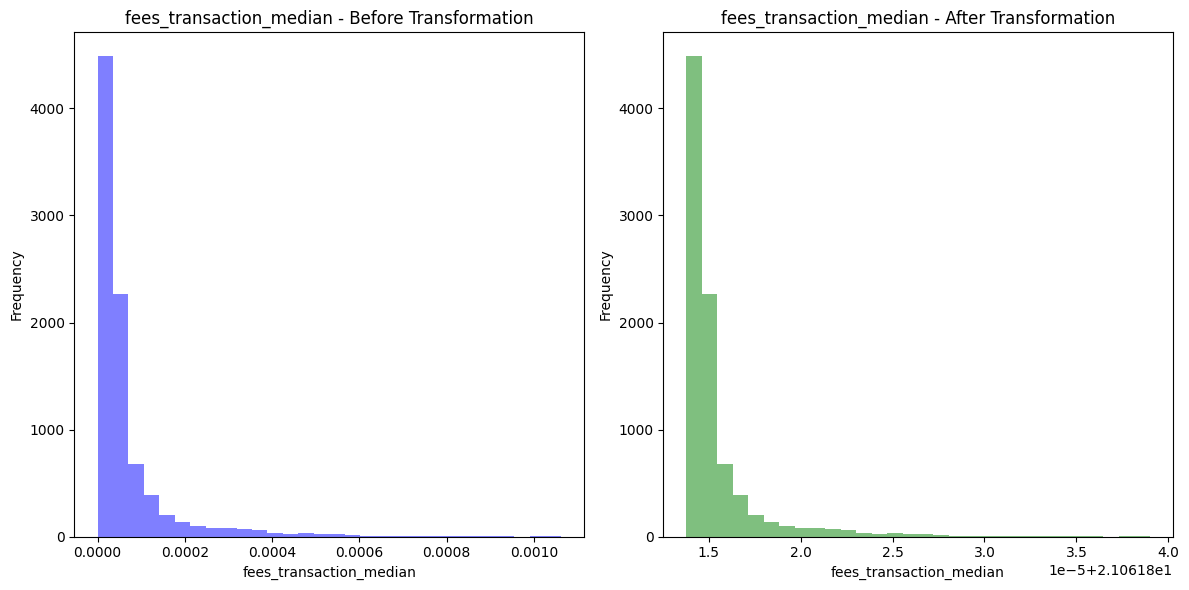

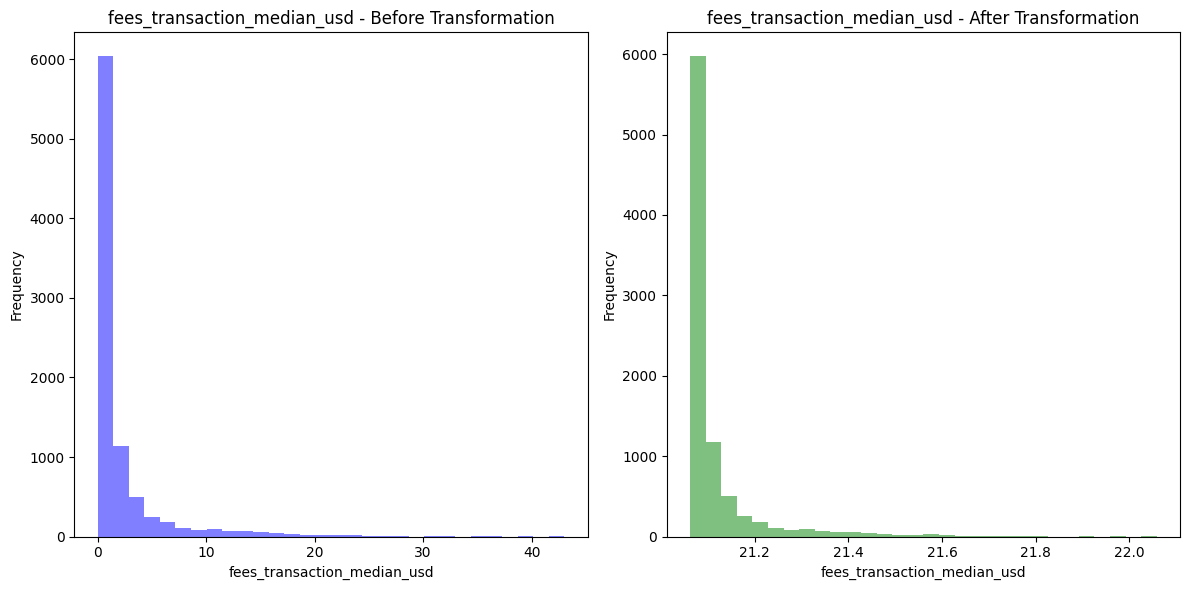

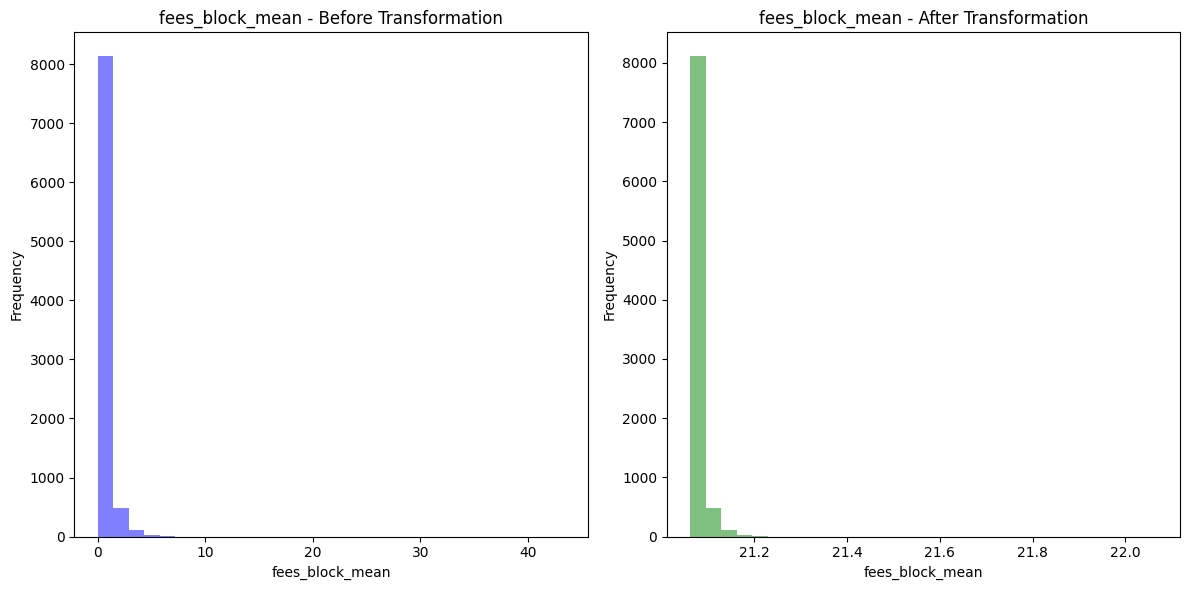

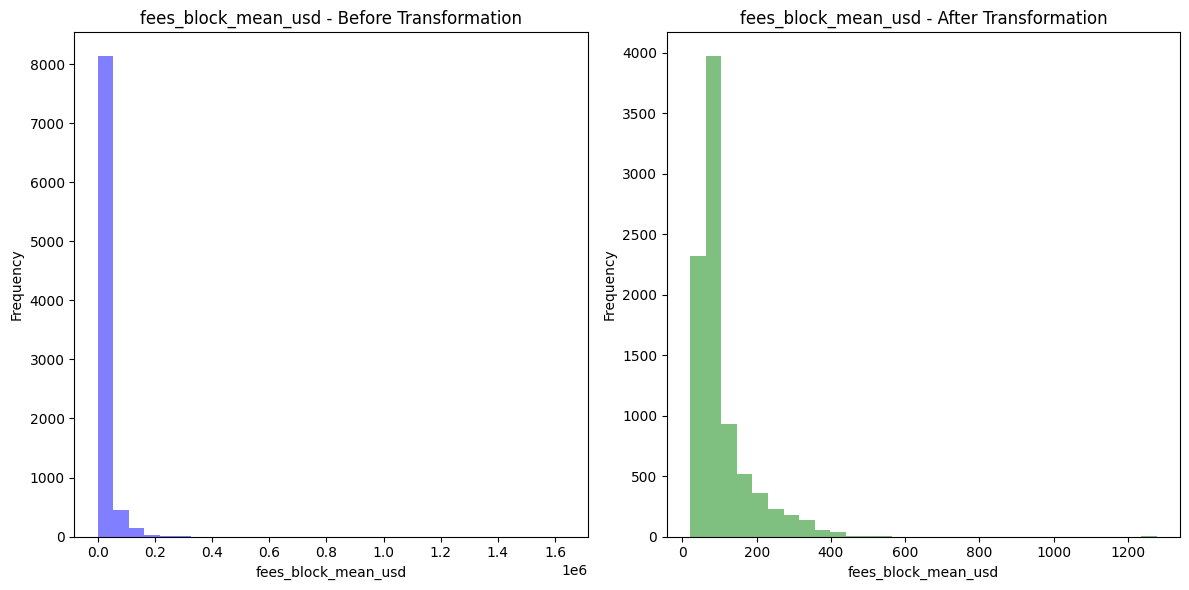

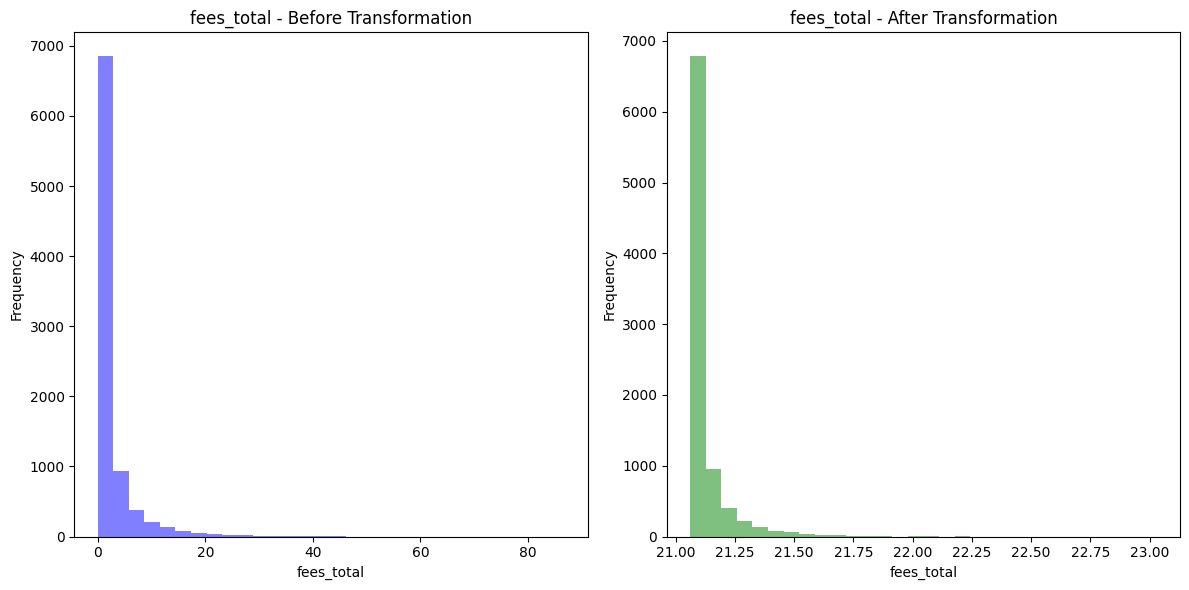

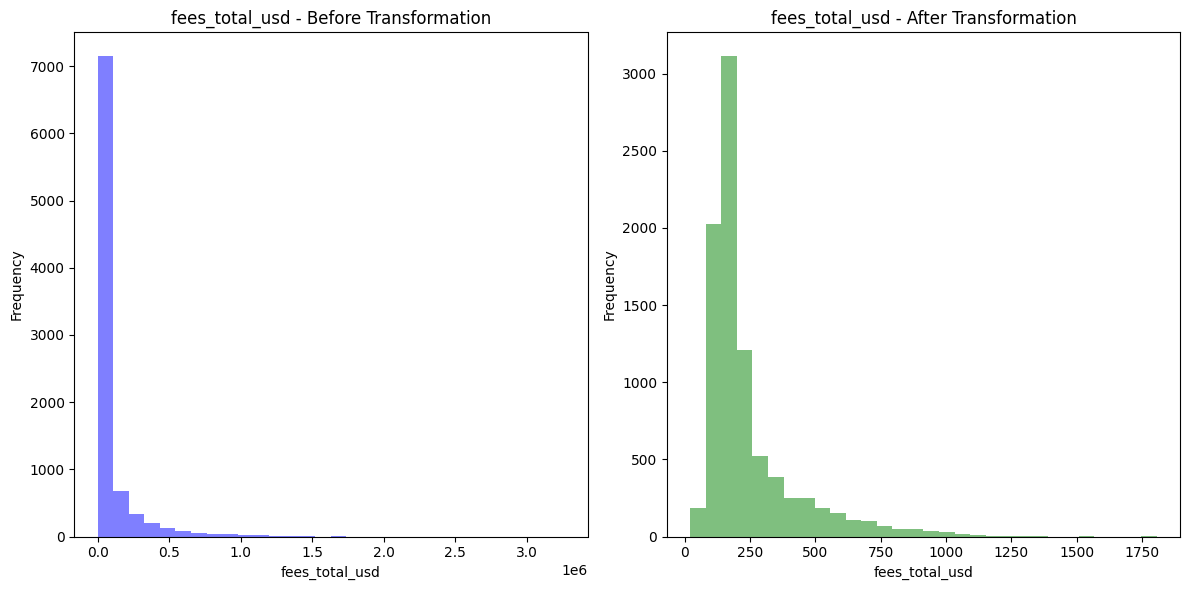

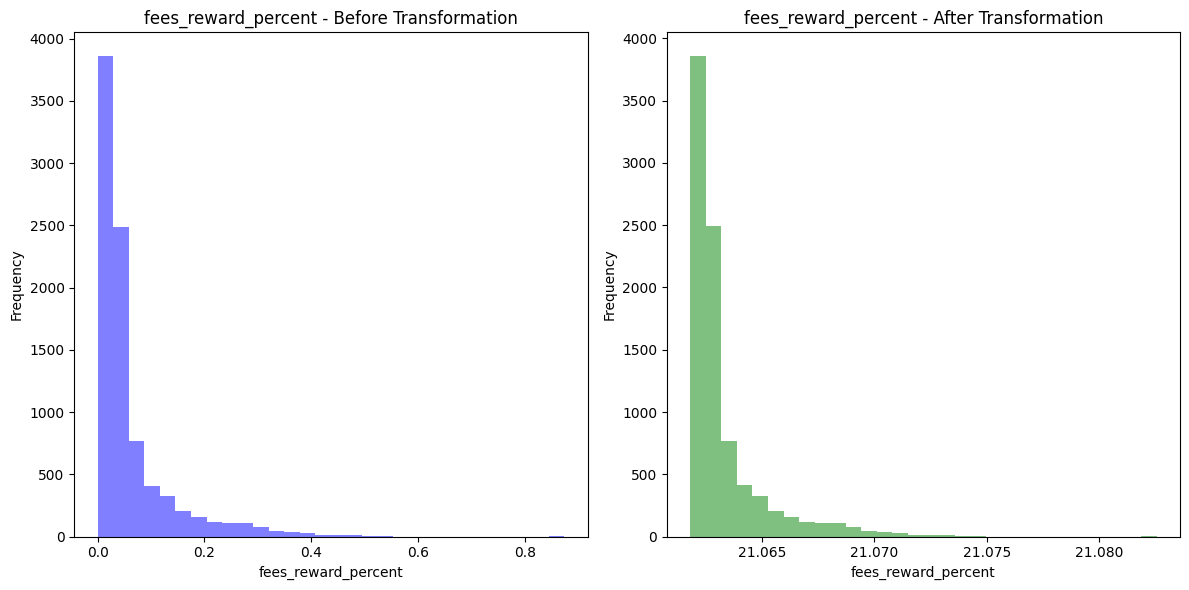

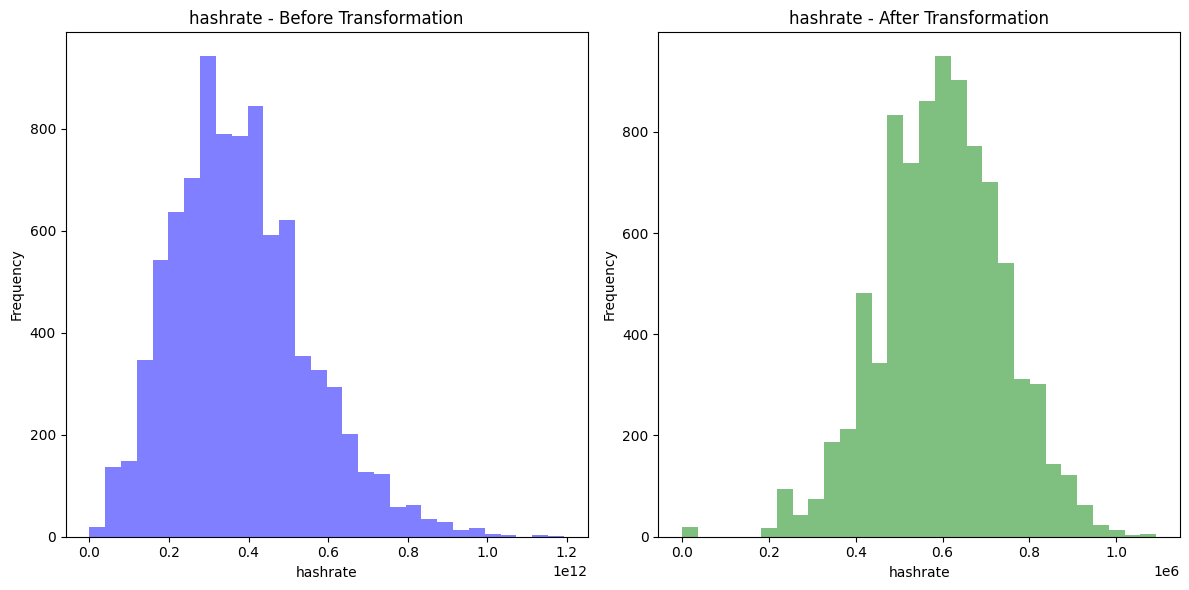

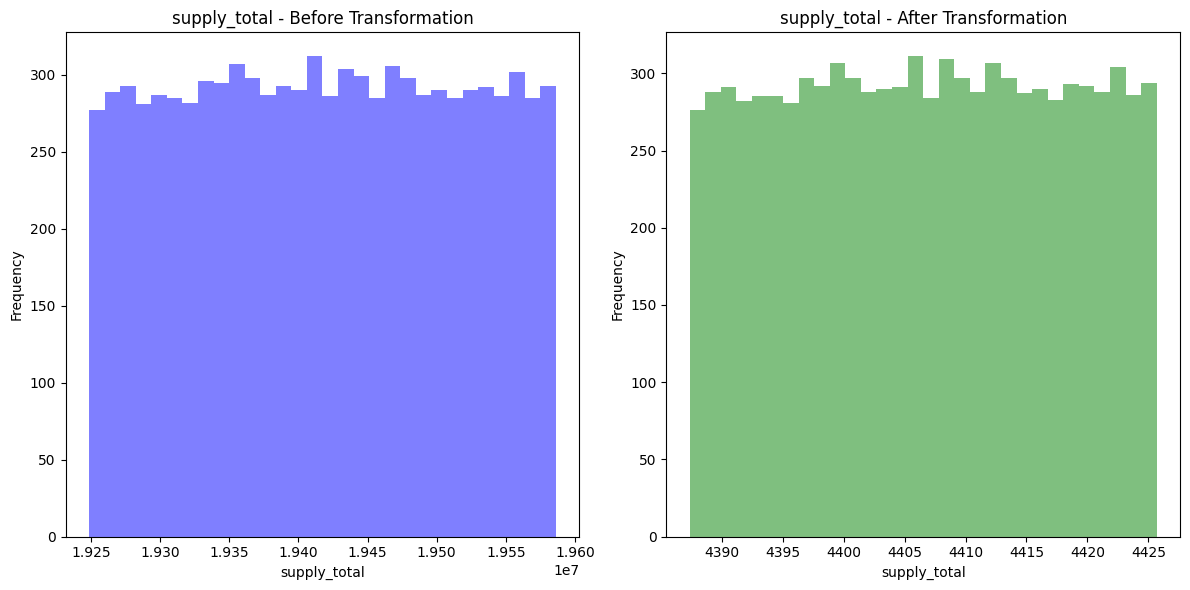

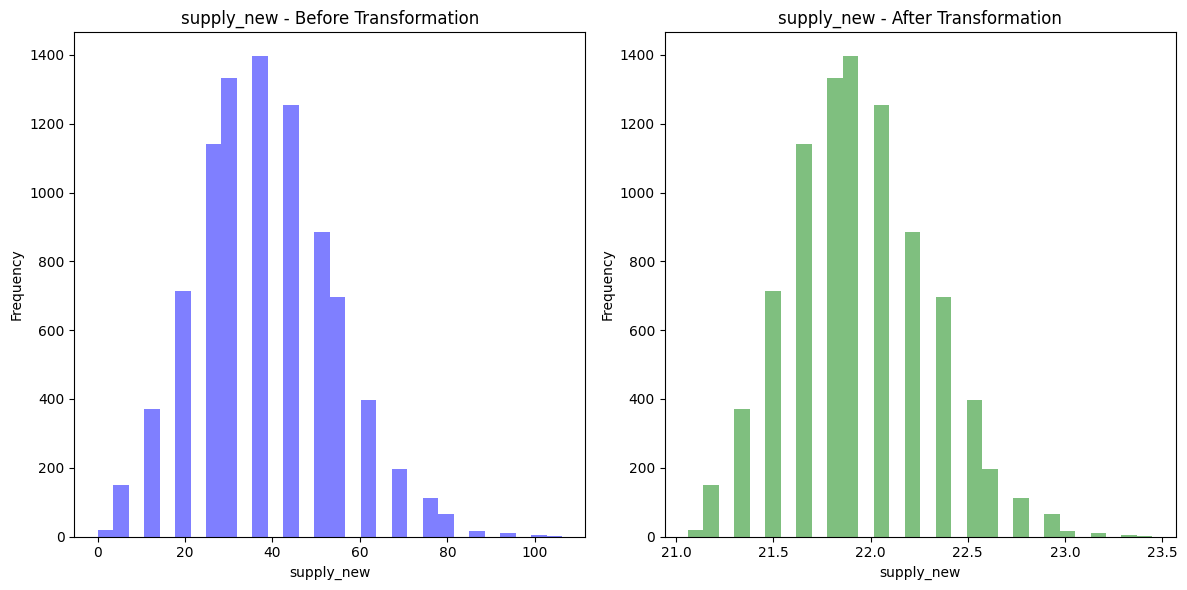

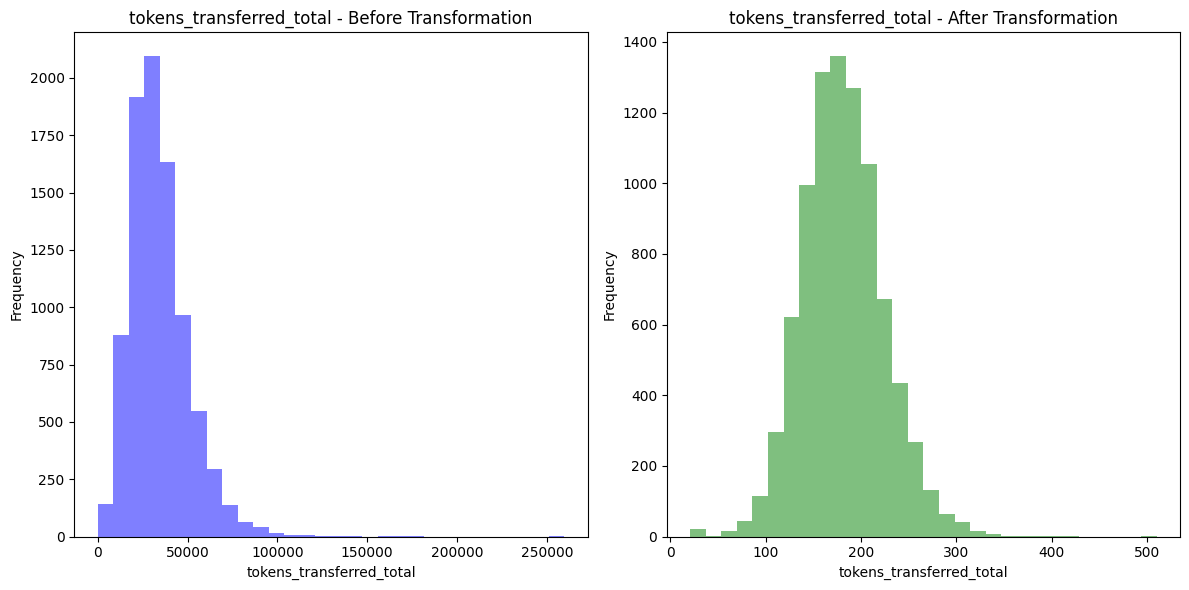

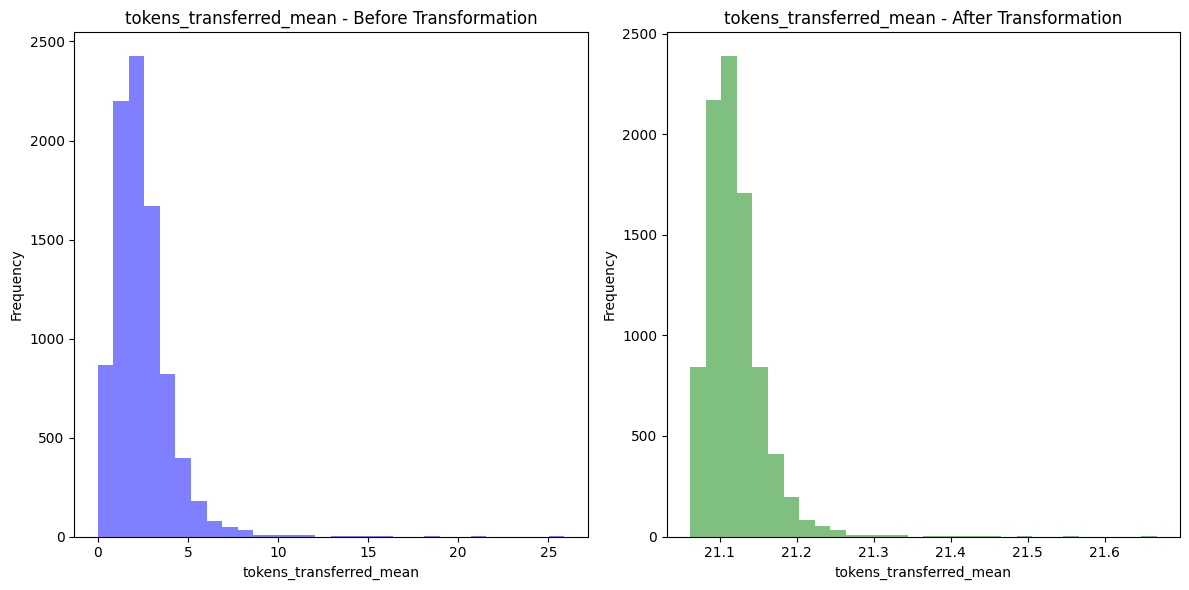

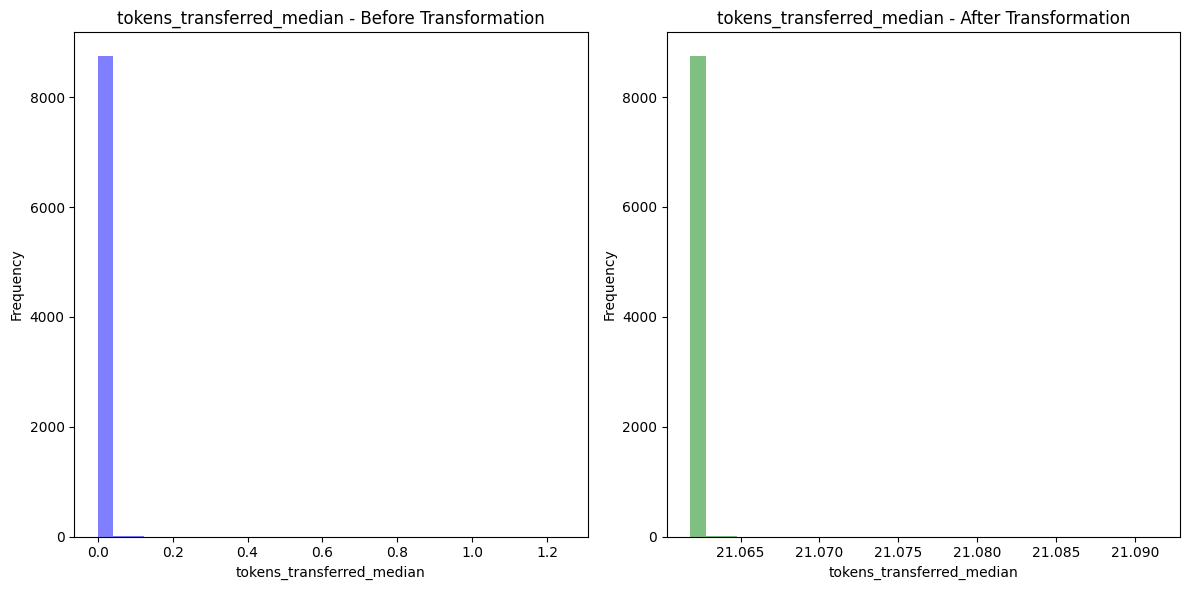

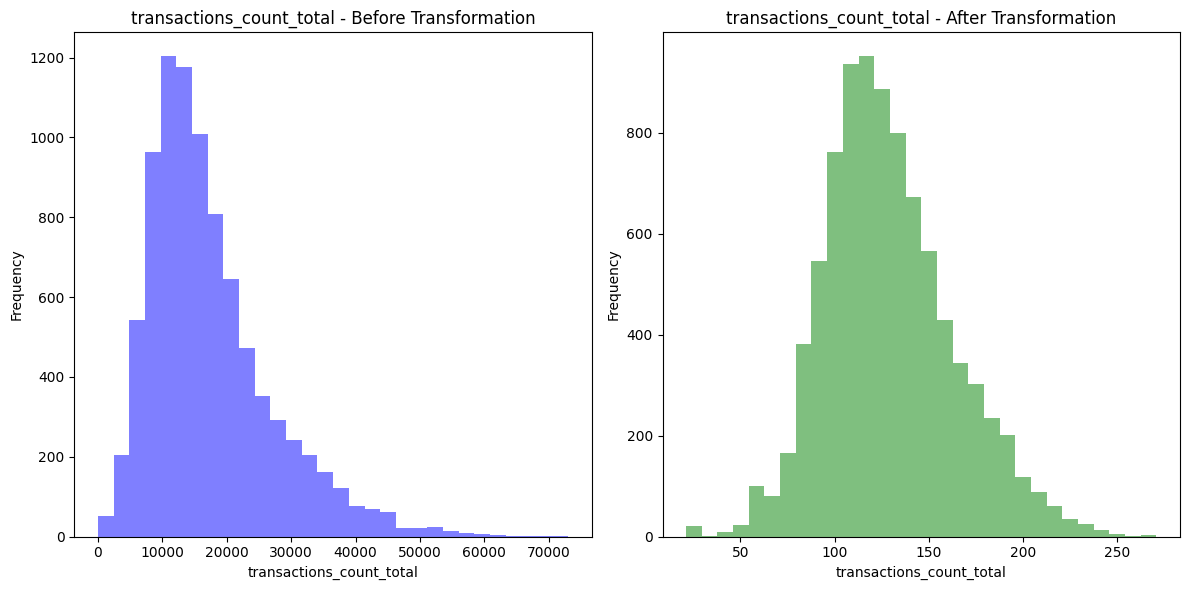

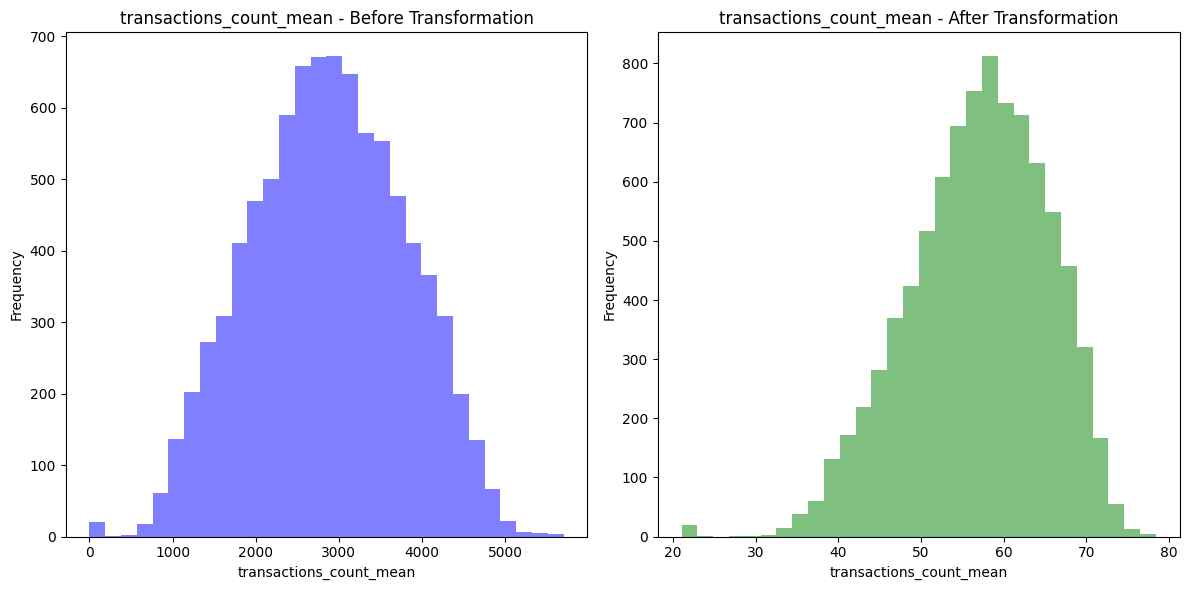

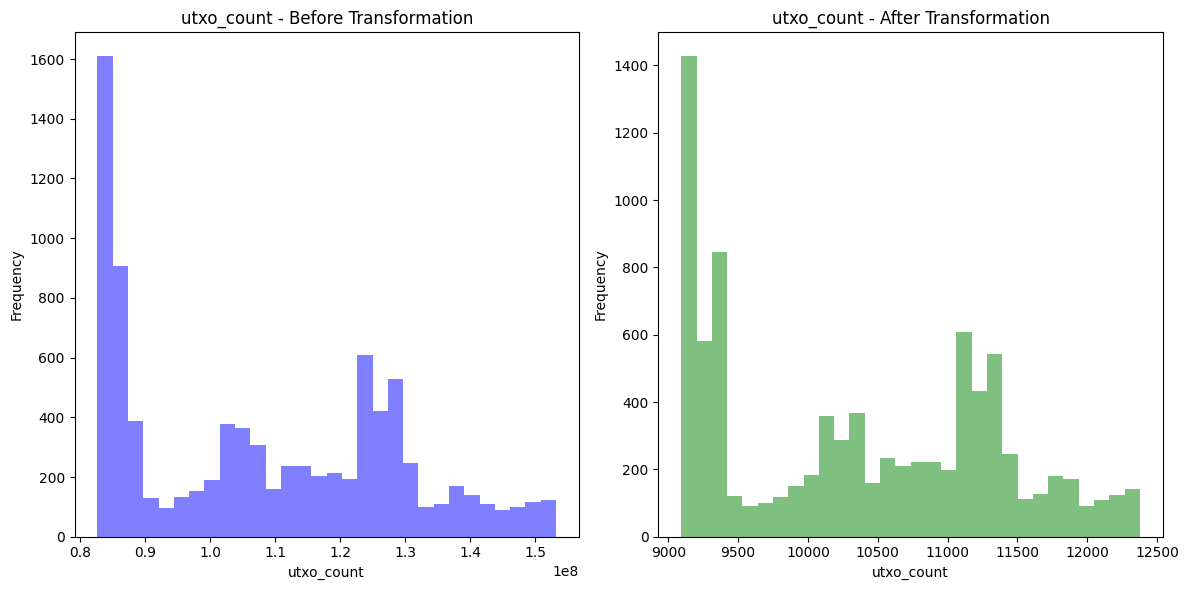

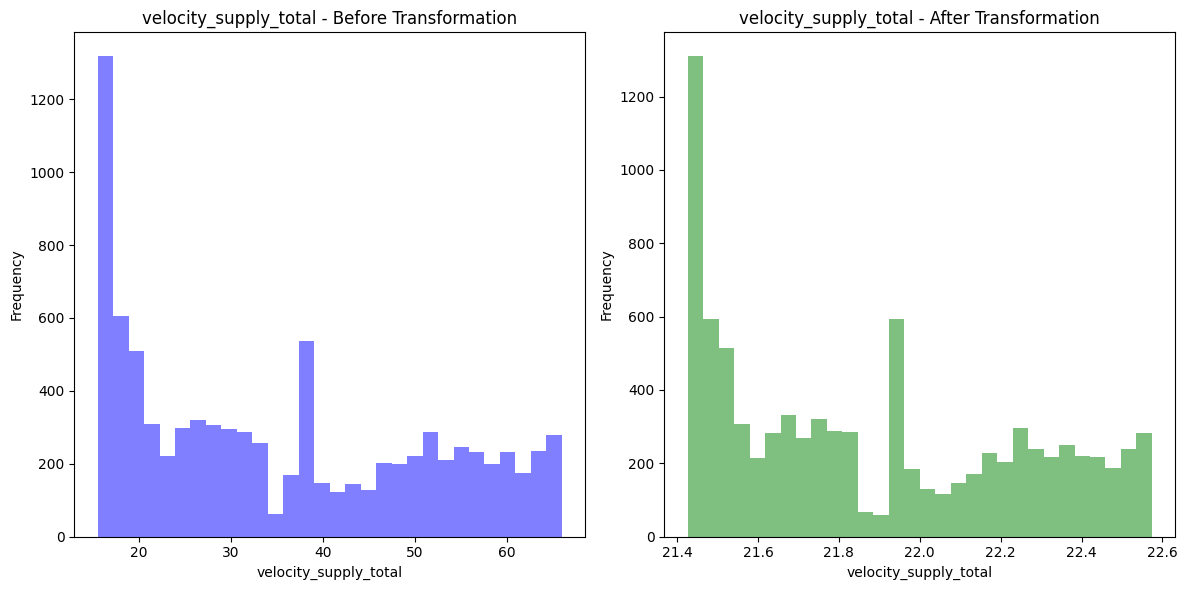

In [116]:
for col in numeric_columns:
    plt.figure(figsize=(12, 6))

    # 변환 전 데이터 히스토그램
    plt.subplot(1, 2, 1)
    plt.hist(original_data[col].dropna(), bins=30, alpha=0.5, color='blue', label='Before')
    plt.title(f'{col} - Before Transformation')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # 변환 후 데이터 히스토그램
    plt.subplot(1, 2, 2)
    plt.hist(data_2023[col].dropna(), bins=30, alpha=0.5, color='green', label='After')
    plt.title(f'{col} - After Transformation')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [119]:
# 상관계수 계산 (예: 피어슨 상관계수)
correlation_matrix = data_2023.corr(method='pearson')  # 또는 'spearman'
correlation_matrix

ID  coinbase_premium_gap  \
ID                        1.000000             -0.155615   
coinbase_premium_gap     -0.155615              1.000000   
coinbase_premium_index   -0.183562              0.956531   
funding_rates             0.286307             -0.357047   
funding_rates_df2         0.205404              0.004656   
...                            ...                   ...   
transactions_count_total  0.306580             -0.089201   
transactions_count_mean   0.458001             -0.109117   
utxo_count                0.981719             -0.207586   
velocity_supply_total    -0.985977              0.178205   
target                   -0.002776              0.013327   

                          coinbase_premium_index  funding_rates  \
ID                                     -0.183562       0.286307   
coinbase_premium_gap                    0.956531      -0.357047   
coinbase_premium_index                  1.000000      -0.439147   
funding_rates                          -0.439147       1.000000   
funding_rates_df2                      -0.011943       0.585366   
...                                          ...            ...   
transactions_count_total               -0.099853       0.097731   
transactions_count_mean                -0.128961       0.152646   
utxo_count                             -0.229633       0.311992   
velocity_supply_total                   0.203433      -0.220673   
target                                  0.020727      -0.013974   

                          funding_rates_df2  funding_rates_df3  \
ID                                 0.205404           0.220894   
coinbase_premium_gap               0.004656          -0.320955   
coinbase_premium_index            -0.011943          -0.405142   
funding_rates                      0.585366           0.728095   
funding_rates_df2                  1.000000           0.247883   
...                                     ...                ...   
transactions_count_total           0.117996           0.043390   
transactions_count_mean            0.178767           0.061329   
utxo_count                         0.225839           0.230425   
velocity_supply_total             -0.119341          -0.193863   
target                            -0.016351          -0.001610   

                          funding_rates_df4  funding_rates_df5  \
ID                                 0.134146           0.281004   
coinbase_premium_gap              -0.356191          -0.400030   
coinbase_premium_index            -0.451079          -0.496924   
funding_rates                      0.635604           0.801183   
funding_rates_df2                  0.314487           0.386260   
...                                     ...                ...   
transactions_count_total           0.032478           0.086075   
transactions_count_mean            0.071969           0.131265   
utxo_count                         0.132062           0.288440   
velocity_supply_total             -0.102270          -0.251989   
target                            -0.016646          -0.012868   

                          funding_rates_df6  funding_rates_df7  ...  \
ID                                 0.183392           0.184132  ...   
coinbase_premium_gap              -0.133875          -0.133770  ...   
coinbase_premium_index            -0.136949          -0.136864  ...   
funding_rates                      0.647637           0.647826  ...   
funding_rates_df2                  0.444212           0.444389  ...   
...                                     ...                ...  ...   
transactions_count_total           0.075174           0.075269  ...   
transactions_count_mean            0.109286           0.109382  ...   
utxo_count                         0.225164           0.225736  ...   
velocity_supply_total             -0.111550          -0.112379  ...   
target                            -0.004743          -0.004839  ...   

                          supply_total  supply_new  tokens_transfer

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# X는 피처, y는 target (0, 1, 2, 3으로 구성된 클래스)
X = data_2023.drop(columns=['target', 'ID'])  # target과 datetime을 제거
y = data_2023['target']

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 분류 모델 학습
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 피처 중요도 출력
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print(feature_importances)


open_interest_df49             0.009187
taker_buy_volume_df87          0.008748
taker_sell_volume_df88         0.008714
open_interest_df50             0.008569
open_interest_df72             0.008383
                                 ...   
long_liquidations_usd_df22     0.000473
short_liquidations_df16        0.000444
short_liquidations_df22        0.000434
short_liquidations_usd_df23    0.000397
short_liquidations_df23        0.000387
Length: 212, dtype: float64


In [ ]:
# 상위 N개의 중요한 피처 선택
N = 50  # 원하는 피처 개수 설정
top_features = feature_importances.index[:N]  # 상위 N개의 피처 선택


In [19]:
# top_features에서 'close'와 'volume'을 제외한 피처를 사용
top_features = [feature for feature in top_features if feature not in ['close', 'volume']]

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 2023년 데이터에서 피처와 타겟 설정
X_2023 = data_2023[top_features]  # 상위 50개의 중요한 피처
y_2023_close = data_2023['close']  # close 예측용 타겟
y_2023_volume = data_2023['volume']  # volume 예측용 타겟

# Train/test split
X_train, X_test, y_train_close, y_test_close = train_test_split(X_2023, y_2023_close, test_size=0.2, random_state=42)
X_train, X_test, y_train_volume, y_test_volume = train_test_split(X_2023, y_2023_volume, test_size=0.2, random_state=42)

# Random Forest 회귀 모델을 사용해 close 값 예측

close_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
close_model.fit(X_train, y_train_close)

# Random Forest 회귀 모델을 사용해 volume 값 예측

volume_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
volume_model.fit(X_train, y_train_volume)

# 예측 결과 평가
close_pred = close_model.predict(X_test)
volume_pred = volume_model.predict(X_test)

print("close 예측 모델 성능: ", close_model.score(X_test, y_test_close))
print("volume 예측 모델 성능: ", volume_model.score(X_test, y_test_volume))


close 예측 모델 성능:  0.9923945900109994
volume 예측 모델 성능:  0.9233863065329064


In [21]:
import joblib

# 모델 저장 (close와 volume 모델을 각각 저장)
joblib.dump(close_model, 'close_model.pkl')
joblib.dump(volume_model, 'volume_model.pkl')

print("모델이 성공적으로 저장되었습니다.")


모델이 성공적으로 저장되었습니다.


In [216]:
len(top_features)

48

In [29]:
X_23 = data_2023[top_features]

In [26]:
X_18_22 = data_18_22[top_features]

In [27]:
X_18_22.isnull().sum().sort_values(ascending=False)

open_interest_df49           0
taker_buy_volume_df87        0
taker_buy_ratio_df87         0
coinbase_premium_gap         0
taker_buy_sell_ratio_df92    0
taker_buy_sell_ratio_df87    0
tokens_transferred_mean      0
open_interest_df74           0
taker_buy_ratio_df86         0
open_interest_df80           0
addresses_count_receiver     0
blockreward                  0
addresses_count_active       0
taker_buy_ratio_df88         0
taker_sell_ratio_df86        0
taker_buy_sell_ratio_df88    0
taker_buy_volume_df90        0
open_interest_df70           0
taker_sell_volume_df90       0
taker_sell_ratio_df88        0
blockreward_usd              0
funding_rates                0
taker_sell_volume_df89       0
taker_buy_volume_df86        0
taker_buy_volume             0
coinbase_premium_index       0
taker_buy_volume_df92        0
taker_sell_volume_df88       0
open_interest_df50           0
open_interest_df72           0
taker_sell_volume_df92       0
taker_sell_volume_df87       0
open_int

In [23]:
data_18_22.drop('ID', axis=1,inplace=True)

C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\2676839578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_18_22.drop('ID', axis=1,inplace=True)


In [24]:
# 이동 평균으로 결측치 채우기 (예: 3개의 이전 값 평균 사용)
data_18_22.fillna(data_18_22.rolling(window=3).mean(), inplace=True)

# 또는 전체 중앙값으로 결측치 채우기
data_18_22.fillna(data_18_22.median(), inplace=True)


C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\4087270662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_18_22.fillna(data_18_22.rolling(window=3).mean(), inplace=True)
C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\4087270662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_18_22.fillna(data_18_22.median(), inplace=True)


In [ ]:
# 모델 불러오기
close_model = joblib.load('close_model.pkl')
volume_model = joblib.load('volume_model.pkl')

print("모델이 성공적으로 불러와졌습니다.")


In [30]:
print(X_23.shape)
X_18_22.shape

(8760, 48)


(44020, 48)

In [31]:
# 2018~2022년 데이터에서 피처를 선택 (top_features 사용)

# 불러온 모델을 사용해 close와 volume 예측
predicted_close_18_22 = close_model.predict(X_18_22)
predicted_volume_18_22 = volume_model.predict(X_18_22)

# 예측된 close와 volume을 train_data_18_22에 추가
X_18_22['predicted_close'] = predicted_close_18_22
X_18_22['predicted_volume'] = predicted_volume_18_22

print("2018~2022년 데이터의 close와 volume 예측이 완료되었습니다.")


2018~2022년 데이터의 close와 volume 예측이 완료되었습니다.


C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\3572592090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_18_22['predicted_close'] = predicted_close_18_22
C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\3572592090.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_18_22['predicted_volume'] = predicted_volume_18_22


In [32]:
# 등락률을 계산하여 타겟을 분류하는 함수
def classify_target_by_return(close_series):
    # 종가 등락률 계산 (pct_change는 전 시점 대비 퍼센트 변화를 계산)
    returns = close_series.pct_change() * 100  # %로 변환
    # 등락률에 따라 0, 1, 2, 3으로 분류
    target = returns.apply(lambda x: 0 if x < -0.5 else 1 if -0.5 <= x < 0 else 2 if 0 <= x < 0.5 else 3)
    return target

# 2018~2022년 데이터의 예측된 close 값으로 등락률 기반 타겟 생성
X_18_22['target'] = classify_target_by_return(X_18_22['predicted_close'])

# 2023년 데이터의 실제 close 값으로 등락률 기반 타겟 생성
# train_data_2023['target'] = classify_target_by_return(train_data_2023['close'])


C:\Users\sw00h\AppData\Local\Temp\ipykernel_26480\599598949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_18_22['target'] = classify_target_by_return(X_18_22['predicted_close'])


In [33]:
X_18_22 = X_18_22.rename(columns={'predicted_close': 'close', 'predicted_volume': 'volume'})

In [34]:
X_18_22[['close','volume']]

close        volume
11546  16552.832559   5571.668134
11547  16957.852231  11309.148003
11548  16973.142091  10153.046686
11549  16964.690420   9918.987738
11550  16954.155464  10068.317413
...             ...           ...
58839  28506.196365   1310.724305
58840  28549.561019   1266.767010
58841  28506.628164   1272.154125
58842  28524.432644   1270.635987
58843  28527.571861   1323.451397

[44020 rows x 2 columns]

In [36]:
# 상위 N개의 중요한 피처 선택
N = 50  # 원하는 피처 개수 설정
top_features = feature_importances.index[:N]  # 상위 N개의 피처 선택


In [37]:
X_23 = data_2023[top_features]
X_23.shape

(8760, 50)

In [38]:
X_23[['close','volume']]

close       volume
0     16536.747967  5516.420322
1     16557.136536  4513.341881
2     16548.149805  4310.904314
3     16533.632875  4893.417864
4     16524.712159  5209.002297
...            ...          ...
8755  42597.709522  1002.251559
8756  42535.570787  1070.042124
8757  42497.523419  1026.473547
8758  42257.026218  1715.192245
8759  42285.799905  1549.917518

[8760 rows x 2 columns]

In [39]:
print(X_18_22.shape)
X_23.shape

(44020, 51)


(8760, 50)

In [40]:
target_18_22 = X_18_22['target']

In [41]:
# 2018~2022년과 2023년의 X 데이터에서 close 값 제외
X_18_22 = X_18_22.drop(columns=['close'])  # 예측된 close 제외
X_18_22 = X_18_22.drop(columns=['target'])
X_23 = X_23.drop(columns=['close'])  # 실제 close 제외

print(X_18_22.shape)
print(X_23.shape)

(44020, 49)
(8760, 49)


In [42]:
# 2018~2022년과 2023년의 X 데이터 병합
X_final = pd.concat([X_18_22, X_23], axis=0)

# 타겟 데이터도 결합
y_final = pd.concat([target_18_22, train_df['target']], axis=0)

# 데이터 크기 확인
print(X_final.shape, y_final.shape)


(52780, 49) (52780,)


In [130]:
X_final

open_interest_df49  taker_buy_volume_df87  taker_sell_volume_df88  \
11546        1.086499e+08              5959807.0                765480.0   
11547        1.084890e+08             22827403.0               1674460.0   
11548        1.086659e+08             48769650.0                621530.0   
11549        1.087568e+08             48711371.0                210480.0   
11550        1.088073e+08             47056304.0                168280.0   
...                   ...                    ...                     ...   
8755         2.189789e+08              1987256.0               3527850.0   
8756         2.185508e+08              6270592.0               3215340.0   
8757         2.182381e+08              2274012.0               3224980.0   
8758         2.161625e+08             10934468.0               8295840.0   
8759         2.164297e+08              9661518.0               8555620.0   

       open_interest_df50  open_interest_df72  taker_sell_volume_df92  \
11546        1.086499e+08        1.018504e+08               4328300.0   
11547        1.084890e+08        1.016271e+08               3180100.0   
11548        1.086659e+08        1.012087e+08               1483500.0   
11549        1.087568e+08        1.013691e+08               1380900.0   
11550        1.088073e+08        1.013883e+08               1087000.0   
...                   ...                 ...                     ...   
8755         2.189789e+08        1.343206e+08               5784400.0   
8756         2.185508e+08        1.338965e+08               7369700.0   
8757         2.182381e+08        1.338388e+08               5100400.0   
8758         2.161625e+08        1.319871e+08              23088200.0   
8759         2.164297e+08        1.329845e+08              15653000.0   

       taker_sell_volume_df87  open_interest_df68  taker_buy_volume_df88  \
11546               4395952.0        1.018504e+08               337150.0   
11547              30712797.0        1.016271e+08              2029260.0   
11548              49108167.0        1.012087e+08               517330.0   
11549              49125498.0        1.013691e+08                47440.0   
11550              47773606.0        1.013883e+08               196850.0   
...                       ...                 ...                    ...   
8755                3032689.0        1.343206e+08              2946330.0   
8756                4183763.0        1.338965e+08              2760190.0   
8757                2905550.0        1.338388e+08              4795230.0   
8758               28721507.0        1.319871e+08              5758730.0   
8759               10112076.0        1.329845e+08              5898990.0   

       taker_buy_ratio_df92  ...  taker_buy_sell_ratio_df88  \
11546              0.318657  ...                   0.440443   
11547              0.437499  ...                   1.211889   
11548              0.370732  ...                   0.832349   
11549              0.292499  ...                   0.225390   
11550              0.455001  ...                   1.169777   
...                     ...  ...                        ...   
8755               0.652321  ...                   0.835163   
8756               0.545865  ...                   0.858444   
8757               0.467227  ...                   1.486902   
8758               0.337910  ...                   0.694171   
8759               0.478546  ...                   0.689487   

       taker_buy_volume_df90  open_interest_df70  taker_sell_volume_df90  \
11546               864600.0        6.782172e+07                636000.0   
11547              1487200.0        6.766863e+07                702800.0   
11548                64000.0        6.744674e+07                343000.0   
11549                21200.0        6.755629e+07                 55200.0   
11550               487000.0        6.755358e+07                 63800.0   
...                      ...                 ...                     ...   
8755           

In [43]:
from sklearn.model_selection import train_test_split

# 1단계: 전체 데이터를 훈련/테스트 데이터로 분리 (80% 훈련, 20% 테스트)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# 2단계: 훈련 데이터를 다시 훈련/검증 데이터로 분리 (80% 훈련, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# 각 데이터셋 크기 확인
print(f"훈련 데이터: {X_train.shape}, 검증 데이터: {X_val.shape}, 테스트 데이터: {X_test.shape}")


훈련 데이터: (33779, 49), 검증 데이터: (8445, 49), 테스트 데이터: (10556, 49)


In [44]:
from sklearn.ensemble import RandomForestClassifier

# 모델 학습 (훈련 데이터 사용)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 검증 데이터로 모델 성능 평가
val_accuracy = model.score(X_val, y_val)
print(f"검증 데이터에서 모델 정확도: {val_accuracy}")

# 테스트 데이터로 최종 모델 성능 평가
test_accuracy = model.score(X_test, y_test)
print(f"테스트 데이터에서 모델 최종 정확도: {test_accuracy}")


검증 데이터에서 모델 정확도: 0.5475429248075785
테스트 데이터에서 모델 최종 정확도: 0.5419666540356195


In [133]:
from sklearn.model_selection import cross_val_score

# 교차 검증을 사용하여 검증
cv_scores = cross_val_score(model, X_train_val, y_train_val, cv=5)

# 교차 검증 결과
print(f"각 Fold의 검증 정확도: {cv_scores}")
print(f"평균 검증 정확도: {cv_scores.mean()}")

# 테스트 데이터로 최종 평가
test_accuracy = model.score(X_test, y_test)
print(f"테스트 데이터에서 최종 정확도: {test_accuracy}")


각 Fold의 검증 정확도: [0.54209591 0.53404381 0.55133215 0.54185909 0.54464709]
평균 검증 정확도: 0.542795610351372
테스트 데이터에서 최종 정확도: 0.5419666540356195


In [134]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 하이퍼파라미터 범위 설정
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV 실행 (n_iter는 시도할 조합의 수)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=10, cv=5, n_jobs=-1, random_state=42, verbose=2)
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터: ", random_search.best_params_)

# 최적의 하이퍼파라미터로 모델 평가
best_model = random_search.best_estimator_
val_accuracy = best_model.score(X_val, y_val)
test_accuracy = best_model.score(X_test, y_test)

print(f"최적 모델 검증 데이터 정확도: {val_accuracy}")
print(f"최적 모델 테스트 데이터 정확도: {test_accuracy}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
최적의 하이퍼파라미터:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
최적 모델 검증 데이터 정확도: 0.5430432208407342
최적 모델 테스트 데이터 정확도: 0.5433876468359227


In [73]:
from sklearn.ensemble import RandomForestClassifier

# 모델 학습 (훈련 데이터 사용)
model = RandomForestClassifier(random_state=42, n_estimators=200, min_samples_split= 5, min_samples_leaf= 1, max_depth= 20)
model.fit(X_train, y_train)

# 검증 데이터로 모델 성능 평가
val_accuracy = model.score(X_val, y_val)
print(f"검증 데이터에서 모델 정확도: {val_accuracy}")

# 테스트 데이터로 최종 모델 성능 평가
test_accuracy = model.score(X_test, y_test)
print(f"테스트 데이터에서 모델 최종 정확도: {test_accuracy}")


검증 데이터에서 모델 정확도: 0.5430432208407342
테스트 데이터에서 모델 최종 정확도: 0.5433876468359227


In [71]:
import joblib

# XGBoost 모델 저장
joblib.dump(model, 'rf_model.pkl')
print("rf 모델이 저장되었습니다.")



rf 모델이 저장되었습니다.


In [72]:
# XGBoost 모델 불러오기
rf_model_loaded = joblib.load('rf_model.pkl')
print("rf 모델이 불러와졌습니다.")

rf 모델이 불러와졌습니다.


In [140]:
# 모델에서 피처 중요도 출력
import pandas as pd

# 모델에서 중요한 특징 출력
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# 상위 10개 특징 확인
print(feature_importances.head(10))

# 특정 중요도 높은 피처들만 사용하여 학습
top_features = feature_importances.index[:10]  # 상위 10개 피처 선택
X_train_top = X_train[top_features]
X_val_top = X_val[top_features]
X_test_top = X_test[top_features]

# 최종 모델로 재학습
best_model.fit(X_train_top, y_train)
val_accuracy = best_model.score(X_val_top, y_val)
test_accuracy = best_model.score(X_test_top, y_test)

print(f"상위 피처 검증 데이터 정확도: {val_accuracy}")
print(f"상위 피처 테스트 데이터 정확도: {test_accuracy}")


coinbase_premium_gap        0.039743
coinbase_premium_index      0.039054
block_interval              0.032306
taker_sell_volume_df86      0.031212
blockreward                 0.030678
taker_buy_volume_df86       0.030641
tokens_transferred_total    0.028373
volume                      0.026879
blockreward_usd             0.025554
block_bytes                 0.025067
dtype: float64
상위 피처 검증 데이터 정확도: 0.5082297217288336
상위 피처 테스트 데이터 정확도: 0.5042629784009094


In [75]:
from xgboost import XGBClassifier

# XGBoost 모델 생성 및 학습
xgb_model = XGBClassifier(random_state=42, colsample_bytree= 1.0, learning_rate= 0.1, max_depth= 5, n_estimators= 200, subsample= 0.8)
xgb_model.fit(X_train, y_train)

# 검증 및 테스트 데이터로 평가
val_accuracy = xgb_model.score(X_val, y_val)
test_accuracy = xgb_model.score(X_test, y_test)

print(f"XGBoost 검증 데이터 정확도: {val_accuracy}")
print(f"XGBoost 테스트 데이터 정확도: {test_accuracy}")


XGBoost 검증 데이터 정확도: 0.5455298993487271
XGBoost 테스트 데이터 정확도: 0.5481242895035998


In [74]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [3, 5, 7],  # 트리의 최대 깊이
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'subsample': [0.7, 0.8, 1.0],  # 각 트리 학습 시 샘플링 비율
    'colsample_bytree': [0.7, 0.8, 1.0]  # 각 트리 학습 시 피처 샘플링 비율
}

# 모델 생성
xgb = XGBClassifier(random_state=42)

# GridSearchCV를 통해 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터: ", grid_search.best_params_)

# 최적의 하이퍼파라미터로 모델 평가
best_model = grid_search.best_estimator_
val_accuracy = best_model.score(X_val, y_val)
test_accuracy = best_model.score(X_test, y_test)

print(f"최적 모델 검증 데이터 정확도: {val_accuracy}")
print(f"최적 모델 테스트 데이터 정확도: {test_accuracy}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
최적의 하이퍼파라미터:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
최적 모델 검증 데이터 정확도: 0.5455298993487271
최적 모델 테스트 데이터 정확도: 0.5481242895035998


In [142]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# 여러 모델을 결합한 앙상블 모델 생성
ensemble_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42))
], voting='soft')

# 앙상블 모델 학습 및 평가
ensemble_model.fit(X_train, y_train)
val_accuracy = ensemble_model.score(X_val, y_val)
test_accuracy = ensemble_model.score(X_test, y_test)

print(f"앙상블 모델 검증 데이터 정확도: {val_accuracy}")
print(f"앙상블 모델 테스트 데이터 정확도: {test_accuracy}")


앙상블 모델 검증 데이터 정확도: 0.5521610420367081
앙상블 모델 테스트 데이터 정확도: 0.5510610079575596


In [49]:
len(top_features)

50

In [145]:
data_2024

ID  coinbase_premium_gap  coinbase_premium_index  \
0    2024-01-01 00:00:00                -22.57               -0.053137   
1    2024-01-01 01:00:00                -18.88               -0.044305   
2    2024-01-01 02:00:00                 -9.78               -0.022968   
3    2024-01-01 03:00:00                 -5.38               -0.012710   
4    2024-01-01 04:00:00                -10.22               -0.024104   
...                  ...                   ...                     ...   
2793 2024-04-26 09:00:00                   NaN                     NaN   
2794 2024-04-26 10:00:00                   NaN                     NaN   
2795 2024-04-26 11:00:00                   NaN                     NaN   
2796 2024-04-26 12:00:00                   NaN                     NaN   
2797 2024-04-26 13:00:00                   NaN                     NaN   

      funding_rates  funding_rates_df2  funding_rates_df3  funding_rates_df4  \
0          0.042276           0.037264           0.018500           0.017305   
1          0.042578           0.035991           0.018500           0.020450   
2          0.043265           0.035086           0.018500           0.024063   
3          0.043927           0.034431           0.018643           0.027012   
4          0.045189           0.032956           0.027000           0.027208   
...             ...                ...                ...                ...   
2793            NaN                NaN                NaN                NaN   
2794            NaN                NaN                NaN                NaN   
2795            NaN                NaN                NaN                NaN   
2796            NaN                NaN                NaN                NaN   
2797            NaN                NaN                NaN                NaN   

      funding_rates_df5  funding_rates_df6  funding_rates_df7  ...  \
0              0.038415           0.100116           0.100116  ...   
1              0.038351           0.100116           0.100116  ...   
2              0.039765           0.100116           0.100116  ...   
3              0.041305           0.100116           0.100116  ...   
4              0.041796           0.100116           0.100116  ...   
...                 ...                ...                ...  ...   
2793                NaN           0.010000           0.010000  ...   
2794                NaN           0.010000                NaN  ...   
2795                NaN           0.010000                NaN  ...   
2796                NaN                NaN                NaN  ...   
2797                NaN                NaN                NaN  ...   

      supply_total  supply_new  tokens_transferred_total  \
0     1.958616e+07       25.00              40439.047544   
1     1.958623e+07       68.75              18969.652477   
2     1.958627e+07       43.75              12069.907739   
3     1.958631e+07       37.50              15004.512648   
4     1.958636e+07       50.00              29241.755891   
...            ...         ...                       ...   
2793           NaN         NaN              39686.354390   
2794           NaN         NaN              32438.993659   
2795           NaN         NaN                       NaN   
2796           NaN         NaN                       NaN   
2797           NaN         NaN                       NaN   

      tokens_transferred_mean  tokens_transferred_median  \
0                    3.145050                   0.007087   
1                    0.361892                   0.000984   
2                    0.336565                   0.001273   
3                    0.468452                   0.000701   
4                    0.700116                   0.001806   
...                       ...                        ...   
2793                 1.758757                   0.003737   
2794                 1.293318                   0.001638   
2795                      NaN                        NaN   
2796      

In [50]:
top_data_2024 = data_2024[top_features]
print(top_data_2024.shape)

(2798, 50)


In [51]:
top_data_2024 = top_data_2024.drop(['volume'],axis=1)

In [52]:
top_data_2024 = top_data_2024.drop(['close'],axis=1)

In [53]:
print(top_data_2024.shape)

(2798, 48)


In [56]:
top_data_2024.isnull().sum()

open_interest_df49           0
taker_buy_volume_df87        0
taker_sell_volume_df88       0
open_interest_df50           0
open_interest_df72           0
taker_sell_volume_df92       0
taker_sell_volume_df87       0
open_interest_df68           0
taker_buy_volume_df88        0
taker_buy_ratio_df92         0
tokens_transferred_total     0
taker_buy_volume_df92        0
taker_sell_volume_df85       0
taker_buy_volume_df89        0
taker_sell_volume_df86       0
taker_sell_volume            0
taker_sell_ratio_df92        0
block_bytes                  0
block_interval               0
funding_rates_df9            0
taker_buy_sell_ratio_df86    0
taker_sell_ratio_df87        0
funding_rates_df5            0
coinbase_premium_index       0
taker_buy_volume             0
taker_buy_volume_df86        0
taker_buy_ratio_df87         0
coinbase_premium_gap         0
taker_buy_sell_ratio_df92    0
taker_buy_sell_ratio_df87    0
tokens_transferred_mean      0
open_interest_df74           0
taker_bu

In [55]:
# 이동 평균으로 결측치 채우기 (예: 3개의 이전 값 평균 사용)
top_data_2024.fillna(top_data_2024.rolling(window=3).mean(), inplace=True)

# 또는 전체 중앙값으로 결측치 채우기
top_data_2024.fillna(top_data_2024.median(), inplace=True)


In [57]:
top_data_2024.shape

(2798, 48)

In [58]:
# 2018~2022년 데이터에서 피처를 선택 (top_features 사용)

# 불러온 모델을 사용해 close와 volume 예측
predicted_volume_24 = volume_model.predict(top_data_2024)

# 예측된 close와 volume을 train_data_18_22에 추가
top_data_2024['predicted_volume'] = predicted_volume_24

print("2024년 데이터의 volume 예측이 완료되었습니다.")


2024년 데이터의 volume 예측이 완료되었습니다.


In [59]:
top_data_2024 = top_data_2024.rename(columns={'predicted_volume': 'volume'})
print(top_data_2024.shape)

(2798, 49)


In [60]:
test_df.drop('_type', axis=1, inplace=True)

In [61]:
test_df

ID
0     2024-01-01 00:00:00
1     2024-01-01 01:00:00
2     2024-01-01 02:00:00
3     2024-01-01 03:00:00
4     2024-01-01 04:00:00
...                   ...
2787  2024-04-26 03:00:00
2788  2024-04-26 04:00:00
2789  2024-04-26 05:00:00
2790  2024-04-26 06:00:00
2791  2024-04-26 07:00:00

[2792 rows x 1 columns]

In [78]:
import joblib

# XGBoost 모델 저장
joblib.dump(xgb_model, 'xgb_model.pkl')
print("XGBoost 모델이 저장되었습니다.")

# 앙상블 모델 저장
# joblib.dump(ensemble_model, 'ensemble_model.pkl')
# print("앙상블 모델이 저장되었습니다.")


XGBoost 모델이 저장되었습니다.


In [79]:
# XGBoost 모델 불러오기
xgb_model_loaded = joblib.load('xgb_model.pkl')
print("XGBoost 모델이 불러와졌습니다.")

# # 앙상블 모델 불러오기
# ensemble_model_loaded = joblib.load('ensemble_model.pkl')
# print("앙상블 모델이 불러와졌습니다.")


XGBoost 모델이 불러와졌습니다.


In [65]:
top_data_2024.shape

(2798, 49)

In [66]:
test_df.shape

(2792, 1)

In [67]:
test_df

ID
0     2024-01-01 00:00:00
1     2024-01-01 01:00:00
2     2024-01-01 02:00:00
3     2024-01-01 03:00:00
4     2024-01-01 04:00:00
...                   ...
2787  2024-04-26 03:00:00
2788  2024-04-26 04:00:00
2789  2024-04-26 05:00:00
2790  2024-04-26 06:00:00
2791  2024-04-26 07:00:00

[2792 rows x 1 columns]

In [68]:
data_2024[:-6]

ID  coinbase_premium_gap  coinbase_premium_index  \
0    2024-01-01 00:00:00                -22.57               -0.053137   
1    2024-01-01 01:00:00                -18.88               -0.044305   
2    2024-01-01 02:00:00                 -9.78               -0.022968   
3    2024-01-01 03:00:00                 -5.38               -0.012710   
4    2024-01-01 04:00:00                -10.22               -0.024104   
...                  ...                   ...                     ...   
2787 2024-04-26 03:00:00                 -1.53               -0.002376   
2788 2024-04-26 04:00:00                -11.73               -0.018268   
2789 2024-04-26 05:00:00                  1.85                0.002866   
2790 2024-04-26 06:00:00                 -2.05               -0.003184   
2791 2024-04-26 07:00:00                   NaN                     NaN   

      funding_rates  funding_rates_df2  funding_rates_df3  funding_rates_df4  \
0          0.042276           0.037264           0.018500           0.017305   
1          0.042578           0.035991           0.018500           0.020450   
2          0.043265           0.035086           0.018500           0.024063   
3          0.043927           0.034431           0.018643           0.027012   
4          0.045189           0.032956           0.027000           0.027208   
...             ...                ...                ...                ...   
2787            NaN           0.004867                NaN                NaN   
2788            NaN           0.006169                NaN                NaN   
2789            NaN                NaN                NaN                NaN   
2790            NaN                NaN                NaN                NaN   
2791            NaN                NaN                NaN                NaN   

      funding_rates_df5  funding_rates_df6  funding_rates_df7  ...  \
0              0.038415           0.100116           0.100116  ...   
1              0.038351           0.100116           0.100116  ...   
2              0.039765           0.100116           0.100116  ...   
3              0.041305           0.100116           0.100116  ...   
4              0.041796           0.100116           0.100116  ...   
...                 ...                ...                ...  ...   
2787                NaN           0.010000           0.010000  ...   
2788                NaN           0.010000           0.010000  ...   
2789                NaN           0.010000           0.010000  ...   
2790                NaN           0.010000           0.010000  ...   
2791                NaN           0.010000           0.010000  ...   

      supply_total  supply_new  tokens_transferred_total  \
0     1.958616e+07       25.00              40439.047544   
1     1.958623e+07       68.75              18969.652477   
2     1.958627e+07       43.75              12069.907739   
3     1.958631e+07       37.50              15004.512648   
4     1.958636e+07       50.00              29241.755891   
...            ...         ...                       ...   
2787           NaN         NaN              33876.505685   
2788           NaN         NaN              51625.600562   
2789           NaN         NaN              22262.243597   
2790           NaN         NaN              33349.297426   
2791           NaN         NaN              57304.353026   

      tokens_transferred_mean  tokens_transferred_median  \
0                    3.145050                   0.007087   
1                    0.361892                   0.000984   
2                    0.336565                   0.001273   
3                    0.468452                   0.000701   
4                    0.700116                   0.001806   
...                       ...                        ...   
2787                 3.371468                   0.004827   
2788                 3.225794                   0.002810   
2789                 1.048326                   0.001104   
2790      

In [69]:
top_data_2024[:-6].shape

(2792, 49)

In [80]:
# 2024년 데이터에서 X (특징 데이터)와 ID(datetime)를 준비
X_2024 = top_data_2024[:-6]  # top_features에 해당하는 컬럼만 사용 (close 제외)
id_2024 = test_df['ID']  # ID(datetime) 컬럼만 따로 저장

# 1. XGBoost 모델로 예측 수행
predicted_classes_xgb_2024 = xgb_model_loaded.predict(X_2024)

# 2. 앙상블 모델로 예측 수행
# predicted_classes_ensemble_2024 = ensemble_model_loaded.predict(X_2024)

# XGBoost 모델 예측 결과 저장
result_xgb_df = pd.DataFrame({
    'ID': id_2024,  # ID(datetime) 추가
    'target': predicted_classes_xgb_2024
})

# 앙상블 모델 예측 결과 저장
# result_ensemble_df = pd.DataFrame({
#     'ID': id_2024,  # ID(datetime) 추가
#     'target': predicted_classes_ensemble_2024
# })

print(result_xgb_df.shape)
# print(result_ensemble_df.shape)

# 3. 결과를 각각 CSV 파일로 저장
result_xgb_df.to_csv('output.csv', index=False)
# result_ensemble_df.to_csv('predicted_2024_classes_ensemble.csv', index=False)

print("XGBoost 예측 결과가 'ouput.csv' 파일로 저장되었습니다.")
# print("앙상블 모델 예측 결과가 'predicted_2024_classes_ensemble.csv' 파일로 저장되었습니다.")


(2792, 2)
XGBoost 예측 결과가 'ouput.csv' 파일로 저장되었습니다.


In [293]:
# 2024년 데이터에서 X (특징 데이터)와 ID(datetime)를 준비
X_2024 = top_data_2024[:-6]  # top_features에 해당하는 컬럼만 사용 (close 제외)
id_2024 = test_df['ID']  # ID(datetime) 컬럼만 따로 저장

# 1. XGBoost 모델로 예측 수행
predicted_classes_rf_2024 = rf_model_loaded.predict(X_2024)


# XGBoost 모델 예측 결과 저장
result_rf_df = pd.DataFrame({
    'ID': id_2024,  # ID(datetime) 추가
    'target': predicted_classes_rf_2024
})


# 3. 결과를 각각 CSV 파일로 저장
result_rf_df.to_csv('output.csv', index=False)

print("rf 예측 결과가 'predicted_2024_classes_xgb.csv' 파일로 저장되었습니다.")



rf 예측 결과가 'predicted_2024_classes_xgb.csv' 파일로 저장되었습니다.
